# Neural Networs and Keras

This notebook is part of  course materials for CS 345: Machine Learning Foundations and Practice at Colorado State University.
Original versions were created by Ben Sattelberg and Asa Ben-Hur with updates by Ross Beveridge.

Last Update 11/09/2021


*The text is released under the [CC BY-SA license](https://creativecommons.org/licenses/by-sa/4.0/), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

# Neural Networks

In [70]:
%matplotlib inline
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt
import matplotlib

from IPython import display
from base64 import b64decode

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import keras

import tensorflow as tf
#tf.compat.v1.enable_eager_execution()
tf.executing_eagerly()

False

### Plotting functionality for later

In [71]:
from mpl_toolkits.mplot3d import Axes3D

def plot_XOR_network(network, two_outputs=False, transform=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax2 = fig.add_subplot(122, projection='3d')

    delta = 0.01
    xmin=-0.1;xmax=1.1;ymin=-0.1;ymax=1.1
    xs = np.arange(xmin, xmax, delta)
    ys = np.arange(ymin, ymax, delta)
    x_grid, y_grid = np.meshgrid(xs, ys)

    xs = x_grid.reshape(-1)
    ys = y_grid.reshape(-1)
    x = np.vstack((xs, ys))
    Z = network.predict(x.T)
    if two_outputs and not transform:
        Z = Z[:, 1] - Z[:, 0]
    elif two_outputs and transform:
        Z = transform(Z[:, 1]) - transform(Z[:, 0])
    Z = Z.reshape(x_grid.shape)

    if two_outputs:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=-1, vmax=1)
    else:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=0, vmax=1)

    X = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
    y = np.array([1, 0, 0, 1])

    plt.style.use('default')
    ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='bwr', edgecolors='w');
    ax.plot([], [], 'or', label='1')
    ax.plot([], [], 'ob', label='0')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()

#     ax2.plot_wireframe(x_grid, y_grid, Z, alpha=0.5);
#     ax2.scatter(X[:,0], X[:,1], y, c=y, alpha=1, s=20, cmap='bwr')

#     ax2.set_xlabel('$x_1$')
#     ax2.set_ylabel('$x_2$')
#     ax2.set_zlabel('f($x_1$, $x_2$)');

In [72]:
def plot_circles_network(network, two_outputs=False, transform=None):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #ax2 = fig.add_subplot(122, projection='3d')
    
    r1 = 0.5
    r2 = np.sqrt(2*r1**2)
    r3 = np.sqrt(r1**2 + r2**2)

    delta = 0.01
    xmin=-1.1;xmax=1.1;ymin=-1.1;ymax=1.1
    xs = np.arange(xmin, xmax, delta)
    ys = np.arange(ymin, ymax, delta)
    x_grid, y_grid = np.meshgrid(xs, ys)

    xs = x_grid.reshape(-1)
    ys = y_grid.reshape(-1)
    x = np.vstack((xs, ys))
    Z = network.predict(x.T)
    if two_outputs and not transform:
        Z = Z[:, 1] - Z[:, 0]
    elif two_outputs and transform:
        Z = transform(Z[:, 1]) - transform(Z[:, 0])
    Z = Z.reshape(x_grid.shape)

    if two_outputs:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=-0.001, vmax=0.001)
    else:
        im = ax.imshow(Z, origin='lower',
                    cmap=plt.cm.bwr, extent=(xmin,xmax,ymin,ymax), vmin=0, vmax=1)

    plt.style.use('default')
    #ax.scatter(X[:,0], X[:,1], c=y, s=50, cmap='bwr', edgecolors='w');
    ax.plot([], [], 'or', label='1')
    ax.plot([], [], 'ob', label='0')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')
    ax.legend()
    
    circle = plt.Circle((0, 0), r1, alpha=0.5, edgecolor='k')
    annulus = matplotlib.patches.Wedge((0, 0), r3, 0, 360, width=r3-r2, facecolor='r', alpha=0.5, edgecolor='k')
    ax.add_artist(circle)
    ax.add_artist(annulus)

## Introduction to Keras

Last time we introduced neural networks and built a simple architecture we could use to (sometimes) solve the XOR problem.  We saw the challenge of programming a network with increasing numbers of units and layers.

Fortunately, there exist a number of packages designed for neural networks use that automatically determine the correct update rules with backpropagation.  A few of the packages that are used in CSU's CS department are [TensorFlow](https://www.tensorflow.org), [PyTorch](https://pytorch.org), and [Keras](https://keras.io).  These packages use Python despite the fact that Python is can be relatively slow compared to compiled languages.  These deep learning packages often compile their code into those faster languages or are able to take advantage of optimizations that give competitive performance.

We'll use Keras with a TensorFlow backend as it is simple to use and competitive with other options.

The [Keras website](https://keras.io/) has good tutorials and documentation.

First, we will create our dataset - the same XOR problem discussed in the previous notebook.  The only difference is that we convert the input values to be 32 bit floating point values, rather than 64 bit.  This isn't strictly necessary, but most neural network packages use 32 bit floats because the added precision is not worth the memory and computational cost.

In [73]:
X_xor = np.array([[0, 0], [1, 0], [0, 1], [1, 1]])
y_xor = np.array([1, 0, 0, 1])

X_xor = X_xor.astype('float32')

Now we can set up a network.  We will use a ```Sequential``` network, which is the container for a multilayer perceptron/feedforward neural network structure. Keep in mind this is exactly the general type of network introduced in the multi-layer perceptron buildt from scratch earlier.

In [74]:
network1 = keras.Sequential()

Now we can add layers to it.  The first layer we add is our hidden layer.  Having two nodes would give us a network which *can* work, but frequently doesn't, so let's create a much larger network with ten nodes in its hidden layer.  This is referred to as a ```Dense``` layer, as every input has a weight connecting it to every node in the previous layer.  We also tell Keras to use the ReLU activation function for it.

Finally, we will add a layer that transforms the outputs of the hidden layer into the single output value.  By not passing an activation function in, this defaults to having no activation function.

In [75]:
network1.add(keras.layers.Dense(10, activation='relu'))
network1.add(keras.layers.Dense(1))

This sets up a network that looks like this:

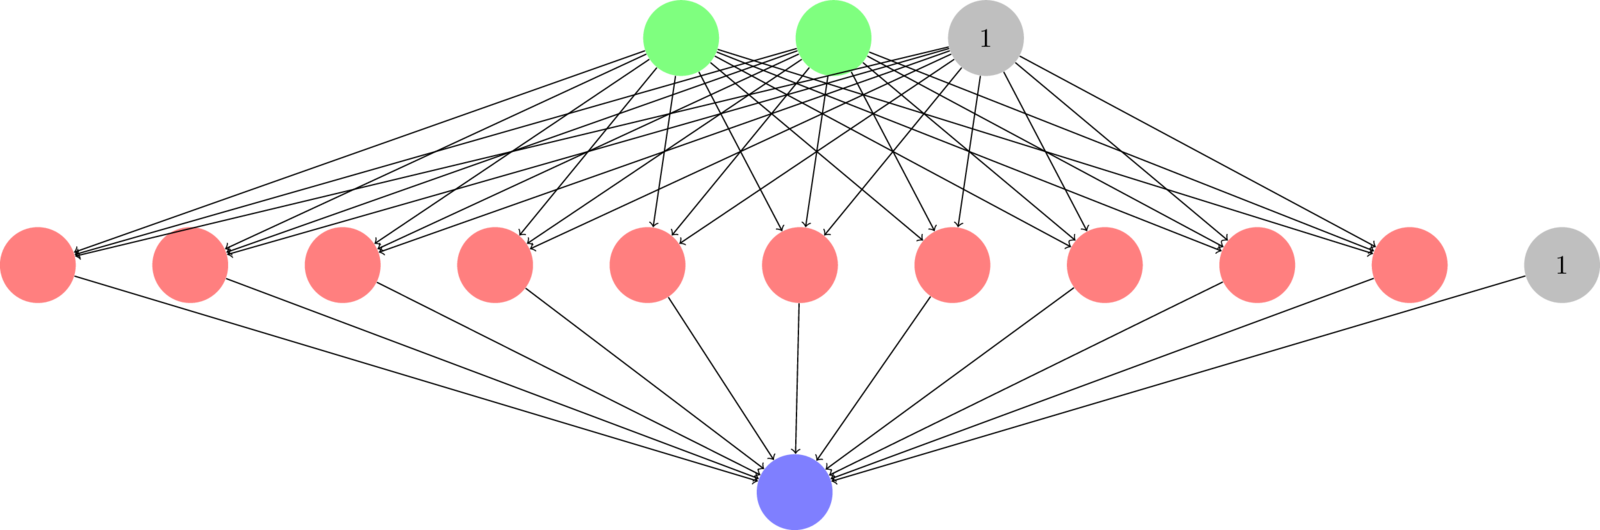

In [76]:
# Code here just allows image to be contained within this file
bar = 'iVBORw0KGgoAAAANSUhEUgAABkAAAAISCAYAAACUBQNIAAAJLmlDQ1BJQ0MgUHJvZmlsZQAAeJyVlWdQk1kXx+/zPOmFQBJCh1BDkSolgJQQWijSq6hA6J1QRWyIuAIriog0RZBFARdclSJrRRQLi4ICFnSDLALKunEVUUFZcN8ZnfcdP7z/mXvPb/5z5t5zz/lwASCIg2XBy3tiUrrA28mOGRgUzATfKIyflsLx9HQD39W7EQCtxHu638/5rggRkWn85bi4vHL5KYJ0AKDsZdbMSk9Z4aPLTA+P/8JnV1iwXOAy31jh6H957EvOvyz6kuPrzV1+FQoAHCn6Gw7/hv9z74pUOIL02KjIbKZPclR6Vpggkpm20gkel8v0FCRHxSZEflPw/5X8HaVHZqevRG5yyiZBbHRMOvN/DjUyMDQEX2fxxutLjyFG/3/PZ0VfveR6ANhzACD7vnrhlQB07gJA+tFXT225r5R8ADru8DMEmf96qJUNDQiAAuhABigCVaAJdIERMAOWwBY4ABfgAXxBENgA+CAGJAIByAK5YAcoAEVgHzgIqkAtaABNoBWcBp3gPLgCroPb4C4YBo+BEEyCl0AE3oEFCIKwEBmiQTKQEqQO6UBGEBuyhhwgN8gbCoJCoWgoCcqAcqGdUBFUClVBdVAT9At0DroC3YQGoYfQODQD/Q19hBGYBNNhBVgD1ofZMAd2hX3h9XA0nArnwPnwXrgCrodPwh3wFfg2PAwL4ZfwHAIQIsJAlBFdhI1wEQ8kGIlCBMhWpBApR+qRVqQb6UPuIUJkFvmAwqBoKCZKF2WJckb5ofioVNRWVDGqCnUC1YHqRd1DjaNEqM9oMloerYO2QPPQgehodBa6AF2ObkS3o6+hh9GT6HcYDIaBYWHMMM6YIEwcZjOmGHMY04a5jBnETGDmsFisDFYHa4X1wIZh07EF2ErsSewl7BB2EvseR8Qp4YxwjrhgXBIuD1eOa8ZdxA3hpnALeHG8Ot4C74GPwG/Cl+Ab8N34O/hJ/AJBgsAiWBF8CXGEHYQKQivhGmGM8IZIJKoQzYlexFjidmIF8RTxBnGc+IFEJWmTuKQQUgZpL+k46TLpIekNmUzWINuSg8np5L3kJvJV8lPyezGamJ4YTyxCbJtYtViH2JDYKwqeok7hUDZQcijllDOUO5RZcby4hjhXPEx8q3i1+DnxUfE5CZqEoYSHRKJEsUSzxE2JaSqWqkF1oEZQ86nHqFepEzSEpkrj0vi0nbQG2jXaJB1DZ9F59Dh6Ef1n+gBdJEmVNJb0l8yWrJa8IClkIAwNBo+RwChhnGaMMD5KKUhxpCKl9ki1Sg1JzUvLSdtKR0oXSrdJD0t/lGHKOMjEy+yX6ZR5IouS1Zb1ks2SPSJ7TXZWji5nKceXK5Q7LfdIHpbXlveW3yx/TL5ffk5BUcFJIUWhUuGqwqwiQ9FWMU6xTPGi4owSTclaKVapTOmS0gumJJPDTGBWMHuZImV5ZWflDOU65QHlBRWWip9KnkqbyhNVgipbNUq1TLVHVaSmpOaulqvWovZIHa/OVo9RP6Tepz6vwdII0Nit0akxzZJm8Vg5rBbWmCZZ00YzVbNe874WRoutFa91WOuuNqxtoh2jXa19RwfWMdWJ1TmsM7gKvcp8VdKq+lWjuiRdjm6mbovuuB5Dz00vT69T75W+mn6w/n79Pv3PBiYGCQYNBo8NqYYuhnmG3YZ/G2kb8Y2qje6vJq92XL1tddfq18Y6xpHGR4wfmNBM3E12m/SYfDI1MxWYtprOmKmZhZrVmI2y6WxPdjH7hjna3M58m/l58w8WphbpFqct/rLUtYy3bLacXsNaE7mmYc2ElYpVmFWdldCaaR1qfdRaaKNsE2ZTb/PMVtU2wrbRdoqjxYnjnOS8sjOwE9i1281zLbhbuJftEXsn+0L7AQeqg59DlcNTRxXHaMcWR5GTidNmp8vOaGdX5/3OozwFHp/XxBO5mLlscel1Jbn6uFa5PnPTdhO4dbvD7i7uB9zH1qqvTVrb6QE8eB4HPJ54sjxTPX/1wnh5elV7Pfc29M717vOh+Wz0afZ552vnW+L72E/TL8Ovx5/iH+Lf5D8fYB9QGiAM1A/cEng7SDYoNqgrGBvsH9wYPLfOYd3BdZMhJiEFISPrWeuz19/cILshYcOFjZSNYRvPhKJDA0KbQxfDPMLqw+bCeeE14SI+l3+I/zLCNqIsYibSKrI0cirKKqo0ajraKvpA9EyMTUx5zGwsN7Yq9nWcc1xt3Hy8R/zx+KWEgIS2RFxiaOK5JGpSfFJvsmJydvJgik5KQYow1SL1YKpI4CpoTIPS1qd1pdOXP8X+DM2MXRnjmdaZ1Znvs/yzzmRLZCdl92/S3rRn01SOY85Pm1Gb+Zt7cpVzd+SOb+FsqdsKbQ3f2rNNdVv+tsntTttP7CDsiN/xW55BXmne250BO7vzFfK350/sctrVUiBWICgY3W25u/YH1A+xPwzsWb2ncs/nwojCW0UGReVFi8X84ls/Gv5Y8ePS3qi9AyWmJUf2YfYl7RvZb7P/RKlEaU7pxAH3Ax1lzLLCsrcHNx68WW5cXnuIcCjjkLDCraKrUq1yX+ViVUzVcLVddVuNfM2emvnDEYeHjtgeaa1VqC2q/Xg09uiDOqe6jnqN+vJjmGOZx543+Df0/cT+qalRtrGo8dPxpOPCE94nepvMmpqa5ZtLWuCWjJaZkyEn7/5s/3NXq25rXRujregUOJVx6sUvob+MnHY93XOGfab1rPrZmnZae2EH1LGpQ9QZ0ynsCuoaPOdyrqfbsrv9V71fj59XPl99QfJCyUXCxfyLS5dyLs1dTrk8eyX6ykTPxp7HVwOv3u/16h245nrtxnXH61f7OH2XbljdOH/T4ua5W+xbnbdNb3f0m/S3/2byW/uA6UDHHbM7XXfN73YPrhm8OGQzdOWe/b3r93n3bw+vHR4c8Rt5MBoyKnwQ8WD6YcLD148yHy083j6GHit8Iv6k/Kn80/rftX5vE5oKL4zbj/c/83n2eII/8fKPtD8WJ/Ofk5+XTylNNU0bTZ+fcZy5+2Ldi8mXKS8XZgv+lPiz5pXmq7N/2f7VLwoUTb4WvF76u/iNzJvjb43f9sx5zj19l/huYb7wvcz7Ex/YH/o+BnycWshaxC5WfNL61P3Z9fPYUuLS0j9CLJC+ERlPpwABAABJREFUeJzsnWWYnOXZhs9Zj3tCIGiwoElwd6e4uztFilNKkRYvxaEUCpQWd3eHJEiMJMSDuxQnJLvfj/Odb5dkZWZ3Zmc2e5899iDdHXne95HZva5bUgRBEARBEARBK3BmzZkApcBCwMDka5HkvwsDXYAOyb9TwKfAV8AvwAfAdGAi8G7y76nAz2elzmrFqwiKlWR9AfQBFsd1thAwKPlvP6AMmB/oCvwAfAjMBD5P/j0eeA/X2BRcgzWxxgKA5557DqACWAzPqcWSr8WT/98Bz7EFgBrgI+C75Ct9hk1Kvj8Jz7BZG2ywQWteRhAEQRAEQbsiVegBBEEQBEEQBPMmdQTprsBSwJrAKsDSKEL3A0qyfNkaNEU+BqYBbwDDgJHJ96tDrG4/JGusAgXnlXB9rQYsiOurUzNe9mc0Pj4E3gJeB14F3gd+ifXVfkgMjxKgG7A8nmErA0vg+upD88+wD9EEeRN4Ec3dLwHCEAmCIAiCIMgdYYAEQRAEQRAEOaOO6VGGIuEGwOYoHHbHDJBcUg38iEL1k8DzaIb8CBBi9bxHnTXWC1gD2ATYGCPxK8n93zgz0fx4GngWeBkj+GN9zYMkpgdorC2Da2tjXGudyd7waIpq4Fs8tx4GngPG4boLMyQIgiAIgqCFhAESBEEQBEEQ5IQ60fjLA3sDW2FZmPJWGkINZoa8AvwLhervIITqeYFkfZVg5P3GwH6Y9dGtFYfxPfA28F/gQTRGIutoHiExPzphJtG+wPpYPi3XpkdD/Iqlsl4AbsLsox/DBAmCIAiCIGg+YYAEQRAEQRAELaKOML0scACwEzCgkGPCiOrHgRsxonomhBHSFqmT8dET2BPYGctcVRRqTMAsYDRwJ3ArkRHSpkmMjzJgdeBAYGugdyHHhH1pHkYz9xWgOoyQIAiCIAiC7AkDJAiCIAiCIGgWdYTp+THj40BsaN5a0dKZ8BlwH3AFMIGI1m9TJGusElgPOBYj8jsUbkRz8QvwGnA58ATwY6yvtkOdcleLA/tjVlF/iuvv5A+Am4EbsIl6lMUKgiAIgiDIgmL6xS4IgiAIgiBoI9TJ+tgQ+CP2+GitUlfNYTzwd+A/hEjdJkjW2ILAUShO9ynogBrnf8BdwMXYzDqyQYqYOfp8bA+cgOXUivXv42osh3UpGrozwwQJgiAIgiDIjGL9BS8IgiAIgiAoUhJhugdwEHAMsEBBB5Q53wG3ARcCUyFE6mKkjrm2NnA6mmxlhRxThqRF6j9jw/RZsb6Kk8QAmR84DjiY1u0j0xK+BK4GrsF+R5ENEgRBEARB0ARhgARBEARBEAQZUafk1cIo8u4GVBVqPM2kBngJOA3r6ocJUkQka6wjsDtwKpZUa2t8BFwGXAt8G+ureKiT+bEicC6wBVBasAE1j5nAo3gGj4YwQYIgCIIgCBqjmOozB0EQBEEQBEVKHfNjOeBKYB/anvkBBgCtC1wHbAmk6lxbUECSeegAHA9cQts0P8DMgj8DZwLdYn0VB4n5UQKshebU1rQ98wMs27UdZoKsXdihBEEQBEEQFD+RARIEQRAEQRA0SSLiroTmx+qFHU3OeBc4BbiTaI5eMOoYBL2Bk4DDgc4FG1Du+Bm4FY2Qj2J9FY46mR+bYy+gpQo2mNwyFjgWeBYiEyQIgiAIgqA+wgAJgiAIgiAIGqSOOD0UuIp5x/xI8xHwB8IEKRh1yl5dABxG2+j3kSnVwO3YK+cLiJJrrU0d82Mz4HJgycKNJi+MB44CnoMwQYIgCIIgCOYkSmAFQRAEQRAETZEuezWvmR9guaKLgK3gN4ZPkGfOrDmzrvlxPHAg85b5Af69tTM2c+9e2KG0P+qYH+szb5ofAMtgz5m14TfXHARBEARBEBAGSBAEQRAEQVAPdcTphYBzgDUKO6K8MgD4K/YGCROkdSkBDgZOxv4f8yLlWNbrRKBDrK/WoY4RMBj397xofqRZHjgfWKHQAwmCIAiCICg2wgAJgiAIgiAIGqIrRq5vU+iBtALLAeeR9AYIkTq/1Lm/26L5MS/0/GiMSuBoYA+I9dWK9AfOYt42cNOsBfwJ6Pfcc89FJkgQBEEQBEFCGCBBEARBEATBb0jE2VJgb2BP2s/vjGtglH7XQg+knTAIBdv+hR5IK9EFOIWklFyYIPkjEf87AL8HtizsaFqV32G2UXmhBxIEQRAEQVAstJc/ZoMgCIIgCIIMqCPKrgOcAHQq3GhanRSwG7AvUBoCdX5I7mt34DQsT9SeWBw4F3vPBHmgTubDtlhebV7rK9MYFcCReO2RBRIEQRAEQUAYIEEQBEEQBMHc9AL+ACxS4HEUgk4YNT64wOOYJ6ljKu0AbF/AoRSS9YC9gJIw2fLGYsDxeJa1N3oDxwELQ5ggQRAEQRAEYYAEQRAEQRAEwG/E6V2BjQs4lEKzOHAUUBUCdV5YEk2m9pRdVJcy4AhgNYhSWLkkEfsrgAOAIYUdTUFZA9i/0IMIgiAIgiAoBsIACYIgCIIgCOqKsEsBhwJVhRtNUbANsAWEQJ0r6vSWORhYobCjKTgL4z7rUOiBzIOsjgZIeyp9NScpNEDWhMgCCYIgCIKgfRMGSBAEQRAEQVCX3QhxGqAncCDQo9ADmReoYyINAXZGgba9sw2wVqEHMa9QJ/vjQKB/YUdTFCyE/YzCZAuCIAiCoF0TBkgQBEEQBEGQZhCwS6EHUUSsB2xU6EHMQ5Rj74uFCz2QIqEHsB/QKbKMWkadDIe1gU0LOJRiY1vadymwIAiCIAiCMECCIAiCIAjaO4n4WoKR+UsXdjRFRWdgH6B7CNQ5YXlsfh7Usjn2a4hSay2nIxps8xV6IEVEP8wCKYsyWEEQBEEQtFfCAAmCIAiCIAgA5seSPPH74W9ZA1gFQqBuLnXu2/bAgAIOpRjpBeyIvVGClrEksFmhB1GEbAQsV+hBBEEQBEEQFIr4AzcIgiAIgiAAm+UuX+hBFCG9UVRtzw2Vc8H8wPpE74/62AAYWOhBzANsQmR/1MdiwDoQzdCDIAiCIGifhAESBEEQBEHQjkmi88uA7bCBcDA3m2ApmSBL6mR/DCZ6ETTEQsC6EFlGzSER9Xti74/4+3ZuUsBWQLdCDyQIgiAIgqAQxC+IQRAEQRAEwRIoUAf1sziweqEH0YYpxV4XnQo9kCKlA5psXQo9kDbMCkQGW2OshCXCgiAIgiAI2h1hgARBEARBELRT6kSbLwcsWsChFDsdSUrIBM2iC0mj76BBViSyjLKmTkmnoRTZ/UuliqraW3dg7UIPIgiCIAiCoBCEARIEQRAEQdC+KQNWBaoKPZAiZ3mgV5QoahZLAwsUehBFziKYiRVkTyc8w4qCtPHx/fffU1NTU+DR/D9lwMpAafQBCYIgCIKgvREGSBAEQRAEQfumC7BKoQfRBhiIInWQIXXMoqHYTD5omEoiS6a5dKHA/WVKSkooKysjlUrx008/8dxzz3HDDTfwv//9r5gyQQYBCxd6EEEQBEEQBK1NWaEHEARBEARBEBSUHhihHzTOgsBiwJtn1pzJWamzCj2etkIpsCxQXuiBtAEG4/2aXeBxtDUGAfMVcgAffPAB7733Hp9++ilTp07l2WefpW/fvuyyyy6FHNacLAgMAKYVeiBBEARBEAStSWSABEEQBEEQtG8GYo+LoHFKiAyQ5tCd6C+TKQsCPaPMWtYshhk0BePjjz9m9OjR1NTUsMQSS/DTTz8BRdcHpDfQH37TOyUIgiAIgmCeJzJAgiAIgiAI2jeLUmDxsA2xBFABzCz0QNoQnYA+hR5EG6EbMD/weaEH0sYo+Bk2dOhQhgwZQmVlJZMmTSo246MuA4EUUDTNSYIgCIIgCPJNZIAEQRAEQRC0bxYgyhNlygJEAFG2dCMyZzKlG9EsPmPqZDEsVMhxgJkepaWlVFdXM3t2UVcwW5Q474MgCIIgaGeEARIEQRAEQdC+WRwjgoOmCfEwe6qAroUeRBuhAjNmgszpBvQr9CAAamraRFLFAOIMC4IgCIKgnREGSBAEQRAEQTukTp+B0kKOo41RRfz+nC0DiHuWKZ2JcmHZUkYI+tkQ530QBEEQBO2O+GMkCIIgCIKg/dIJ6FLoQbQhyrGpd5A5nYgMo2yoKvQA2hid0DgKMqMvUcYvCIIgCIJ2RhggQRAEQRAE7ZcOQMdCD6INUQH0KvQg2hhtoi5Q0GbpTJi42dCN0ACCIAiCIGhnxC8/QRAEQRAE7ZcUEZ2fDTWEoB8ExUbsySAIgiAIgqBBwgAJgiAIgiBov/ycfAWZMRP4stCDCILg//ku+Qoy4xugutCDCIIgCIIgaE3CAAmCIAiCIGi/fAd8XehBtCFmAf8r9CDaGN8SEfqZUgP8WOhBtDF+An4o9CDaEJ/jORYEQRAEQdBuCAMkCIIgCIKgHXJW6qz0P2cWchxtjB+J6Ols+ZS4Z5nyI/BVoQfRxphJnGHZ8AthSAZBEARB0M4IAyQIgiAIgqB9836hB9CGeB/4tdCDaGP8iGV3gqb5ibhX2fItZjUEmfEZkQESBEEQBEE7IwyQIAiCIAiC9s0MjAoOmuZ9QjzMlu+BTwo9iDbC98AXhR5EW2GDDTZI/3MqkdWQKdMIEzcIgiAIgnZGGCBBEARBEATtm3eJEjKZMo24V9nyLfBBoQfRRvgK92OQHR9S4H2ZSqX+/6ukpOT/v1dSUkJJSQmpVKqQw6vLFMIsCoIgCIKgnREGSBAEQRAEQftmOtFEOBOqgcmFHkQbJAyQzPmUKIGVFeuvvz6zZs2aSgGz2FKpFN999x3Tpk1j3LhxjBgxgpqaGv73v/8xYsQIJk+ezIwZM/jll4In2n1Jko1VJ3smCIIgCIJgnqes0AMIgiAIgiAICsqXwARgvkIPpMj5iKRfSp0G8kEjbM/23M7ts6qoGl1Dza9AeaHHVOS8AcyO9dUknYC+wCKpVGqlpZdeuvff//73b6uqqrrW1LR+ckNJSQnvvfceDz30ELNnz+a7775jrbXWYvbs2bz22muMHTuWjh07suOOOzJgwAAKMcaE9wgzMgiCIAiCdkgYIEEQBEEQBO2b74CRQIQEN0KK1MQKKqYUehxticGpwSVAh/1e3O+9hdZa6OtUSapvocdUxPwKvF7oQRQhpUAF0A8YDAwFlgbmT77+9+GHHw7/5ZdfRlVVVQ0oxABnz57NoEGDWHLJJQF+Uwarurqampqa//9eAc0PgEloggRBEARBELQrwgAJgiAIgiBop/SmN5/x2axSSt+ooWYmCo3BHKRI8b8P//fupQMu7QP8lHwF9VMGLAQsAawFrH/nDnd+dNSko77p2KNj35poP9AQ0zATK4BewALA4sAqaHwMwH33PfZKGQeMApb67rvvVh4+fPi0zTbbrKampqYgzTZSqRRlZXP/aV1aWlqA0dTLLDTYfo3yV0EQBEEQtDfCAAmCIAiCIGinHJ06mtdrXufmyTdP6Tmw5/upktTAQo+pSPn2revfSgE3Yxmsl5KvycCP2B+kvVKKJYkWAtYHVgcGAr2xv8zTv/746+s1s2u+r6FmyYKNsvgZSdKfoZ1RgetnPlw7q6B51hPogHtsEvAk0BVYGM2QpYDZwGvAiyUlJRXV1dVrA/1b+wLaCP8DXi30IIIgCIIgCApBGCBBEARBEATtk3Jg2VVSq6xbUl6y9MGvH/xp/xX7D4wI/XqZ3qFnh4uB5YBNgV2BY4HxKCq+AowBvi7UAFuZEmBRYFlgZRSuFwM+ByYCNwHDsTH10r/++Ov6L1/wcummF236HdClICMubn5OkXrmB374/kIu5Czm6R4gJWhSLAwMwpJWQ5LvfYo9KoYBU4GZaHYMRnMtBcxA0+MVNEYWBYZeddVVAwYPHvxp7969+xe4zFSxMgzPqyAIgiAIgnZHGCBBEARBEATthyqsm78+sDmwJJCq/rX6mZ+//vleFBo7Fmx0Rcr7r70/+amTnloJeAF4EOiD92o9YBtgD+AL4E3gMRQaP8e+DvMCpUB3FK3XANbGLI/OKFq/BFwMTMEyRUvgPVkLI/mnfTbms7uT56zTymMvemb+MPPzu3a6q+uUx6esdhEXTcC+PPOKit8J185CmN2xCpplHdHQmADcj8bZL2iQDQX2xCwicF9dAowGPsNMkE2Bo5LX+vnrr7++d+bMmY+jSRl/4/6W2cBTmAUSBEEQBEHQ7ohfDoMgCIIgCOZ9+gPrAhsBa2I9+DEoKj4DfLTo+osOqKFmb2DFgo2yCEmR+nL6s9Onzf5l9pHAH9AEuR8FxYdRsF0Nxf7VgR2xR8GLGKn+JkaztzVBuwxYENfDqsnXEihATwD+RW0Ufjlmg+yKxtoiKGg/AjwNjNnpyZ1+LqFkwWqq18IsgAD7y/z8zc/Dpz87fXngGOxr8RDwLJYQa2vrppTa7KClcP0sB3QD3sV1cSeuoelojCwLbItrrBzLXg3H9TUC+BZ7gqyHZ9gayfdex7J0L9XU1Hz26quvLv/rr7/unTw2qGU68BxA9P8IgiAIgqA9UpAmcUEQBEEQBEFeKQH6ovi4FQr0nTBC/1EU8d8Ffk4e37O0snTo7g/tftDimyy+Yw01ESRTywPj7x5/yF0739UT2BjYAeiHvUAeBB5P/j0LmzcvggLtZli+pwbNphexXNb72Mi52Cihtvn0GmiYLYVGyJcoRr+AhseHKFQvnjxuWzTZfkDh/lEUuj9PXrscWGrw/oM33urqrU4sqyqbv5WuqS3wxaxfZu3+l6q/jMR9uitmQMxCc/J+4G3gm0INsBFSaGz0w+yetFHWD9fND9jb5HW8hm9xnQ3ELLQ10ECsTn7+NBqGHySP7YeG7ZZYJqsieb0ncC99gGWyUkC/Xr16rXbxxRcfvOiii24VZbB+wxVo3kYD9CAIgiAI2iVhgARBEARBEMwbpLCszCoYhb8GCvBvY4miZ4BxKBim6Zk8dk9gqcU3X/yuvR/be8tqqldozYEXKylS35VQstcsZj14durs9Le7YrbH1tSWc3oZsx1exPJFoFi7BBoEqwMroSg8BqPaX8RSWT9QuCj/Mmw+vQqul8E45m8wE2EYCtLjsLRVWrzeMPlaCYXqlzAjZhiWAqv7+qsCOwFblJSVTDpmxjEfdVug22HRa0ZKKLmpiqojZlfP/um00tPADIqlcV9uhvd7PIr+j2E0f3XBhmtj8oHA8pjZsQyumc5oeo1Gk2ICMA3HuiyusdWS5/QExmKWxwjgLSylBu6vddBsXB3X5xtovj2bvMfs5LEpNEl2AHYB+uywww4PH3vssbvPnj17wXzcgLZGKpV6v6qqavvvv//+zY033rjQwwmCIAiCICgIEd0XBEEQBEHQtumGvTw2QsG0L5Ypeg6zEyagSJ1WnFNYdmZzYG8UI98EDv7w9Q/fqKZ6Noqb7T5Q5rtPvhv9363/W/7xmx/3xLJW4L18DA2lAcAGwM7YA+Nj4L7kZ5PROBiHTcH7oxmwXvL4/VH0fRKj2ScDn5BfMySFfRUWQfNiXRSna9C4GAFciqbZF2h6lGPvj5UwEn8ommjjgBNQnP6M3xprXdBQ2RXF7A+Ba6pnVd/boWeHATXUbJG8Zrumelb196/+/dUPnjrxqYF4P2tQ3K+7bobgejkQOAyzJB5AA+GLel42l5TiebIAGhdDgRWAHtjf5ks0O26ids38jGt9GWr7wHTH/hPvAJeh8fERGm01eAatg2fSRrh+PgDuxr00hd9mTZWiCbMDlpzrADwP3PLll19Orq6u7gEcnMP70CZJpVK8++6740877bReH374YRdqzdkgCIIgCIJ2Rbv/wzYIgiAIgqANUoUmxpYowC+FAv1LGCU9nLlL5pSi8L07Zi/0xqyFO9AA+eXMmjNB4fJOFMbbLSlSXw27fNitjx/z+PokAj7e2x/qeXi6D8hmwCb4O/YbWL7oVZybusbGQliebHU0IRYA3sNSQS9jJsVX5KaJeiU2bV8ZywmtiOtgZjLGYShij6dWZE4bJWsl17M6itivU1t+aDJzZyJ0w8j9XTHifxyupUeBL86YdQYlpSWVwF+A42nnf4v89PVPD1+26GW//PK/X5bC+/QfYAZz39dSak3OLXC/T8GsmweT57R0raQwa6kDtRkbK+BaXRDX79u4VkZjX5tpWKqrI2atrAmsjY3Je+GaGo7nyyg0NdJUJc/ZOnnOEsnPn8Zsj5HMLdiXJ4/bB5ugVwD34D4bA8x+7rnnwD31X9p5L5DS0tLpF1100f0PPfTQ5jgX16MxPrPxZwZBEARBEMxbtOs/OoIgCIIgCNoQZSgsroEi6GAUCN/CjIR0+aFZczyvEk2NnYDtMKo/bXxMBX5JP/D8mvO5gAs4lmMPrab6UhRD2ys3vHD2Cyc8f+bzywOH4H0fBfwTo81/ruc5ZRj9vgne66VxTu5D4+Adfis+lqKxsDSaJ6ug2DwLTYYXUQieTnaiZS/sz7EiisFDUCD/JHm9l5L/fj3HdfTCKP91cY11SN77GVxj71O/ATR/cs27Y2T+COD2ZPx1s4/4c82fKaFkYDXVd9VQMySLa5rXmDL719l7nFtx7gfAXslXNXAjrpcPGnheF8zG2YHaHhrPoREyArMyMqUS1+tiaHYMwTVTmbzOx2h6jcDeL9/g+ZFudL4MmhdrYqbI52iKvJh8fYSmWnWd90uXhdscGIT741XcH28m75EucZWmQ3LNe2LvkK+Au/A+fUidM+/ll1+mtLS0bObMmWfV1NScUlNTU5LF/ZiXqE6lUn/af//9r5g+ffr6wAGYxfMCGiFvMPdnRRAEQRAEwTxJGCBBEARBEATFSwWK0mtio+lBGG09DCOlR9BwT4BOKGbugyLlT8C/0fyYwdwiY5rUkAOGLLfJxZtc3qFHh/VzdSFtjEnAbsDIs1JngQLsJli2akU0QP6Bgm1DkfddqW1CvyWaAGOBh5Lnf8Hcc9AF53h1LAm0IgrCU1HkfolaE6JuRkkHLCOUNi+GYG8EUMB+IXnvKWhIpEkl77kMCtLrYFmvj1CQfh6zOOornVOKZs2OwDZogjyLxtqr1G8QscYJazD8suGdDnz1wKP7r9T/9FQq1bm+x83jzAb+BJz35AlP1rx2yWslmOGxJ667T9FoewBNqvooQRNiI2B7NJ7exTm7jznMzeTxnTFLZ1ksxzYEs4N64Hy9jWfLODwjPkzGWorrZCCurzWxhFkP3CuvoKA+CTOZ6p5HaZNlA1xjSyTfex6NtTeS59RHV8ys2j8Z62fAzbg2P6LhcnGpY445Zq3NNtvs6o4dOy7fThuiD8e1NCNpfN4Nz6FDcT4eAm7BuW7osyAIgiAIgmCeIAyQIAiCIAiC4qMvlizaFCOeq7DszHMoMk+nYeG9C5Yu2g+F9EkYLf0ARmg3pgaWoph93NBDhr6zzXXbbFpDTXvr1fAT9ra4BqhJDJA0ndHQOAQF4PuBW7H8TkONqUtRcNwYBcghGF3/EJYwGs1vhWrwd/RKFLjXRGNiORQxR2N0/djkPZfGeV4ZM1CmYlbQq8l/v2Hu7JEKNFfWRmNnKcw4GJ6MaxRG7te3VkpQQN8Ge1OUYYmru5KxNZWpsghwYlXPqiUOG3lYqvtC3Tduhw3Rn8T9+fEc66sUMzEOxLUyGaP1HwV+bOC1UrguBwO/Q4OiBxoMT+O89k1+vhIaENVobszANfImnhM/UnuulGAW0fK4vlbFuXsXM5leS77eT55XdxJTWH5qdTQ91kKRfWRy7S9gdklDZ1hvNHb2RkNwHJq3TzJHRlE9dEBD6OiDDjro7b333nvb6urqPo08fl7kSzyj7gVIDJA0PTFTay801/+N5cKmkd/+Q0EQBEEQBAUjDJAgCIIgCILCk0JhagkUltfD0kgzUPR7CZhI/eWH0vTBKOt9MFJ7CvAvFMszaZY8ADgCS2W92Klvp4tP/PTE9WuouQgF1vbC9WiAfDuHOF2Xflji6kDMtLkTjZCGsnHSdEZBdxsUuCvQyLgXDYtPGnh+GZoOG6JwuRxmZdTgOhmDDaOfwnVSX8ZGFWZsbIDG2lJYAucl4HE0PRp6f5KxLo9R5ZujafMg9mCYSNPldCqx38NxKPRffMT4I97tM6jP1Vj6q70wBTMaXgZoYI1VYubDQcl/38aMo5do2AgpReNgpeT1t0IT4ys0zj5DI+UFnK+PUShPR/+XoXGyMBpj62D/j0o0UdK9aSYnz51zvstQUF8O98ZquDcmo6n2Gu6PnxoYfwkahZviGdYfs5f+g8ZcQ5kwdVkCOCUZ//2DBg269pprrjmopqbm5OT+tAd+Bc4HzgF+ncP8qMvCmFW4P54jN+Ne/pAwQoIgCIIgmMcIAyQIgiAIgqBwdEBRecPkaymMxH0eMz3eonHTAxQKt8ao3oVRqPw3CuoNiaV1KcMsgJPQRLkIuON31//u56EHDe0A/B04mHbwe2NNdc2wmp9r9vo59fPUv3T4CxWpiqaeMgCzIPbF+3Mz9r74qInnpYD5MLtnC8zy+AoF6iexLNCvaJgsi6WtVsGsjW7ABBTFyzGjZAk0y16hthzRp8l7zY+mx7ooav+KpdOewYyiT2nctOmAEfw7oPExA7OJ7sPo/0zE0sWAo7Fc1uPAhcvvufyUDf+yId0X7r41cANmKczrfDfrl1nHVVZW3nAGZ5BKNbmlKvFcOAiNjadxb7+GBkQPLJ01CNfBIFwL36DxMBHnbz28v6+gUfYsrrcyNDmGYj+RIThXH1FbDms4teW06pvrzsnzNsP1vBA23H4a19c4GiiHVofFMWtjezRxnkTj4y3mzo6qj0pgV+AYXMvnAw9ddNFFM1deeeV+WE5s6wxep81TXV19z08//XRYSUnJF1tuuWVTD0/hfO8L7AL8D422e8nMcAqCIAiCIGgTzPN/yAZBEARBEBQZnbCUzDoYKb0ARuy/gLXtJ2C0dmPCcjmWR9oGReWuKDama7o3ZZqkGQAchubJMOBCktJKZ9acWfcx12HGwjxL9azqSffude/wcXeMexMF+e+zePoSKMDuhnN5I5bH+jyD53ZMnr8lmgzdUUD+CA2xbih2T0LT4nWMwP8Ko+Z7U9ubYX3MTpmN66gERfEKXBePoQj+Pk0Lyz1RON8NBfLJWCrnKWrNlUyubTM01yrQTLuP5N4ma6wM+D32xOiW4eu2OVKkfpjy5JRn7tr5ri9++faXv6PBkGmkfUdcG6dgibu0ubk0GhyzMEtjDJojU3Ht/Q/XwPxocOyCc/kprrFueI6A2SAvooE6NXlMQyWquqFpsTGaYr2wNNXTeIZNoulm7JVo3uyG2So1yXP/i8ZNJsYHaBAejevsAeDKZPw1zz33XPoxy+MZtkaGr9nmSKVS/Pjjj6NPPvnkt8eOHfsMcBtNG09pyjBzZ288hz7C+/UErqEgCIIgCII2TRggQRAEQRAE+acMyw+tj9kWQ1CkTkfhj6DprAFQRF4KDYutUdx8EEswvU3TZYjqjmcj4FTM+rgShce5xK5EpF4BuApLy8yLvPfrj7+eeF6X83rVVNecgubFX9CIypQS7LOwFwq676ER8hANmyklWJpqacyy2Bz7JpSiINwV+yZchM3rGzNlOmP5oKNQ6J2Ja6wKy1vdg9kXk2m8T0cf7CWxA877q9jf42myE0MXBo7HMjvPAJeg6P4bkvVVBZyI67FDFu/RVqhOkbrqxnVv/O97L713Lppcp+A9rY8Umpy90LBYGudiBbyv1WhCvAtcjsL/uw28ThmaYqtRW/5sfixF1QXN0hvxDHifhrOBKtFoS7/Gcpgl8Cy1xtxXTd0IPMOGYJmrjdE4uQuzDqY18v5z0gkN4JPQLLkE99pcon9ihKyDZ9jyGb5+myKVSo365JNPTthtt93Ww3t7IxqO32bxMqV4/hyI5udIzJ55nszNlCAIgiAIgqIjDJAgCIIgCIL8UIqmx4poVqyJwvMYjMR/DSP5m2oaDUaADwH2RAHyaxQ978TI74YitetjAeBIzFgYDlyMpWbqpU4myKooIK6cxXu1BT4G/jAf891xeOrwUixp9SfMhPkjRqNnQzneo0PRMBqFYuRzKDpX4rpYGtfEWmg6fIOR8y/ivJRieayNk8dPQhPjZRS7Z6FBsmzymI2xzNEHKEo/h4bFqmi8LYuC91QUrF9Fwflz/JtgQTQ+dk1e5yUs5zWc7LJh0r0+/oDGxt+TcTeYlZSssS7AGWjgzEsmyCws53TqWze89fFDBz20JJprg4DzgDuSx3TGbKvF8MxYFTMkZmJW0WScizFoNGyORmhl8vp34NyDhseiuA7XQePkR+zx8hrO7cdoYuyApsBMjPh/GI2qb5PXXhjLb22LBt93uKYfxFJrX5DZ+dMteZ19cN1/gFkKjyVjmd3wU39DCrNPTkIT9xFcY1MbekKdTJCN0TAalOF7tRWmAYeec845Tz/77LNV2NfjJCypdw7OezZ0QgPkIFwbL2B5v2Fk91kTBEEQBEFQFIQBEgRBEARBkDtKsXTQSiher4ri9hgUo4YD75C5iNQZRcwDMTL3XRQ6H6NW7MyUchQMT0aB+yps3J1RhHAiUq+KkdbzSibIDOA0jECflTSkTqFo/Nfk36eg6ZBtY+CK5HV+j1H8z6OZMhCzePqiqD0MheSx1N9ToxcKxptjmaufgDdRBB+ERsrXaHi8gNlEc2ZqpGv9r4jZIRugOfEeitmlyWv3QtPjIWA0mZlzdVksud5tk/FchKW4miRZX92A04EjUIRt6/yKmVWnAh/XaXi+AHAWlhu6B+drWTRA+uE+fwuzKqZQa1TNuTYGYgmpA1HkfhZNi+WxF8dPuB6G4XxOYu6+QOnm9htg5tICuBbHYqbIEDyH3sQz7PVkPJkYFinMdlkfyyutiOffzbhWMy2llqYSy3gdh/f2IjRsmsxOSEyQFJ6Bf2PeyQQZhWbHs8DspOl5Gc7l2dh4/nQsgZct6ayyQ7BM3yPATfh5lmm2YRAEQRAEQcEJAyQIgiAIgqDl9EJBbX0UNbuhcPk09kyYTuZ9OUDTZD0sp7Qsisg3o6j8NdmL8QOAw1EsHYFNgseSebkZzq45O/3P5aqpvqiGms1o279Ljkdh+mGguo44nWZpjNRfGoXEu8k8Sr0cBeil0LjYDpue1ySvcRtwKa6Ln2h6HlIoHu8O7Id9P2Ylz3sIyxcNJ7O+CSUosh+ImUB9k+dVYwbAnZgd8mEG40rTAQ2/E5J//w2F/TnF9kY5u+ZsSijpNItZh9dQ80facE+QFKmfUqT+1oEOF096d9I3/1zknz2pNb9WwJJUQ1DUr8YSUI+goP0RnheNGaW9UJReDbOWVqG25NlbmF3yPBqcmRiu/bE834FouP2avNY44ArM+Mgmk2ABFM/3Tf79JvYoepnsyjKlWQY4NhnjQ5j1MS2bF3j11VdZYIEFeO+999aaPXv2BTU1NWs1YxzFQg3u+T/gfiUxP+qyJp5hHdHofY4szvw69MCsrkPw7LgLzfOMzM0gCIIgCIJC05b/aA2CIAiCICgkXVCA3BTYEE2Gb1Ccex6j/TOpiZ+mBMXoLdH4WADF0JtQ4GpOM9qyZGynoHB1OQrcXzfjtdIsusCqC5yw3S3bLdpnqT5r11DTpQWvVQhmYQmg07EcEPWYH2nmw7JMW6Pgeh31i/qlKNYvhCWt1sFG993RSHgOBeC08dAD18kNaILUZ6xUosi9Aa6JpTFa/1WM9p6Jc7s+GhhvoknzBg3PbycUyndLxvg1rofJaLStgwL918n3nsB79BkK8vUZbwthRP72aPZdSj29PrKgvFPfToevecKa66x54pqD0TQo+r9ZUsn/AH758ZdPv3n3mxvu3+f+xz9646Nl0aRYBNdIByzX9DrOVT/slTIO1+SUBt6iE2aXrYLztCIaYdW4Jl7G8lRb45qZAPwD1159a7YkGc+yeIZtkLze+5jpMQEzjLbGTJAZ2MD+meQx9ZkqJbgedsTSWr2xpNstaMpkYwKn6YDr/1TcuxejUfRTM14rzYqrrLLK0aeddtriPXr0WLOmpqa8Ba9VCGZiCcQzSUyIesyPNAPRDBuMWUd30vwyVgMwu+tg3JO3oRHyIdmb8kEQBEEQBK1G0f8xEQRBEARBUERUoBC9NrXNzD9C8fEJFKG/Jbso2xTW698Oe3x0RIH+puT1Monqr48+2IfiQBSxL8amti0RqroB1wCLLLHVEofv9fBe61VTfSIKY22B71GMvZCkaXQj5keaTliS6TCM0j8Pja0SFBdXxDJlq6B58CE2pB+WfE3jt1ke/VEgPoDa/g23YjkqcN7WBDZDMyUd0f8Mlg2aQa2AWYa9O7bA/h2DUFx/EHgSyw3VJNewMWaQrI6i6T1owqTLEKWS8SyFAvvqybWVY/mkZ3E9jkdBvRT3wKloBv6dJnp9ZMguwF9TJam/nf7T6W+VVpSehQJ90ZCq8ydUDTXUVNfww2c/8MU7X/DpmE9rJj4wccKMF2Z8VzO7pj/2t3gf72G61NmXKGKn18QGWHKtBssZvZL8uxfO6UpoogxNnjMZ5+I1NEm/prYkUTmeT0fgunwJe9C8hmdJB5zXtXGNLYlr5hUsrTca57cG10SX5LHb4XoE19YjaOL8D/fCUpiJsmtybU9RmyXQXMF9ETSHtkzGdilZZn3Uw4JoPP607777nnrAAQfsXl1dfQSaS22BL4GrMSvnc2jU/EjTB0sf7oQm7pVoljWXRdGk3z15nZuxNOOXLXjNIAiCIAiCvBEGSBAEQRAEQeNUYCPg1bGu+lIoDr4B3I+C5kdkXh4pTSU2890RxUVQWLwDhevmRjiXoVB5MmaRXEcWvT4aoQozSfYAjlpsk8We3PvJvctRvD0++W9FC98jX9TgPF2J9/fbDIyPupRg1sTZKBCPQHF5CTQCPkUT7GUUk5tqTF+C4u6uKPj/gFH3PVDo7okGzaMoTE+k6fXQAwXyrdDAAMXxCcn/XxKzDP6TvOYXTbxeh2SMK2AZr8HJ9z/GrIL+aLq8jCXVsm0WXx9rAddi6bgzBu8/+Pttb9x2YTSf9sOMnIKQzvCoqanhp29/4qevfuKbGd/w4YgP+fiNj/nm3W9mf//x959//8n3H1bPqn4Hz4fX8Wz4lKbLgS0OXIbi8h3Yf2EtnIdZaF6+iOvvPZrOCOuKe/IwnMfncS2sj+v2F5y7B5LvN1XeqhJ7vGwIbIPz/2Eypr64xmahCfYAZjY11/ioxMyT49C8uzh53SZ7fTRBN+wbsgpw4GqrrfbW+eefX4Xn73FoaBdrNsgsXE8Xofk0MwPjoy6dsan5Efg581dcm82lFMuS7YsG1SdoLD1GdpmPQRAEQRAEeScMkCAIgiAIgrkpwbIva6HgtzYKPsOBx1E4zKZHQl3KUeTeCYWjr9BIuQOj+1uSodEH67QfiIL/WZg90FJSyWv+CWvKXw9UJ42rQQF0r+S9l8rB++WEJFL/0xpqbsdyQOMho6yPNOkMi5WwefjWmPVRg2WHbsPI+olkL85WJq97FJpg4Np4E0vbPNuM1wTX7hrYh2MVjMavQGHyDBTQszXrStF8WAP7fKyavMaX2A/gIRT8v6F5ewIU5W/A/XAoSWZKssZKMQvkCMw6qWzme2RE3XJWs6tnUz2rmq+nf83n4z/n09Gf8umYT/lqylfM+mkWXRfs+mv1rOq3vpz05b0/f/PzsNm/zB6LZmM2TcKXxzNhIzxrOuD134Rm02g0rLLNLFsE19bRaIbWoBFzCe6HbHp61KUPZqociXukFI2xc4DbaV65vjSLJePdEbNILkJDuKVU4Jj3QcP2Yfj/5uig8XQgsD+e/UVBSUlJNfBBdXX1vzCT5z3IKOujPkqxhNU5aNSeTMv7eJSicXQQGqVjcd0+TsuzwYIgCIIgCHJCGCBBEARBEASSwnr8K2JpmLVRNHsPI5pfQJGvuaJON4zQ3x/Fzo9QPH6QltdQL0ez5iQU8q4H/k1SIiUHbIYlV+5G8ew32QiJSF2CWQJpIWwhFMcKxSdfTv7y/SmPTrlv0I6DLi2tLP354r4XN/WcFJo5C2HGz7pY8mw2CvOvYFbF3igu/4mkiXqGY+qK2UQbYabG/Fi+6FmM8N8E190MNAOeJ3MxuQSzPLZF8bgKy7K9giW11sXyamMwmn4YCuCZrrsFsPb/HmgE3gcsl7xub4z2H56853gs+zQzw9fuiWV9FsHSYL/pIVLHaOudXN8+mIHTMcPXb5K04VFTU8OPX/7I959+z1dTvuL9V9/noxEf8cMXP1BWVUZl10r6LteX+QbP90vXAV2nfjLyk9erZ1X/7dnTnx1zzPRjuGzRy5p6q85YMm45nOvVMMvhFzQ6XsA9vC+eO38h89JCpclrr4SG0Zq4dsehIN0hed3OOH+3YkmpTNdALzxnDsCMlXfR8OiAWRQL4j55GLOXJpP5GuiYjPkkNLj+nozx+wyf3xgpPHfPwmySK5nDoEqMkDKcj8PQ+O5PAf9erqmp+WjatGnTR40a9e8DDjjgX8DMoUOHtvRlU2hk/hXPjD9iFk9LqcQz83A0RN7Ez6ERhBESBEEQBEGBCQMkCIIgCIL2TLrG/RBqBcNFMeL4SYy+Hk/z+3CApYk2xAyJFVAU/DcKhC1pRp6mDwrTB6DQeSGK3rliEIrxU4FjaKS8SSJUV2Bj5R2wbNQiKCy2BtUoFj9cSeXNf+n3l1V/+OyH36HoO72ex6fQPOqHwudaGI0/EEW715Kv0RgpnS5jNAAbVm+OQu31NFziqALNg43RSFoWzYJn0Ph4ndpI/HIUEY9EkXIYljB7mYaF5DIsRbMn9gKpwYyi+9GsSfdyWBBYD4XqIWhQPI0G3Ds0vMbLcP2eivfpCuC/1BozXdA0XAVLLi2Pc/A2ivmvolDeUDZLFRpJu2DmxzMNPK6uETIfZuPsjvPWkSz+rvn/clbUMHvWbGb+MJOvJn/FZ+M+4+M3P+bLSV/y7Qff8uuPv9JnmT70H9qfvsv1pddSvei5eM8fKzpVjC2j7D/P/OmZUc+f+/zfqOEqjHqvjzK8R8vi+bIKGlXdcV0No7Y3SNqQKsf98ye8j401R0/hGbMmztOaOE/pvjHPY4ZSWvAfiL06dkm+dyuaGJ/SMH1x7e6FxseI5DnPUVtaryNmBm2J+6IM1+2jdR7XkNGyMJag2i4Z8yXMYYK1kPWwd9HDaII0KMgnRkglGmy7o+HWn9Yzc2cBn6RSqftmzpx5xzbbbLPzzz//vDAaON/k8H2WxNJ1g4A/Y3+j5pYsq0tHPAeORvP4Scw2GkVtn5ogCIIgCIJWJQyQIAiCIAjaI51QqF0Hhb35MbvjNRSEJ6HA25KsjAVQCNoPBfNRaHy8koPXBgW5tbEvx6JoUvyDlpWfmZMFUDjsigZLRg2IE6G6DIXNjVGYX4X8RVR/g5kNT2N9/AnXr3r9Tx+9/tFywJ14by6p8/i+KASvhPdwKAr0H6Eh8SKaSV/RsHDfGQ2hQ7AU1gXUGlqlaPwMRaF+FcyaGZuML5190ZDg2AlF28NROH8ee2OMotYIqaK2lNom1JajehjNnoZKMHVB8XMn7AfRDQX4h5JxvV/nsfOjGbN78rOLabykWldcM+vivC+SvN87ODfD0ABMr9EyzBg6ATgXmyk3uS+S9ZXCjIRVcH2l+5zMlRVSt2l59axqvv3oW7559xu+nPQlH7/5MR+/+TE/ff0THXp2oHP/zvRbvh/zDZmP/kP6U9WjiqouVTNLS0qn1lDzUg01j9dQ89qf+fMnqVQqnamwLGbdpDOu0v1TlkVTbe3kPnyJRtpLmC3zETaRru+aU8nz0s3RT+W3xmYPNJ7WRfO2N2YOvYRn2HQazp5IZwsdiOvzU+BfuDbTvWFSaHZshlk/3XD+bsR12JCJUIZrYCM0NBZPXvMhNPzGUbunKjET6sTk35dhllkuMwaWwnP3XVzLnzX1hDplsarwnNgSzaWV0HDOB59jFtijwJOpVGraHnvs8ctHH320GXAVZmrcnuP37INl8bZGE/cqWt4rKk13NMIORvP1QVw779D8MnlBEARBEATNIgyQIAiCIAjaCx2wvvxGydeSKBA+j/0RRpN5qZmGKMXySekyRH2T1/8PCuvNbWw+J31RWNoXo7vPRRE7294OjdEZ6++vm7zXq815kUSs7oTZL0MwsnooimJVJZSUVVOdafP0ajQNfkbBcBQK8m+iePg5/KbHRwqj53fAiOR+KJSvmPz7Z4xmH47C7ASyK7lTgZH0JyVjuARNn98l19oL5+VRnP8pZBdl3RPF7UMx6+FRFBEXwYyPoWjc/RtLHGXb1HhhzDjZHuflc4zYfgDvz/HJf6/FTIFsxNEKNOaGotGyKmY2vIdG41MolF+E4vsFZF4u6f+p0yNkISzBtnKK1OopUkvU1NR0nfnTzA6/fPdLxefjPufjkR/z2djP+Obdb/jh0x8oLS+l34r96D+0P70H9abHoj3ovnD3X8sqy2aiCD8FeK2GmtfxfJgK/DpHD5khaNzciubDOpiFsSCaHpNw77yO6+sjshOAlwPOS17vHLx/m+K+XAyNtKcw22Yk2c1RCYr6B6FhNQEzjt7DNbw9GhNPYI+iUWQ3R11w32+CjdOrcJ/cg2bqvsn3X8J10NJ+FHPSF0X9fniNk5rzIokh0hXneiU03QYD86VSqcqSkpLy2bNnZ5rlVo338CecuzfwDBuVfH0Dv+nxUYklu5bEz5QvyC0dsbfO0ZgFcgHN7w1TH/PjWjoY9//9eIa9TxghQRAEQRC0EmGABEEQBEEwL1OCIuHaKPCthALhGIyUfxmj0VtamqMUM0q2BnZFI+JZFKbH0QxhtwHK8FpOREHsauAWWm7c1Pc+x9b5urulL1infFEl0LWU0kU/n/r5Gl9O/HKtAasPoEPPDh1QIOuVPKYm+focTYNvUJD+MPnvRGozNKrraWzeE6O/t8ZG4z9i9Pd7KMK+hOvgf7RsfvqgUXB08jrp9fU0lvOZSvOamdelN4qUxyT/vzR5jyvRsPimha/fAe/VdmjeLYhz8AVe2wO0TKyswPlYDbOiVkTzpQ9mzZyBIv7HtCAzatldlqW8U3mH7z78btlOfTttWFJWsuX3n3y/1FdTv+r989c/f5MqTX3Seb7O3y651ZKdF1x7Qfot34+qHlX/q+xY+UNJquTHGmo+rqFmUg01n2Ck+ntoiM2C3xhr6WsaiKL4Scm/P0GDYyK15dPeR7G7ufevFM+uq9EE+xYzPV5FY+J1XMMtnZ81sXzesrhef0Fj53q8Dy05I0vQjNgUxfA1cX11QXPtbHJ/hnXA7JktMUvrhZa+YGKEpNDI6VZeXr7kpEmT1vz444/XX3nllb+qrKzsVlNTU45rvQLX8q94Tv2K5890PMMmUpsN9QtQ00hj89XQYLsIs/xyTTlmhP0xGddp5KbxfJoUZkHujp+PJXg9t5G9aRsEQRAEQZA1YYAEQRAEQTCvUYYRv6tjeZUVUAwbhabHcFou6KWpxEjgPbBEyi/YuPceFLdymZHRG0vWHIzi999QBM11FG0KMyYuwGjwS8lf7fZ1gfM69um46zmfnfPNt3xbjqV2ypOf16BAPgsNjDmj7+vSCc2TlZLXHYxC5GwUsRfBUkuP0PISO91R8N4Co9t7opBZhVkNp6DA19L5T2HZsC2xb8MiKKDOj/fkVozM/4jclFRbD/sC9EAhdFEU3F/Gdf02uSmRsypGgdegONybWuPoKRT1P6fhvip1x9wlef7yOPcroLHSBYX8gcDDlV0rL19wrQW/3eaKbb7vO7Bvx9nMpppqaqj5vprqn2uo+ZkkQ6uBNVaO92UglrVaC0XdTihoL4Nm1Blkn+UxJ5U47xugaTAo+f7HmFHzJK7lxvp2ZEoXvHf7Yd+ZH3DdLoCmwVWY/dKSPkhp+qF5uwf2+OiMGQiT0GR9AU2Clu6bMmxk/nvso3IHLd8fDbEjcNjAgQP3vPvuu3/+5ptvyjFbJJ0RMgvX9iwsd1bdiNHREOXA5bjGdic/pkEJGlMXoVlzGrn/fEkBS2Dmz3Z4tv8Ls0JybYAFQRAEQRAEQRAEQRDMc/TE6OJLUUB9B4Wvo1B0KW/4qVnTCcXJf6Ag/UzyPguQnwCTNTEKfzxGm3fPw3ukWQdL0VyO4mg+2RszZJpbV78rCtHHYGPuCSjc349CdLo3wmK4Jv6MQl9zqETx+Vg00mZgFsn5uBa6YlbDDSjoHo5R4M1lcRSLX01e7zLM/umAxsRfcT28hsZY7xa8Vx8UPCdhubaV8HqXx6jw57CHwj3YjHlhmr/Ou+K+GV3nfVZFQf8e3LdjMbPpAMxIqEyem8K9NwQbcl+EvSUm4jp6HHty7Js8Zknsm3FQM8dajpkxu+G58hKapy+iMbA3ni0dsTzVa2hSNYcUGlu7Yd+dMbieb8H5XQjvw15ort6JZkxz6Y4i9B14hj2K19MTjZ6dMcNkBq695Wn+nJdiL5EXcN73wbOlL5oh/8FMqWGYDbIurvPmsi2W2DqN3J77c5KiNnupWx7fByxRNx4/Z/LJEtTuwx3Iz+dZCRqVV+M8PYUZKF3z8F5BEARBEARBEARBEARtlnQT5HWAv6DQ+TaKoCegwNI5x+/ZB0sq3YkC0ZMo4PUlP0JRH+A4FL4exVIozRXwM2Eglu56CKPb80kKDYlHyFz46oxj3Ab7bbyCfQ+GY6mevbBnQnfmno/DUFBeOYsxdgSWRiH+XhSl38LSU5ugYF06x3N64nVNR5MiG3OnAtfteVimazSu7SHMLeSWYSmpK9EAeBIFyx5ZvF8Zis2PJK9xPHPPRQlG7m8F/BMzqd5Ao2Gdeh7f1PudgmL3dvX8vCsaHgegKD4azZD70Wi6Fs2H4WhoPYH3eFucp978dj5WTsb6uwzHV4plplbHe/Egrq+RuCdORsNtfmoj/NMsinN2Jpnv0RTe282AK7AfzTi83kPwXlTVM8YN0Cx4GvtRZMP8mEXwBJ5h9+H9q2/d9EHzKH22noOGUDZn3QK4hieh2TK0nsd0xrV8SvJe4/He741m25x7rDFWx316Pfk1isE1cD0aepVNPLallGKvp7fwnuSTAbjXpqDh2ylP71OFWUe34vq4B/tz5ev9giAIgiAIgiAIgiAI2gTpSPzT0eyYikLgWRghP6dgmAv6YVT54xgBfieKzbk2WNKUoNlxH0bI/hFNlnzSA4WoV6ktuZNPyjFb4p80LB6WYKT4mijE3Yai+GTMiPkTisf9aFqUXQAj+C+n8cyMEoy23wPLs0xIvm7E+vUDMnivchTxJwO3ozjeGBW4dq9CUfoNNPEyEZtL8f7cjGvzfhQRm9oH6ayPqSg2Z2KulWIZnj+gUTYD1+hhmLHSWCPoFN7Td7FfSn3XVYqR9Gui8fcklsb5OfnvT1hKaBhmRfRpYsyboSkxpJHHVCRj3x1NiOfQvHoFzaU9k2vOJJvnDzh/SzXymBQaa+ui0ZXOrnkEM35WJjMxfVncA2PQwGjsPqSwr8tRWM5sKq7njcjsugag+TMK7+cJNG2QlgGb4zqZgD1sMsko64Xm2E0owL+J5fjWp+mskAVxzTyS/DvfdMD5O60V3gs0d8fiXOSbzsCpeKZcQn4/fypxrdydvN+/8QzIZ/ZOEARBEARBEARBEARBUdEBxZ/DsfzQeBTqL8UGwb3JfWZECoXrI1EMHYei3Hrkz/gAMwiOw4j8R1H4a0xYzgUdMLp4MmY2tAYdsHTYqfV8f0nM8rgIBdsxWF7oRiyfszQK5dlm3RyOkcZzRs2n0CDZEsv9jEGx9z7sjTCQ7EvypMv+vInG2eB6HtMVy3TdisL5M9jjZQDZr+fOyWvdhfP4b8zQmFNML8c1/AgK08eTvbiZwj23KZaxeQuF2StxP/as5znroHl1IbUR3p2w5M76aHD9F+/7SJz321HsXQfXxKa4Jp7BOUqXINsco+Ln3CcHJ69XN0ulFPtrrI37LJ3Z8yaeLadilsd8ZF/CbFE0Z85h7vnrgsbtycn4J2A2y1nJ+/Ug+/U8PxqIU9CEmnONluNeOQHnaCSemSuhCZMNJXh9f8b79TLe3/71PHYA3oOpaFoOIbssDvBalsU5ehr3x6O4H5dg7rnuhoblKMwmaQ164efCvq30fiksEfY63oN8U4HG4Hg8V/L9nt3Q/HoMz+lrcM/k+/MvCIIgCIIgCIIgCIKgIFRgJP6BKISORXHrcmw8W5/wlgvSUe6nYyT+eBRdVyG/QkwKo/DvR+GwNbI+0u97CEbeHkB+SnnVRy+8t/tgtsJqKHbejvd9OpYdOg2F7/lzMLa+KKams056oGB/EYrp01AE/z0aFi3p4ZFmKBogb2HT9DIszbMLlnyZjkbLzjS/F0pduuL+eBCF8WupFaB7o8CfzqBZOwfvB2YMHYbXme4n8Xs0jsqp7cXxBJYo+h1m79yNYu7U5OfXYpbCBjTeT6cHsCHukSeS57+K87obCvVVaC48gcLqYsnPLseshKlYcuoKzPJYjtzM91FYLmplanuIHItzPQHXwQVYSq8lfVvSdMOyW+9iqakeyfsOSd5nFJo7Z6AZ0tI9VILn42V4D5/CzKguyftugvd3PBqO3Vv4fqChtjWuj3fwHv6d2t47lbgWJmGpttZiRTSVNm3F9xyI8/mnVnzPzXCvvID7N9/0ws+i53Ed/RWztFrrsykIgiAIgnmM+CUiCIIgCIJiIoWmx8oY1b0W8AuaH09juZFPgF/z8N4VGBm9HQq032OU/H+x1E8+3jNNL4xsPgRF+PNQ0J2Vx/dMswlG2t6GUdszW+E9y9AMuAIFrs4Ycf8pZr68jJH0H+I81OTwvffDKOqHUbjvD3yA0fgPoqj7XQ7fDzRvzkWT5ykUxZfAXha3ovj/bY7fM11KaC9qjZ+BaAT8C/sW/C/H79kFjcLf4d7tgtc2H2Z5TMHMgx+AL1CwHo2G17s4179k8X7pEmkDsWTORlj6qCMK0wvj2pqCBsd3ONevo+E1PvleLtf8/Li2Psb7u1LyHm+hMTQc+AyYncP3rERz52S8n99hls+naCLegdddncP3rEAD4EA0EccB71Mrll+Cc5DLvVuB63czNB2WQMNtIq71i/BMaS22R4M2nWnUWpyAWSc7oyGUb1J4Vl6A2T1n47rK9+dTfzy/dkYD93bMRJmR5/cNgiAIgiAIgiAIgiDIKenI9I2xhM5rKOrcQW0j4HzWAu+C9fj/gZHxL2P0elN9G3JBGUbU3osi7WnkL7OlPpZHQfYWsmuenS3lGMW9MkbD34Vz/D0K86ehEbMg2ZfKyYQO2Fz8OIxO/wH4CkXa9clNJH5DlKKpdyEK4tUoFv+O/PSrmZOhuKeqUej/L4rIuaYc19AymFHxMPbuqEHzcDYaHqehOZJN8/RMSJfJOxcF0tnJ168o1L6K5tf85L5cXgX2odkee7F8kLzvo1hCqL6STbmkG5aMG4PX+iOK1a1xlnTHCP2ZyXtPx1Jy+S5b1A0Nr0dxbX+DJQrTJdhaI9DvCDROW/PMBlgETaZzyc952RD90WCagteebVnA5rI4ll4bj8b4QbROdmQQBEEQBPMIkQESBEEQBEGh6IZlWjZE0aovRvK+gFHy72DT43zRFcXvPTAyfyIK8w9gw+VcRi7XRw8UZI9EYfgiFNNyGRneGAOA61DEOggzT3JJOlp7GWANzAxYECPjJ6BIOR9G+E7P8XuDwuAS2D9iAzSaPsNsg29RpD8Shfp8UIIlh3bFJtWp5L1m4pp7GUs0vZfH918LG2svgT1BKlGk/wW4HsutfdaC9+iL2SxLo/mwIhqHX+B1DUTR9JrkvdfBdf8KZle9ilkKzaU3GqSrAKuiofcTGpnTcX/dhcL8YDSipuO9fxkzy1ry/r2ozVZbD83UsXh92+M6PwYNiXzQF02APfD+v4bXtTXurzOxKXi+zrK+aFLvidker+FeWwFLj92AmRG5zDypy5JoenyOnxvr431Il2F7EkXzfJ2pF+C1bkX+rrEhDsO1tSdmF7UWnbFv0MGYNXg+msn5phTn+2Bc3+/h+noc+LoV3j8IgiAIgiAIgiAIgiAjuqEQeQpG4r+Ndb7TjYfzmYUAitD9sFzMI9SaHtuT3yyAORmCWR8TsTZ/a0ezdkNRegy56wNRjvd2DRTm7sFa9WNRiDwNxdEFk8efjyJlLiPFyzE6ejcU/EdiSaCbgJ2Sn5Wg+ZU2u3KdidAJxfgrUPx9HTNPlsZrLcEI+ZHY7Hdojt8fjMo/Ho21e3GOS5P3Xg5LrE3EknK7opDfFB3RNFsjee2bUGwfhXN8N3ASZvIshT1OJqMIX47XvggaXg+iwfky7v3lySyavDOaOTvh/X2R2hJaVyXXskzyuGWwrNaayXMXxLJr56LxMib5799RUF2QpnuApPBerYH38EU8w57FOV4leW8w82MaGry5JJ1RdDjO3wSciw3RgAHv8z9wjg8m+4bnTVGGWXMP4308jNrG9z2AvdGQeBuN3WXIfaZCfzTwXsK9lX7v9bDR+6hkbP9Eg6oPuQ3+q8LMuety+JrZMD9e+xW0fpPwKizBNQkznhZvxfcuR9PxasxEeRT3b5fGnhQEQRAEQRAEQRAEQZBPylB0PRKbPc/ASOHzUZjKt+mRZiFsUPwC9nm4CUXD1ihDlKYrioVjMEJ6XVq3hAkogp+E87BtC1+rAgXp3VB0fBH7dryGDYv3x7mv4rfiYyUaFLkSD/sAO2AJtZEo/N6O0emLUv893gIF+h1yNIZK7E1wCwrfL+Jc19fMO4Um2NNoEm2SozGA4vz9eG2nUP/+KkPj5So0CR7DHgqVczwmbRqcivP1BvZ5eBn3z3GYvTWA35apWxGv60Y02+akA7Umwus4X7dgJkO/Oo8rQcNhw+Ra7kge+w4abKcmP+vB3GWttsPI+GXm+H4qGdM6aMo9jPfqreR+7IOCbt01U4Wi68mYnfYeniNnobnUmbnphnv8VnLTXL0EI+BPwjU+ARuRr0H9JQK7oPk0A8/aXJ2zffC+T0Eja9UGHtcLjdARWPLtVHJXVrAKr30CnqFzUoL9Xw7FvTAdjfbT0IDPhWHQF+f39By8VnM5HO9BQ3OQT0pw7w/He7tKK79/Je79W7Hk3G24FvJZLjMIgiAIgiAIgiAIguD/qUQRcTeMtB+LguiV2PtgAK0j/JdiiZxTkvcfDVyOJa9aq355ehxDUESehlHorV03HhR/05HpfyB7IbAEy1atgeL3Azi3o1BE/yNmeQygcdG3H7VZIc0hHYm/IZahGYbR5o+h6LocTUcEd0ST5EFaJg73AnakNqvhUWzaO18Gz10Chf8JKLxXNv7wRumNczIe78N6NL3HKlA0vAVNwdsxsvsMzBx5C/fNCGycfigaJwvQsHG4UPL+j6II3RilaLLsnLz3aMzKOBVL+1yDAutonONr8ExZkqYzd36PJsWCjTwmhXO/Ahq096C58Bb2SjkIr/mh5PvDMaNhQ1zDTfUS2QWNgs2aeFxjVKBo/1e8D2+icZRJb6QqNAGnYsmzhVowjlJqsz4mYmm1no0+o9aIOANN3xEo2s9P87MxSnFup+NaaIqueF79BQ28cSiab49ncHPHsTjOxc7NfH4u6IdZQNfQukZ+XZbHvT4aDfVc99dpii7Y/+YhNDKvw8/31s6KCYIgCIIgCIIgCIKgHVCKgtLOWH5lFJbIuAlLoixG64kj5RiF/lcUhN/CaO3lWun969IFRcgJKFZtQeGiVNdA8fIKMiuLk0JRfiAaJ1fiNUzDyP1rgQPwXmcjwKXFwz2yeE4Kx7waRrY/gdHtT6PxsmaWYwD7J0xCsT1bemGGyxMoxv4XS7FkW1KrBzZInwb8qRnPL8EI8HuT1/gjv82iqI8yvJfpHiVXYhT1TOwPMhPv64EY2Z2pQdQT9/vb2HMlE9IZGVuguP4rNk//EXtXvInnR1PXNCd/w4yRbIzOjsk4nse+ET/VGcereK+6krlo3hVLgz1A9iZbFWaXXI7C7itoOmTbwL4E1+VInNMhWT4fzPo4Dc2ch3Busz3LB6FZORVLN+1O/dlBTbEDrvOTyN5EH4Dn1Z14T5/H5tqDyd58HIqZQCtn+bxcswtmceW61Fo2DECDbTp+1rXEyG0u3fE8fh6N6HTptdY2ZIIgCIIgCIIgCIIgmMdIYTTvpig4jsZI33tQPF2S1s206ISlbS5Dof95zAhoqAxSPkmhsHY7im3n0Xg0er5ZAiPiH8Q5a4h0lsc6mFFwD0ZNj0Sx/0zM8piP5gtdQ9C8WC2Dx3ZIHn8MNrydiNdxIWY59KT5UdyVaNY9TWY9YErQDPo9loEajxHHa+Paay4dMDJ+SvJ6AzJ8Xk/gWLwnj+G81Bf5XILm5EooPF9Obf+K4clzL0Qx9RC8HxOAs5m7hFRDlGE5oMk0XVqtE2Zd7IbmSzoy/2UsQ7Ubmg3/QgPkdeAcNLnqKzc1Jykst3dlBo8txZ4Z22G/iNF4T/6DxtiO2CfkeWp7Fp2JgnMmmQyboUC9XQZjAYXcLTErZxLOxQE4fy0Rc9Ml197A+cnkPCzDPfYwisrH07J+RZW4Bq9JXu9xzMTItH/Dajg/N+B9ai6dk3Gcg8bSO2iW7ULmWSFb4n7NVVmv5tIbMzBupXBZIKCZ9Ue8J+eQWV+hfNAXSw++hkEYp2NPolz2fwmCIAiCIAiCIAiCYB4nhZHN62App3RGwBMoDK9M7pvuNkW6DMatKMA8iaJhtlHjuRzPESjWvYhiWWsbMHXpiffmZYzEnpOOGFm+G2aHPIdC9mgUK/dBM6clIn9dfoeifUMlkiqT8RyGEfRvowFzWfLcXM7rGhiVvncjjylHEe0cFOMnYDT7KuQum6cExeBxKGg2lq2UwqyP+3Hsf+S3Bk4VCpArYQmnG1G4H4f3/V4U8bfF9TCncNo3ed4buAbOwPlobA3vhabWEcwtNpYn41sXMwnuQ6N0WnINJ6GhMGfZsHJcd6dhBsZELKl3EJpEDZW56Y1i/ykN/LwU78+maG4Mw/t4H173csxdwq1/8vhzcE9PQSPuCmrLKdVnCHZGcf0hGjZvUsmY90CDcjrel11pusxUNiyITaunY6mzxtZub7x/kzGDZZ0cjqMSzbob8b7fjfe2MUN1EZzTh8ncIMyEBfDcux3n9EU0q1ej8fPuGDwnW2II5Yrdcey57CXUHMrxc3carrOWlFxrKQPw3Hgbz7FjKNzvA0EQBEEQBEEQBEEQtBE6oSh0HPAsCi7PYdme1cmuNEyu6Ifiz8MopN2LomFrNVavj5XQbJiOQlpj2RatQUcsBzIRSz6l6YuC9HEoKk9Gk+E+FMc3Sh6TiwbOc3Isisd1xcMUGiK7YxmlCRjB+y8UhudstJ0ryjEj4lnm7stSiQbJZZjt8TqKakvlaSwpNBCfwwjmzZg76r8nRuKPBx5BYboKBeL1gaPwno3EOX0ZBeYzsbxTf9zLTWUTpFAcPonazK7jku/NyXo4XxdRa6ZUYX+AtKk2klqB+To0TAYmY2nq3ChFQX4bjP4fm3xdgMbJnMbCIDQ15iyx1jMZ6xnJzyeiWXoSZqRkYtyWYvbBGhhd/ggaS+OwDNCe2J+j7r7ZELMMdq/n9QZg1s2LyWNuBTYnd2bjnPRC43oarok5y1CV4LnwWDKek2lZtkVjdMA5vQ/P739ils+ce6sHzvvrWG4vX2NZFs3EF6k1ZvbGc6nuGk1hxuNtZJaRlG8641gfJPsSermmFNfvSMzwGVrgsSyBmWwT0UTdh8JlpwRBEARBEARBEARBUIR0RDHxCIwCHoMlaS4ENkYDohClJdKi4XNYJuZmFF0KKUZ1Bw5GYfZ5FJsLUQu9LiWYRTEZs3OWwB4tV6HINxZFxSvROFqO/AmvaeqKh93RBNkCRfHXUHS9E+u5D6J1mtkORQH798n/T5dSuxmNhpfwPg6kddb7QODfuLb3RkG4FA3IO7FfR7r/yikofr6G+/N1FOKPRrF/UVpmYpVir5Cz8F68gtkD6cyEpXAtPYjrZ3U0GB6itrTVvWgyrIsGSktKOVWisXICtabBQ3geDExeex28F6vjmTA4efxTyTUMx94Pa9HyDIsuuH4OwbmZgGfkndhYffnkPa5Fs6U3taXUjsV5m4CZKGvTOmWMqjDTZQqulXQmVl80+CagsbM6rZO51h3NofR5fgkaUiW4ds9OxrplK4wFXKPb4v5/B9f8BTg/3fCe3Iefg8VSWmlzNG12LPRAElbBTLaROLZCZkCWY2DCFbiOngB2ojjMqyAIgiAIWoFi+YUtCIIgCILioRTFuTXQ5FgL+BoYgVHBrwFfYZPg1iSFYuvWWKu9Ewqad6LQOrOVx1OXdOTw6lhK5UrgwwKOJ82W2OPiBxSiB+G8TUah/DWM7v8frTefZThnnZP3XhebLKfLhT2NIugvrTQecG1dhML5jcmYVsX7dCsK11+04nhAUfhUXOs3YGPwo9H8m5E8pjr592QU/MeiwP89NhPPJSUoSh+AhtUkNEU3x3JGwzD6vD/2vBiTfG8EtQ3Wa3I4nhS1mRhb45zVoLg5CyO9r8beF0OBj/CceDQZ0//w/uWSCiwztXYynuXR8BiJ87cFcGny2B2T938Sza53aN0ztQzn7jycr1twrQ1Bg/Rm4MtWHA+Y6bELmp89kjHMQnPpfMwQaU3K0TTeGu/VQFzXj2Gm1bWYPVYMdMb70xENyq8LOxzAvXAu7oXzMTOtkJ/TFZhhtB+eWcPRAHye3J+XQRAEQRAEQRAEQRAUGaUoVmyPgsAbKKb+FzMGFqNw2QyVGMF9LpZEGomlW5ansFGloAmzF/AWRi9vQX5KI2VKZ2w8vyMKc++hcP8Gipq7ogkyZ9mbfJNCQXMlnLuPgE+BZ1DkX7UAY6pLPyxn9CPwOTZ+34rClFJLl3taFoXM4Sga/or37FmMkN8Nxep+tCyjIhtKMKPkZDQ1fkER/0csd3MMCoz9ad29WYrmzN+Az9BsqMF79jyeYfO38pgqsCzZ1pjd9DUaHD/h/bofy8wVsnE1WILqXZzLNzFrqNDn6sK4lt7FOXwOz7VCkcJ9tiWaDJNxHu/BsnM9KY7Aws0ww2G3Qg+kDj0xe2w6nrHdCzoa6YCG1r1oPN5MbSnBIAiCIAiCIAiCIAjmIVJYC3sr4GLMCJiOos4hmG3RGuWHGqISxbjLUdR5Dcv9tFYZoqZYCs2i6Xj/CtHrowQFpXWxxM8dmOnxIQqHr1Ar5BfinlVgWaTjsU/LNCyv8wlwIoWtV5/CbIpjscTVFBSA30FzrbUoxfuwOu67yzBLYQYK+TNxb6b3wEqtOLYU7sOl0ei7AtfUDOAbFPWfwfX2b1pfPE/hvtsZs67GYhmgD/F+TcDa/9dgk+0urTg2UFDdFLMrPsB+LF+gSfM+3stL0ZhciNYzstKshqWc0r1iJmN0fD76/mTLcrgfh2FW0zAs29W9gGMC52hPnL830aR5FDNClqD157AuFbjWn6Plpd1ySSXO3UTMZquvj1Ah6Ihm0VP42XQFmsrF8PtFEARBEAQ5JD7cgyAIgqD90RMF3g0xArkLRpY/mXzNAL4t1OBQDF4LRaZVUGhKN3j9hNyXrcmWzlgf/ngUpy/E6PefWun9O6FwvywaH2uiwPQ9lpEam4xvPuxJ8norjStNuiH3asB2wOIo5A/HXg29gT9gv42XW3lsoEi4GLAD1oEvw7JJt2HWwA1Y2ulscluyKU05ZkjMj6WZVsK5rMRyP5/gWhqKc30DZhAsDPw1ef4p2EQ+H5Qk41sU19b6mB32C4r4L2K2zkEotl6bPObQZIxPJGMeT37K3aRwbS+PJfo2xDl9D4XoVzDifAaWwFoP53phvLcPJmOcRv7KrPXBiPK9gWXQiLkN790JGKl/Oq7DjXEtlKCg/iLulfewdF0+6I2G1iEo4F+AJc2OSMZ8Dd67Qn0OzI8Za32Aw3HO90Mz9wM0nh9HE64Q7InGadqQ2Q0/q8rQfHgIswJbu4QYuGevx8+lmwvw/g1RihmS52IG4Jm0/mdTfaTwd6KtcT67AXdh9utUWr/UZxAEQRAEQRAEQRAEzaQjCjSnYv3y6Si0/QkFk3w3vs6EXhgJfQ+KcvegsFRMkaxLorj0LkbqL94K71mKItvaWHrobiwDNhlLeJyMInDf5LHHoZi5XSuMLU05RvXugaLbGIz2/QfO6SLUBt7shgJva9y7ulRgdO/f0Cgagw2fl+G3WQtnoIm0VA7eswQNoX5oNp6I2QAvoUD/ZvL/j09+PhgbZ4/DzIo5S6otgfM/DptG56LcWioZ40AUma9Fc2Uamgl/w74Mg/A+DUZx9x/8NqOiZ/L813D9nUVtU/JcjLErmhl/wbJWM1AEPwnPtnT5mu64Pw6q8/zOaDRckvxsDPZ62Y7clS9KoXF0YDKu6dg/Zms8f9MMQUPkqOT/p0v8HYF7ZyKuz7twXayA53MuxliC5ebuxfk9A82kNB3w/JiCJki/HLxntnTEhvDj8cxLU5b8/xvx3t7L3Pe2tTgZ13m6LGQJnhdHYvP46bgG/kDrZ1KW4R5+Cj8Tio2VcP++iWdeocut1WV+XP9vY7nNk3BPR9BoEARBEARBEARBEBQpFRglfTiWORmPgubfqa1bXsgSV2kWwkjkZ1A4vQXrc3cu5KDmoCO1vT5exZI7+eyJ0gEF551RgH4NRe+XMBtgLzQQulArMJdg4+dpKJzme25TmBmwBUZrj0Vh+U4UgQdS/z06Bc231uop0xEzZf6F6+tF7C+wIPWL8wtjk+wLG/h5U3RG0XMLNFjuwnszGufvVoweXxUFyg7J85YF/oPi83nJ+OpjPmzYPgOzCZpTRixdOmpDNGXuR1H+DRSWT0RjtDe/NVkWRGH3ScxCqu91++P1pfsIndrAYzOhE96nEzBrYxJG2J+Lzc+7Mbc4uQiag1vW83rlyVj2wUyQdzAL6QQ0IZpT+imFxujv0dgbh9kT61I7t3Upxeyi15m7r0UHzArZCw2m4TgvTyZjXI/mmxI9cV4mogm+IfWfEWVoDI3Fz40Vmvl+zaEMz64paJzWJzx3wLJi92CE/j/xXrfWeVKKZRn/S/3nQ7dkPJfjHpiI5+PmtJ4hsWLyvke30vtly+JYMm8SxVNyLU0pju9MNEFG4O8nxWgmBUEQBEEQBEEQBEG7pAJL1+yPAs1oFOSuxbJIC1Ac0YxpkeFUamvPX4bGTKGarTfE0tT2+rgS72+uKcMMmDVQfL6H2r4P9yff24DG+4ysi4LuZeSv10EJ9hNZB0X49Nw9htHPQ2g8IrsMxcCGxMNc0g0jxO9Aoe0ZLO/TP4PnHomG4cpNPK4seZ/FsJzWBRgBPoxacf1q3I+r4/zNuf86o0k5Gs2ZrWjavOpIbaT+VWQmznXBPbcXRve/gCLpMOxDsQtmwzS0/3qg2DyKpu9LCvfNGWiKvQochoZKU6R7jhyNAvwENB4vITMReSPM8lilicd1xj1zLu61MWhA7YgmQ1OR6WVoWv05Gd/baJqtlMFzF0OD4Uwa3gclyeO2xnX1Oq7jZ3HvbZmMsynxOIUm0n24Xv5E0/cwhWfR87g+1m9knLlkJzT2TqXpPdAFS5uljbGrsGxcvsX0bmgSXtjE40owY+sgPMPTc3cq7rN8NtwuwzUyjIaN1ELTG9f1DNxDPQo5mHpIYQDJBXiWP4NmTbGNMwiCIAiCIAiCIAjaBSk0NnZFo2MsCoD/BvbFiOdiibAsxYjis6gd53kYsVoM2Sh1SWd9jMRI7O2pP6K7uVRglscumOXxKmZvvIDzuDcK1h1o2rRaArML7iU/ZWu6YPmZdPbGZCyxcgYKzZ0zGCNYnuh+nPN80QdLcT2Kgu/dKGp3J3Pzb36cj78z997pide8O4qMzyTv8xbW/v87Zhgsi9kZjZWpGor7dDpwPo0bXHNShhlC76DJM2c2AbgWNsTsgQfqjPMeLO+yJt6XpvZeOYqUU1CQz5RSvA+XoJHxPO6pbnM8Li0W7wvchGLxm2i47IJzmun5sB9mTNV3Pxoa43zJuO5O3nsE8Ec0M+Y0hCqwR9GFyWNfwX4eS2QxxhRmB41LnpfJGHtSWwLs0eS930BTdlc8K+Z8/x6YUfEOZu6sl8UYSV7zTtzve2X53GxZBe/HNWRn4PbAvfgirs8L0EDLF/PhWXtkFs/piOfnhWhKTME+Odvj2s4Hg/F+Hpun188F6eboM/AzrxAl15qijNq+KhMxc+x3FKb0WhAEQRAEQRAEQRC0K0oxindzjPgfhhHr92G5hqUprkyKDhhRfClGSg9HAXYpiqsGOChOLoUlaKajoJ2pmNoYZThnq6Eg/SBGdb+NwvlJmFkxgOyirXujSDmc3Ap/XYHlUEB7LBnn68A5KKT2Iftsov4oGB+as1FKGZZSOxyjrCehwLgBc4vtmXIwCscbYSTwfijSvYym2DjgYbwf26LQn+l7dcHI8DFoeG1B8/ZrKc7Fi8nXhiio746C3SvJewzDdbwDrpFsev6ksOnzZOxT0ZxMgFLMgLke5+Y+FBEXQ3PqRjQ8xmEWxp5kZyjU5TQ0CJoz751xf56Faz3diyNdcm4zXFcT0cw5lOZH2C+O85JubJ8N3ZNxHoOG4ng0bf6LxulSaCjchvf7NLIz1+rSDw2sqWiAdm/m6zTGYrhvHySzDK36GIDr8w2ct5NpuMxdS1gCe0Bt0IznlmCJvX3RbJuA+/8sDALIpaiewuymN/D+FitlaAS9hfO/TGGH0yBVOOd3o4H1bzx7i+n3rCAIgiAIgiAIgiCYJ+iEf3Sfi8LJZBRhT0EBpVgyPdJ0wJI+N6CZ8CyKVM0VufJNBZZhGYVR5LvQsntajoLOvihAv4jRri9ipHNarKykeaXJOmJU8VQU6ltKCWalHICmynRqo8x/h2ZLS0qoLY5ZLpu0bJj/TwmaU6ehgJ4uAbY6zROmSlAo3gAzAD4DPgLeR0H8NsyE2B4Nlwqyvx9LUltS7TzM3moJ3bD/xFfAl8AHmF11B5ZOWxej5JsrBG+M58wltLwvTzneuwnAT3hfP0ER/3A0Z1ra2P2f2GelJaQw42JXzKr6CtfB93hvDyM3pXCOQDOlqZJijZHu9XQQ9rl5G/gY+AL4BrNTWjpvHXGNTceSbvM1/vCs6InjfgOvo6UsitecNtp/T2al1zJlbbwPLR1rFZ5T56IRNg37X+1B7vpNLI5m0Fk5er18siqaisPxzCmGUp31UYVn2OP4WX4lln4stkCOIAiCIAiCIAiCIGhTdMFSLCcBT6Ow8xKKGmtQnDWpe6ORkK47/xBGpRdjiYs0i6F4Pg5FjeZEzZZhJPLaGIH8MApQY7E3xCnJz+an5UJvCYrG07DkUnMFmDIUDXcAbk7GOwpF5B2wqXRLx5pmPRzvsi18nUo0/C7Gsb6F+2EZsjOsumCz9nQz8DvQ6BiJBtjTaIKcgIZHNpkTc9IRMxveRKFvyyzHmqY73r+9sO/Ba8l4X0xe9ytcv7kwGZfGs+Z2ml+qJ4Vn1FqYLfMC7rEXMEPlMxR+V6DlJZa6YRT5X1r4OlBbFut5jPh/htqm5HeiqbkwLcswqFtqLRcC6hp4Tz9Gs3k47o9nsffHOrgumvNepXgejEVTKBdZcR0wA2YKZjPminTptYtxrT2Hey8Xn5X7431dOAevBY51QTQ+7sb7Owz3yqq0vJ/T6XimF2tmRV0Wx8+diRgcUGwBHXXpjb/TvIBnwl8xeCCMkCAIgiAIgiAIgiDIkArMDDgWxaZJKHRegMJpc8v65Ju+WDroSYyOvAXYjpYJx/mmEsvwvILi085kLrykkucviWLplcnrfITC5pUo5CxL7uvnb4Hr4nSyF11KUNDeDrgcDYQpaAAcRPPLDzXFgbRMPKzEqOmrqW0yfhyZNaZPYfTuQLzuM1DIHgV8iELW1Rjdvz6u5V7Y6+RaWlbqZCnM+ngX10Q2ZZNKca42wayU+/HaJybjPxGNpW7J14kYoX4pLYt875W816soTGZLFRq3p6EROI1a43ZDNIR6oPD7FK6/S9B0aa6psEjyHoc38/mp5DV+j+thKpqi66NY3wPXzj+T8b6BZ/J6NL+p9eE4ny3JAumC63Y0tSXVKtDE+R32l3kB198L2Ltma1zj2Z4da+G+ewnN3OZSgmXlpmLZxnxE/JdgdP41uCcexLO+JZ9Hf8ISa7nMKklTjuP9I7VZIXejwd2f5u2LxXCdnkvbEOf74J6bgWdHMf/uAO6hw9A4n4DrY0BBRxQEQRAEQRAEQRAERUwFCs/7YKmdCVjX/TosuTAfxSlglKCofBSK/+NR5F2H4m8UujiKrjOw58cyNC0ylWDZorUxM+AxFDDfwiyPU5Of9SN3mRNzsmryfjdiCZlM6Yflnf6Ka2sslvL4PUavtrRUTlOcjfeoV5bP64kR4v/FffE0GkuNiYLpMkYroOh5VvLe4zFj4nk0PPbFhsF9qd/42gnF7q2yHDMo3qWzPoZhBH0me6IrltjZHc2Xt3CuXsa9tROaPvVFh5cnzxuHhtZSzRz3RclrrJPF86rQ7DsCTY930Li9FA2cvtQvdPdD43QYZridiWdKtqyAhla22QRleL/PwHs9Cs+FIdS/h9PXeRKuo/GY5XYgmqHZnNO90QC6Hk2WbEgL/LdQW1KtPvG1DIXlNVFcfxLNkpG4B3bDdZKp8TsIzbfxNL9M4MZo4p1L9tedLZV47bdhObc70YRrjrj+L5yrfDaEL8GzbXvsiTMKz+u/4GdLtgEQR6BZPjR3Q8wrnbG/zTQ0r5rbZ6c1WRSzPt9Mvo6heEt9BkEQBEEQBEEQBEGrkm6MvQOK2W+gqPQvFHiLvXnpsihqp8f9VxRZ8ikO5YIqjOQehoLnfjQsTJckP1sMxfLrMIp6GopSV6LgvDyt0xB1AJoWz5JZJkUnLI3zRzQOpmNJmNOT77dmhO3NGD2fiTGULp20G4rpU1Fk3on6DZQKNA5WRCH6SozUHo1z9TgKxLuhgdQ1wzF3wyysu7N4DtT2+piBEc1LNPLYCrymjVD8fwgNj0nYhPtYahvPZ8o6uD6fx4bYmVKK4t27eAY1FZlfgWtyPyyVNRrPgqvxXMtGvFwERcSROPY/kJ2IuAHe70xNn3RG0SU45jdxXyxH5hkJvTEr7woU9EdiVtUGaFBl8jq74f3OJqOiK2ZrpcuJZVNSrQsaAr/HtT0Nr/2/wJGYhdOUUdcPr/k9NIKzMbuXw0yw/5CdgdtSOuJ9egTPwesw8yZTo7oCz87W7KlRjmfaCVjmbjLwAJbiWoDMPmsHoHl6OcUZRFEfJWhcj8HrbY6RWwiWwoyriXj27k/rrvEgCIIgCIIgCIIgKBr6YpTyJSjAj0ch6kj8A7q55VRagwoU6i7GP/KHYdmHpSl+4wOM1LwMRb9/0bCw0h8F6ROp7WUyEsX407C5dG9at055V8xUeZPGo3krk58fiWLfZBTPLkFhvAetL4RVYR+FPzfxuBSK5oegaPcO1oXfkLkzVPrjWjwI78sryeOHoYlwDrANznk3mn/N2+B62TqDx3bAcmhvYfbDLtRvjHVCYXNvjHJ+C7NbnkPzZlc03TrR/PJAK6J4OAGjyTPZn9uj2XQ6Da/tFIqq26PJ83by9R80CRdp5LlNUYJnyYV4Lj6L5komJYf2xWj5pppId8CMlBtwXz+HJtOCNL/8VjmaXMej2TYRs8OOoOmzsVfy2Bto+r6lMNPlNpyn82lZhHxnNOsOQoPydTTeHkCDZHUaFnA7ozA/DbN8MmmO3g/35gs0L8snF3RF0/pZPBsvQzO/qblfGM+YA/M6uvpJ4R74HXATfhaNwjN9Y5rOCjkCz4FszNBiYE0st/Yqfua2Bcrw8/cf1BpW25OdgR4EQRAEQRAEQRAEbY4SbF68OrX12Ceg6HUMihLFXi6qExoCN6LI/AIK7Jn0XygG6vb6GI0idd173gVLYu2JgnR6joajIL0bZnkUqiZ5GTZRfw8F+TmpwvEfglkDY/E6L0fhvj/5qbOfKQuhobF/Az9PN2M/AY2DcShMroqCdRWKp2uhWP0fNHXeRqH8DjSrNkFBN5fz1JnaLJDGmhIvjaLXNFwzdfdGJQrEG6Bh+DCKmO8A96Bwvg6ZicjZMD+W0ZqM962x+zIUs7muZW5BtW4vkiupNacexDU3mNyagaXYQ+RaFPofxXXfkIiYQsPrkUYe0x0zv27H+/Ew7vdcl6rpgWfl33Edj8TMp02SMdS3D3fG+9lY+a7O1Pb6eBHLsuXSdC7DvbM9GhpvYQT+U5iZlM5CqvueFdjH5W3cH431i+mMe3o8CtuFZn7gUBTXR6E521hj+1VwfzSnHF4uqcByjb9HE2ci7o/D8cypL6OlH/AEfrYVc3Px+lia2s+03Wg746/APfNv/Ey4A82qYu9rEgRBEARBEARBEARZUYUC7klYd/1dLEP0Z4xmbEl0d2vRDY2D27G8zANoHmRTjqfQDERBbwaWPVkS73sfzCw4ERs+T0Uh7G6cs3S99Xz18siUFIqM04Cj+W0mw6LJz25AAXUkRnLvjmJ6sWTlrIbi4RZzfL8UxfNzUOAakfx7BRS+NsG5uBUzX6agOXUrmiUbYAR9FfndSxugaL53PT/ryG97fWybjKeK2iyPqzG6fgpmwqRLpy3aCmPviubZB9jbo76I/kXxbHocS+vUfe46WOruVVyDj2GpqqG0Xv+GW/H8vAvYjLmz5Mpx3f+DuTNu+mIWycNY+ug2nKN8R2SXUdsf6WE8f55AI2o5frs3O2Km2T0NjGsFFFKno4k+f57GnKYURfMtcM08g3P/CmYd7IhZQOl1m47Uf4X6I/XL8LqnoNlTLKSzmU7C/TsSz5X6smq2Sn4+qNVG1zgp/HzaBD/XxqIRdSmOdU4Tczecw5Y0ry8Ufan9DD+RtmUidETj4348w27C8pNtpRxZEARBEARBEARBEMxFJyyrdCiKXmNQFD0f/wjuV7ihZUwKxfMDULCbiNGL22AEc1uhEsf8EorPR6PYvjOW7klH/g7DyOTtUXTPdzPwbFkHo6YvwrH1w6yOK6ntv3I3lmYp1hJqafFwueT/d0JT5CqMaJ+EIt4x2Bj5ETRDRqKoej02yl4VxcnW6LdSl0oUrp6ktsRSCstUXYHmyNXA+igw/hGNgjfxDLgPhfBVcW8VogTZAZjVdDuWqUrTHTMURqBh0wWznU7ECPOxmJXzJxS6s21inws6odB7D97rWzCjLr0OqrCU1WnJ/0/hNR6N2RITMXttYwqzv3uh2fo3assX/Qv3RXo9bYUCb91Sa53Q4HyT2l4frb32S3DNroml0Z7EzJZhuCd2wXu9Cp5DI5m75NouKP6eTOEN5fpI4dn5F7y2l/E8rVt67RA8q4qxlFElZoUcTu1n9tPU9nQpx8ykx3EfFONnRFN0wky56XjmNlXqrtjoiT2snsL5uQLP2WIJUgiCIAiCIAiCIAiCRinFCOr9MFJ5IoqGV6PYXujyQ9mwCIrQL2G06DUoGrY1wWQBNJ3eQ9H3FowefwcFrjsx0nc9FIaaW/s/3yyBwu6jmDFwLopzMzAb50Q0FYq9LMiBuCcWwAj+W4CPgB+Aj7HU2GScq4exdNcBWAapC8URLbsOirh7oKC4LRoD7+GY/4Vmzbs4Zxfj/m+oLE1rk0IRfjhG9K+afO8M4EMUFw/FSOV0Y+xLMAugEKZHfXTFe/oUCqFXoojYH42mvdCU+iOWcBqHpkOxRFyXYDm4A3H/vovGxolonKWzQLrg3v8Hrq8L+W1mTqFIodi+Chp6/8UzdTx+9v0ZDaf30HyqQqNqLJqdxWge1CWF6+lyXF9PYrZLN2x+/hitb0BlSyf8zL4CM0Lewc/xzXF/T8IzuC1Shpks6dKBxZKNkw290cx/FffNubSdUqJBEARB0CZpK0JMEARBEBQjZViGZDDWlV8JqEah5xHMOPgAmFmY4WVFuvHwdsAOKPA8iobB28DPBRtZ9vTAKPxjsF/EbBRzv8So6xcxivdj4LuCjDBzFkHhcxtcSz8Bn2NU/pNotP2vUIPLggrgPFxfkzDzoweO/f3kazQK7uOAT5OfzS7AWBujAudjHcy82R7LqH2M8/MetQ173wO+oPiuATTMzsJMmhfRNChHQ+oXnIsHcL98BMwqyCgbpw8aUPtjRsdbaGa+jdc1C42cB1AsLcZr6IZi+9Y49nRZn/mw58wKQA1mpz2Ac1NsdML7PRSzU5bESPdFgO/RaB6Ee+Fw4JOCjDJ7qoAhmEGxKpbu6oLn01EU53qakwqcmw3xM2Qx/CxfCM+pg4CvCja65pNCs/Av+LvLaRgUUF3IQTWDhYBdk68UGoh34+dhEARBEARBEARBEBSMEhRuN8d61MMwEv8ujOhbnuKIMs6UcozkvQijp98CTkWBtK0ESpThnKyHUdSPAd+iiHAncBy1WR5tgQpcR8diNsFPKKj/FaN6G2vCXSyUY8bAOhhxfCMKnzMxqvpuFK3SJceKITuiIVLY52IQGgUPoKnxC4qIF2B5n8VpG3s/3cz8aDTTatAIvA2vbyDFmw1VH4vh+VuN1/IVZn4tXMhBZUkKszv2xsycWXgtM9A0LOb9UZdSND52wAbwb+F1VGOmyPp4DreFfZKmCj/vbwd+xTJxa1H8GXdz0gH7GF2An/U/4Jxsh2d1W9rzaZbEz5KJmKXTFq8BzP74Mxq1L6FR2JZ6rAVBEARBEARBEATzCL0w4vAMND3Go9B+HLU189sSHYGNsO7/RPyj+ygUDduC8dEJWBZL4VyJ2TafoED1DorrAym+Xh4NUY715w9E02YimjjfYFmifhR3nfAKNAA2wIjpf2H2wOcYcfwhXs8VuMa6UNzrrBQjp9fH5uEPYRbRDzgn4zHTYAhtR3SbH/f8RdijYQaaa2OxDNNl1N8cvVjpjlHtt+Kefx+zDNL9Sg4k/43Cc0lHLO0zBrOkvsTMorfxTNgN12Qx75u6dMWSVx9hWbtZyb9HYPDA1nhmFPO5VpfFcY1NwvP5WmBl2paZA97vxTDDcyZmtryKvV2GUPzlveakP36uTMKsz7bUHL0upRgMcBmeZ8/i7zdt6UwOgiAIgiAIgiAI2iCdURA4Gc2OiSgUnIEZBd0LNrLm0w2jc+8EpmKz1L1RRChmKlAIWAcbMd+P5ZImoHnzMZZMuhXLxrQFkbAcBdrdgJvxet5BU+oWNA/+RPEJhCXUlr3ZCoWzO7EEybvAZ5hRMAvn51yMoJ6MUbrFSAr3+xLYx+ef1DbOfhMj2X9C42BvbAY9Fs2eYiWF+30NLHf1Aoqdz2AU+NvA85jttS9e6y0Ufy36XsCewINoSt2OUez/QFF3eexbkr7W3Sj+vhPpXh/TMXNiBRRCR6PJ/h8UeF/Bsj8roWFSrJRieaVp2MdnOZyvb3FOnsTzYARmh+2LBkOHQgw2Q1bEMW8L7IP76R3MNlqKtvGZU5eNqTU+/4xn3Hg8A3bBPhVtxdzthJmr07DvUu/GH17UlGOJyBvRpH4QezAV834PgiAIgiAIgiAI2hiVKHQcin94TkXT4yKso92TtiMK1KU3CrePUisa7oACabEKN5UoBO6BDWlHoOD0HIo2e2GZqOEYNX0gbSMTZz4U0a7AcY/D+TgExee1UGj/J8VjsnVCYXlHFMvSZUfGYTPqW1CweRr7d7yEDeYXw/2yLIq7a7fyuJtiAWATzBh6CEXzN3E+jsXa7LegEPVPjNAFr+nM5LGLteaAM6ATNp3+A0YRT8Y9c17y/QUwAv9tauejBO/DW8lzBrfqiDNjYeAwvJZJwA045g4oDv4HzwnQNFwFTYVpaGBvRfGJiB3wHHsLs1Z2pTYCfwjuscOwDNMKuPeeS75/F/Y/WYTiO8M3Q/Pzz9Rez3yYrTcFgwqGYKmfu3EfTcKSTIdjZkWxRfLvgONcJvn/8+EZ8TrO34mYddhW6Ihn9hP4+0F/XIu3oxHyOp5xq1PcxlSacvxdYRKuqSUKO5wWU4W/c96Bn523YQBIWymHFwRBEARBEARBEBQZFSgi7YMCzEgUdq9G0Wxh2qbpUYpNNo/AqNvJwDVYpqgYjYJyLPW0FpYdehAFp/HYEPh4FGz7YvbBOShu3oyCbbHOUSkaZ+thdOorKA4+gn0YBqPYAa61x9BUKJSwXoGC2CA0zS5NxjQC5+IFvI4dsaTS7ljyaixmTRyEIntdUXZnFNSWpnCkMBNgadzr/8SslbdxTi7GTIKlcH9sh0ZOOutjTkF2CYzQP4XCC9Ad8boOwx4lb6MoewmaBP2Sx5WgaDsDxfY5GYIm6QiMOi70dZVhnf8/okEwATMk1uS3PRjmQ/Pt5Dme3wkj3W9D0+A2YF2Ko3/D0sB1eIZdxdz7vQz4G5ZcrJuh1x/X5i1oCL+OWQirUxyZLisAb+Bn6ZyR+N0wG2ka9jTqhgbJ0ii+X497ahSeOadiA/JeFL7U1DFoPg2Y4/uL4zWNw7k6CNdjW2B9/L1grzrf64jm4akYXDCe2hJsC1B8GYl1SaFpMAznao3CDicnpLN2H8U1dh0ahGGEBEEQBEEQBEEQBBkxANgJxacJ+If+v7G8ykIU9x/6TbE0ioavo0j2NyyrUAzCX13KMTtgD8zqGIHRjs9hhsQemBWRjiIuAzZF4XosZuoUg+hXHx3wnp+BBtS7aGycgQLunIJ6F4xYfwOF6NakGxpPB6Hx9zyKlG+ioH4e7pWBaNb0QRH2bpyvh1BE60H9onk6G6G1ezKkUIzcFAW9BzCrayRGOp+IIlkXag20RXC/vEtt1kdDRsBpKNYumY/BN0Eqed+90ASchqbHDSiY9WNuU3BbND9OpmFBeQBe92TgYGrNudakFEXY89HMGY0i8wrUfy4vhmt1twZerxOacA/jer06ef1CmKaVuJfexPN5Rxq+x4PxnDuunp+VY1bWabi3ZuD6PpTCZSL0x3v8FA2XUqvEMnOTMWun7ljLktfYCY2uF7HvxnNYSm9Las281uZSjMavr0dGKRrGF+J1PY+fXd1baWzNpRSDIp5nbtMmhef87mi2TcDPpvPxs6KYs0KWwc+kMXgWFto8ywU9cN88jWbuhVhaLgiCIAiCIAiCIAh+Q10x9G8YUTwG/1A+CP9oLrYSKdlQhbXhL0GBdySK7Q2JhoWgAqNI18HeEY+iaDsK+3ocj5HM/ZlbtOiLWR9TsNfH4FYYb7Z0RlHiaOBxXF/DMNp5AxSU6qMS78dUbA6cTzriHKyK5WZuSsb4Fq6ZB1BU3RSjm7tTawD0p1aEeQfL8GyB4kxjXIpRxK0hpndH02JPjCgfhuvrVRRVf4fZG3Pu9XK8llfwXuxL05lSi2GU9Pm0jpiezur6HTZhfgsF8rvwegfSsMm5Cs7vNTR9Xd1wr72HZYy6tXDcmdIBs7yuozYz51hch42JmENxrEObeP2emM3zfPL6F+F+bY3zMYXr5WIUyf9O08ZZCfYBegPvQUOv2xfX7rUYJf4mlgNbj6b3Zq7ojKb122QWeb8p7s1n8Syak1I8p9ZH8+tFas/Tq9GAXYTWOVNK0Oy9oonHVeBn8DU4x49iFmmxmvSg2f4O8PtGHtMBf484CffkePy9aR/MWiy2wArQbL8K56EtN0efk344VyPQGD4N56DQ2XpBEARBEARBEARBgemC4vPZKKLMQHH6Dyii1xfR2ZaoREPhevxj/xWMGC6G3gQpFEeWxXr116Hx9B7OxaUYYbokDYsoJVjG5jEUew+huEp4laE4eQhGCE9GYeJSFOn60rg4kcIo/unAUeRWjE2hsL8QCo4nonmUblj+GmY9nYQCan3GU1q4PQZNhHQptXXIbO+kgPtQjMoHpVhqZ1Pc4/djHfgJWIbnWBTVu9LwPCyAEbVTsJzXoCze/3gUfVfMeuSZkULhfms0N99Ao+weFMIG0XQ5lMVQaH6MuUv4NEQlZhNMwV4BC2U78CzojNf3L2rP5/35bemnxtgO53uRDB/fCxvYj0ied3oWz20OFTjG4WhO7EnmnzuL4/qas7xXfaQzEU7ERuNTUag+CtdAviLhy/AMeRfYPovnDcFskVE4/42ZiB0xc+5ELIk4BQ3Af+JaWZr8fZbPh1l8x2f4+EosxfRvXM934O8gxVi2qBwDQl7F0pJN0Ruzlv6JxskbyfM3wn1cTHTGzL93MYuxV2GHk1MWxHMr3a/lcNpO6bUgCIIgCIIgCIIgR3TGSMwTUAgag6LvWRgJ3VabmdclLYr+F0siPIHRzfNT2GjAMvzjfAOMTkwbF2+iOH0CRgj3o2lBaAH8I38yikhDKI55K8cSLztheZBxKMbdBOyCYnGmYte6KNhfSG6imbtjNtOmeO8eoPb+v4gi89FYnmt+Gs56qsASO2dg5sCoZIzLZznOfigenpjVVTROTzQc9sWST6Nxj6dNte0wG6KpqN9KjNB+Fu/RAWRvrg1AAeoCcmte9UST6U9oar6NmTcnoXGb6Th74LocgWdiNpRitskbaEo0lWGRLX3RAH0ABe37UFzNVqg8AddYQxlW9VGC+/RUXDsjsIfKnP1rWsqimO0xGeehsZJqDY3zdNyDDWWBzEkK7+GGmC0xEvfINWgm5zorZEc0cE8ge5NlIRTTJ6Lh1tTZku7lsxyKvnfh2fY2rp/D8DO+e5bjaIxlcX3snuXzOuP+eRjn/zo8d4utJNMQ/Aw7KovndMR+SX/AEmXv4Gf9gZhhV0xZpwfg+G6l4dJsbZF0j6QL0Ah5GUuv9SzkoIIgCIIgCIIgCIL8UonRr0ejKDIZhZGLsRHwvBD9l0Lxah9q69nfgwJUa5U6qW9MHfHe74ciz0vJ2NJlh3ZLfp6pKFKG5VueQHPgOAp3fWnSmQZboJA4Avsu3IECyzJkL/osgffqbuZuGJzpmDonr7MLlmJ6EAXd6Rhd/XcUpdYgsz1QhU1WL0VRJV1KbSmaJwwvh/dql2Y8N005iuWbY5bHoxi5n25sfSyul2xKNS0A/AWzkf5Ny8T9Q5PxtLTpbvrenww8gtHjL2L/g3XJ3pwpA87Es3CzFoxrCBoMo5PXaYlBkMLMjiNxfb6LptyWNC+CPIXlnv7bzOeDe/eveJ9eQiO5ezNfK00l9h94GcX5vWl+icWFMFvrPLLPIihBkfRIPE+n49o6Bs2YlpYvWhOv7wqaX2aoCxp9U3F/Z3PWl+F17I6fPaNwHh/GPljp7K+WmA5r4pm6VjOf3w0/s1/AM/UiNFWKwcwH99CZeNYv0ozn98D9ex1+Xr8FXInndWcKX56pFI2/t6htjl7oMeWSUiwjdzn+TvIo9nuaV8p+BUEQBEEQBEEQtHvS4s4+GN03DmuE34B/APaneCIRW8pCGPH6PLWlejakMPXFSzHLY0PgFBTUJlGb5XES9vLoRfaCXT8UwyZjqZNCR8z2xus8FyP9x+H1HovifnNFhr5oXr2C5kImpOv9r4KC3wWYvTAV7/3jaPjtiYZTDzJf/52xjMmNOJfPY4mlBbJ4jfpYDwXS+ur8N0ZXFN73w/JuY/DeP4/i2g64J7K9/+UozL2MYulhtHwPzYfzcD3Zl+GpwGyWQ3A9TELj8CrM4ulF89Z/Kd67aXiNLd1Di2Cz9fHJ62a7JlKYwXACloIaj4JdSxsql+KZc1ELXgNcFyvh2pqEe2l7mldubyDuw3dxTSxDy8XuY9Hwa26ptRSaOuujufk6mnb/wEzC5hiwi6OJdS8tL79Tgb24pmOmTCblmOakKhnH1sBluCcnoPHwV9xPC5P9XOyA976l19gHr/E1XP+n03xjOdcsiZlep7fgNSpxTRyJ2SCTMGvtUNwDhc58WQ6NsXHANhSPAZUrKtHwuxl/R7wXDevW6JMTBEEQBEEQBEEQ5JhyNDZ2xtIZb1Bb3mAP8lvrvLUpw5INp6Jo8g7W216H1v2jNoVC4BJYduifKCBPQsPpUiwHtQzNFzNL0Wh4DMWmQmV9lKAgvjIaMc8k43kJjZ01ablg3hn7ObyDkakNUYnC5KooYl+bjGcs3vsHkjFuh8JocyLge2CZlnTW1CPYkyRX9cR3RDGmqX4OlWjubIoNuB9D02MyZsgcifc+mzJHc9Kf2l4ft2EpqVyJjwegEbVmBo+tQENhf8xcGIMm0TW4jxbMwbg2TMZzPrnrjdALheSpmBXUPYPnVGID5fNRdB+bPHcIuemJ0B0zjLIp39MY6eyzG3Gd3I1ZX5lkb1ShsPoqRtPvR+76IiyM13kBLV8bKRS890NBeAoaGSeicZrJGd4XuBM/fwe3cDxpyjCTYCTu/5Vb+Hp90NQ9A8/NtLl4Hf7+sCiZfY7+ATOxchVsMAA/S97GPXEMnreFFuTPwPEskYPX6o5n+WV4nSPxfNuMwpYgXQgDZCYBRzBvmgNVaALei2f1jZj1Uow9aIIgCIIgCIIgCII56IniyMUouozFmt9HYsRtW29mXpdSFAj/itc5Evgz9l9ozYyW/lg+7DQsrTQlGctdWKZnbZyXlo5pPixXMg3/aF+V1hdIKvGeH4UlJGag6XEBisndyI1YnsJMnqnUX1N+QbznR2H0+OvJWIYBt+Nc/C55XEeaf5/mRwH0cZzXu7AfRq4zio5B8bC+SPqOWHrqALzW0RgB/gyaajujYNWSDAGo7WXxHEb/HtzAeFpCTxz3TTQsqs2P13Q1ioJjgP/gPCxM7gSqQdSul+ZE9jdGJZ65aWGtoUj9cjRqr6HWKD0BDepc7u3l8PNgxxy+JrjmtqC24fYNaG41dNYtjOXmZlDb6yPXHIGZA9lmUzVGRyyvdiFm5kzFvkbbo8lRHxX42TSRxg3c5jIUz6W38DO/pedu2tReHc2MB/CsmYhr+ED8bK2vHFg5ZgX9h9yK5Sk0Gs7B/TEcDdFC9m9YFPfSueRuj5bh72eH4e9rUzGL73jcu4XI0O2OZs+HWFZuXu2Z0QWDgp7GYIuL8HeceSVAKAiCIAiCIAiCYJ6hB5ZIORf/aJ6Af8ydgCJJrqJri4VOeL3Xo/ExHDMhFif/hkAKRf5BWK/+n1ieaUzy34sx02AQuastXYElWR5HYe9YWrdXS7pkxz4odI5Ovq5C8XMAub3vKRTiJ2CpkZ4o8G+MhtKdmOkzJhnHTSg2r4fCcS6MgMWwT84reM9vxIb1+dhL5SiA/xvvdRWW1NoIOAujzt9CM+DOZFxrYhm0XGVmLIy9PqYl4xhC/vZSOttly+T/l6ABsSkaOq+h6Ho/itnL0fI5nZP+WErrBRQe80EpngVj0Rhdoc7PuuLeuQWv9TkUdhfK01g2wfJvmWTeNIduwK5YTmkinoMrUCvc1u31MQrPknzV3u+J9/N6ch+5XoIC+F4oVKez3s5Ac6BznccdikbPQeRvLy2IZR6nJO/T0l4ldemCPTjSGVij8Ry6F4X5FfF3jxTuz/tQKM/HtVbg7zKX4efCE3iOFOp3m2OScTS31FpjdEVT9G8YSDEKjcWt0GxrzaCHcsxmHY9n1SKt+N6tTV80/YfjZ+3p+NlQDKXXgiAIgiAIgiAI2i2V2OPgVCyDMRVNj3Mw46AT894fbh1RGP8P1o1/BkWf+cnvtaZQbN4UMwvuR8FpNJYIOhGFxS7kXpzoQ23j2/uw10drzGsJirF7oMnzDooC/0q+N4D8RUiuguLSeIwWvw3v9QzMkrgOhfE1yU1mTZoSjEg/HUXrMShCrZTD96iPjji3d6AAky5ZNxV4EsXkdC+PXJfnKEWj5SWc30PJf7+cLni996Co92cUzt/FrKLTsaxPvrLVuqDhNAGFxnyzOl7fMCy5sgte/7t4luxJ/qOr98YsqXwZLGl6YBT7cDQH/oRn1tmYtXQDmsP5Zh+8v/kyfEDRf200Dl/G6/sPGkF7UHv9+Y7e74nBDzPQiMnH/i1Ds2UvNL5H4PU+mrzndpg1dmge3rsu5RgMcBPO711oJObS+MmEhXE/X0z+5rcE7/n+aHzPQMP2j1hOrTWzQjbHz8Mn0Byfl1kAg4dG4jUfk3wvCIIgCIIgCIIgaCU6Yf+II4CHqM1++BtGx/eh8PWx80EvrPn/KIqW92HpkX55fM90lsce2AB3BEZivoJNiX+H0YH5imJOoXD6AF5za/T6KEVjYwssZ/IGCgD3oaC4JLmPxC/FdbsMRvRehOv6OxTkXwKuQOFtRTS7cm0CdMDo4vOo3VNn4vznqx54BYrRG6Jp+SnwAUZY34Hlv4bivcmX4dUXBdoJKNwOzuN7pemCAtqtwA8oor6MmS7pUnH5pBTL+0xB46G1zMR10UT8Guf6djRUu7fC+4OZUy/TeiUQF8T+DZ8DnwBfkT9xvj7mw8ypG8l//4JSasu23Y3G5Vc435uQv8+IulQCh1DbsD2fRldZ8vpbYs+a15L3nYnnyObJz/NtGm+O2SjvYEPr1u75dTSaPi3twZIJ3bA/xQVoZI7DjIxtyX0GZn2U4OfRk2gMbEVhynK1FiVYeu1MvNfD0NxrqNxdEARBEARBEARB0ELK8A/c/VE0HIciaboR8Lz6B1kKRaxDMepwBmYfbEJ+yl6UotGyMYrC96Ow8g5mIByDAm2uelw0Rk8sMZIuA7RqHt8zhaLkxliv/lWMrH0YS20NJrcmQBkKgkMxe+dKLO01AcXw75J/74cldPJZ4qQKr/s6FC1fxHkekIf3KknebwVqszyGAe9haaIvUKTOt3CYHstGmDmWbnKb614fdSlHMelozPqYjCbTGDzLFsnje8/JdrjOTqR1RMNFqDUfJmMmyIcYxZ1rM7EhytC0vZnWM8jnQ7H2PSxHlW6sfTit10tgJyzptmVTD8whi+F1jsbzZBIamvuT/0zFErzWcbi3l8vje9WlJ5pdH+G1T0VT5Go0rhcmf2daR5znp3CuL8fPrNZY571xbf+T1u0XMQAzum7Ds2wYZlitTP4zYRZEU3EKZnrNSz3l6qMEDftLqM2y3oXWMTWDIAiCIAiCIAjmedLlh7bDaM4xmH1wG/7huwitX/KhtSjBfhMnokg6DoWUtcm9YNgV67bvBVxLbdP457D00vYoaLXWH7ulWC4m3VD4NMwAyAfpZrcnYlmN8XjdZ2LJp+7kRqyrQNFkNWyim77Pb+P8PozR/zuisDINywTlk57Je9yJovTjKFDmOqOoHMW/tKn2FN7n4ZgBcCSKdbuiEbBSjt+/PubHdTUZM3tWJT/iXbqp717YP2A8XuP1ONf9gc2S7++ch/evjzXwPLmS/O7pcpzXv1Jbw/+vyfd6Ab9HYfxqnI980wMzBv/aCu9VidHhz+IePwjPsBVRRJyY/GxXNJPzSbrU2l20zhneFctDjcK11gc/w2/Fz5WRKFSvQf4yYVK4p5/BrMVNaB0zYH80PVZC4+VYvPcjcR38FzgAP29zbbamcF/tjwbMRMyqW5L8GxP74l5eN8/vUx+d8H6fiff+HVzru+LnTr7mvRueJTPws7t7nt6nmKjAffsvNELuwd8hWsvEDoIgCIIgCIIgmGcoRaFqUxToXsE/rO/ELIjlmbdLDpSjcHIBRsSPpzaqMVfXXY4ZMxuiIP0AmksTqM3yWI/8l5qqj+5Y5moSlvraiNyLNx1wHR2PTZknoUh2Hor0LY3MTjfD7YeC0PEo/r2I93g0RkOfhGW20k3rUygkTcMsgXyt8z4oyD+WvNfd2FsjV2JkCWasLItZHv/CfTwFzaXz0FQbyG+v8UDMEMhXM26S91sPzZ6JuNZyHYlfhnO/E0ZFD8dr/zdm9CzJb0W5Sizj8hD533MLofD+GPkzHSqwf83VaLS8jgbjnD0vyrB0zTjM8Mp3pH5/FEgPyfP7LIC9KN7FOR/Kb03UUjRd00bnvSgidszjmLajdbJAyjGrZzoafHWvO93A+yQ0myfiZ88haA7n47xbHE2HCXi25jtg4kw8W+qepRVofB2Ac/4OfgbcD5yCpniu+2YtgJ/jo9GIOhHXf74yb3qh2fRPCiuGzw/shr1RJuJ+Px/Po47k/vo74mfcdDS1F8zx6xcrlfi7yz147TdjcM68ngkTBEEQBEEQBEHQYrqjWHwWtdGLj6BYMoT8ikPFQBU2qr0CxZpX8doXJzfCUGcUYfZAYTJtrjybvOdO+Md7PkSCTKjb6yPdNDeXZc1KUZA/AM2HiShMX4uiYB9aZrRUYf+OLVFsuhPv7zgU/f+FPRfWxevqxNz3ef3k8X8h9zXcU5gxdTD2ExmHjZg3JDdR4SUYbbspzl3aYBiO9/v3KH52p+H7/GfmFg9zSbrXRzrrY7VGxtIc+uD1/w0jviegyHkkNpVvTBhcF4WkPXI4njnphUbcCPJjNnTE6/8nGj7PYubDAjR8pqQwovh5NErWz8O40iwOvI9rPh+UYzbPyyg8H07ja7kqefw9aE7cjOZcPkTE7rgP7yK/GSe74LUcT8N7K5WM53e4VkZjdsSFwAbkPjOiB4rg76NBkc/rvxH3WENU4Tm5M5bvfBUN+KfRONqI3GXglaCZfCbe49dxTearXOgumA2xeZ5ePxuqMMjhj2i2pc/8dOZwLs2mFF7zCDSWB+fwtYudLriPH6W29NqqzNtBSkEQBEEQBEEQBFnTBYW4U7Aszjj8Y/VPKAjmuzRIMdAFy3P8GwXzF7CExUK0zIioQKFjPbyfj2DpnfEouB2JwmMx9E5J9/oYh81FNyA3wnQZiq+7owGRFqVvwijRxZr5PqW4NgcC26Bh8TAKTJNQAL0MMxrWxKjUpt5nacySuJPczkk5sBRwKtZIfxsbrK9Ky3qapPAeDMLrvAnH/w4aLH9FYWRxMo+6/idGa+eaUhS9HyW3WR8lKOSuimvgBbz+p3E9r0LmvVsqsWzQCxipnWsq8Rx4B0X3XJFCgXknFBgnogi4O9mt42XwXBqHJlAu++2kWQ+F0HyYP/0xa28yZtENzuK5XXGvPIHzcxWahbnOVlgPBeqdcvy6adbCz5e/k3nAQhka08fjvpmAn1VHA4uSu3vQEXv8TEXDPx/ZT93RwD87w8eXohmyGZ6Xr+D1v4ifH1vjOFtqiKWw59L5+Pn0DGbD5DrbrDueAXdTXL0h5sOMwxupLTl5KWYs5NJsH4Km7+toBLdWn6FioCewD7Vr+ELMdAwjJAiCIAiCIAiCdku6xNMR+MfyNCxT8DdMqe9J+/jDsRtGTN6HotlDKBr2asFrVqLQsS9mebyO9/cZvL87o+CS6+yC5pLO+rgXx/lHctProw+W1rkEI18nYOTz4TRfVOuKZch2Q7HqYRQTJ6Dg+zcUAAYnj83mD/++mCmQy/JPZZjh8FcUVd9AkX4ZWmYuLYD7NG2qzUhe+1bM8lgZrz/bPdwT7+mZLRhbfcwHnI7rK93ro6UZTlUoUJ+IovUMFC3PQZG5azPfYzU0EHJdoqkEywe+m/w3V1kv/TDD4ym8B7ehIdhcUbE37qP30LDLdSbQwRhxv1AOX7MUhern0Lw5hOZnMHQH9kQDcQpwMe7XXFGFIvBj5P7eDkTz7gGad4anDdUt8LNrDLVmyubkJiukBEuBjcLSh7m8t+Bnyys0b/+mzdR1gDPwLJyM9+FaLFm4NC0TlEvx/LsejZAH8X5katJmwrY47nz3r2oO5SjKn4BGxXS8BwdjMEQuMl8Xw8/CqVjusFh+12ot5sPf7d/A/XsKuT1vgyAIgiAIgiAIipoq/MNwDxSiR2E2wlUY+boQ7cP0SGFE50EY7ToJRcNNaV40ZkXyeuujefAotc2G70ZBenX8o7TY7m8vbBCbNhDWp/nRvikUT9fHKOxXUIx8DOugr0h2EakVeM+G4FxdgQLnm2ioPI5i9zZYZqM3zRdPOqJRMwHF85bSMXmdf6AA8SpGVy9G9mugBNflspiVdBOW+RiNYuf5KHQtTsvrvi+WjPXgFr5OmnLMInsc78OxOE/NpSMKkIehWTkK18PfcP/mIqK8DPsevUhus0A2RRPsL7R8nsqwhMwx1Eb7Xo1rLhdCaic8t6ZgOZX5cvCaac7GuctVz5f+aNhNRdFzCC0/Z1PAAFxnr+FeO53cfUauj/th9xy8Vpre+Dk2HM/DllKBe+1oarNCngCOSr7fElE53Rz9JTxvNiV3huAK2OR90xy8VndcT4djgMAYPG9uT763LM03saowI+5u3Ge34P7NRe+Ozvg73j0UdwbvfJh5cz3O2Zv4Ob8hLT8femHgwWQ8H7q38PXaGin8PD8Nz69heKbn8iwPgiAIgiAIgiAoGlL4B8+OwHX4B/wkLEW0D80TZNsqKeyv8QeM8p+C5s8GZF/eogO1vSyuQ5FsBkY0/g2FrUUo3tIDKYyer5v10dya55VYduUMFMqmJ/89E6PpMxXKSlG02BCF3etQ4H+P2oblf8To1iVRoMtFtGgKRb53gV1b+Fpd0Yz4d/J6j2JpqmzLaZXgvt0Se3I8jOt1FIq8x1DbtDeXvWJWRCFqgxy8VjfMzkjXfV+d5o21FPfS3sB/8Px6G9fHTiiA5/oMG5y8xx9y9HqDUJj+Dy0T9kowYv5sFAsnoMg3lNyXqyrBc2wCCqlL5uh1b0XBs6WCdymaa0/g+XAY+elbsyiaH+NwDo+h5f0hStGwypXJVonG2kTy01ulK/bFuBTPh3dwDreiZQL7YniuT8W1los1vD5+Fi+eg9eqSzkaPwdg36aReCbfixH2a1B/T6mmqEIT/1H8zLgWTZeW/u6wPn4W79zC12kNSvF8OQbLb76HpvmROI/NPd+r8FyYgaUdF2jpQNsgJWgKXkRtn5t9yX2PnyAIgiAIgiAIglYnLZ5uiFHtb6LxcS+WhRjEvN/MvC6VGBF7NpYEGAWci38UZirOl2PZqg2x7NBTKLq9heVGjsWyQ33JbUPnfNAVS/CMRtFlQ7Ifc0e8p8dgCabxaAKlG+j2oWnRohMK2+uj0Hwr3s+RmOFwB/aJWCd5XD7+YE9h+ZGJGCnZXAGuPwp4DyevdS/WO89U7E6h+TMYDZMbcK2ORJH0QjRWFiG/e3cjbFLckhJg6ZJq96F4fjzZi/7lGG2/FWbRjMF9eweWJ1qM/JY1SaGg/AYtF1L7Y4mX53D+mkMlni9XogA9AstTLUl+z5tSNDdfwQbp69Eys6kCz85M+zM0RF80XCdhBP0QcmsEzkkpGt6XUNsja09a1r9hFRT+W5ptVYqf65Ox3E8+70M5ng0H4mfHeDT9j8fP0+ZkL8yHQQOT0Uho6Tl/MO6PfPbVqsK9vANmSA3HM+olXNvrodiezd7sjZ8hz6PBdBGanc3dbx0wW/BRct9nJJ/0ws+ha/DMH5X8e3OaN6dlGDQxGn9XWzYXg2yDlAMrocH2Dv6usj3tLzMmCIIgCIIgCII2TgqF7bWxLNBzGP33JIrLq5Gb0gptiQoUma5E0WoUcDKKhk2JCiV4v5ZDQeVGFPjfRzHwQow+X4LizfKYkxQK7P/BSNOzya5OfDmKPocmr/EO3tMrUAhq7LXS93MhjHb9MzYaT2fOjMAIzSPQEOlH62QmrY6R/jeQfSRz3TI56VrmN2DWRiZ7rRxLNm2NUfyP4j2dgOVQjsSo4nxEtTfEfmi6NFc87Imm1TsodK9D5oJsutTXxig0D8O18SDe4xXIT1Puhlga5+KkFrxGRxRI30EjIVs64P24EcX+V7H0zsItGFNzGIRZIBMwory5Z95APD/3aebzS9CwfRTvxx9oXXG3BEXEazBz7kHMrmxOs+lKPDtfomVlaX6H++RsWrfXQSeci/Pwc2ACcDOe7z3I7vzuiEEEH2BmzIBmjimFZ+mDtO65OR/2TTkbDYzpaJJdij3G5ifzPdMPP2Nfw99bzqL5+309NNlamtlYCNJZIYejcfEufqacgOdRtmfQytiHbRj+jpFPo7CYKcN1cRve07vQcGrNz9YgCIIgCIIgCIKs6YIi/3FoeryT/DddfqgtRf7lii4oGt6K0fgvoIDaVERmKQoNm2B08RNY4uINFP+Ow3vdh7ZjeqTpjlHCY3F9bEFmZb9KsATMrlg2bRxmadyM0aoL0fAfzj0xS2Q7jKZ/FM2GN1Ak+gf29lgRBffWblS6MAoqD5Gd4FYCLIXlnV7HyN/LyazcVw8UYg7Cezge5+QZjPjdBu9pITK0Umie3k/24mEpXv89KLidTuaibk8sZXQmtaLfk5jhMJjC1bAvwaygkTSvUXMpCvTTUSTPRnDrgWvhbjzDHsUSYK1lDNZHXxTsp6MI2RzRf3XMSNysGc/tj/ORLqm2GoXLtqtAQ+v2ZDx3ohmQ7b4dgvv/OJonyA7GM+gWctdTJVvKsLTkfihUj8cSkydjabZMAy/K8LNiLJ5BSzVzLDdhlHu2ZS1zQbqM48p4fj2Gnw+j0eDfG8X7TO7JwngPR+Jn7u/JvlxaBZb5fIGWl20rFOngnnUxmOUN/Iy4DoMHsgniWBR/L5yEJmxz+53NC3TCrJoH8DP7euzL057vSRAEQRAEQRAERUYVigOHoxCUzm44H8X79trksDuKhveicfEosBsN349SNEuWQUH6JhRgp6CAcxFmeSxN242OS6HBcCtGLJ+PYlVjlKGYtg1GOg9DweAOvE9LM7fwWI73f2msL30lithvJs99BLNmdkdRrFeLrqrl9EDR8C0UITOhHAXHc3G/jcaI3xVoWIitwujfLbEx/JNoAo3DOUlneRRKvKxLOfBfFMyyEUG6Y/T2JBT8NqJxgzCF4stgFNKfSJ77GmYGrUvxlOVYDLOTzid742EnFMdPIDOhvgRNhn1xv0zDKN3fUTxGdhc0/t7FLJ1sRdWtcO9kI26X45p4HM2g5pRUyxd1RcRpmAG2Mtl9XqTPk0WyfO/+eJ48S9NnemvRCY2hdLnJ8Xim7ELm5t06mBXzEma0ZkMVlgw8Ocvn5YsuuB6OoFZ4fwONzaPxd4+mSn4tjedPOrhlf7L7/Fwtee6h2Qy8SCnBLLJ90SSbisEDp2Fpq0w+t/oAF+MZdjLRC6MH/l72Iq6TS/B8LvZSrkEQBEEQBEEQzKOUYrmlPVG4nYLi8rUYNTkfbS8rIVf0x+jTx/C+3I6Cc32R4yUYYb8Z9vJ4DCOa06LEyRgF1422fz/TvT7exgjQLWn8j9pu1JY0GYbi7cPU1nevG1Gbwvu+OgoyV2BpmxkYkXxf8jo7oojcmeK5nxUotM9A8bIpKrFkxuUoYL2CZZEWpv772RXX0KGYNTMGy8M8jbXut8OMk9bOeGmKKmqvLRNSKK7dj/flTzQuiFfgOjoI18c0LOl0ObApCjHFKLr8AQ2rFbJ4zno459fQdDZNCsXv3+P9n4TR4hvQvCyLfFOGGWFjMfMhm+boh+B+yFR0TPf6mIJrZnWKc410QbP9GRzr38m8f8MgNApOyeL9uuHaehuzEouNUjwLdsMSO+9gn4zT0fBt6uxbAtfW+OQ1MjVk50czaY+sR5x/qrCf0D64v0fgZ+yjmAG0Lg0be2UYyHANtcEdO5BZpl4ZmtovMm81Ae+Ea+kiXFtT8L7uRNOZMumSa5Pwd+hsM2vmNVJ41h6O62QC/o7Ukl5gQRAEQRAEQRAEGVOGQul2WC7odRTibseIrSVpu5kJLaUMjYzjMFL0HUzhXw/F9jQpjCYfBByAWR6v4n0cgdFu22LEW7EJ0s2lhN9mfZxHw8JHN8yASDd2H49myanAmtQKsB1QXFodOApNuFcxg2IMmkd/RGNpaQpTwikTUmjYzMDsi8ZMme5oGt2K4soz2A9mznJZVRiBvTnWn38Ss0MmYPTz4WiI9M7NJeSN+XAu98zgseleH+lyVRtSvzBdgWVHdsf7OBpF2xtx3y1M4Uo6ZcpCeFZcQGbi+/+xd9bhcpXX275njp+4JySEENzd3d21uFuLu7u7FIpDobhLcAghEBLi7gKU8iu00BYoxfL9cc/+ZjickxyZmb3nnPe5rlyQk2T2O+9+Za1nPWutgajUfokFK/PL8Qy/BAm8yUjmrUVpnEUbYdbOuxgIWxjSWArvZRZenqgMA0Avk7ysjwVhEQx8DkUi/mIkvRe0xtN4do7Ce2phqETFe1RaLeloj+vjfLJ379N4JvSj4T0VNUefg1lHjQkGro/zuFnLhlxwRM3kd0AbZCTZ8pRXY0C4N7+176owwyYSwTyO5T7bs2CsjvN+Yn6Gnyjklul8AoMaQ7Gk4qo0vG4qsAn4JOwZs1KhB1oi6Ifn7Vj0Oc5A+7Gt9kwJCAgICAgICAgICCggeiDxei0SzDOQMDgaCbO2XKO3DBuTX4xk6iScp1X5NZndB/tcXIBE5Fycy4dRab02qieTqCZuCTrgOpmExOQ2/Ha9VGCA5CTsfzEXVX+XI5HdmWw/lO1QAf8wOsTzMOD0IGbLbINK30pKw0HeFINlV9DwPopKQjyPc/M0KopzVevtkKg+Gsn88Zm/+zqW+toNye9S2qvrYL35rRbwd1IYBHsGg2vn89sa7FFz+L1QsTw58+svGIRcjNIL3B6BRPzC1PZdMOj1IQ2T2eV4Xl2DwaCPcB7rKy2XdCyHmRkTcM0vKKBYi3NzKwv+nr0wU2A2ZhetTWmcLRFSSF6fjoGzsZn/X1CfocWQBL+ShWfK7YdnzYmU1npJYRB4LzwLZuCdfCmS+vUFzduRDfbcjCr1BWFPnPNSIrPLMLi3FZa6ehXf74dYSnJvJPhzg2jVGPh4Gu/kP+McNhRoK8NA6xiaXmqtlFCJ99glmE03B3gI7/OGRCDrov0zHEuuldJZUyikMHB7OZ7tQ1H80ZR+KwEBAQEBAQEBAQEBAfWiC6oXL0LiegLW9j4ZS690jmtgCUENZircgKThCMxSWAad3s4YGDkEyw6NRGf/XVRU7oiKy6RmJrQUub0+ZiLBv1jOn9fi9z8MyetxOEc3YbBteQyubY1k7EuopB2DKu87kAReD4m8OBrMthQr43d5hN9mY6Txex2CpaqmYWBjayThKsmWTrscm7iPwTl6CMmB1ZAgSHpGQ0PYHUm3FRv4885Yt34yknSbkg3wpJG43gqJ/RG4T18CjsH1Vcp7rye+89toOKhVhWTuLOoPIkWNfO/B8/19DKANoLSI7LroiyV2ZuL6aEhx3QXP41Mb+PMyDHY8j9lTJ5P8rKkFIYWlnC7HvTAUz9+GSPyTMTi7wgI+cwM8u69n4ar/JCPqAXQmrolJGIw/HMn+3ABpFar7p2E5rQVlyfwByexSXTdRkGgdXA8vYXB9JAY59kWbJwrGd8IsoEE4P7di8Ke+INqKmc9qSqm1UkUKz6U90CaKMn6vxJ4sdUvwLY2Z1eNxrSWlXGfcKMf1dCuur1dwTjvHOKaAgICAgICAgICAgBJENTpjZ2Cpj0hdfxEq0UqZ4MgXqpFovRuJ13eQUB2ARNI2OF8vYemD8UhIn4DKvrbQ4LIaibXxZHt9QLZPxz5I5o9FYvF+JOx3wnJHl6CSdDLwCQYAbsRGo+sgyVLqqsjeqCYfyq97FkRKx9OxPMtUJLk3RCd/VSxh9SCSULORBLgc568fpRvwqIuTkTysW2oohSRIpNo+j6wStB3uzwsxQPAxNjU/G8+2UsqAWRgOwfe/dj1/lsY9NRdJ3Nw10Q7LfT2BiuQ3cG81tYF4ktEeszY+RXK+vibNfTBIsns9f9YR19803KfrUfpnToQUBl9vxff/JmYq1O3fMABV6NdQ/5myDAbNnmPhmRClhC64Ju7G82UUZnVuyq+DaRvi+TQMxSL14VoMpLSWtVOJgfWj0K6ZhHvkCdwvq2OAqAfaAO9n/s7lGHyrOw8XYuB+mSKMPSmoBNbAeyvKCnkcS2EuSnav9UCBzSdoDzSmv0pbQZps6bV5KKLZktIo1RgQEBAQUMJoLQZdQEBAQFtFFRKw62N5oSWBfyO5+hw6r18Av8Q0vqSgK87Roagen4tBoulIZm+ETm0K528E2cyZL4Dvij7ieLASBns2wz4ct2R+viJmvayPKr5vUDn8TyT2l0WH/6fMz8YiMTIW+BL4KvNnrQHtyJb3OgYDHeVISu6MpXv+l/n5EOBnJJ02wjn6Hom5iHz7FPhX5u+1JlyHe20HYH7mZx2wfMgfcF9diutkSSQkt8fMmC9x/p5Dgu6rnM9oLeiOJOTfMXPj+5w/2xqzIB7F7KvvMcCxJQY7+mOA8X6cp38UbdTFQxWWNzofy3pdhAGPCKuSJR4/yPwshUHWMzDz4RGcxy+LMeAioxrPnONw70zEYOsw4NvM3zkCSxMejsGQCN0xgLIoBtqmFGXExUUNBoF2xP3UFwOqz2L/pdlI6l+T+XuX4HkTncPtsFfaV3hetTbUYhBxLTx3l8Xv/DkG1YYAP6AtsCfecQ9h1synmc9YHPfgO5gJ0trO6AWhDAOH62DAbWX8/m9gD5DxaPMciXvwZVxjf49hrElFexQW/R5tzA8xO3gU2lABAQEBAQEBAQEBAW0cFeh4HoLp+BMzv+7EBud94hpYwpBC5fBB6JB+ghkxf0Ki6AUMcExFx/44VAp3imOwMaM9Zm+MRALtECRbL8NA0JeodJyIhPUQJGCnYLbH+Uj+r4TEU2tFGsmMeVi6oRLXzI04F5OQdL0JeAAVonOxl8clSMYNKOaAY0IN7qlbM7+PSqr9GUs63YBlnX6P6ydSal+PAZNSLTnTVOyDQdjcElcrIRF0L6rZe+HZ9A4GAO7FvdmYJs6ljhTOTdQcPbdnyr4YGIlKGHXFvTkZCdzNKO1SYI1FDbAtEtFzcY+th2dTN8ykuoVsGZ4KLOM4G7Mi2gI6I8n/RwyojsYeIJtjEOQWsiXXokzZ3lg29PQijzUORH2Wdsa18QGe029mfv974HY8p9/BgG2PzL87Ge2ClYs+6uQgKu10GmaFzkL78jC01Q9EwchT/DpjNEB0wCDSIJy7O9BeaAvnd0BAQEBAEREyQAICAgJKA1EN4rWREFoflYozsETDYCSpv2/g37clpMn2VziIbHmGTzC48W9U4Y3HgMgYVKP/t+gjjR8pdMhPxwyimUjkL4OKvK44X+WY2fEJ8Dckqz9CMulfmBHSFtSfuyJJ/xgGN3bFeesEfIaZVuW4vuYiGfI+Ko//Q9vJxOqDgaAXsUfF3phZVIvZVaCC/1vch4OQdPuC1pMp1Bh0xLX0TyxL0xUDtO1wna2Ic5dG4vFBDNi2tXN+BWzo3A+Dss8g8bodBmsXQQX6qpgVcw8q2dsSOiKhfySe329iBsMqWEJuPyT+j0Ki9mIUULSFcztCFdoGO5DNNpuNAf3lsKfO05h11QUzQi7E9dZWUI732Qq4ntbD/fUz7qmlMUg0GQNK0/HMehfLQrWl87su0niGr4MCidUw4Pga2kh7YkbRuWh7thV7oLHohkG4g3HNPY133jTa1jkVEBAQEFAghABIQEBAQHKRRid8DSR61saU+ylIGL6HAZAf4hpgwlCJarvd0dFcEZ3P/8MSMaNRSTwG5601lo1pCmqwxMypWP7iO+BHVHb+gI76X1Hd+SHZnh6fZP5eW8Pa2PskhQGNtZHs+AYDHrNwfQ1DUuhj2i4ZtCSSF89gxsueSD5+huT9SCRo30cCsrWV/2oK9sBeA2cgAbs/qoU74fn1dObXFNr2PPXFTLOtsQTdBhhoextLPM3BsmtDaJvnU4Su2CPmEMykGoYk9jDMRLsas7Muo23bDl2RoN4OM2jAIFJXLJP1Amb27Yy2Q1tFFwwOrYVZVStiAKQXBrBfx3JF66I9MTKeYSYO5RiI3AzLYi6S+VkPDPSfjQG2tmojLAiLYHbkgegHPYpCgXlxDiogICAgICAgICAgIP9oj07TRUjmTMOm3OegmrOWEMDORQfM9riRLDn/f2TLN+yCyuGquAaYMLRH9euDZDM3fsK5G4yl1I5CwqMLYd7SSO4Mwbn6EYNFY7DM1VG4L9sTSjZE2AgzXr5G0v6vWP7jJCSF2vqaykUHVOJ/jnP2bwwMnYwB3bCmsuiMivyZuLa+w4yYC7BkUUAWvXENjcAsvX/iPrwH5zFAlGGQ9vdISH9O9syajcHcAG3OWgyG5DZR/4mseOJ+VPEH/BqdMch2Owa3f0Yb9WzaTrnHpiIFLIaZapEI52gMvAUEBAQEBAQEBAQElDA6ohrxTFTUTcLyOZdguasu8Q0tcahChdhmOD9D0Jmci0rpY4A1UWnX1lGODvZSqM68DUtVfI0ZMB9mfrYfrr9eZGvFt1VEZSxWRof7UVQefoNlmq5AFfriBCI/QgrPqPVRWR41MR2KGUZrIdEf8Gt0xn4e72JwbRwq9/vHN6TEoy9mFs3HLLXDCYKAhpBCcv8GJKq/QSFFIBHrRyfMLLoWG33/D3urbI/3aDq+oSUO1VgOaxfs2TADA7jvYabWRpixHAK4WVRgQO0oFOh8jXfkCQRhQENIYzm2a1AMNhj4HSFwFBAQEBAQEBAQEFBSKMPSQ7mNgN/HBsrbYlAkEDuiClX2h2C96TFITnyDDtEp6IxXxDO8xCAiotfG8gE3oqP9Vyx3EpGG92J971oCQQHOQT+sDX8R8CqWqYjm7FOsrV9LIMFyUYEl+k7Hfh//wLrm32CPmMXjG1qi0Q2Djs/jnP2E5cEG4bkfUD/WwEyiz5A8/Bueb6sR7sqG0Al7gXyBc/Zv7CdzUObPAn6LcsyEjHqDfQ+8gX1m1sRymwFZlCGBPxizG37E8ljvYrm6XTAjKdydWXRAgcUsvDOnoxhlN4LgqT6U4zn/JxSkvILrqjrOQQUEBAQElBaCsxAQEBBQXFQCi2JJnR2B5dFhHA28jOUqohIMbRlVqFJdFlXl66KSdVEkob9EpeH9mMXwRSyjjB/VqLLsA6yE5MyqmCHTAwnqr3E+K3CdXYdEa1trpFwX3TDosRb2XlgR560XEjjjcR8ujqUqHiDsS7B3TH8MoG0DLIHkVntca/dhmZR/A8cigRigzd0Pew4ciNkfXyNxOAR4AoNv1+EcBmTRGXul/AGDH+/jHF5PtsThuRi4DI2FsyjDs+tQnJ9d8Jwbg42a52JZnrdRvR8g0hjQnYulIU/N/PwrDIqPw0DccAzChQbNYg9sjP4uli+KmoD/DfftWCSuJ2R+/20so0wWNsPshuXRrv0289/nMLg7DcU+AaIGz67D0DcYgxlIHxBs2oCAgICAgICAgIDYUYZk9F7A3UhCT0by/lAkWNu6Mi4NtEOH+TjsT/EeEhDj0YH+BsmI+4GtMn+/LSGFAbTeSKKegpkc72EJsL+j8/wL1nt/K/Pn76Ni7gYkJdoqKjDAsRNwFQYcp2Z+zcC5+wpVrEfh3pyNJa/ausqwHIOPh+HenIB1ue9HQmseqsp3xDX6CnBlLCNNHtLAQCSiP0RC6ybcw09gCZRlcY7/hOuvTwzjTCJSGNh9GO+CyzBwuQv2AemOwY/7UEF9FGGvRkhhltE8DByB5dbmYQmZTcjO6+N4p7b1DMoInbFp/PGZ3x8MTME79Rycr7m4dy/AjMuQFWLpyJdwXS0DnIbz9g8s6/o27tOxmb9zJO7vtr5nV8KAxxzgZrwfxqJtcj/6Dt0JwtVctMNsmRfQfrsL92HIaA4ICAgIaBDhIg0ICAgoHHqjY7MtqrzKMd39zcyvebRtxVIlklfLAOth7e0+qET9K2bCdEOF/r9RVfgQBo++i2G8caAdztFA7EmxFs5XVJqpDNWBfXF9zURS5m1U5h+K5XWuwd4ybU2N3x1rbq+KNclXwfn6J85VOvOzXkg4PI3kfS8kVediibp/FHXUyUCUsbAGlgZbF4Nrk5Hk+gbYHVWYLwC34JnWGZX4fwFuLfagE4QqDGzsCeyKWUUvY0+ZvwJnILF1As4XOMcPY9CtrWeBdECi/g8YmLwayxD9iCXXtsV5/Q+WDTsJCdX7Mdj7dZHHmzRsjNkdryJJ/x1mad2Fpa/2xYy2LYEjMGvrbcx0G0HbznZbGZvFX45l6tLAFpnf/xsD6F/g+tsC74txwJM4dx/TdrNC9sL5OQ7365IYON8B19TLmOGwFto1nZHofwfnbgptc+/2wt4pW+Haex5YHedzeZyTQZlfk2l7tlxD6IrCi0PQDn4WeARFGm11DwYEBAQEBAQEBAQUHCkkbdZBR/ltVCa9jITNWrTtJodpJKpWwdI4f0aV5TxUPV+Gzt4uWAZmLDZTvgADSa09S6YMCaqlgL1xPp5DUmAuBoD+hI3f70XCYDJmyNyCTmAfLBV2M2Yv3InEVltBDTrBu2Ij29dxD07COTsSM0COR9J+FhKmO5Kth98LyYch2FemLaEM52FLXFNDcR09g3t2BaxP/jtgJJad2INfK3hXwtIwuxRt1MlCDQYybscsmVFIzi+FZ1gaMxXmIGmTe65V4N59D7OV2iJSeEc8hOfeVRiIi1CBZXb+zK/XXQ0GS2YgiZ/7b9oalsO9+TS/bXi+CWYhHZzzsw7AAXjmTcWzcwXarpp6Kzzf1q3z81UwQD4aM7jKUOiyDwYuZ+K8X4Z2YFvLUgXX0pN4v7bP/KwM1fk34xy9hMHzVTL/vQ17Rk1Dgv8yDOB1RWFHW0EHzBScixmUndFn2ADtvlFoyzyMa64XbXeP1kUPDLp9hDbxBSgCau1+Q0BAQEBAQEBAQEBRUYvBjVNR8TYDyenLUXXelpuZl2GJr+2BizHzZQ4SpI8iEb0qkn2bIuk6GYnXk7HsTmt28Lpg3479UeH8CpIAozL/fz02q90RG2beh6TqR+gE74dzV5H5tQcGTEYioVVbvK8SG7ogUXU0Kv+m4xy9jiTCdtgnZQUkSAcjyXcXrrmanM9qj2swqpHfVtARSZaLcO/N4NdNf2vxDFsKA0lzsUxHfU3Ot8H1t3Zhh5w4dMKshEfJZvodjQRp7vm/Dc7fhdRfcmglDP6eXLihJhYdMUg5Effp9vxWNFCD/Rku5rf3alnm34wDXsO129bQAwnoIagcr4syDCAN4dfBkRRmzB2JwoTJ2Ddkadqe/XIg3sH1BdH6oUJ/BhKu0fqsQVvmHCyVNRMFDAejKKEtzeFWeAbuXefnVcCGWEZxFq7TLTBQ1BX37jV4dk5HO+datH8G0jbI7CpcM1PRxlsi8/Mo2LY32jmT8J69BO/atiyuipBCe/g0vEPHAifStoPhAQEBAQEBAQEBAS1GLZKBxyEZMwGJ56uQ4KqrumwrKEPV2kpkCekP0Zl7FwnpnbEsQgUq3rZE0jD6O4ejir+1EQbVSE6tAhyDRPLbqCadgsrHi5EEWBlVvNthGaGIkHoa52c5fl1zfInM35uFfWaWLfi3iQ+16NDuCNyIwcbxSAg8gATeGkhIl+NcXIRBtym4R9fltzXbK9BxnoPqytaODrhPz8YyORNxji7Ekn1dc/5uNQbixqDCeXcartt+CBIzbaWPRTckpV5E0u5lLHvVo56/uzLO8QMYuKsPKTwnP8Bm820BKZybh/AMu4qG+xV1wvv28AV83hoYQB5DVqnfFlCNBPJkzPRoCOsiQX9EA3/eDwNwE/B+OhnJ17ZAQIPl6d6n4b4eXbBc0SwUutTd6z3QznkQ38WHSOSvT9sQxNSgTfcSv75Hcv98J8wsnIG20Lpksz164Po9A4MhU/HcvAeFHUvwa+FCa0Mag0gfoo24Nr9eM9UoujoX/Y6J2JfmIBQNtaWsmfpQhqViL8E7+X0sB1vfWgwICAgICAgICAgIqAcpdLwORKJmJpIDd2DpprZEEOQijWTVTli64FUsmzMSneAT0VnrQNaJ64ok88uZv/s8zmFrIgfSGAjbBDMP7kVS82N05p/CNP3tULVWjcTKZui4vY/kwItYQm0Ffqvyq8Z5G4Zk3/60zoai7TFD4Q+49ybh3LyGZPFOSLhHivoyVH/fiEGPj3Cul6VhMnRvVOafQeslEMpRFX4M1sqOsrFuwnXYjd+eYcuT7YdyE6qZF4RzsYRTa28K3Adr27+Dd8Gfga1puOxNXzwb32Hhc7gsEqen5GOgCUcHDFpOwKyEHVlwwGIp3NM7LORzB2AAfgYS/a29wXc5no9zkCRe0D1ahQHzd2g4UBllfF2CWYnDMbjZUOCutaAKS0fez4LtuQokVWdhoGPRev5OJZ6fp+FdNQ9LQx2LGQ2txdapD5vj3tt/AX+nHd67b+I8Xg+sRnbeU5m/szLakU+i2GEa2gHHZv5+a7R5QIHCixjg2JXfrpc0Bot2w6D6ZMx6uBJLiLWFDOAFIY1ZWbegn/E62sttfV4CAgICAgICAgIC6kU5qiF3QAJ7FBI1D6JjF2UytCWkkShdBYmrh5AcGU+2l8c2ODfVdf7dokiiRP0rHkKlW6mTKikM3vTHgMfpwBOo4BuFwaDHsEzaRkh+RE5YeyTro9IZk5EIPB9VkfXNTQrn9yYkpu9E0rS1ECq1OEc7YGmwd9Cxn4Br5ggkPrrz6+/cDgNId2OQZAiS/YuzYDJrHbK9VDrk72skAtVIBu+DKtExOI93IamyGPUHfDqQLQXzAZIsC1PdVmJA+C+0TtV9Be67U7BU2GSsX7+wev+dsH/POAzkLQwpzMwZQ+vt4ZPb62M27vO+jfh3W+N52pjyVt3xPpqN52mp3zMLwg54F5xH4wK4K+IZecJC/l4Fkog343p/HRuot7ZzMkIXzFy4tBF/twznfSQGOFZdwN/tiUHme/D8HQPcgPZCa1yXVWRLrfVcyN/tiX2RhiPZfw6es3Xv7Fq0cw7CoPxotAsGoc21Jr+1CUod/dH3mIkBn4bI+xoMFOXeTc/jXA2k7fkpuahCu/tBzCZ6Bu+REAgJCAgICAgICAho80ihQ7otNuMegQTK06iwXIG250yUITkVZXkMQjXjaFSeHYvOZw2/dT5TmI5+BirxpyLRvBalqxJP4diXxmbPF2BGxyhcK28jCX88Ehzd+DUhXIbr6GR0xuYgyXwtOmYLIpcqsdfHyMzzWkOvjzQSyOvgHvszkkSzkIy6GJXhfak/kNEe5+QRXJeD0PHv3ohnL4aBu0G0ntJ1aSSVdiVLvM/E+TkYM9kWFKBYAom6jzHINrCRz+2MCueLmz7kRKMcCePLyJZbuxoVugsL9KRRAT4L30djsSSer5c04hmlhloUEIzHbKFtafxdcBQSfAMa+fcrMv9mBgb9WmNz+dWQUL8Xg22NQRrXc0O9Lur7+5vgfR/1b2jKeysV9Eab7+CF/cUcrI7ihbF4Ty0o2F6GQc1TyWaFDMIMh6UX8m9LDeuivXdUI/9+X+AknMdxOEcNBUUjQc3eeEcNAz7B3lWX4dqsL6OxFNEeA7hzsTzgwvZ4V7SH7sb5n4jZsJuSbUzfFlGJ6+JJtIceQMFMW/PnAgICAgICAgICAugOrIc18IchAfsaktSrocK/LaEbKhqPQEJ6HBJyb2Hd621QndZQ+YEqVKRdhnM5ElPzV6Q0SZNuWM5iJ/web5H9Xu+gEvwwnLNe/LZcVSUGgg5FB2wSEi1/QtJkERZOdPZD4nUmknmlrA6vRqJ9O6xbPxTXWNQj4VCc7y40rOjsjVkKr+CcPIWZCt0aOYauqAr8ENdlKSOF5Ww2R2XxRzifgzALZgUWnKUA2ZJq72d+7UHTyossgoRqU8jDJKMWSbw/ku2RchaNz/xLA7/DtXkSTQ9knJ15bmvp6ZNCkvc+DEhcQeMDGREuxVJiTQn6pvGMHYdnxUpNfGaSsSiWknyV+sswLQgrItnclFJrtRikfwZV5g9guZ3W0pNhKeBTJIubgkVxXc9Cwr8xTam74Xl9K76H8WgPbEXjgvdJRzl+t3dpXHYXZLNbz8Wz70OczwVlkZTj3bMZ2qZDcC6Ho9hmJzxnStHujBA1R48ypxdvxL+pxrvjJLRRp6BPcwTOcSnPR0vQAW2b13FObkG7PQRCAgICAgICAgICWjWqMbhxOhKFc5CIPR8d4LYU9KhAAnVHVJkNwlrL45DkOAqbMTaGRF0fScNpSMSeSeNV5ElAOarsVsEMi5uQOJuIa+RlnKP9cf00pKorwzndH2uKj0WH6/7Mzxrb5LgCm6MPxiDUAZRe3esynKc1MKj4F1wbs3E+z8dgSD8WrNpMIdlxAs7HLAwGbUPTSLgqJFNn4tyWIlLozK+PWReDUVH8BmZcrU3j52QJLHMzD0mrAc0Yz1LAX5EQLWW0A7bAc28mZnQdQ9MJ5g1wv99E85S3i2OA9VpKv6xLFZY/HI3E5G40PSCUwrPzoWaOYV3cI8ORZC51dXhnzPoYhxmVTUUaz93RGJxvCmrxHb6OyvTbkEQs9TndHO2WlZvxb7tgUG8OZm41tkxYFBg8HjMeZ2JA67TMz0uZmF2FxpVaq4s02lbX4ft4E9iPxs1pByx5dAaWgZqNe/5ezAxditKznyJsjdler+L8NBZd0bb/IwZRRgO3o83V2Kyx1oYueCcNx0yZi3FtlPpdGxAQEBAQEBAQEPD/UY0K0MOwXMs0zPi4DtgSmwq2tpIjDaELlq46AomlcUjSv4lZDtuhcq8xJGonJJUeQAf+DQya9CX581mGxPsGmHlwG66JqahAfB4zWfZAUrIzDX+nFGaA7IDKsjEYOHkaOBodrKYQ9f2RVJkFPIxEVak4aBVI4OyE3+FddL4/wHVyBGYmdGLhxFlUOuQcJIUnIDG8Nk0nM1LA4bhOD23Es5OGDhhIOgEzkaZiKaHLMBjShcZ/p1pc11G/mv1ovpp7C3y/KzTz38eNnsCe2CB+Ogbm9qR5deUH4jt5jpaVVjsO3+86LfiMuLEilmOZTdNKqtVFF2wKfHkLxrI4BlCmIfnVGKV+ElGB2arTaVpptbpYHO/9i2neOdgNSeUhmbFcgndUqZ2pEY5FEUxjxQl1UYN2z3QsI7hYE/5tCu/CDXGffITBg3sxSN/YzMYkoQz36wiaN6cVGLi8D+/rZ5DIb8wdFfVmWwnvyqhM6XTsh3U0Bg5LqZ9NCs/TV9AO2p6m7bUq3PPHYxBlOtr7x2HGbSkH25qDNIqUTsD9NgEDZ40pCxgQEBAQEBAQEBCQSFSiI3ogkshjkaj7E7B75s9K1WFvCqpQPb89EtKvoME/CQnpI9EhbKwiLIXKsr2RNJyBBNXeJLeEQwpJ355YMuEULIP0LpJik7BXwmk4T8uycJIsjUGRjbCc0zvorA/C8gNrNuIz6iKqVzw4M6ajMs9IMspwjKthL49HUF0XKVovwO+0GI0nlCuxxvpNZGuDn48kQHMDa1vju76S0iFAazB4dhTutUlY5uNGnNPeTfy8FBIht6CCOx8l1Y7G0llNIf3iRhqD3ociETQDeAwDmM1VxnbFe2YYkkotQS8MGN5C6ZUsaY+ZbqMwwNbUkmp1MQDJ6cNaOK5umME3D8+SUquLn8J5nQv8npbZLiks69bSUmv9sI/F2Myvs9HWKJVgfYQrUfDQuQWfkULbYTTaAKs04zPSmJV3OGaFzEBRyblI6JdSBsPyaGc2pdRaXVRhluczKAZ5EANFTbm/q9BuOACDU+PRD3gR53VdPPPLWzDOYmEA2ZJrx9C89dAZRV8341yMwXnZKfNnpbZ3W4KoV+F5mLX5AfpDzRE/BAQEBAQEBAQEBBQdKVSc7Yap3lPRyH+YbPmhUiOUmoOOGNQ4Ah2mSej0vYok0I5InjaVCO6PRNRgVJH9BZ3+JKrpKrDm8bZkyy9NQhJ8CPY4OREV7L3RmWyM09MO+8acg0GP2VgS5CJ0pts38nPqoi++m7m4XldtxmcUC2U4tzuTrb89C4nwB9CJXB7noilEXTW+jz9mPm8oBpMG0LKMolWQmHqE5CtqyzDocQCq1megSvF+zEzoQ/MUm1WZfz8CVaQH0rSeCg3hYiSoOufhswqNKAB0Is7pRAwCbUDL+hm0w8ykmUgu5QNHZj5v/Tx9XjGwDJJp85Bga0zN+oVhNbzHN8nDZ9WiCnoWZvyVUnP0zfEsuJb87NulMEB1FS2ziSLS/kIMgozAjIoeLRxfMfEIZivlg/RcA+2CjzA7tjmfmcIzZS18PyPw3T+AAcWWZJcVE2fjmli6hZ/THm2NQWhv3YJZoE21Capw7nbLfMbbZMsdXoYiiT4km/zuhGU852HmVZdmfk4F2vNHYvBvJgqCTkR7KekZ3PlEGWawXod3zbuY4dY5xjEFBAQEBAQEBAQE1ItIzbslcD2SsFNR4XU4qr/yQRgkGTVIoG+LWR5vobJrHKrmjkRFfddmfHYaye7TkTCJsmhaShrmE2XoGC4B7IKO4fOoxp6EhO9dWP5kbazr3xTFX3tUyp6MTnjUHPlKJOxbkvlSSbbXx3hU9iWtD00ZBg5WQQLxSfz+kzD4cwHOwwCaR853xDl4BANUryJB39T+C/WhN54Fb+M6TiLKcf/ujHtrFCoSH8NASEtrwi+BPT5mIkGdzwbbj+OYk4xK/M7n41kwDrO2VqPl2UBpVOTPxXM2X0riHti89iGSr/yuwf06GlW0u5O/MW+BDarz1U+qDO+IcViqbDmSTXiC+/99LOeTz8DCcXgmrJmHz0ohiXgVnuFvYQPnpAeca8neYfnCUii4mI5ZZi3ZC1HQ9ncYaJ6CtsL5GGxZWH+2OLEk3mWXkJ891hXLNQ5FO/Rq3BvNOXNTaBtsicG7d9GeeR8FGLvhvCcxW7Qa75oZKHBqbum2CB0xwHwNnuGR37ArBozaQqY8eDesh77CDMzC2olk77GAgICAgICAgIA2gg5otJ+PCvS5SJyejsRWUsj5QqEdEhfHohM0Fo32V5CY35nmq8VBZ2AlnN9JGFC5AhuFJqFcQC1mSeyPjvDzGPiahoTGzRjwWBPXSlPHnEbS7XAkomfgHNyGznE+HMO++K7mIvm/Mskh49JY1mhPJLXewHF+iCT6kTjeWpo/5m5I8D+HisYnUOHaXFVjXbRDMiOp/RS6YdDyKiTmZ+E6Ph4J+5bW5q4C9sJA4Fic63yS6e2whFQ+ycN8ogIzKG5AMvJDLHsykPyROttlPvsi8l9LfV88d7bI8+fmE8thv4J8Zn3k4jAMtvbM8+euh0TqSCyLmFT0wvJ375H/AG5Uau1W8rcfylBkcBeq9V9CIjWpJOKSOAcH5/lzO+O5PgfPhnw0na7CrJBL8Eyfi7bJvjS9HGKxcDYKO/LZI6o3Bp1HYyDkXFoWBIj6hmyAvSBewHN3EmYGHY7nXBLs3ghlePeMwkD56nn4zDRmxR2KwobZGBA6B23tttIrpALYFO3RuShC2JxkBsMCAgICAgICAgJaMaJGwKeg0T8eDfRLkejqRnII5HyjGgnpbfD7vokO4BgsmXQkOiktrV/bDsniG7CG80foFC5FfGnxFRjMWRlT0+9AFeRInIM3kGzYDR3tnjRvrBU4x7thiaxRqIb7M7APEqf5cIKr0HkdjGv4SPJH+jcXUSbV6hhUexTf/Tic34tQLbkYLXMEU5jZ8Xv8/lNRbbg1+a3LX47rdjYGAZKCrki+noeB24k4D2dj4DYfRBm4Vm9EAu4uDKjk+2xcEs/ffJOHLUVHJLUfwPU1BNdbf/I7B6vhGXQfhdm/nTGg/WeSlwXSDtXYI8lmfeQ70zKF5/pzFCYrbhkkuSbid0kawdcOg/sTsNdUIXAU7pH18vy5NShQeRyzTB5EUjFpgZB18Z7PV+m6XFRjX6w5mCWXr5Jraey/shfO70QM7l5GtqdFUjAA7YgryK/9mMZg6zloowzHptb5KA/WGTPHj8IAU2RnP515xko0L5u6EFgdfaFR6Bvk635rj37AVTi341Gksxeu47ZQIqsDZgu+hgGxO9D/bAtllAMCAgICAgICAmJCBZLax2EJiNnoUF2PpGncxHGhkEayYHUsi3Q/kk3zMNPlMszy6Ed+1Jvt0IG6H1VP76Lz3jcPn91UlON7XR/f+z1IEs9FMuhpJOR3wfI+La1h3g1T3W/FOZ6Nju9RSBzn09nrje9uLgau8qHcay4qMBixGzq6r+O4RpLN8liN/JCvaQyinY8O9QwMsm1E/h3KFAas5mCz37gd1mrMRDoTCe15SMpfjqRgvgM/2yEpPRqzPgpVAjAiD7cu0Oc3FZ2QiH8a1/EgLM1UCLKqL+6Xt/AMLhR2w6y2bQr4jKZiANmSajeRv/JUdVGOpYRupXDBiR74Hebg/kwKQV+GJRfn4RouVBma7riO/0xhvnsN3tPRuXc33ilJUdPvjAGEJQr0+WW4hycCLyOxnk9UISl7Htps87BE5aF4tydBEHQ0Zjfmo9RafVgBe+NMQ2HQIeTPLyjD8+0gzCYdg+feSzjnG2HAJM4yUYviOTkN33u+z8pFMED8F7xX30cbdk3it62Kgc6Yaf4OruOrMSOorZQGCwgICAgICAgIKDDKUV28Hzrm48kqbXdCg7w1Gt5V6Ihvh4T0B0j4D0fn42iy6rN8Gd/d0EGPSki9gsZ+D4rnPNeik7kRKuweRkdzDJZ6eBbLHGyKKu6OeRhbT2BDLEE1AgmKQdh0eyXyTwaVoyr9Ffxex1L85vFp/N5rYHDnCdxbo5EEuwRT/fuSv3T/SiS8rkKl5igMXq1E4fbwevi9biY+QrOarIr0aazd/iGSuVvT/CylBaEfrudpSDQul+fPr4udcJ4LRR42Bim8D36HmUqTUBW9A4ULjndERfdYLPdTSLTD7/MM8fcGqsaSeB/gPt6bwmamVOH5f2oBnwHO8YkYBLmDZDRH3wWDxGdTeFtnHyQ2C1kKrDvZPToN+w2sQPwk4lF4hhX6Ll4TyfkP8I7N9/eO7vZdUKkf2cxXoJ0T59nRFwP+t1G4wFcFzvGdWBZrENq1nfP8jP7Ajtgw+wO0aYbhPG+Hd3Ac2RE98O6fhz1NChH0b4+246UYBJmMd9P+mI0T914uNHoDR6AdNxG4GP3UJAQZAwICAgICAgICSgxlaGDugeTSSFRa/QUVkEvQ+gzsMnS8V0O156NIxs9FouAydLYGkP/v3geVcq9hxsPDSGjmU41eH9IY8Oifed55SMQPQ8JnGJbsOQGJgn7kx8FIIdG1WuaZb6Ca6z0so1BIkqAXZj7MxO9arF4fKSQoF0Xi8iayBNQYJMkPRac23++9Guf0T+goD8feFoVuRL4EqvKfxzVeTJRjibCDseTLBAx83I1kcaEyBSqwifxgDAAcQXFKJh2HQYBCnxn1IepRcwKSa9NxnjehsIRxGWYKzMHzqxjYBu+EHYv0vPqwBAYU52J22DJFeGY/PKf2K8Kz0ljeZTIq6Ivx/RrC6mTP52IQ190wMP8wha9z3xuFHBGJeBmSp3GQiGUYmH+S4tT3H4DBiRmYmVfIYMAqWCp2MNo5z2ImcX/iIeiPRbuj0L24ytHueBTPqiewh1Ih3m8vtFEvwKzsyJ68A4N9/Qr03IZQhXfyTCz/uGgBn9UHsy0fxO89AoOa61G4jNOkYAksrzoaqxGcRH5KrwUEBAQEBAQEBLQBdEfl1DVoTI7Hmt/HY8mc1mZMl+P32gVVY4PRIR6OzvGxSJB3pjCO6jJIGn6AZM9d2PyxkE3jO6Lif0dUp72MTtpYVEXegc75mkjG5NNprMGgx7GoCpyG6rVrUfHajcIF1irQQX4Fs2tOpDi1o3tg+bDjsZTXFFQqDkL13tbowBbCOe+A6vu/4Dt+E5uIFkNV3ZVsEDGfTVcXhKinyW6Y3TEBz7AnMBDRn8IGIxbFc2QWnh8rUxyCqwxLQTxDcUmeMvyO5+A8j0VifvUijCONxOUs3MvFKuNTi41Yn6P4JR9rUZQwDAmf/SleVtX6mGmyeZGel8o8c0jm1wYUn5hfDAO4r1DcAO7ueDduX6TnLYaBxDH4jk+i+Jk3tahgv5niBQV6YenHuViesZD9OtJ4J24P3Ivn5QQM+mxKfrMjFoauaH88RHHui1r0K17AYPX9GHwpRHC8DN/jasBpGGwaj2KEh1BotDLF8WXKsKzbBPzuKxf4eTVo25+NZ+ZMvKcOAZam9WZHpNCXuhrt63dRTNQjzkEFBAQEBAQEBAQkD2l0FjZEMvYdsrV7T0c1emsKepSh87ca9tSICNrZwNs4B9uTvwbb9aESWB6VamPQMbsKWKsAz6xAkm4FLK1xHarjRmKg520Mdu1HNuCRb9SgqvQwVHeOR7XpLRiEyVdWyYLQE8t2zcQSSIUi01K4XwYgiXUjEmiTMOhxDzpmq1NYNXE3fKfP43d+HrNOiuUQVmFPjWnAVgV+Vhl+360xq+YDzEB4ARWYq1B4kqcS2BbPz0lYyqVzgZ+Zi1oMuBSyrEkuqvC8uhHJndGYVbU8xSMvN0Gy4xaKX1ptE1zbBxXpeSk8Q6Osj7twrouJfTBTYNkiP3dpDOxNxjOtWOU2O+J5PRbtoGKiBoPlT1G80owpnOsr8PwcjHdV9yI9vzMSl6cU6XkRajDgEzVWLkbgpwKJ6hPQ1p6CQbbf0/I+ao3FvvidC9FwviF0xezLt1GEcjP57+tWF5Ho5lAs4TsV76vn0MdZHX2gQglvUtif6y30NbYo4LNy0RvYFe+KKRjYvBGDyvkoW5tEpNGP+RMKI15FcVuxy9sGBAQEBAQEBAQkDJVoKJ6GSrCIDL8SDeR2tJ4SV1HjxF2QlH0X+BizPB5CknRV/M6FdMQq0BG6DsmzEZiBsWSen9sDA1qHo8PzNtYijpy+y5FIWprCfucBSLrfi4TKeHRA98OgRzGI2jJUV76OTuBpFEbl2RWDKn9AInpK5tfLGFTbFt9LoYmN3ki+v4UO4AMY0Cs2QXw47rHDCviMdsDG2MPkHQxivoKBrjUobBZVLvriuTkXy9asRvHJhc6o+Dy+wM+pxQyAP+F8v4Mk3qIU975YKvPsJ4hH5VmJPbDexOBqoZ+1B94Xo7AEZRyihFOAoRRWJd8QemCg62PsQVLo86wC7+bZqFyPA1vjvV3sUmtlGDS+A7//6xjMLzSJ2CvzvJ0L/Jz6UI5k8UQMnBcruJjCkoXbYvB6LNoNN2OpvUKKJHKzQIptH/TALOD3MCBxEdrohUYVBpL3wcDAMFxzr6LdsDmFywoegPbBFMzIyHdz9IZQiUGm0/G+moV26RG0zlLG4HteD/2NuRhM3pbi2YQBAQEBAQEBAQEJQA0awscgET4eCZWbUKXdWuqmRorwVVBR9ySW85qEqsbL0LkcSHGUdh2QhL8HVazvZsY1gJY7HzVIwK6DKsb70akcg8rsZ7C0wzbYhLnQJR5641q6FQm7SZh9cEjm+cXohRAh6vUxFUmNtchfsKcdvr9dsITGENxPY5AYPQjXXxcKT4ZXYBDtTCQop2TGFFf9521xzi8h//urPc7rGUhaTEYS41IMhhQig6khVCI5+g6++2OJr7ltXwpLHnbDtf4EvttXsfxUL4of7OmBmXsfUPjG8gvCBjjnBxfwGQPxLJ2B90ec3/cG4EXiUw53xDNuFgb2CxX4SmOQfjru6bgIwva4zp+nuNlkESIS8T5cf89itkChegytjef5egX6/MZgQ7SfhgIbFfnZ5ShKOQ4DE5NQyHBq5ueFsJ32xv0UV5BvUey3F/VvOCPzs2KcMZVY+m0bzIL+AG3mocD1aMf0I782TFcs0zQPz7Ji9+vqgYKYOzDYNgq4ncIGfuJEOzyzokzoh/F8KaYfEhAQEBAQEBAQUESkse79YaiGmYzOxh2ogupJ61AApck2l74KVYtzkIS/G1Xxa6JBXCwCp1NmPI+jCmkQEuMtcTTK0SnbBh3jB9Bx/AR7afw58/OtcT4qKPz37YROxqXoRM4BXsqMYxWK72yUoUM3iGx/gHzU6u+ApOfJmOUxCYmhl1DBuD3WiS9WCaAU1pS+GstrTcZ3sBLF64dQF6uiU/0o+SudUo7E7+9xL83EEm43ISlfjCBTXeRmfTyK7yHOkhJrY2Bi/Tx/bk8MdLyKpM1jeKbF0WgdPEuuxTWwSUxjiFCJSu33cD3k+7P3wvN0HGZ9xEnaRGT8jTGOAbzP9sXgxDMUJiC0Ld4b1xF/+c+NMmM5MMYxVKOo4Vk8A/6CgYJ8241xlViri4EY6J2IAYI47tL2WCrpRiSqp2HW3c7kV8SSG2QrdhZILhbHzORI0HAkxSu9Bq7lzmSbqL+Maz0KEOyP2RL5sO3ao006D7iT4vfagWxW/PHoK81Feznq9VgsG7ZY6Ih2y2v4XW9BO7k1lgELCAgICAgICGhziEjyXdHAHpv59SgS8AMoXh3tQiGFaqY1MaPlUXRWxqJBfzGS8v0pblNgcO4PRGN7GjrTEVHbFKTQ2V0KSZkLkPQZlfn1EfAgqlTXyDy3WCneXTCj4ixUwE9AIvC8zM/jIKXBAMTZSJA+hWqv5hIY7TCzYlckw95DMvJDDKodgsR3V4r7XWuR6L4d1/sILE+T71JqTUUfJMneouXlLCqQFNkf9/YEzK65F8ux9CceYqoCg4+DMevjSIrfCLs+/A7Pg3wQwim8I6ISJZOxTMpmxEuSpYGjMcB6MMkI3K+O83NiHj9zUezDMBvLtCxL/N+1D675k+Idxv/HRrg23yO/Qb/lUEjwOMnIiK3CzJ+3KG52W33ojKXYXkG75g4UOOTrHD4DbaZCl5RrDHpgoHUulg6Kq4dABRLvRyMpPwGzTc9AAjcf9t62mDW6Sx4+qyUoR3vqVlxfg3C9xZGZ0BXFHMdjcGgs2h9/wTt/BVq2JsqA3dCefB73UVzojnf7LWhDjEe/cTtaXxPx7liedSgGOC/H5ukhEBIQEBAQEBAQUGKIyPKtUDX2AarTn8K+BCsQP4nSUlSSDexcjc7ybMxouRsdk9WJRymbQuLqD0jKzELyagsaH2wqQ4d2GVS5XoOlysbg9xyMzuFhSOwXm3ivRAf1eCwpNQf7qFyD665zEcdSFykkwqKg02k0nZhO4x5aj2yWxxiyTcTPwyyPnsTjMNViUO8hXF9vYx3nfjGMpS7aYw3zcViOrTlIo4O6O+6dj3DuH8IGpksRr6PaA+uEz0YipNiNkReEM7G+d+8WfEYayfazcO6jUmprE19GUS62w3V/AclRqKawXMoIWr4Py8kG18YQX6+P+rAUZhjtEPdAcrAcnsvjkUxs6Zromfm89/D7JgUboy13UNwDyaArkojvIyF/OQbfW3o2345ikSScNeDeOx2DIDcRf2CmBjNQr8J7dhpm/O5Oy2zBGszse5p4+vvURRnaYPdjz5/n0e6Jq39DBbAirvkHMeA9BcVIZ6Dgpz1N969SeLe+j/dH3BmNYLDtGLIZMG+huGYZitezpBjoh3t7LPqPZ2R+FgIhAQEBAQEBAQEJRxcsR3AhqlomYwbEOdiMNy7lWr7QHR2Mo1CVOQEN1tew3M8WqE4tdpZHhHIMLp2eGddoDAiswcIDMVEWy+pY/uEm7A8yEQMLr2Ew63dITHan+E5IeebZB6CTPBWdtXvIlnyK2zHqgQGPqN/I2jTekanB+to743t7H+f/fSwvdnDmzzs14TPzjR6Yvv8Mln55IfP7HjGOKRflmHUzF8fVVPTAfXw9Eu+T8TtGgdu4SeAy7OHzKp4/vyd55+qdeD42J8hdhXvmClz7IzGDbhmSkym4NpIV95KMjJtcLI8k/Nkt+Iy+OP+zkNRcMQ/jyifWAj4jXqVyfVgEMxHmYBZOc0uztcNg31QkmZOEKlRnv4siiyQghYThGXhmj0KitH8zP68SCfib8zK6/CEquTYJe8ktE+9wAO/b/hggfRbP7Pfw/FmL5t2XSSi1VhftMfDxBAoh/owil7hsfdBeXBzLE/4Ry3VNxqyc89FO6EPT7LLl0Laejr2HknDndsI1cSP6IlEW6K74/VoD0pjpehEGFD9APzOOkmQBAQEBAQEBAQENIIUOzkro8LyCTntkgG9GfI1484FqNECj5tKvo/E9lmzZoTWIn4CsRGfzWnRAR+P8L6hcSRWWsVgds1XuBt7I/Pvp6MxejGrW5YlX8dYXHf/7UI08FQMC+6EDmIRsokgp+Bw6yKez8DIh5ejcrYWEzRNkMw1eQfX7Vvj94wwupFFxejSukVmYdbA9ydvfe6Fa8BQap95N4XdYF9XDb6LC+W18hxsQf9AjQi/M/JmBwbW1SE72QYQqPDuub+K/a4eEzV34/T7AzKeWli/LN/rj3nwHz56kIYVrZAxNL0FWgZkt7+A9cCzx3231YU8M/iVtbYBE6Tl4Rt5A08u2lGFprzkoNkhCULkuVsY9enzcA6kHA9H2mYrCgWNoepbkIqg2PyHvo2s50kgGv49n5MYkZ43U4D16IQaup5Dt09STxt9VNShqeZPklT3qiFkuUSPrO9GGjvsejoKA2wGX4fqYjmf5dejD9KZxAY3ueH/PwKBiXD226sNimIH7FJ6R72Am7Mq0jmbiafS3bsL19Sb6PkmzswMCAgICAgIC2hSiNOxjUAk+Cw3uG5AU7UIySOnmoDMqu45FldFEVNS+jFke2xBvlkcualGt/ieyZalOQ5Ku7vyXI2G3CXAcqpdHoZMzFBWPF2NZkUXQ6Ym7h8OOZBtvTsC1djR+jyTMf4Ru2GR9Bq6TTWh47iowi2N3zPJ4L/Pv3sMg1KGo7OxA/MRGGsuvnI7KuylYGmR94u2/0BA2xDHexsIDdrVIXJxKNqjzLgZBNsJzIO75j1COweRBSGqcSPw1+BtCXwweNbYPRSc8cx7Fd/AKBmR7kLw7pCMSc6Nw7SQVS+KZeSGNn8PcXh+PYnZF0uY/wpmYkZg0cjRCOYojZmLpwiWa8G93xXdwBskpv1QX5Si2GIH7PWkowzv0erKCnH1pfFnMlXCP71aIweUJy6I9NAVtibgJ+FykkWzfDzMBoyzii1FQ0BgxzUZ41x1coDG2FF3RVhuM5b+uxHeSBJSjD7YO2Sbqk/BOuAt7mS3Lgm3odphdOhczvlpSzrIQaIfBtuvQ95wKPIwCmKSNtTmoxJ6SkW/3MvrWSbS7AwICAgICAgJaJaqQWP8dqrrGoEF9O9lGwEkhDJuCWhz7jkhIv4Fk+1gMEhyKZFfneIZXLzrheB9D0vBVHGdk+KeQQF8U2BozCZ7EFPnxqM57EBXWm6FqMu5U9xQ6bZsgEfceOsCv4ThXJ3nGfxqdsBdwrOfwW1KuHMnqtVDZ+wQSR5OR0D4HSyvUF7SKC5VIIF2G2UTjM/+/BvGvk4awNBLvz9KwA1xLtonrC1hqYCwSZVFgM2nohWtkJgYpNyA566Q+rIBZTAsqPxaV29sLeBH3zqPE12S2MajAzIo5JKv3RH1I4ZqZiPtiQajEtf82kmRHk7yyXnXxJ7y/4spKbAzKUZwwAgOr6zbi36yF5+0fSb7id2U8O88guedRJZaruwNFBoNQIb8wO2ITPJNWLujoWo7eZJt0n0Ay90Mtlr89F+3PSRi4OQCDZwsSivwR906SCe0+OPej0Sc6E0sZJQmd8Ww5Hv2AqHTs0yhiW476z5uo5NoUtKuSUHKtLqJ+h/uibT0dA54XY+P4pGTvNhe1wOb43WagnbQ+ybXDAwICAgICAgJKGinMBtgdncgJaAw/jM2vFye5KsUFoQMSEsdiLd/J6ES+hETvdpiyH3c/ibroiXWRn0dVUFQHtxOOdRnsH3EuOjfTMUDyJpJGx6FKvmvm7ychYFWNpaPOxBJjc3G8l6GCrR3JGGdddEXyZzoSK+uTdeYrUIW9B3A1qgTnYKbN3ahwXxa/e5LIowqc8xvJOslnYNAgSeOsix7oII5EAj4XKSQk9sP9Mg3PsbuBvVkwCRMnypCIex3P3NNJRlPYhWFTnOOGyMP+eO6+Q7aW+hYkk7zLxf5YWu14krle6mIxLJFzHQ3v3UUw2DwXS9qtRjLP2lykcU9cGfdAGonlMdg6Fu/mht7FknhPDCI5vTUWhnPwLE0iMZqLCjxjHsO1/iierQ3Zrnsj2Rh3o/HGoANm/X6Kgfxe8Q6nQaRRCLI7+g+TMMvmchTh1Hf+r4p2yMnFGWKzkcLz9mL0JUZiIDlp7yKFQrZlMbPmPnwHs7F068lYUq1u2cP1MctiKN7vSUU1Zk1chmONMvAOovSbirdDUckL+L7uQFFYku3ygICAgICAgICSQBoN982wDulwdHKfBY7A0ldJJ6vqohZJ0G3RSRyMaq1RwP3oDKyMytekGcll6FwdQ1aley866WthAOQyJIVGo6p9KDbw3A9V+71JFmnXDstMHI+p3RNwnV2Daqem1uwuJsrRIYyagJ+GRGJ3dEiOx/rEI/FdvIHK8U2Q2EpiwLAjzvvDZJtoHoPrLqnvIUItrv8J+B3AOe6HWVL3YkbCeFQ/HoAEQJIVdL2wjv0UdHjXpnQc3b0xAJKbCVWOc34GBtUmoLp3PUpDobkpEnHXUBrjjfB7XPer1fl5Jd6F72T+/FiSn3EQoTuSccfGPZAmoA8GXGfguOvWqu+MdshIkl1arS6iUmsXxTuMRqMjlrV6Cffzn9CGqit0OQNtxFIIOIPj3w9tw6fxvSQZtWhvn4G2xhTMBDyYX4uqyjCA+yHJy6qoD1H/hitwfQ3GzITuMY5pQahGccsOmEk0Au+DtzCYszmeXWW4ph5H+3Afkm0/pVDYsjNZm3Y4BtvWJpl9rRqLLijGiPp0XYeinyT5dwEBAQEBAQEBJYF2WHf3IjTcP8Z67KehKjxJPRcWhhR+n7WxFv1DGPCYhc7vRVhPdRGSazimkTQ8HYmRj9FZvAdr8r6MhMoMdB6vRKXTaiQvswAczxKY/fAIBg9GYwm13VAdmHSyvQuWsZqJZccOQWfwWnQa5yLZfgeWJFsJ901Sv1cHLEP0NK6vQehcJbW2fn04ErNrDsX3sxU6hSMyP38O+AMGbpOW0VUXZWR7fczCtZb0ckR1cQ6WreuA32c1JIQm4xl8Gb6LpJ1PDWFJLMPyBMklshpCbyQPryF7z/XEdzAXFfGrkNzzqT6sgnt715jH0VR0xszMj5GIi3r4lKE9MhvLVZYS0vidxpGc/geNQQck29/Cc/YavKtTSL7fjgGpUmuqvAXaim/TuJJrSUAXbNB9P9qE49Ce2hQDJStgwPzUmMbXHJRhIPNOzBp8FW3cJK+nKENne+AqFFR9jGKqW3D8q+PemId+VSkI4cpQBHYOltWdi0KYw0lW2dmmohuWXhuBgc9zMXgYEBAQEBAQEBCwAHREgupEdAYnIdlzIdaa70rpkCO12LB5ewwGDEZnajjWCz8MndykN2ivQIP9ClRS/wB8DXyB6qzhGPC4EEt1LUVyv1MZOhl7oRI/6q3yMCoWB1AagbUUBtNeAP6FZO47SOiOxkDh+ei09yPZ6rg0Bv4OxD0/BUuCbEtyG2s3hO2ROHwWuBRL/kzAd3MGnm2louLtiiRP1OtjPZKZLbQgVKCq+gkMRN1CtgnxyRgALaXv1BvfxVBKi+DNxRH4DjbH8iYv4T1yFKUXXAP7JY3AO7LUUIWB2sl4By6FooXZmHGXxDt8YRhANnuzlPY2GAw8DoOE44Cz0UZ8HYNSpWL7RkhhcPl5XGO7k2xbJBfVGOw4CUugTsFA+nEo+hnPwvsZJQ01mPn7Z7zXn8JzOMmBEPAc6o5BtNNQkDEWM+Yfx/v8CwxUlUKZOHBv9MKs4PvJ+iLXo69bKnZiLtKYpX0enl8f4X7pS+mdXQEBAQEBAQEBBUMV1mw+Fg3yaUjkXoep0KVi0Jah0boukmuPIBk9Gw32i5Ag7RfT+BqLqC5vL2wwfx/wCfAT8A2mOf8ZOAUVokuRbKe2DMncKK3+A3wnT+CaW47kZt3kIoWO6pIY3JgNzAf+gY7G7UhmrUppBHGiYNTJ6MDOwu+wMaVV1gd8L5vi3vgf7pcPMQiyKaqtSwUpPMNeQNLqNEqTmAb3/RuoHJ2NRNaRJK8WemPQDgmeaaisLlX0xHcyEQMhj1OawYMIh+I9X0pZarlIYXDwIwzkzELBRtJJ0QXhGCR4k940vCH0x+DHZNwnX+N3KlX0wbt9DoqbSm1tdUKi+jYMhMwFvkMfpROlR+7WYjmmFzDL5W4so1oqAcMavDOOxl5RU4F/Az9jsG0j/I6l8l7KMZPwNBTKRSKaYyjdvpbLYubOTMx02Y/SsoMDAgICAgICAvKKciTO9yVrwI7EFO2dURFeCkZfNdlG39egMncaMAyDBEcgwd6JZKsp2+H72BqV6lFJqK/QCf8LKuHWQRVyKTgXXVHddhkqQqeg2vg0JEbaxTe0RiOF870BEgdPYrr/V0giXoSKvl6URtADDHwsj2OfgMHO69EBTHIgrS6qUZ17OJa1+j8keG5BQrEXpRFYy0V33B/TsKTdOiR/n9eHnpjl9SLwXwx87E3pZRRFSGH/jNlIJJTiOwH3wya45+djT69S6fXREM7FLNVSOrvqw17AP1HkcACld3bloi8G1a8n2XbXghDZyLdhUH00Zkl2jXNQLUAH3CuzMZu4FL9HJQpQjkdS9z+YtXoCpSOkyUUXLL32NvpgV6FtXEr3Sy0wEM+sB9A+/geKzk7HYEipiOiiTJftMctoNFZBuAlFD6W2ZyrJlimbihlUu1PaPU8CAgICAgICAhqNMiQFd8WyJCOwX0RUfmgZkh/0KEcVyxqoXH8SlZMz0bg7H9gG04CT6gyVY0BmcTRGL0e10ShUUc1Hgv1pLIexNKXhEKWA9vhuLsAAwTRUVJ0HbJj586SjHa6ffZD8iHp5/Az8iN9nD0ovRb4K380tmB4/DjgLgyGlQlJVojp3Pzy3xuK7+TcGCjejNPZKXZRj1sezeJadjYG3UkIKA+dH4J6ZgaXH/orl1EoZO6Ey/1yS3zemIfTCc3ga3pUfAndR2oGDKvwO95Hc+74x6IW2zHt4rk3FkmSlElSvD0fimbx+3ANpIXZAEvR5PJtfwf4HpUgiVqFNOQ3X2cB4h9MiLINCp89wv4xBAdd26COUkh3QE/f7R2iXXYjlIUvtTEthqc6X0Fb+Dtfam5jVthVm6pXCHVqOWRR/QDtmBu794/DdlMJ3iFCFwod70Y55GsV2pZYJFhAQEBAQEBDQKPTAoMAV6CRMRcX0sWjgJd0IKsMgwB6Y5TEEVWwfIPFxFCrB25NcIrcjKnH2Aa7G4MB0DHqMJqv8/BSVR9tQOmWIKnD+T8CU/jmYiXMdGtlJ7UeSi+7oIERBtZlIerwIPJP5/afAJahuLSXUYGDgHlxz76KCspQaPi6KWV63YibReCyhdiQGcz/BYGIpoiuWs5uBWR+bUlrERwrJqJMwqD4BA4fr4TsZSWmXWFoN19t9lGa2RDnu/5dxjZ2EBOGumd/vFNO48oHOSLZdSmkRnrnoSLa0z8ZIrJ+PSurLKN2yJV1Q2X4vybcxF4Sj0OZcCoM5D5AlEbejNINUW2AAdDCl0xy9PhyLNs0u+J6ez/x+CGZSrkLpENUpLFV2Ogo7JqBdUGr2JiiEuBn7gjwN3ICN36ejPXAj+nMDSb4NmsIzeGsUD41CH/pWzBQppfKkNXjfP4M+9H2Y3Z504WNAQEBAQEBAwELRBQmoi1C9Minz31OBtUg2kVOOhPRaZMsOfYTf4Q1UR22NzTaT6NxE/TtWRrXd7Ug6j0JF5IuohjoLm+9Nyvy6AY3RUiALqtF5ORjfzxhUrt2GRHWS+6ykkGRaAtiTbF+SqBzUnZhhsDEq8cegon1bSsdRSGG5oZ3x/UzBRq77onOadKRQFbkpBj2H4Xd4FRV4K6Iztwc6oyeQzLNgQUhjiasXUCV5LqXVx6AS+91cTnb/X4KkUxTAORrJqP4xjC8fWBRVn69iVlipoReeYTORiNqALOHUHjOOnqL0stki9EZC7cC4B9JMlCHJWbe0WjVmUs3EwPWisYyu5TgAv9tGcQ+kBbgC93+UKVWDxOczGAi5HwMjpZZJtTLaBGMwy6WUgu4RFgHeR7FN1ANwQ3xn4zBw/QD2D+lF8sl28Hssg77bJLRND0F7rpSCvB3Qx5mDvbOWxmDbKVgeayoKJh5CP2Jpkp8hHonxjsQzYSoGeY/Hd1YT39CahE7oC7yFQakb0G4rhf0REBAQEBAQEPD/UQ2sjUGOV1BB+C6SUhugcZlUA7qCLCF9DQZr5mHviCjLY2X8jkkz0tKo3NoUm+bdiU7ZJ0jOPA5cjGUTFsd3cSU6nqNR5bkiyXdAU6hG2xdJmclISt+LBFR/kvsdUhgU3AT3xxNIOk9DAvpizLrpiu9zNXTMZiPB26f4Q242emLg7XUc/1Oo9i4FkrM9vqMLsBzMHHQ0z8MsgtzeNxuiA3ozpZMtFaELKj2n4ffbiOTunbqoxHd0CxK0w5DoWJLfns1X4l1UauQguF/uxTN8tZjH0lSUYQD3NdwjZ1B/JsGOeE9tX7SR5RfLYgmcDeMeSDOxG2YWns5v938K389ofI+rFnVk+UFPvIfuozSEHXVRhgGOB+v5s/aY0fsmlmG8Ad9R0uzTBWExbMD9CQoLSoXAzcVheMatl/OzNAYNj0D7Zwba5OfhWV4KYokUrqdb0Y57A23vUrJ1yoH98f38mawQIurf9nvsbzgBifjHseTU2iT/e7bHTKrryJZhvgfP9FLpFdIFfesPcf4vQD88ICAgICAgICCxqEES4ChUpI3FTIMbsexFH5JJrKXROV4D1TNPoqM/Bh3mi7CBdn+SV2KgPWY/bITlRB5FJdOYzH//goTTZhjwqEGDf33gjxg4+BBT9Jcm2Q5zGa6hrTG7YxSq6p5G5zLJJdTaIym7B5Lkw1AVOApVgftj/4vOOf+mK6rWJ6CyaxtKg7xNI5lxPDr6k5F02phkZ3uBSsHVcC+9BkxE1ePlSGzWp3xcGsusPYPKzlJBOZ4DT6PDfBal0+ujA+6HP5Ot6300Ek31BdbLcZ/dV6Tx5RPVeAfNxiyqUkJPJPqmYLbhOjR8x7TH9zmI0iFtcrEtnhcrxj2QZmAdtNfupOF+EiksnfkG2kfbk0x7bkHYDc+67eIeSDPQDUusXbiAv9MTSfhhqNi/EMtlJdmuy0UnLLk2E8uzdot3OE1GD7yL7qV+W60DEuqXIlE9EYn23TCDJOn7qRp9jQcxkPAMnntJDxBESGOg4AMUtq3Nr/dGLe6XfTAYF/VBeR3tow1xjyVVvBfZ3oeimGoSindOxyBPu/iG1mj0xyzqyAc/kdLN2g0ICAgICAhohShDg+tgVKdNRaPrLqy5vgjJNBYr0KjaC9Vyb6LCexRwB6Z5r0yyAh4pHM/iSISdi87TGGzu+x72IDgOAza9+bVxX43OysP4XV/HLJEkZxREJaI2Aq7CEjbzkCQ7GViTZL2jCGVI9m+MzscT6OxG9brPw0BOQ6UQVsF3OxfJ91IoFZVGxdZ5mC01CcsNrE2yy3WVA8vhXngc98ZIVDvuwILJ2O6ZfzMSA1ilgg7oZM7GfgybkXzyBVQJ7olB6nlYNml/Fk6Yd8czY0HkYRKRwrtoHhIBSd5HuUhjcO0FPPNOpnH1yTdFhfQBBRtZ4XAsBkJLrTzZAMzOfYXG1fhfDAnQ2Ui2J/H+bQjt8Mx4htLLMFgCRS0HNeLv9sUg/ngMbJ1Fcm3xuqhEf2I2Bq1LjfyMGrtvvJC/1y/zdx/FM3IoZmCvS3KFPBEqsIl4dA8/gGd3KQh0wCD1S2ij7kH9+yKN+2hX9BGHAB+jr3gN9q/oTnLtpmoM2FyJIrdpmEm+L6VRwmwgBkOnoT9xDKXV4yQgICAgICCgFSGFSttdsadEVD7pCSw/NJDkOcVRHf91Ma35cVTWj0Zi7Hw04PuSHCM+KpW0IirELkQV7SSc8yEY8DgUVeu9qH/ee6CR/wySS09j4CfJRnAnJM5Px+aYkzL/vQDfYRIN4XaYhbI7cBMa7ePJBqZ+h9kCHWl43tsBh2f+XalkfdRgIOpaVMuNxODc0iR37OVklX4P4PoahQ7iHngOLKw0RS2qVCdhwLEUkMKz4nEMyJ1HaWStLIpk6xsYZH8EVdyNzSgaiCTAoQUZXeGwGX7fKygdwrYr1lafhnfNejQ+cFOJWTpvILlUSrgKv2/Ss9xy0Q3PvBE0rbRaNwzMz0DbqRRKGkbYidLMploVS8Ns0Mi/n8Kgybl41g/HIF0pZPmVY4bRCMzEXI3k2qp10RVJ8gdoXGZEexS8XIxBkGkYWNgXg41Jzt5pj/bSa3gW3IZZYkm1+3KxKGbqTEfR2IKCTuXoP26CZZzfQP9xJH7nXdHeTWLgqhyDbQdgCbYo6/9stNuTnBWSRiHi9bgv3kY/qnOMYwoICAgICAhoI0ijYb8tGiPvoxP5HDpVy5O8WrbV6EDsiWN+E42oUUhIH4KOVVKM1kokT1ZCou4GVGePJZuxcTU2KF2XBZMOKczsOAadkzmo2tyOZBq8KST4lkOlc9SMeTQSLVuTPEKsHAMxG2Cg5mlcW9NRZXoWpts3hnBIYfDkXrK9PpKe9VGDmTn3YombEZhVsDjJJCvKkOzfA0u9jEKn/S9Iri9F49V8aawZPZvSaXrcAcc8HhtObkJy1YuQzSg6HYmhmUg2bE7TA+yr4nmybh7HV2gsg6VsnqI0SsGksJTS86hoPpfmlbLaEM/QUssCeRLtilJBBQoKpmGgvamowQa8szHjt1QyXzpg0OdFkmdTLAhboQJ98Sb+u4hEvI5sucCDKI1A3Wpov47GbMwkBwNysQfa3E3tZ9QbxUkP47sahsKSDUl2ALwrrqkP8Oy+BEu+JtEOzEVnPAM/xgB2Y+/ZDmj3n4h2/yy0J/+MAqbl8X0l7ftXoyDhErTXp6Jw8QBce0m1B6NyrffgffMsBrBLpfRaQEBAQEBAQAkhKj90AWYcTET1y9lI1CepmXkKHdr1UdHzKBKzYzCQcCkqanuQnAyV3jjew5A8GYpG6XB00C9HddFADHgszEBNIXF2Kqp8pmCWzsYk04GqQOL/QDTEZ6BhfgcauD1JllFehc7NHtjbZhjO8RCsGXwAEulN2Rft0Hkcm/m8HUheMDEXnbEhbtTQ83UsWdGDZBIU3ZHguwprOk/CANsJuPaasy92REL+YpJzljSEFCr9/oKkzOUkWwVchoTdpZhRNBZLTqxK85Wl2+B3H9Di0RUHvZBYGYLnSdLRDftITcOMyo1pfrmuCsygG0Lyg8AROqJddF7cA2kkyrBv1mwMYjT33E7jfRU1Ry+V/icbY3nJ/WMeR1NwDBLMzc3Yq0Dy8z68t5/BbJgkCmJy0Z/smI8kOYKlBaETnt/PoC3YVNSgnXk29qqYhaTvgSS3MXQK7YoT0c6agOKFfnEOqhGoRDHcVOAxmj6/7fBdHZ3598NxrT6Jc7EuDfdVigu5YqBH8LuPxBJs65HcwEI1BoKfwj1xH1ZuSLoNHhAQEBAQEJBwRCnZZ2DgYCoSs5diMKRzbCP7LWoxlXk3JKTfRsN7HKoS98fv0hwnJN+oRaNzPSRfH8La2xOQRH8SOBPJumVo2pgrkHy4HA3ZCZn/X4Pk1Y0vJ1tb9wFUTk3F+dgHCb+kjLkcyb110Zl7Bp276Uiin44GeHPqa+dmfczBjJ+kkp0pDHDsjWfCdHTwd838PGnoiIHFizHbYUbmv2ejSr0l58GqGFS9i2SdhfWhM3AUBq7fwQy+pJanqMZ3cx1mqXyEpPqytDywdgwGl3u28HOKgVo8CyZjwD7JKMez8RkMCJ5NfnpKrYrBlKPz8FnFwNJoIx0c90AaiS3xDL+c/BDK6+D58iFmPSZFFNMQapA8e5NkltOsixQGgZ+i5WRqNb7/aM8+jBkGSSYRu+Ba/QTV66VQcm0XJGl3auHn9Mp81n1kxVFRVkgS5yESYZ2LftgwrBKQRDsxF1uhLxKVXGsOKsmWVr0983mTUBRwMdqk3UmWwKkKWAs4h2zvvmdRlNWPZI01Qgf0+V9FO+EO9HWTatsGBAQEBAQEJBBlqGI5Don4GUgY3YJlk7qQHHV3J0w/PgHVK1Myv57HPhlboZEZtzFUgWqibZAofwhJvVmo5HsEg0xb4HiraTpxUIlzcSMSGh9kPnNJkpU5ATpyO2I5snHozD2F5ORSJMcBL0PSdR8kIodio8fBaGgfiIRXS1Lca5AsG4vl5PYk/vXaEPqTbfA7DR3xjUmeSqwSHblTMHtqDr6zazBI1YGWn2H90Jl9k2RnE6Qw8Ps42ZJqjWlwHAdqMTBzN471TbyH8tW0N4WE0TMkv+xLCjgeicm9Yx7LwtAFm5vPxKDoZuTvzinDd/Y+yVcQg6KGMXiXJx3LoUjiEZpXoqwhDMx85ixUVCddqb8R2o2l0BeoHG2lG8nfHmuHxPoreO7egn3XkmY3RqjCrKVpWM416edCNWahv0h+hBKVwAqY3f0q2jcvY5B4CZIXdEyjT3kt7rN3kVRPYtAmwipo343F8mUt2QsVGPTZBW3QtzDrbBhmI++E4r2kvLcUir12A+5HAcZYLLu8Ick8zztjT5AhaIdcg/dbQEBAQEBAQEC9qEIS7wB0XMcgMX03GkH9SIYz1A6d612QkH4XDbORqMI+AA3XOA3rqEfKEhgwuhh4Ccs5jcHAxL1I9q+D894Swr8jBlYewkDCYHSEFm3BZ+YbaQzsbIhNfIeiuuhNbES/KslIDa/A4Mw66Fw+h2trPDqvZ2C/hL7kJzNleVwLM5F0aGpN72KgAoNokSpsAo51LZLlCNWg2vAYDIBOwHIsN+I+7EP+HMwOeDaOx0afSUVHDCCMJ5v1kZSMqlx0B3YnW0N7ENla1PlEGd5vt5BMNWOEFN67M7CUUlLHmsazMurTdB6FyaxZCe/5Mwvw2fnGbkjyJen+rQ99MBD4NoUppdMV7/p5wEUk435vCOVoT5ZCqbUavIdPK8Bnd8WG24OR9LweBSBJvDPSSEyPxPuiuUr9YmETtPPy3SesK9r/kT0yErgZg9BdSQ6pDt6/62DftShzemeSkZVfH/qRbY5+DPkpHRyVB9uYbFmzCegf/gn33xJ5elY+UI0+9Wnot01Av+gIHGeSbJMU+mbHosBwPPZf7E9yRJsBAQEBAQEBMSLqk7EHqtnHYHmUqBFwEoyGFL/O8vgLGmDTkeS8CMnNbsQ31hQql1dA4/VKsqWBpqNzdhsajGshKZmPYFJnzEx4EssBPIdlvpLUJLcay6Kciaqnj9HgvxDfaRIyByow62RfdBwHozrrPdwXB6GSKJ9ZGbWZzx2Djs+uJCfrJUIFkvvXYLBqHJa+y0cZonwhhU7qwagEnYLnw134PvuQ/7FWoFM1B99bUrEGkv1zkYjMRzmifKMH3jWv4Tj/goGQQhEiVRiAPrVAn58vrI177h6Sm6nSBbMZp+H724jCiiQuxTIiSxbwGfnA75GETDLh3w5tkqkoSigUqtFum4lnchLPoAir4jiPinkcC8NiuA/2K+AzeiGJOBIDIeeS3IDeqmhbjsKsq6TYJnVRjRmzb1CYElBlaMf+Af2PjzGj52TMUk7SvFRgAOBR4FO89zcjeTYw6GddjOO8lPyK61IY6Fgds5WfwDN5EjZRPwZFUkkJMnTBPk934rkwAQVGW5C8INYAFG1NRB/rROQ7AgICAgICAtoYUqjQ3ALrq0eK7pfQcV+e+EnpWiQ5dsSU6aGo/hyOfSIOQEK6cyyjUw3XBxVn+6JKbigSxKPQwbkay5YsjwGJfBJDfZDwfQ0Vwg+TLU2WBNSiYvcoDP5MxHd3PargehKvM5bGOVwHncNncX2NRofxLCSFFiH/jkcK1+7dZHt9JK1kQXusT3w7BhSGAifhOJOgBC3Dd7MzKubG4Bn2OJZbWZLCZqbsh0TZ8SQjK64uuuDem4Dq7m1IVkm1NGbxnYBBxim41jal8E14l8Azeq8CP6cl6I9lTV4mmaRjGQa1n8Z9cBb5z9SpD8sgMXQWyTovc1FGtj9DkrLjclGOat5ZWDKk0HdxBQaKx+Ndu1KBn9dcVKBN/D7JLREIBhpH4nlZSKQw2HIO2rYj8Mwuxl5vKgagAGIyljFL0n2Xi43RZt+/wM/pij7e7WSFbbcBW2NwKynnZ0f08wbhvNyOwo2kEP4RajEgOB3X2WIFek4HvOcOyzxnJPomL6ENvibJIPGrUQj1BxS0TUTf6cjMz5Py/qJy3tfiGAdjBlY+yz0GBAQEBAQEJBApJJbWw/rvb5EtM3IGEsFxKm/K0PBbFwnpR5GMnoOG3zlI4vUmHsO9Ag2mjbC01B1ILM4i27D8QiTVVqAwxl8anbxT0YibhWVcNiMZREvU4+QIVHNNRcLjj0h+xOk0p9AhXhwDVrfg+5uHjVpvxaDaChR2H1Sh8T0OVeh7Fvh5TUV7dEb/guvrTSQTkkB4pFF5tw0G0oZgxsBzqOxaleIEZzZGR+oGklOiIBfLYEB0DmZ9JInIi+qAX4rlCaZgoHgNihdY2xgDIJsW6XlNRUesuT0OWDnmsdSHDngHTiP/vT4WhjLgfCSEVizSM5uKGrRfbiYZweL6sAuSjadTXCHCWmh7foTrJikkbC6WxfV1BslSzOdibxSULF3EZ66EJOI0tD8PJjmCmwjdMfv6Y+AC4hNILQgVwE0Y+C9EqcC6SOE6ORpLuM5DwvoMFOIkhajugsKSwRhUvwHHlySBSRpLiI5BkduaRXjeQMzyvwXPpXkojrgU+1t2Jf456ozzcisKFCZhIGsrtNmTcM6nUbB4O/Y4ehH99aRlrQQEBAQEBAS0EO0xtfZU4HWy/SEuR4V7Z+IzTmrRwN0DU2iHk1Wb34tK7mWJZ4yVSOZvivXz70ejdzIS109g7dZtUa3boYBjLEPn8xKyfVmuQsI3buclMtD3wFItUc+FR9BoX5T4lHhRlscGqJx6Gtf/SKw7fA4GtHpRnDEORAXedHRmBhbhmY1FHyRVXkGC4zl8p0kopdYJs1EuRGXuFHQ+z0bivJjlgZbNjOFZklcnvh2WVBuFwb1tSY4KthKD79fg+xuBvSLiqC2/F941SWyOWYkE/0wsM5EkpPDOeRzPiPPx7Cw2BuD7u5b4iZ/60BlthONjHkdDWJ+sMCGOEl1LY9+RSUh4JjFIdBGSjYXoi5IPnIZrrNDZcnVRgb0A/oTvbxCWK+xc5HEsCNWYyT4bS64l7Z4Gidjx6FsUE1Ep4evQDp6CJbl2JDnz1BtFVMNwjV1E8koero628igU5BTDP63Ad7QV2lGDyZZ2uh7f4WLEe55Wol9zHFYnmIbBtj+gYCEJYq/IFn0ERQBPYqZUsc/SgICAgICAgDyiGo2QY5Gom4iKu+uQVIkrfbYCVT7rofLwWTQgZ2OWx7lI2vUr8rjSGIzph2WkzkaS54PM2EZjuaLfA1siAVMMI7MKM2JuxXc4GlVbKxCvoiaNxPiOqGQbjtkCT2PZnRWIxwiPspyWxGyOu9BJmIpOwq1YdmAliqvcr0bS9QN8h3uQDGI6jc7mMThPM7Dm8FbEq4rK7adzBjqaUzFT52JUDsehPO2O58JQJO6TghSO5x7MiLmZ5GR91OD7uhsDf4PROY4z+HcKvsOk9WdIY9mLOUgYJIkY7oDvbTzwLt6TcQYfTsEzIYmllBZBuyFpASwwA3II2ltxnhG9UeH9CfYGS1qPm+VQzHF23AOpBymcu2eIL0Mlt3/DHCz3tgXJyEQGz6ZdUCz0EsnLpEvjOxxCPPswhcG9Q/HdTcdz/Ty0u5KQ2boY2n+j0X89jeQEacCz9CEk+Q+h+DZ9FywnfAZmYs5AH9EJZVAAAQAASURBVOMe9HP6E+9+7IK+xNVoN0zAYNvOxNuvM0It2jEv4Rl2J2Yoxi0qDAgICAgICGgkypBU2h9JzGkYXLgXld19iIdQqcSSJ3tilscwJMuHYlbFEagIbE9xDaJaVKTshqnyTyKhMgUVK3cjMRzVWy2mcqUaDcd7cK7eweDLosRrNHYCNkcl/oe4xgYhgbEizmkcgZk+mXGdgUG16Zgp8yI6dJvgO4zDsF0Kg0Tz0MBemvjTwdOZcZyMZ8QEVAOvTbyObwUS+UchuTMTA1e3IJnYg/hI1xokLKYhoZ8UtMOSamPxbN2VZJAXnXEsj6Bz+SJmpxSj5MeCkML9+DTx78O62AzvnytIhlIywhr8uqRaEppY98XA+3UkLwtkIzxT1417IHXQFd/jCJIROKrB0oUzMaMgSeRmCu3CsWi/JgkdMBB/Y9wDQZtvG7yv5yLBuQ7JIRHXxTKeI1C8FDfpmosVMcPh1JjH0Q7f2VVo109HYn934j/rI3HH1Zh9/w4GbZLQAwMk+S/HgPfFxJMJlUL/eVUUBjyFgb/pWMr2aCT24+rrWY7iwqMx834mBttOwWyyuM+KDlgW+S0c2y0YBEzSWREQEBAQEBCQQQUaqDui4zECDeqHMBCyDMUPepSjcboOKnaew1Tr6Vi25hwkevpTPAMj6t+xLJZcuB6J+xEY9BiCzuS+SAL3ofjkWAqN6V3RuZ2OypS9iNcJ6YhBoHOxhNoUrF18PqbSdy7yeFJosC6F7/KOzHgmY9DjNnyPKxJvSnMtBteGYZDhQOKvNVuNxNdlqKqbgE7bysRHuFai0m8/VJOOxDPsHsyUGUj8RHUa1e+f4ntMAlJ4vt+DxPSNuCfiRAqDVIeSbWj6JO6DzvEN61foiGO6Nu6B1MGKWFrtCeIpK1UfumBD0wmYuZOkkmoAh+O5v2HcA6mD/UleibUqLKE5A4ngpKAMxTFTULywTLzD+RX64919DcnKxuqFRPApcQ8kB11RaPU22tS34JmWhODk4hj4m4ZB+LgJ1whpLO80mmSUeEqjLXYA+iCTUah2KQbB47Sny7Ds1B14hr2CvlKnGMcUoYZsc/S78dyIE7Vo5x8IPIBn63gUoZyJ/lxX4jnTOqJA4HK09cfh3twDbcc4bf1F0N55PzOui7HaQwiEBAQEBAQEJABdga2RxBmBWQJPYdmMQjXgXhDK0HHdB4m494C/Ivl7F5b1WJ7iZgh0xFJbh6Ez9jrZclYvoKJob5yvdsTrqPXAcb6CZOajaNzHVaKlDNVEx2MAazY6QjdgmYOOFNdQjYjVKMvjaZynSag8jIJq3UgGUbE4ltuahwR1MRuV1ocqdDpuw3c5DDgLxxmHcZ/CEii7oEM7AcmJR3AfDCQ5JAXATnjGXkgylPnVSOSMw5IHexE/MT0A++y8h3N1F2axJSEbJRd9MOB9YtwDyUEvPGffIxlEWAqVmY+RzfpISkm1XPRAwvUuklN6Byzv+RrJUSmXofp2DmbcJoGUzkUKyym9h3bGhiSHdDoRic0kZMxEWBLHtH3cA6kHPZAMHop3+kVoZ8SNbpgtNhvLmiWl3v9yeI+fS/xCj1xUoQ9wMdms/UdQqBKnIKsSexg9hPb1UxiYj/v8T6GdOAkblCflvIj6huyFfvC7eA+8joGtLTErt9hrL+rPeDAKUiIf80zMVonLzk6hrXM6Br/Hos+5aEzjCQgICAgIaLNIYdBjLUzLH4qk4euYZbEmxa2hXI4E5jqoQnsOjfgJaPydh4T0YhSHyKxBI28tdPTvQ6N9NBowUSmkbVEl3Zn4nY00OoYnIyE3FYmczYknU6CKbE3gx1AxNBZLU+yMKczFJE46YlBtXyTJR+AaGw7cnvn58iSrdng1qlmjtbc/8aWdg3OzNTquk9H5OYJ4jPkydLQ2RiJiBJ4Xg5AwiTtjpyGsgY7QHSRjrS2PQbWZGGSLk1xKY1bd+WTf57WYRRc3IdEQlsC9kJT+DO2wZ8tEzKiLGx1xP45Hlfl2JCsYWRcHI6GzftwDycE9eIfGbWNE2BYJ8ytI7r4Eif3H8BzZh2SsuwEYZE5SqbW1MBsxaX0tcrEo2RKbI5FQXIx490R7DNLPRhuy2L0GG8IFaC8mqa9YhDS+y91RqT8O7/rLUWAWl0irHYqxnsKMkIcy44nzfEvh3nwT/ZRiNUdvLMrQT94Sgx9D8X1+iGVBd0V7sthimvZYqi4qrTwBgyJ7YzAiLpHW0pgtPxGzQo7AAG9AQEBAQEBAAVENrIZBjpfR0R+KpQw2p7jGZwU6qPsiYfMO1vx9H52JI1H1UmjjKZUZS2805E5F4/e9zHg+wgyKM1EhtwjJyAqIkEZi/2J0eiZjiYV1Kb6DHTXB/h0GOiZguvSD2NSvmD1H0hjk2xzVcE9nxjINszzORYenexHH1BQMRIXVxxjIirOUR2dMKX8OVXLPIqHUOYaxtMO1fQGW0ZmHqu0zMz9PWoZALvpjQPcNklHW4ECyDUF3I76sj3IMul+JzuFozMIqhbrJ62Hj5RXjHgjeZcfjntgn5rGAJUb+gvfolSSrJ0ND6IZB1IdIBrlfi+ftdXEPJIMVkVR6kOSUoVsQemCm6Ty0e+MUEEQ4AgNI68U9kAz2w8DCgJjH0RgMRLJ8MhLnRxFvZlQayfyJeG4k4R7oj3d6Us6MhlCOWSHnoh86D23zg5GojoPs74iio9fRP74dA4NxBh6i5uhTSVbJtVyksHzYxmiLR43Ax5Kt2rAkxfede+H59hAGKj9EviOurJAUnhE3k82c2YtklF4LCAgICAhoNahBle9hmLkwCRXl1yMB3JviGHdRiuq6qOR6BtUio7BU09lYqqAPhTfwOmGq+FaZ5z6LhtooDHw8iKUK1kVVV9y9FupDDSqjr0N17UgsQ7QcxTeQ+6Cy92acw/H4fo9C4r5YRFIHXOv7Ynmm4fheP8CAzO9QhZME5X1DqMVgwzB8p/sTz/pLoSN9CDbzm4SZH1tS/PnrgGTqSaiGm4gO85V4ZpSCiqoz1k8eg1kgcWIZrC09F0sMLkE8Dn47zOy7E537oUjgLx7TeJqD/fGdDoh5HOC5MRPvgTiD9O2RxJqIwoak9fpYGHbFYPk2MY8DFA0MxnKkcWMR4HkMOA+MeSxNQQck5ebiedc71tFI2L+FZ3AS9sU5GJTvGfdAGolyDI7fhIGk15G07hrjmNbHzOv3UXQTN05Cm221mMfRGKSQqN6FbFbIaBRybYK9o4qN7tgTaijeY5ej7xCXXdIF7d25eL/HlSnTWHTBPfp77P8yCt/rU5gRujLFDaDX4F64BN/pJCxdfQD6OcUWC1Yjv/AQZhy9gHxEErPWAwICAgICSgLl6DgfAPwZCelpqGbZHVPHC40UKiwGICF9CzrOc1C5dSuSRytSWCVGGRoVS6KTdAU68eMyY3kLifuj0IlJSp3thlCNDtb9SBoOQyNzQBHHkCZLXl6FBM1szCo6FcnqYjj25ajY3RQDWU/jWp+JKc+noAPVrQhjyQf64lqci2VP4mh6W4bk1qmolpqOBPXGFDewVokO51EYTJuGe/ZGLDdUKmQNOG9n47rcOcZxVGGmx0cYFNyTeFTuHZBkfgTPjdexVF4pZAjUxXnYnyHuINy6mHF3D/Eq85fJjGEWye31sTC0RxvhYeLPGFgJycBdYh5He7QfJ2Op0lJDOdqhk9BOiLuP1iFIfG0Y8zjA9/oAych4agrKMIvmQcweeB6DlnFlgS6Ddudk4i+51hcFQNeSrIz1haEC+0Wdir7ZXHyvx6CPU2yiepHMWMYgiR/1b4gjEFILnEC25FqcvVOagqin50FY+nUi7pGX0C5eH22WYmX79kKxyP1op3yIQsL1KP7ZUY1n1qO41h/G+UhCb8CAgICAgIDEI6qtuhOq3ychYfgIljpZnOJcqr3RqTsJ1R7T0HB8HpVmGyF5WSjnIGpwvQYSfFeianwmEgmvYUmEA1Gh0qWAY8knOiFp+AQaba9iAKlYGTxg0GNtVCC9heT4O1h+a/3MGAttxNZi0GwfDKqNxrU+GNf9PugoJTFrpyFUIjH+Dn6fAyk+GVGOjufFGEQajc7zSkUcSzn21NkbSY1pmAXzIDosfUiGYrapOBBLmR1HfCWdBmLQeSbwR+JRcHfHcgQvkQ1S7olncKlkfNTFPcRPHi6G98FLxBdwyC2p9j4S9qW4VyPshAKJuHu7bIr3fRzB8AhlSALOwf1aytgIs3zfx6B+XOiJJZPuJd4gWxnacpfHOIaWoj1mpj6Ka/QhFL7Ecf50w+z6WZh1FKdS/9DMOJLUz6ixiPpUbodE9djMr6hyQecijiWNd+zF6FN/hMKcOAQb5WgLj8WKDklpjt5YVGLGxc4o9hqKwZCh2EdkO5zXYtiDNTh/56HvNR2rQRyOfkgxg20dcE5eQdv4TizTlZQ+UQEBAQEBAYlBGkmlLdAwHIqX+MvYvHtVCkvMpJAUH4DE861IREf1eW9Dkn4lCufkVaHTsRYapbdjwGMcZki8CFyEmS+rkvzU4Vyk8P3uj87yLEwn3oPipfvXolryROwBMQlJ6auwtEmhsysqcQ42wgDaixhQm4oBtlMyf9arwOMoFPpjkG4eOnrLF/n51RjUihonj0CV27IUh6wvxyDejqgOG4ln2FNIqC5LaSkY62Ij3DPXEQ9JXo2k5ft4Ju5PcQm3NJYR/APZQPSfMN2/lIKU9aEcs1eujHEMXfHc+Ij4mhgvi+V85qANsHhM48gn2mH/kpeJt7TOfmhPxZlhtDuqjk8l+T15GoPlsOTIRBSVxHW/7IT3/lYxPR+8e9/HsjSljnaY4fgCZtfchbZNsQVONSgAm4tluuLau70wuHUPpR2MrkCx2nFYqm0mnssnoJCjWPs3jfb5dbi+3sayup0ovoBjXfT3h2OQvBQFJCkUbGyOpakGo+jpXfQF9sRgSDGyMnphj8+70f8YhT7RxhSXM+iO2YGDsQznNWhfleL7DQgICAgIyCs6IbF2HhpBM1EBegaS/IWuI9kdDYOTkZCfhoqU5zNj2hSJ8UI5Hv0w6PN7VEoMR2fjQ8yQOBcVqIsh2VeKTnt/rIc/GN/vXfidi0FepjHocSiq6mYiwXYHOpi9KKwypQqzPPbHLI/hZLNNbkOnY3E0jEvVMKxEg/sD3DtHUlxDuz1Zdd1MnNtjkBApxn7pgQG0q1A1PhXPj5ORoEpyM/PGYlksUfcU8QTolkQCZh6eH8tQ3P2yLGaLDcf3eyPxNZ8sBPrg/XtETM+vRFXqbDxLio0o62MM3r270Tr2bYStUHSwd4xjOA9Jv7iapG6IAdxbKS3xyMLQE22LmUikxhGc7ojlHR+L6flgXfyPiLc0Y77RDXsevo0k4lVIoBcTFRi8nILCoWWL/PwIB6PtvFFMz88nUrhntkSh2zic35swU69YgepyYE30Peeg770jxc/kWgLPjmlY7roUKhk0hDK8X9ZCHuNZfLeT0Ec5CIWUhbYdK9FOPgUFOzMw2HYs+iXFsp97oejwI7SvzsT3HRAQEBAQ0KbQHhWep2Ca5AQkli7CFOdCqozaI+G8JzrC75JtVPdHrK28AoVR9LbH0l6bA6djwGUYlukZjz1Ojsd+FEtS2gRMBQYeLkJCaTKW61qb4hh+i+A7fhAVMBMz//87NL4KFfSoJFs67SxU8H2E3/9ZJMU3QMKxFINZddEXVWQzsVxDMZXb3ZDseI5stth+FL6nRgrLFqyLpN67+H4Ho3G/FvGRfIVATwweDqH49eZrkYz+APfxgRQv26IKSbVr8X4YD5yPa7yUM3nqwxqYsbRTDM9OoVJwDmY+FrNUQgpJgijr40YsGdHaUIM1uV8mnka8FTjH9xMPQb4UBsZfQtFJa0MHtDfmYAZ1HH2ldsF7cLsYng2KEEZh37bWht7oG4xCkcmZFLdXXgpt2vex7NomFN9+7YZZivdSej1eFoRyDCoditnx0zDb5eTMz4shsmiHfukjmec/hu+4mAKPXmR9iTMxQNQa0AHtyMPQjp6E+/g5zCZelcL3DemBIohbkW8Zi4G3TTHYVoxgyBLIB0xEvudISqf3S0BAQEBAQLNQjim3RyPxPweJ4RvRcSnkJdwZszxOJZvlMRUVa+eg4deN/BMvleh47wpciMbPWMzweA8JgT+gY9GN1kGqlaGi6Dp0hsfjd1+Bwn+/LqgevgXJvFlYmz9SvBRKVVSJa3t/NDA/wD4JgzNjiYIuFZRulkddlCHhMQQN2sMpHjHdGwnTt/Ad/wWJ20Kr1ioxuHESEokf4/e/Cp3F9rSe9xuhluxe3qTIz14c9888JD2WKdJzK/FM/hOq5j7AgPVAWt/7jbANOuVrxPDsTXCer6a4ys9qDKiNw3e8F6VdXmVh2BDtnsNjeHY19iy7MIZnd0Hb60Pi7T9SaJShungGft9iq2yrkECNq9TaYbiX4yzzVmj0wz00Bf2nYyhusGsZ4GkUnOxN8e/DXdF3jLPUWiFRg9nx16FafhraIbtQ+BK9YCBkTyzPOxcz5VejeMGuasxim5N5du8iPbdYqMRzeT/0/4fjd30Jqz1sSmEDP+UorjwBxadz8F4+AX3YQotP0hjUuwoDXYMx46dzgZ8bEBAQEBBQNJTjZb8vqsPHIMnyANmyToUgxTtg4GF3rH05LPPsYWhU7YuXfT4NjTIsp7Vc5rlXo4Eximwz1T+ig7oqKudbE9nSDgmWOzHoMRTLehUy2yLqK7I+Nr58H9UtryNJvTqFIeXLMcNkA0xxHoTrazSqek4F1kF1S2ts/LY4GrCzMKtmZQrvIJXhWjqW7Hu+C8shFDLwUo17+lAs/zSRbAm1rWk9mTz1oQz30SfopBTTCd4DSenRmWcXuhQiSJRuh0r5KViu52A8q1vrO45wKJ5h3Yv83JXxXn6E4hA8EZbDevIzMGg9sIjPjgvlqPocQvEbzHfFM/vQIj+3GvvazMDzurWjDAU9H2LZpHWL/PwtkDiNo9Ta+SiKaE12dX0ow/PrSrynBqNPU6yzux+Wb52FWfzF7H/VETOpH6M4NkFcKEM7+yCy/QrfB87GkrqFrg7QFe2ut/Hcvg7LNhVDpFeBPvQkLAPdWoPW1VgeejsUgn6AvvMHyB9shRUjCiUK6YrC0JuQp5iANtF2mDFSyOBmBfrnt+Pd/AqK2FpL1k9AQEBAQBtDGlUbe+DlNhYvuEfQmFuc/JNJabK9RE5Do2k8qpSiLI8tye+lXobq6FVReXYLXuJTMs99BZt+/Q4VNB3y+OwkoT3WjH0IHd/XUFVbSOVODWaZnJt53jx0As9Dgy7fDlkK1Y3L4He7A0mkOZn/3owO6DKUdu3ahaESjeP3MBBQjF4faXS8LsSzZCI6B6tQuOBSGQZnD8Zg7VR0xu7G/dyX1rmX62JnVGmdR/FKIQzE/fQxznehsz6icmYHYN+WuXhn7E3bUqVdhIHjYpKHi6DS9AOKV1e+Bs/wURjI3IPWT5jmYi3ss3JkkZ+7MgbYiqncTuH3nIc2Wls4syOshOU3J+EaL5YQox0GkAdR3FJr1Uje3UfrFJ3UhzIkEf+Ia/xVzJAoRnmoduhrzcbStsUMnO+E9/Q2RXxmnKhBv+ZKFIRMw1KCe2P2TyHPtW7YsH04+rbnU7zSa5tg0GcYraPvy4KQwoDEVsAF6Nd+jIHsP2LGSKEEo6nMZx+F2XtzUPxzBt4jhfRpq7Dk959xTz+JAfzW7EcHBAQEBLQi9MAgw9V4aY/Dy/Q4zMbINyndAUmT3dEAj3ppfIDK8P2wXn1H8mMgVqDyaW1UMd4OjCBbz/Jl4FI0zpdAY6Y1O2I9cY5fxgDXs+hoF0rF2w6VT8ehcz0F3/W1aDB1J7+OQBkS3Ztg+ZsXUCEzEonS01Fd2ZO2YawtggG92WisrkxhHa9qzKK5Ad/1hxgEWYrCOQH9MDPtVjy/xqJBfigS862p7vTCsDqebfdQHIVnJZavG4Z77AAKG1yLnL7jMHg6DbOZtqL1Bz7KsNTCSpnf1yChchfFu7M6oPJwHGYOFgNL4nkyJ/Ps1lzSrCFU4J35Pq7/QmFpzAaIyhLujPu6mCXWtkOV+oW0rSBXhD6YkTsbz7li9ZTbCEUDhxTwGTVYOndA5vedUXR0EW1vT1ehnfog2uJPoS9WaHulAkn4CVhauFj9wdph2dMXaV291haGcswYOADLkE1AH/R8FIQVKiMmjZkIZ+F9/RGeJ8XopbQ0ClImonChmD1J4kIa+YNVsQ/MCygeGI+CrAPRFy7E++6ClQ2uRVt8GgaVd6WwosZ2KKR8Ec+wu9D/a80cSkBAQEBACSKFJMb6wMWoGJiNKehRI+B81uQvR3J9Y0wDfgbVMLMxRfgMdLh703IHKIUOVk8kZ07CDId3kYwdj1kmZwE7ICnbFi7qNBLhJ+B7noPE2TYUhqysRIP/YJzvCTj/t6FBtij5c3ZTuF6XQgfjdiRGZ6MheCOwD5ZOawsBjwhl6Ey/jvN/BIUlpqNmjPchefUuNv9ctADPSqEDvQ0Gd4bimn4eOBGDPG3pXUcYgAq01yjMvNdFXyyxMB0DLssX8Fll+P3OwaDaNNzbG9E2nGvwLr0KSfCNyJKHF2T+vD0GR3oV6PlpvFPnUZxSOdV4XwxHwmgv2lYwsy5WRBvmrAI+YwPcX5ejLXUEZg5Gd3Z/7AtWqPN1xczz7yeepu9JQQc862YDV1AcwrgMVcvvU7j+FB1QiPEqlsjpjdku+2T+vDNmXrclgrwaScQXMHPzHvTPCl22aAsMbg6heCXXtkJ7YZ+F/cVWimoU412E2YzTsO/PvnhvF6pk53IocpyJ5/lBFP587YFZwZ9Q/JJrSUAVZrwfgdl1UzEQ9RyWW14NhZ75fucDMIj9HPpFg/EuWY3C2U+dMMAzGM/z6/Aubwv8SkBAQEBAglGNwY2TkTSZinVCr0antzP5u4hr8PLbF0tMjUJ1wBBsDHcgKkTy0Xy4CjNKtkKj4jG8gCfhZfwIBlk2RQOzXR6eWSoow3k+Ex2dCWiQrkP+VYVpNLz2QBXIZFS/PIxNxhcjf2rOSPW/Bb7b53B9jcQA2xnoQHalbRLhiyApOgvJhpUo3JrvitlTj2We9zzu7x7k37DviIHUc3Bvz8AAz0Vk+8a0lb1dF12RNByHqsJCogKV4YNR4XcwhXOsytGJvBTJ3zEYuG9rAc0I7VBI8C4qqccgmbEBEilvYXC/ENgLHepTKbxjuzjaDrMxqFrokmqlgBTug9EUtvfJRkiC/x7LtwzC7NhzMz+/nsI0rF4UifG3aBu9XRaGKsxinIHK+aWK8My1Ms87poDP6I7B6+exv8sctOW2w4zkV9BGbWvogLbT2+ifXUVhS4aCxPgLaDfsReHv1Gpcy4Mobu+opKEMM732QZHeRDzXL8K7PJ8ixAiVaCffinv8NazEUEhhVAfMup+F2ZuFCqwmHTXoH++HAc4P8B28jfbcZuR/btrjOXop3tsz0U/bh8JlAXUHDsfvF5VeW5a265cFBAQEBMSAGiQOjkVieAIaWTeh45GvC7cSCc8N8TJ/KfOcKWhcn4Hq8JY2pS1DpcFAJF0vxdTLEWRLK92C9aM3yDyvLSoQqpH0vppsk7TzyL8yvhzX0DZoVA9Dddez6LivSH7U2Wkkv5dCZcsDaNBNRXXwTcCeSIoWq1xEElGJhvTruB9OoDBKyjQGEw9CR3Y6lpwqRDO8dkgCRE3rp+I6uxTPlEIQcaWGKtzf01FJWkj0R0XyXCzdsSqFUS3WAuthKZgJWL7hNAzotvbG5gtDR8ymew/4HIOcHwKX4blfiLJBa6Go4A4KS5hU4Vn+PpJyB1AYMqhUsRy+h9wskDTe7fksdbED2lOjMdj2NAoNdkBbL9/ohNmb41C8EJDF1nj+DUb1eCFRgQGuofy61FofLIOWLyKrN9oMb6Ot8hh+x3NpO5nZDaEn1vUfgfvhYgxAFmpOFsH7ZDbajIVuUr4p2ioH5fwsEjq0RXuuGgMTZ6FtOwX99ahvXb4zgcpRSHQvBiaexjKmhXrvFUi6T8GSa8XqG5ZURGLBbTDI+SHe6e9gRvuO6F/l045bFNfTIxgIGYo+1BoUxp7rh/b6eDzXT8I7pK3b7gEBAQEBBcRiqCR6AJX4H6GKci80rvNhUFVhKYQDkPz+EA3oIZgBcBCSVTW0zGnqgMbh3kjwvIDk2xRUC96EpPjq6EQXOm08yahA9eYdOD/D0AgZSH4Nj87oxFxC9r0PyjxrFfKnBu+NqsBzUS04Gx3CKMtjw8xY2vI7j9AL1WORQ7MWhTE2l0BlcFRn9l4MROQz8JRCou8YdJhm4Tq7FZ2DbgRDOhcH4t44msKRJJW4FyNi+igK4zjVIskaNVd8G79XS4PnrQ1LYMbbT0iU7UTh3v3i+B5eorD1pJfE+3wecDdBOVgf0igyGY9nJKjyHIqij3w+51JgPvAFlsQqVMPkNN7nc7CXU8BvsQoqtsfgXi/kvlgeCbkzMr+vQYL81jw/d228t37E4M6Gef78UkYKCcNTsKfZRMzeX6RAz2uHmbWfYB+BQgYiKnE9DSVbrnE7LMfcljP9UnjG7onikokoYLsa/a18CwFq8Sx5Gknx+/AOKZQ/tT7a8e9TvJJrSUck6twQA50vY3BwFO6R32FAOF/CxSoMelyGwobIXzyQ/J8tKbTpLkI+YgRwGG0zyBkQELAAxG74zb/wQvCgrUSjty7h8CPwPfA/4JfUxRcXdXwBDaIMDck1kTxaDQ3aSXihvo+kwo8teEYFGmdLoJG0AUb5qzKfPRiNm1moSv257gdk1lcq82+qgUrKyqBdO2jfnvfHji0/66WXykd89lm3H37+eQUMaqyMJHcF8H9oGIxCI+FvwJfopLdldETj8mBUZH+O5XDeQYcmX89YAksV7IBr4RsMfLyB6bz/aMHnR30d+uA63hjVzB2Ab5FwH4Jr+tPMs3+DRpxh/8Mz7Adgfis4w8rROToNA59/QvL4qzw/YxlMl98V5/ctLGUwAee0pahEcnUjLO2zYuY5H2JGy3Dgr0j4xoY6Z1gtv3UWf8H1+iPwUxHW1+aonH4Ry579twDPWATJl93wfVyLQZB8IYVO0aYYzF4aM30eQpLk8zw+K9HIrC9w7VdRn4Aglfqenj2/Sx933NHzFTWcjedjIdANG5Avg0Gv8QV4Ri2qIU/H73wzZhH+pwDPag3oj6TFqyhCuAbXyYk04izOrLE0znU7fntH/sJqq/27y777Dvz6++//iHvwWhq4c1uIFKqDr8D3fhv12I4BgKrh8zDL8zq8578twHPSSFrthAGpAfj+f49B1wUi546sJGvr/+qvUF7+3zs/+ujnY1544Ty0Wc9A2y7g1yhDEnE/JMb/jaKT59D3ySei7LvzkKy8CIOShcC6KNC7Ae3IqGzuFTTCn8ussXJcY7X89gz7CfgOz8NStPNrULi2He7D7vgunkZf+xPyZwtH/fSORp/+JbJlufJtb6+KRP9AXF/PF+AZLUbOHRmdYXUrGfyCtvYPwI95Wl8p7MsScSybYPDjvygGGoT78mNabhul0N9aF8tWrw78C4Miz2DAIl/2VzmKZQ/FdfYpZna/lsdnlBwya6ySLFdRlwP+gSzfWopnWECMeOeddyBr51fz2yDqz3i2/Aj8uNlmmxV1fHVRtABIjpNdhhkBy2Ja+wBMleua+X1dcucbJDk/x0NsHpLSk3EifwEIG7VoiIjvLfHC7I3BgffIktItCXpUofpzTVQZro5rZC6qkoZjdslschzvnPUVGRDLAv1JpRYhlepLKtWXn3/u+vMvv3T84rvveHfePIZ+/DFjP/+8evo//tH+vz/+2K9Phw41/Tp0+KpLTc2kr7///sVx//d/b5WlUjP+79tvf2jB92lt6IgG8r4Y9BqLdeDfpGXBiAiVSHxtikTrqrjfo/U1Ao2m5gag0kiwrYYZC2uj0vG/aHx/hGtsLBpKv0T/sA5R2BedxB4YBFgUg2b1nWFf8+sz7FM0KGeisTEfSuYM642k5KFYquRK3P/5CghW4LvZAwMf/0Ki/UkMQP7S4L9sHCLF2yaZXxtgwGsEBrvexLOm6IRYnTOsPe6DPri2+uPa6slvVXk/YGD2P3gufp75/TTg7+T3jlwWSYQ52HA+34RIGQY7T0Ob4CYsVZJPIrQXrq09MPDxLqbpf0Ard45y1lgVEg9L4JpaAtdaZ9wfdcmdf5BKffnpv/71/cS///2nzZZY4p2qdHom8+fPI+cezsMaq8YazvsDx6EDnm8MwODarrjfr8XgV8CCcQKe/efg/F2MxNj/R50zrAu/PcO6ZH5ft9TGD8BnP/z883+GffJJ+YCuXYcv1rXrdH76aQYG1vN5hq2HYo03sFfZd/n40FaMDpgVcChmR16JNk2+sTyew4+jnVmL98D/9ydy1hd4hi2GdlifzP/3JnuG5eIX4EtSqa+m/P3v/O2bbz7bfKmlhvHzzzOYP/+z6BklYoMVCym0vw9GQnw29hJ4kfzumRTa+9dgcO1MtMHzjRSWWlsDM4tOwd4BU3L/Uj1cxVJo7/cle4b14rd2/ndob32B9v0nZO2wbygtrqITCsJ2RT/8RxS3vYbB6XwFQbtgpYXDcN8+jpkos/L0+RGibPXtMOh9F4UJ5C4UOesrhfbOkriu+vHrM6xznX/6E66tr3FtzcP1Ninz85+hxeurEtf7WrgnI2HrWBS1jsCMwJbu/woMUOyIXNKimc99DcVnn9ByXy96zvooctqcbGWSN9HmaJXIWWPlKCZbCvdAf7JnWHd+m8H9b+CfKPz7FN/DZ2gf/4/S4ioCCoRMoAO082vQdutL9gzrjjxb+zr/9Ac8s/6F9sSnuL6m4br7BaBYgZGCBkByNmEXJBrWwMt0TZycWppW0uInJCi+xYkbjaTFKLwM/hs2ZkHQFR3ZrfGy6oqG3VvoRE6j+cRRlEkyEB3TTXET/YSH8Ad48c5Csu1Xl1ZmjdVk/s0qwAakUmsAi5FKdfz+hx/a/d8331R8/K9/Mfpvf2P0558z+Ysv+PmXXyhLp1m8c2fW7dePNRZZhEU7dpzfvbb2247V1f8ilfoH8+dPYP78kahAm5Z5fluMiqdxfrdBVVhP3HP3o9HydQs/vxov5XXQIFoe3/NoVIaMxyBIc1U7nXD8K2Pj+lXRMPgGv8e7aOD9H3XWcY6yMHKE1iEbNOmKZ1gtjT9Lf8w8IyKrR6HCfRw6TT8kdH1VYbDgTDRW70AV3T/z9Pkd0OjeFx2v/wOewvJz+TCGe2B2zw6Y8dEOSfxXMPAxixiIsJw7sh0GflfHeVgT12z7zJ81Nh09Ulh8i2f0KDT6x2IA6StolAHbD/f9xzk/647ZPosgKTKjkWNqLAagInAvPPevx2yffDhCUQ3k3ck24RyKiuZxtGISNOcM64cBrMgOWwFts1oaXzZyPqnU/5g//1s896fj/TgC39VfaVwWUi3e+dPJ3ukpdFTPxjrVD5LfQGQ11h0/LfP/N+D90mrffQvRCd9HOd5V/wUuxL30Hzyrv8w5wzqgnbgGnmGrIZkTnWGNK5eWSv3E/Pnf4f38Od6Pw9EOmEGGuGrEGluS7DmY+7N78N76fZ0/C2gYVRiUPAvvy4vQB2sptsD7fja+273Rx/gRM42ehV+p7xfFTM3ojlwaicL2NL7323xSqe+YP/+/uA4m4fn1EZLhf6Nt2vkNoQrn+0i8NyYjgfwu+c3+XAXP/T4YBH+Zlt/9fbDUzv9wfVXhuvoWhS5HAN/U4SqWQht/fbQZu+PZ1lQ7/1s8wz7F9TUU78hS4ipqkNDaBoNgfdEmjLJCZpOfbIpF0S47GOf4fszUmJeHz47QEe3L4/BcuRIDB0VBjvp+MfRB18a7ciCurw403s6fj3bLt8hLRD3rPsR1/gUtP8NqkZuJ/KaVM2P8G67ld9F++z+ab6dFvvWqmJW5Fu6dt9D3G49kaUtRi37fUWj3jkA7YASKEEse9XAVa2GZsxXIchVN6bkTcRXf4D78IPNrMvrk/yuRMywgT8gEPtrhGbY6crar4/kd2fmNLWcYVa74Bs+QsXiGjcRz5WsobDAk7wGQOirpZfDi3BSNiULU4fsZiaz3MHo8GCNMIVLZMlThIbo9OijL4iJ9B+d4OM0LekSlXCLCe30kvBfFSOBILK0xDknJ32ST5KyxnqTTG5BKbcf8+Rv+8vPPS/3w88/lX373HWM//5yxn3/OlC+/ZM5XX/HZf/5Dj3btWKlnT1bv04flundnme7d6dO+PWXpNKRytsL834jZ/40X5VtYAmIqmUuzla+vMnwv+2Ipmq64xx7F99SSMkRpJEc2xKDEOmhsD0MFyAe4r5uTWVCO5M3qmc9fFdcymOUxAsc/gXqyVnLWVzU629uiemRNCtOD4Ec88Ifg/A7Bwz8pTnhP4Fh0TkajYnoE+cn66IjlNX6Hl+lEdK5ewnO8uYjUVaug8b4uroHp2FsgCnoVonzTQpGT7t4H78ft8PsvTmGECV/imf0mnmGzWHAa/e9x7k7EOWqHNXy3wj4pQ/M4tgokws7BM+YWPGPykY0RlVLbH22RWlxfz+Ad0ypL3+Q4Q7V4Dm6D725l8tcvKRffo2MUqUQ/ImPANrDGBmBZlfPIltLaHMsUPIUEaz7K3EXohxkM++L9ch0h62Nh6IXnQDd8Xx3xzl4SA+Anzb/rrp/5618H4LvbBu25PgUYy3y0D9/H9/cmEos/L+AMuwLPljPR2eqK6t+BSHxOaegfBtSLNNkmun/HeR3dws/bE4mpbugTVCIp+Cn6HpPmX3hhZ7y/t0FbYTny26w3wjdoE7yV+TWSjH2QEDssblTg/B+B5O1gJKqHkT81dV/MLItKrt1PywjKJcj2DlsCz7B+mV+nda+tvf6Lc86p4McfI4Hf5uiLFKL30Hy0uyKu4l0yGbolsr464fm+C2ZP/4B24MuZ//6HlvsES6DI7kAMTj6EGcD5qC4A2oMH4tk1HsUW+c42AX6T6dEdeZSt8bxbmsL0T/sX2l6v4Rk2iczezMMa64X7foPMf5cgW5njHfQJ/07zA2JpDLZsgWf/YmT7rr5Cfkqw1aA/eCT6gy9jRsg48iO0KirqcBUroB+5Od6hHQvwyLpcxXtkRJAlcoYFNAF1Mj0irmJ75CoGUBiu4gu0KSJfcgbwUyECIXkdfI4afy28ZLZGtWixGgZ/i0r9x1A9MIsFO0gBv0YVXmrr4yWxLNkLdRA6O1/SdNIoIruXRhJ5I3SivyPr1L6HJYH+RQPG9PzLL4d0OsXPPy/Jzz9vA+z/z2+/XeFv//lPh9lffcWIzz5j9N/+xsdff01leTntKytZqmtX1u7bl7X79qVP+/Z0rK6mpjLjO82fX1+wY0H4CS/4d1E5PBT4phWuryg9dW9U/fyEBshf8B21hJjqjQGJzfF8SJOtNfomrofmKHLb45paAYMea+P3+AcaN0MwW+ULPCfqffGZM6wjrtFDcS/0pHDNfuviPzjeB5Ho+ZT4HKQUGu3n4Tl+d2Zc+ej10QsN3YPwIp2Czs5btEzxU4vnzGYYuBqAZ9a7OJ/jkZiNxdjNrK8yJOV3RUJ2IE1T5rQEP6Cq+iXczyOpP+toRSQLT8Kg1PHYL+FcPPvyhV4YXPsdOlDXYmCypY50NZ4zv0NF8X+whvkz5E+1mDjkOETd8Xw9GJX4XSnOGfYL7q9RWCrtHTIq+zprrArLkMzDZtcroSM6FQMV+eonVInnzHmZ/78ZbcNWXeosjyjL/Ioy1HYC9uxQWfnol2ec8XplWdneKI7oR2ECa/Xhv3gvPoe2/jjqt/O3x1JdR6DddgmSd7/HzOWA5mE1bJLcFQOVr9D8QHIa11cVBkE2RAK0/Jm99/7Dbsstt2nm96tgpkdBqxZk8DPaje8BD6Od/yUEkieD9nimHof+4isYqJhAy8ofR+ia+ezDcX9fT8tKbZbjGmuPYrvdgW0619Rc8dWll07jP/85BM+13uSv8fPC8A3aIY+jIGM6yRE8LQyVKIzbHOdyCcz8fJ5sGeyWBMTSaH8ehO/lM8w4GkR+sgHK0L+7BsWN52PmRL7K+OYKnAaSuTNRfFK3JEyh8BPZKh1PIMfy7zytrzI8i5dH/3Aj3DvpzHPewbPgV2XKm4guyBXtiQHJChSuPYt+fEvtw67AzhgI6YFz9DCu3ZIQRWXWWHu8Mw9CcrqYXMW/McD2MJZF/ATCHdlakAl+lOM+3wXP+qUoHlfxI1k7/xn0Kf+bz0BIXozJnCbA66LDvT2FUYE1Fj+hI/08OuEzIWzMBlCJF8Bm+N6WQ0d2MF44w/Fga4pxEClP++DltQHZGnH/wOjeMCTWZrIQY+mDww9nvXvuYfyxx/bvVF29/7++/37fsZ9/vvzov/2tfOqXX/Lld9/x7//9j8U6dWLlXr1YfZFFWLZbNxbr3JnutbULy+5oLv6BhOoDSK62hnTAaiSiDkXD5nusyTwIA4vNmbw0BhRWJqty74vGUZTtMImmK/Er0QhbEQ2ANZCgqUBC5AMM2E1hIeqhOnXxt8SyH1vy2xqsxcT/kKx/At/BZ1DUM6wbroND0Tm7EgOhLdlAKXSctsd050XRWI4M9OaWoqnGNbUNOmVLZ37+Jp5jI4i5qXXOGlsGCbmdMGBXLGO1PvwVDdcH0KnIDYR0Quf85szvb0GS4zryo/YswzvnNAyu3YpkR0uJ6fZohxyQ+e/fMWDzBvktp5Ao5KyvjlhG8GA8F+v2iykm/ku2VOKz/Lb82h/wvrkAMz+iM2dmnp6/CNZ53xXPgCvRMQ9oBoYceyxf/+9/FVM+/njvXZZZZp9lundfkcKpwBqD+Zgl+gwGzyfx60BIXzxTzkJhxNmYxfYAJUJyJBj9MXC5Ac7pw7TwXph/9dWkzjyTa7beetnlunU7ZrulllqrLJVak8JkezQW32EA5EG8K/8DwZfMoBveNUdn/v9pPOtn0/L9VYEiynPQBz2HPNzf9+2yC19//3279pWVh2235JJb9evUaVXmz1+0pZ/bAvyCmZOPoyBlDpTU+uqIPv62mV8/4vt6PvPf/9+/qRkoRxL8SCR3x+P6epP8lK1cHrgU/YVzMRugRes2xw5bDH2c36GPWiwRcH34GufsfgyI/A/yusai0pdrov+1CooMp6JfNxhFjt/RdP8xyuDeDEnYAeiPvoPn8Rxadu/0xV6Ah6Ed8xe8y/7WjLEWBTlC863Qz9kcz9+4EJUrfwx9+foETwElgpysj2XRj9wTg9xx2fngmhqEtvtw8tRAvcVfKLMZl8RL6kDiDXzUxS/o8N6GTXT/FTbl/0dfvLC2wXRW0MB4Ay+sT2iamieFat7lkIzeAEnvr/Hyi2qgTsLLsTGfnQJ6tauoWLxnu3ZrLtejxyHf/vDDyp/++9/lnaur6duxI8t268aaffuyWu/e9GzXjtqKCsrLM7ZG0zM8moMv8MK8D5hYousrUhHsi+/tEyxBMwiJ9+ZMYi0aQhuhEnmxzOd+gLU9p6AKqimfXYPG6kqZca6H5PenGEwbiofjlzQyoJJTKmZ5VB7vSWFK9TUXP6EReRsq7b4t8BpLI3F8Bs7zH7FUTUuUVymyDe/2QkLjbSStxtM8AzaNa2pdDKyti+fKGEyZfp+W9Y3JC+oo8vfATIrl+G2T6bgwH4ND92R+fZxZXzXR79H5GIVlA/LRjLwPBoEOxfd1BRrQLTmsu+I4D8K1Ng2dmTcoYp3nOJCTVbQOnmHbU5hSfc3Fd+iw3oSq6kgssBcqfafhWX4EBllbinKcg1Nw392IjlnI+mgGcs6wRYBDSacPZf78AcyfH2fwNhe/oI15OwY7v8isr06oHJ6Las+/YPmmVpn9FQN6YIbggRgguIFmKnMza6wK2IxU6mRgfebPL5ZaujGIMghvxbsqVBbIojee5QejPf4I7sOW9ohJI7l3Ndpy56K90CzkcBWHkU4fzPz5fZg/P05SJxc/oy18O95V/4aSIhGjZstbYfWIFfGdvYh+yxSaf+5WIUdxFJbzHIr+9jBaXiZzESy5tiVmGt1DM0uuZdZXB/z+x2MVgjgDH3XxJa6tO5CHKUTGUQ3O6ab4zpZBG2wCvrcR6Ks3tXdkCud2dTxr1sn8/m1cYyNofpZY1B/wAPTRfsRg0ZO0rAxz3pFZY6vhXtgHM2WSgh/R7/4jckffldD51eaRE/joimvrWPSlk8JVgKLNe9G+mNXSIEizL//MRmyHUdmTkPRO0kTl4jvckNejg90Wjdc0LuzlsWTBOnh4zsK5+QAj641VVqSQOO+FJc82xc3SCYnID8kGPOY18nNrUXXfD4Mza1Sk08t3q61dtHttbZ9lunVLr9yrF2v37ctinTrRv3Nn2lVVZYMchQ92LAgT0Tl6Avi6BNZXCtfDpui4LI1qivvJ9tFpKmowC2MLNISXQGPybcz2mIBGcWNRRbYp4Za4znplfj4ZM29GoeLsC5pIoGbOsE5Imh6NeyMpDlFd/AvX1g1ksnEKsMa64Vo4GlXY16JB09yyBlXoCO2L6rCfUQn+LO6XpirDKnDNroFn2Mr4/sbiGTYC10K+6lG3CDlp8BtgpsOWxKvIXxB+xuDhjdTUvJg666wUkoe7YFr4OWSdls8waNLU91eJc3E2nvF3YhCsqc5QLnphYG1fVCWPJasSacnnlgQya6wHZlMcgnOQVHyO98vtqYsv/hTviPtwXdyKBGN3NHI/pXn9eRbD8+t3mF14IxJLJVffOQnIady6BZ5hG1G8MjFNxf/QJriWpZd+O7X//u3RUdoES/1dgDbC97jGviShKs8SQhXaDKej3XgJmVIYOWiPZNXn1JnvOorpU3Df9ijYaFuOmXhm3Qn8swTs/GJiaSQn98Kz+2HMzvpbCz93dSSpF0Xb4Q1+TaansfTLv6jnzsjhKnZHYnp14s28XRC+QQHPdWT67JXgGutItvfednj3jkPh2wdk+p4043M74Fn+BySs38GAxURaFgjpnPnMw1H4dxO/9X874T34GzFNjp2/Et6Ru5AsAUou5qMf/icUBOSrLFZ9KCfb8H1DtB1q8B4YRrZHyVc0zccsx/e/GQoWF0N78TXM4plF89ZDCv3V/fCs+AwD+y8Qsy+RWWOdsZfh8RhYSir+hX38rqNwXEVAHpEJfpRhyfdTULScVK7iF7wbb8BS3s0ui9Vksq+OGuw0zPxIklJnQZiNBvqj1F/3vDWiHUaMN0cntj8GOt7FtMiJNC2dtAde9GsjIb0iXjbTcVF+iITDf1h4Ommk4l4GVdGrZT67S1kq9dmWAwf23XTAgP6r9u7NKr1707W6msqyMlJlGdv1l8RxGt9iGuAVuNaSquDpiwrZ/XA9DEciMmpk1xSkMeixSebXBngBjsQSYe+igdPY1OJKTL1bE9fXGkjMz0Ej+sPMZ/+VZhLdOWfYslgeY280zEoBo5HIGUT+DIsUBkTPwX34APb7aK76pQov0n2Q5IxKLT2BGQVNJZ064zrYBgN23fHcehOdoOnkt2Fyi5GTprw/Ou0DYx1Q4/FvUqk/DZo+/c4dHnnkCnQwZiKJ8RMaRXPRCG+KU9AT1f4H4j6+ipaVVFsU1Vp7YEbJG3ivDydha6EQyDnD1sR9uyPJJaZz8RPwNtXVF5WdfXa/X1TzfIdO63dohJdjaYqm9GmoINvroyNmzD1KyPpoFnLWV1fgGNzvvWMbUNPwN1Kp6y54++2nLx0y5DEkYKbieTUfVerDsfZ7PkqptHWU4T1/Nd71Z/LrUnOHYIbm78mxA3OybzdHm2ZDkiuiy8X/sMTPlRhwT6qdHwfSaEMejAT4F0giPovVAJqLflhybX0kqO8he8/3RFX7FSiIAn51hvXGNXkEpcNVTMPv8yTw3xJdX2U495tjydfV0acYhEGe5mZ/d8K1dSzyUM+hHTG5BWOtxODrOehjnUOmHFkGZ2JQ47zcf5RT/n1nPMNWbsEYionv0Oe/huJwFWn049fEc34dFEhGwZD30R/4lKYFxyJ+a2dcZ51RcPkKCmAWWP66AZThWj0CgyzTULjzOvnJgG80cs6wgbj29kP/uhQwGm2s12ibovOSQCb4UYtcxVmUDlfxFQZybyYjrG5qIKRJAZCcSPcaZNMGS8HpzsXXqOC5HvislW7KjhhY2BINhZ544b2KUffJNP5i6IhGxipIcK+Km+V/6EQOQWfnMxZONnTCAMoSSG6vnfnsssznjQM+2qh//89v3m67XZbr3n336srKrkUqZZUv/IwX+vlY7iMpB385koY7o6HXHt/dIzjvTSGKonTntXB9rYbnwkSMyEZ9Yxqj6qhAI3kgGkYbkG2oNjMzxuFIun5Jfmq0lmGE+wJcg6XgdOfir6iY/hMtL+vXFeufHo4G/zVk1m0zPqszGrYH4tqYgwHB16hH/dmIcS2JgbrIsP0KnafBaJR+3YwxFhyZNdYXnagDSa4arCH88N8ff3znoOeeG//MlCnjf5k/fyIGNX/C/VqFe7Mx+7sc743T8U66EwmR5pRKqcI1sRcqC2tRnfU03mnNKl1QashxundDO2zZWAfUHKRS056dPPnlI158cd4///vfUUiMRIRWBzRoG1vSYBHMQt4dA+TX4p0W0Exk1thy6HTvTvEanOcL//3X998/v8Mjj/z1/U8+ibKbv8F7rRLv/Hz0KgjIYj0kbdtj0P9tJLMuz/zsxOgvZtZXLd6PZ6KIptQwGbgQCdifEmLnJwW5JOLmGIC8G9dEc0nELsCpuGbuw75kX2GG+J0oxpwFvyIO18E7cnNKj6v4JxKvN1D6XEVHFDruQFasMRmV4iPQp2kK8Z1C4ctOGGxrjwKrh9D3bI46MoUiiitQzHg6iu0q0deajsId4P+vsW4Y2D2W0hEIRPgFuYrz0M/+pUhrLI0itiUwK2QLfJc/kS3DHokcG3tWlKGYcyOyPQv+gXzEG+gvNlXsUI132nHIcQzDQNtwmped3CRk1lc5chUXkezMtYbwVySo7wG+KvEzrNUhE/zoh4GPgyg9ruJ/GOy8iIzP15QgSKMDIDkGxbYYPFi+0U9JHubjZXkmmcZqrWBjluOhvymqsVbDOqJRpsdwGlcLPY1k4ypoPK6JWR4pMgEKNFjGISnWEKmZwgtkYObfr4glspZBY2gGBk7GonE8Bfh6/pVX9ubHHy/gl18OZ/78OJsfthSz0Al8inhTANM457/DvRuRho+hAdrYuqwpXBcbYmBtPSSpx6AK/038zgsjFFJIZOYGwdZA43E2qgaGowE0rxGf12jkKA73RUM2yeViFoYfsF7wZWSCmfWssTI0cuvboylUZZ6Fe/N+NPKbU0e1GxLSe+G5MQbV16/QtMBaFZK5W+AaWwEVQYMxcDuSTG3kJKKOWudKNMRLLbiWi7GUlZ30v9dee7dq111JnX563T9P4fdraI/2xlq1h+A5fyW+w6ZGs8vxPjsQ18ZP2DT0abxHEpcKWCjk1Mo/Fu+XnrEOqGX4N6nUFXTqdDvwn9TJJ9f3dxZ0hpVhgPR0vItuxnOnqCq91oScM2x1JN42iW80LcZ84G0qK09g1qzJbLMNqX32iXtMrR0D8JxfFcUUUW+Q+cDJ8KvSo2dg6ZmOxR9m3vAZEuwP0HaqCjQFFZi1cSyKm95FEvEDmpepWYNEzemoGj8HVeC3YQBkXs4ZthkKhVZo/vBjxy+YBXI6mdJyrWCN9UGeYifkGL5CX+FF5BWaui4WR5/uAAxcRI2sm6P+B32Yq9C2OheJ7zswu+j6nPXVF/f+gRgkKVXMwLP4eeLhKqqRT1wPz4g10KcYh2K84Vgqq7ECpxq0X7ZGv7QbnjcvoR/5D5rmg1Qjp3YM+sqvYsB1PAXqJ5YjNt8bBT39CvGcIuFHLKd8ERl+oRWcYSWNnH4fS2PAd3eSW/69MRiJfP7b0PggSKO+cE4kchecrKWbM8KE4WeMDJ8CTCnRDVmBJO5qwK7odPwPD+YXcVF8zsLTTNtnPmdFYGMkRiuQbByH6oCRGEBpiNBMY3bHIqgcXBUvsu54AH6NJNjozH+/RIXLT/D/11h/POx3J1nNw5qLT1Bd8QTwfZHXWA2WEzsQHYHvUKn2BGZTNPbi7pL5nK0zn9MFv9ebuH9ms3BSugzXxUB0hjbN/P57LIk0BMtvfYxrIu+qzMz6qka10LmYDVPq+BHf5zlkm1fn4iCcz5fq/Lx75s+OxCyNq1A53dR09MXRMNwPye7hmFE0jMYHKmoxM2AdPMOWwrX6IZ5h4/HcSbRSN8cpWgmJ2I0pPbVOfZiMQbJX+K3KdSm0Ce7GYHiESgyUnoHv9g50SJtaR7cDBuAPzfz3n+jcvozKokSviXwjs8Y6Iml4OgakSx3foTN5Kb9ViNVgAG0Iv21+uygq8/bC8+Y6FFS0mWBYvpEjENgUy8yUSjmPhWEoOkfDCPWoi4FuqNTfD0UVvZBwOiWzxqKSRMdSOuU8FoSv0C++FfhfWF/1oiPa/n9Akcs7eO6Po+k95tIo5roMMwUfQhvh6KW6dp09/fjjy1F8cgWlmVlUFz+jzXMOEsGthUCsRS5pJySqu6AY8nEkrD+j8X5qGQr9DsO18SWqzl+mednGfbFCwBboH62Dvu6VmTNsCcxs25PWYed/jOvrMeKtWtEe74e10bdcHgOcnyC5+QFmczRGqJfOfNZmmC29LAbIXsSqBFNomlimW2ZMRyN/8SIGvieTR7szR+R0KFYSWSRfnx0jfsC1dR7wSSs5v0oSOcGPlTCZYUtKO/gRYSr6xa8APzcmCLLQL51D7OyH5HRr2Iy5eB04AQ/VUjAsypDAXBeNhjXQcBiB32UYlidZEDlUjgbpSkhUrYnkdDUSjlGfhUk0fNFUIkGxLCr5V0Gya9HMGCdjoGMsGg4zqScFMWd9LYokRqmrpuvin2hY3E1xUkxrUUlxIKopvkAHYRCZbKeFIIXvNUpXXg/f8adogAzGtfHtAj4jjRf4okgEr5P5jEWQuPwQyfIJSMA3t8l2o5CjpjgRVQilrDisD48i2fwp/OoMuwr3+mmZ36fQsDwbya17UI3XlMb0aTwr9kLyuwsqYp7E99oYh6UC1VUboYJ7VTx7huLlNYLm9QqJBXWCH7fhmm9N+Cvekc/Ar9bXssAfsQTA1MzPOqFS6mgkra8h08yzCc/riMrzgzC4PwMDH29iQL/NIccpuhhFG6VWzmNB+AH3zSX8uqRfLQbPxiAhD55nG+KdugiWQQm9PlqIOqrp2yjtDO/6MAnPqXehJOz8UkcVCixORnLoI+DA+Zdc0p6ff74BhSitgTiM8G8M4oYgyILRBQnqI9A/eAnVwTNouqBhFfQZ++NaOgD4cP6FF+6LxE5r4yqG4Bk2EVrdGdaHrD+wPvrN72G1gtEs2N/MRRr9icORH5mEWWiv0vTM0PYYqN0f7dfn79xxx1OOWmONxdDu2LmJn5d0fIYE4mMUrxzWgpDGM2INXBvrYEBjBvJUbyIXEZXnXRAq0ZfYBtdFd7QrX8a18QWND2L0Qt/3UPRVnsaSfPNooc+aIzY/FrmKri35vIThF6yIcgr6lK3tDEs8coIfy6PvvmlsgykM5qEwbhAsPBNkgQGQHEXYNugULZGPESYM8/EQ/D31q6iTgl5IsG2BBmQFvuxBmNb3MQuucdgO1RbLYfBkHbzgv0SD6j0kqv6OxkbdgzxXxb8SXiarIknxL2ySG5XHiurzf8tCLpXMGuuFqum9aF3BjwifoSLuSQqnruiOhuMh+H6moeo6Svlc2OVehUGPjXB9LYNrYQSusTGopGnoc8owTXNpDKhtgPX6/4MZJ1Gjs5k0zmDJC3KCH/uhs9SrGM8tMn7GzIuTgX/krK9Lcd+fwv9j76zDrCrXN3zvPcHQDdIoYqJyQGxU7O7uPuY5x2Mnov7sOsaxu1tsRQkRBAHpbrCO2E3N/P549nY2wwyz99Rae+3nvq65CAW+WftbX7zv8z6vDmrHoCTQHJTMzqTXRwFKmhyA1DR/onXzReSNW1n1SBypqpKH0B3QHJiT+HuGoTWk1r1Va5oURdiDKIAYRaajg8UwSlXUPVBg+kw0B7amtInaw2Te66MdUqMchy4+E9HFYhSrVpjkFCnJj39Q2uQ7aixFQYX+lDZ9bYAO6RPQ+aAtSq4dhS6+N+Gqj2pTxvbqERRYjCIj0PyJYgAxLNRDl+tuyA5rd7SmTzhwgw1OeeXII4+kuPhsolH5UZafUIL6LtwTpDLaoADyiaiS8WUk1JpdyZ+LoXvoRqi6oxdyDGgVj8XOWHnVVXMpLn4Qzb0o8jqqoomqiro++uwOQutGZ7THv4oEUvNJb78vRPfQc5BAczyqOBpJ5b0gGqA7dFdU5bwPipd88Pwhh/zrsB49Lqek5DCiGav4Agnmnidc1ZIFaJ3YFPXz2QLdJ39D82IYEt1WJqjMQ04l26O77GboLvsGEhBPJn0xTWdkvXZk4tePofvwl2n++VVI6U96HDrbtqrK3xNyipHd9kWsGqswdUAiAdId3auiUvlRlplo3R8Ea06CVPjNp1yKtkcbR/Y12kyfYpT1Ph8F4cJyOWqCEhZ7oIBhRzS+t1EJ8QwqtpopRGqbjZBicku0YDdEAYURKIgwi9VVtXF0CGiS+PNboI2iHVqUixN/x2h0mVyEShQzstBJzLFmqFT5FKKlai3LYqRKGQQ1Nr/i6CKxO9qE10VJqCdQ0LCy4GNR4s/vmvg71kdrwvDEOMeQyNRX8G83QoHKPmiObYTKRL9FB81RaH7MJ3N7pWqTsoYdhAJo2eyjWRnLUADxmrs//fTnc955p17i19NR1c6FSEnzJFLcfZPm31sfXSQOQ8nXn5GK41VU2bUmxUscrUGbItXNdujwOQutYR+jzSprm1enNDy/leiUw1fEFJRgHZdYvw5ASt5LkHLvFPSuX4sSnumQj1Rdh6DEWnukdHwCrT+ZNi6MFCkJ3BNRArdZkOOpZX5FCZC7+z3++LKhCxa0RgH5R9BedhFKrt2Dkms5mxSrSRJzbCPUUyqbe36kw1B0DpsXkjN+1DgCJcR/Qz3h/gfEGxYUNBp8/PFNtujY8RhKShoEOsLaZQkSmTxHuAKIYaUTmjNHo8Dl86ja86sK/v8+6HwRR/fWRUg00/LMPn1W3LPXXnuS3T0/KmMlOn+fC3wV8fnVhlJr3K3QmjIKVSKPI71AdUN07zgD3UOGIFu+iZR/J62HRCa7ofk1H73T9ds1alQ4+pRTOndq1uwQSkqifM6fj4QC70NoYmFlaYHOLL1Q/GJ9dDedgu4PI1DMZU33hyIk4toNuV20QPfR11H84yvSE2quj+5BB6L97onE31GRe0oPFEOblvyNlFjFocDt6E4ZVZahGMQVwI8hnV+RIqXyoz2KhR0S3GjqhPEoHvFZdRIgXVBWc8caHVo4KUZBrMsJtpldclHeBgUNN0CHvE9Q0HAi2vjLU0EUocV4U6TG3QYlMRaixfZjdID4CikuS8r82W6Jr56Jv2N9FND7MjGGz9DBYybaWKocuEwJ7JyHvDSjnPxI8hnK7k+t5vyKoXdzP2R11RglLZ5ASa3KVPQd0NzYLfFjCVowBqHDwxeUr6JIqvg3RkHxbdD8/AFddkejOTYdzY86qfIoj5QDRW8ULIvypSjJ78AlsQED7kQXy6dR9U1PdIi/Dill0vlcGqPk92EoKDYd9ZB5HV0M1pT4aILWj75oDeuI5scwZHE1Hc3RrLC4qojEHGuAqmnOIJpqirK8A5x81Msvf/XslClJj+TvkWLuYSSWSKfXRx5aOw5GF4dC5Mv7NJk1PIwsKWvYHui5dg5uNHXGEuCshtdd9+Lvy5dvjCrbxqEgxiTgxsSvXfVRAyTmWBuU/Dg42NHUGY+gqsiffPmucXqhtX06umOs2Lx9ez487rgTGhcW3hqLxZoHO7w6YR5KWH8EoQ0ghokYuneehILd/0PV62+wulBnADprnIMCjMtLFi8uXnTrreu2b9z4wfx4fMe6GnSAFKMg6RWUVktGmUJK77u7objEFNS0exgSVFVGIxTkPg1VdryJzlQzWPUssQkSWAxAMZdlwIoBO+6Yd/4221zUoKDgSqJZvVaWCSi2kA3Vkg3Q+rE9Oid2R0KhMSje9Qmq7KgoLpIU6m2DxJJboc/9fbQGjaNyC7Y8FGM4HYlJZyGL6UGsKlKOo3k3Db3DZStwH0NzMOr8jmxs7yIcdmuRJpEAKUKxijOJZvVaWd5DZ4ovK0qClBuwSbyQDYHrkTVULjwsUCD3n+jwVZfqnfpog98ObdLrIKXHcGQPMwUFHcte+uuhrHU3VM60NbrMFqJS4o/QBrCgzJ/PR17tzVFlx9bImqZJ4u/8HgUbxqBg1JfosFkjAe2UBX8vlAmOcra7LM+iw3vZ8r+mKDs7k4qDOwVobhyFgmIN0Ev+DPqcllbw55IN6jdBF4xe6IAwEyXVPqF8G6NYYlzt0KFgB1SR1BBt6iPRHJuB+k+ERq2dmGMtUVB2/2BHU6csIj//5NgVVxSgclyQYuwWFFRewpqV0y2RjdMxKBE7BakZP0z82YpohCwJ+qGkRyd04PwAzbEZlfz5rCIlgXsSSpxH0ZaoPFYQi9159Esv3fHMlCkPoQvpRJTEHo32jzXZWCT7Cx2L9qwVSNE3EK1HtdoPKJtIzLH1UAJ3q2BHU6dMIS/vyNiVV26Dqtj+QPZydyMhhqkBEvOrALgMXUZzQYQCOqdciZRwtiqqRRJzbHNUeRplF4GyDEJng889v9ImH6m6T0dng3lIrT+E0jNrf3Qf+SewtKR/f4jHG1NcfAPqOxZlZX4q36Nn8DS5VWnUConaDkDxkqUoTvEyEvF9V8mfb49iLMcjkddAtDbNRffuTYHbkKBpdsk118BXX0GbNvtQUnI/0esrsyaeR8HS77NoftVHgrvNUbxiS0qrxYajpMZ8FOsrL55ViGIcu6B50hpVkryM1qHPWbObRT0UXzkdJVQmoBjXJ6jCOYbOtF+i+GqqDfy9SAyWKyxACcmadEUxZUgkP5IuArejdS8XWInujJcAf5SXBFktAZIS2DkNBc0a1uoQw8dMFJwZA7X6UsZR0mNbpKLdDl30xyKV7XAUMCzr0V+IgiJbonLgniiBMA9luUegvg0LWXWBb4oSJT1QsmPDxN/zJ/Lhn4UqFCaiDWJpOf92jZCYYxugw1uv2vg3QswKdIi/nlUPrpsnfv9kVlc9JfsvHIn8SH9BB7fn0OdeUcKkUeLv3QVVcXVEAe2hqKH5NFZXWsfQZtwLWZ9tji4lvyb+bLLPyxQqrkQKlMT8KkJBnYvJncBOkk/6Pvro8I8XLdoeHch+RBeDdZHS98Fy/kx7NLcORuvCEHToG0rF6pf8xP+7PVrDeqNE6Wh00BzJmvvGZC2JOdYX+ZlGsTdWxcTjP709c+b9ez/zTDeU9PoNrQ95KIFxEquvYUXoQnAESpJ9DbyAqoo+J8urgWqaxPxqgg6sJwU7mrqnuKTk5XXvvPOb+T/+2BOtM9+jOfMJEoV8HuDwIkFiju2LLuhrBTuaOudLFAT7wBfv2iExv5I2dvsEO5o6ZyVSkl8G/Oo5lhEF6G57Crq7jEZCpg+Q3c25wNH58fiS5VdcAYpV3EbuxSqmoDXssxycX3mokmNPpLjfFMVukk2tZ7Pme0dHdJ8+FMVUnkHC19+RCv8Z4IUUEcqz5F6sYjkSNl1PsK4oVSWOYhlbU9r3tgsKvI9EZ8mxVOxo0BTF5fZFd9yVKG7yGlqTKrPX2hYl0rZAlUr3Jf7dMxPjOX2Pddf97Z2jjy5A1VyXkjsJ3CQjULx1fhbOr9CTYn21PRLSdQ1sMMHwKxKcPwar9wNZJQGSoszfDAVXc0mxk8pTaOGq6YNrHKlX/oY27q3R5X42KrUbji5mqaV6BYk/szZaUPuiYGUMLeRJv8P5lFZp1EOVIO2Q6j/Zw6MQLeJfoQqPTxL/9hIUJK31IFRKcPp6pGDJBduYsixACvsR8FeSbU/U5PY4SpXyTdFcOQbNlR/Q3HwXqRLKS1A1o/RguBu6gH6HFPyDkBI/tTdILPFnOqED3vZozhSiKo8xaF5ORgeFX6v8XdcBZWxjHiOaTc8ro+SrX355aOuHH75u4U8/5aNA6k7Av9CB73T0WeahiqKDkKKqKZonz6JkaHk2RAWU9n3ZEyU9VqD15HU0X74iwkr+xBxrigI7BwU7mmBYumLFrJenTz/r6FdemYEUJV1RtegW6ID/UuJ/bY7WrpNRInUxUtx9QMU+3zlNyhp2NApOR9kzvyKWTf/22xs2u/feB5cXFxch5edW6PyzCFlU/Bjg+LKaFIvbp9AlPxf5EF2+o+6lX+ck5lcMqe8GoHtOrvEjCs6/CFa4VoGGaM0/E91JxqCK9zOBf12/886jLt5uu78hId2GgY0yWJ5E565fcnh+NUP35IORyCaGbIteQXPmWyqObXRHSaRD0T35YXQH/hY4v+S66wpZuvQW1Hg+F1mMHCc+hqxew/JQTGxddBfeCc2b5SiZMRTdecvG30DxtHVQ8nW/xN/zDUqEfIBEqBVVhTRN/Ft/T/zbb6LE5enA0Vdsv/3Mq/v12xUFp9tV95vMQkqQg8KlwPIsnl+hJJEAaYrWtVyxuC3LeHSXng6rJkHKS4AUIF+2v9fZ8MLHr+iQ9SSstujHyUzRnLQR2oLSSo+OqNLiQ6S0nk5pwDCGEgRdUcZ6S1Tl0Z7SPhyfoA0+aTUSR1ZYvVGQaVOkWuiENvIpSO0/NfG1iAD6M6QEdvZBwemWdT2GEPEqOnglD67XoEDihSjgtQNKfPRGFTpPo8TH/8r5uwpRgmw3pJjaGF2+kvNrLKs25MpHz74Xml+90XxJNrf/FB0cJ7Gqf2XoScyx5uh57RnsaAIkFvuKWOxwYrHhsSuvBK0//wGuQuvH2sDh6F2Mo/n4KlqXyibWYiiRti06zG2L1rQx6AA4lDVXIkWGlDXsFKTObxTcaAImHr+FvLxLKS5eHrvyyjiqLloK3ITUUfuiHjIboX3rKTRXfgxkvFlCYo51Q4nIPsGOJkBisenE40cAkxJrGGjdWQcl8ivrdWXKITG/8lDF6WXkjsVtWZai7/927ENdoyTmWE+UCM+tCslVGY6qHr/0/KoyTdC95iR0lmgIPDHnnHP6d2vR4g7g1ADHFjQ/owTIU5DVAeqaII7iJjuhs2dPFCP5EDkmzKL8uEc+cEPiz+Sh+/QPwKEl1167DsuXP0VuxypeQvY5Uapka4LWkm1RkvVvyNFiEkr2DEVxsrK24smk7P5onoFEyG8gQWtF8ZLtUEXgcpR4aQwMKLn22udYvvxxcq9CMpUvkfD3Q8j5NazGSKn+yNUKyVTuRpWjK1ITIH+pclICO/ujoEUu0whlaIeiDHiSGHACSj5MrOTvaIKqLrZHavQW6EV/B2WB51G6WMZRsqIbWlz7JX79a+Lffx4tsgtR8KgAJVF2Rpv8VkgBsyLxZ+Ym/syExM9/IDz9GdZCJUm5fKAAzYnD/ztmzEMo898L2QYdjeZeY5QY+wcqmyzbWDiZ9Ej6oW6EFPvjULZ3HFL5J4PZzdDhcBOUXOmN5vPPKDj5SOLHb6m84VcoSVEdHoksv3KXkpJ2lJScSyw2peS6636IXXppX2Qbsxx5jfZBn/XTSCk1n9UvB21QMnVHpH5piA6FT6G+Hp8T8oqgWmJdVCGYu8kPgOLiEyguHnz54MHvoPVnQ9Tgb3cUrGiOkqknIhVGViVTgyBFhHIKWqNzl5KSDVm58izgXyX9+yebvf6E5pKpHr2RACNXkx8gZecZ6OI9IdihRIeUHpL/ILeTH6C72UnA9SX9+690cKdK/Ix6WTZH98fOwFbTliw5q1vLlgdTktPumU2QWHM4ig/kMsUorjIfVV1tiiq0D0SVfp+g2MtoVH2cnDgrUIxkBroTHQQ02qxt20NYvnxHHKvYA8UEHynp3z8qAerkmjIKxVo6oOriHVDA+J9oLr2H5ksyjvYbOi98nPgzu6D5dROqCnkz8d9nsGpVyB+U9k3dH1U07zLvm2+ardOixc45voa1R8/7M1Z1JzHVZ320P+Ry8gMk9n0HeHvIkCF/VYGULUtuhS7ezet2bKFkK7QR/idl0a+HVAK/s3oCJIYaMK2HFsV+aPItQSr899EL/jOlVR7dUYJk68T/2w5tzCORmnYK8AWlXoY7oqRKD7T4tkNByPHI+3I2Wqj/R8g81ctYE20f4FDCQn3g2DO32eats95+e28UkGiPbCkWIrui4axuh9YSqQn2RKqFxkh5cB3aqOejg2ABeo97oY29F7o4FKDkyP1oDs9m1eqQbKcjCuzUD3ogIWB3YrGdYpde+inaAOojS53WSBHwCKsneBuhJNnuaJ51RZZtryEf0wmEJ5lap5SxJuoZ3EhCQyvg+GM23XTk/w0ffgDa+/6JLuVvox4fEynfSs1UzEZINZzLwekkhyA/7mFBDyQKJNawQpSU7BzsaEJBNxIBj5L+/W3BUHNsh4Q5uU4Bsn8ciGxkTWY0Ref5pEL6feDObTt1+m2bTp3+RUlJi+CGFhq2QG4B/xehAHV1KEFCieGJr6R9+EHIbucLNI+SVSG9UMymDwpgXwXMu3m33bYj14V0ohGKC75PNHuv/YISFjPQnbgbiq1sj8SoZ6OYzKeoB8gkNL/mofv0M6hX6r7oXHUqSqy8jGJ5TdF5fkMkRH0JmHRkjx757Ro1uoiSEscq9P7tATzrNaz6JKo/Ysi+btNgRxMKWqM1bCQpDhRlEyDbJr6Mgg/HosBfUlmxCQoql6AHuoTSRsDbIpV0T+QlOR6VvI1EC+xKlLTYCgW7t0FJjx9R0PplFMienfg72yf+v1NQ0qMbCiT9Dy3UAxP/xmKUla7IgzBMtELq/KKgBxIKYrEtpn7xxfFo8W+Lkh2fo8qjBZQmP5K9XPZEVT95qOHb/UhtsAh9/g3R/NsMza8+KGm3GG3aDyI7rO+Irn3IvuRes7qKaAAcv06zZt3n/fjjJonfm4ouAPejCiHQHOlBaTPzDdE8HAVcjZIePxOypGpArI+Csg5OA8Ri/Sb9739HoXV9LaTg6Y9KwqO6xtQKieB08tzRNdDBhIcW6PI40gHq6pGSwN2c3LZcKMvu6Hz1mS/f1SMxxxqgoLWFdKILSgY5AZI526P7UbLq+IffzzprZf127Q5i+fKegY4sPOQhf/fnkADSrMr8xNeryB76ALT/HYfeyfbojjwOGPGv7ba76/Z9923Ln3+eR3FxQTBDDh2bowD1Q0EPpJZZiZJis9B8aYGSIbujtehw5MYxHIlyJqO5MxRVhdyR+H/3Rcm2ZIywGVKgNwPubA/fPHPYYeewcmWPOvmuwk995K4ziGgJcoNkAxSryMU+y+WxC6rwGpj8jRj8dWhtjHpe7B/EyELKcuCC1jff/J9vf/89DlyJNtBfUfLhG2DvxO/VQwHDd5ASfzF6pmuhCo++aEK2onQBHYmSK0sobRbbGyU7WqKA9gLktf9Z4ueLUAA7a0i5eB+FgvC52NS1XH5dtuyzPZ9++taPFy1qhxps9UaH2OkoSL0zemnboKD068gObQYq3W1JafC6D5pvBUh5/TEKXs8iy+ZMpiTmWAekOt8m2NGEiFjsp4EzZtxywHPPzUVr0CFo/bkZrStbo41hQ3T4G4oOIeNwk+q/KNPU9RqcAPmLr3/99a3eDzzw2Je//NIdqRGbofnzKOo95cRZGiTm2N+QfUOuW8ekshhdPD8BewRXlcT8ykeX9LMCHUz4uBmt7bYpqiIp5/zd0V2ydXCjCR2T0dlrludXRrRG95kvYZVYxfPkco+/1VmGXAPuBe+RadAViVH3Q30wv0JxiZ+BY0sGDNiB4uIHsVgzlUHoHPZDDs6vGIrBrI/iCzshm/ofkKhwEDqffouEX42QEHU3lJxsg2Iy6wEXlPzf/w1l2bK3UGLJiF9QUvI18BpWVVJ6f/wbWbPlBTea0PEcEucs69ev3yoVIH0TX6aUAuCQJVdd9WTswgs7omTHFPSc9kGJi3GowcogVJ3RFJUcHY2qQjZCi2QyozwKJU46ocVwLxTA7owU2YtRYmQsUu0vQY2Ysr3BcH2UAHHyI4VGhYXdh5922rLY5ZffjeZDO5QkOwhttLNRo+l3UTBxBbJOOzzx3zdHF4L56JL1EKUb8XJyIPiYcvHeBQUQTZKSkqb7b7jhJiUPP3xb7OSTv0dVan8Cd6LD/jdoDbsBzbNvKb9RoNEh9nCc/FiFtRo37v3FxRdfG7vsspfQ+t4LqXluRT7wswIcXlaQsobtiZMfZemEgodj8NpUXTZAQR+zKgei3mkzgx5IllMPKayd/FiVjdGd8TZXGWXEknJ+b1sUtDalFKKYw/Os3i/SrM6CxNcrKP5yAXo/63Vs0uTs4pUrN47HYk5+rMrWKKD/fA6uYSUovvc/JF6+C4kGd0DPpT+KF36S+BqFLLNGoKDr84n/ryFw6tTPP++4cZs2G9bx9xB2GqMY4bvYNrm6tEfP0smPVUm+r8MA8hMX77zEf7CfZllisc3Gz5mzFyr/64EukHGk0j8j8WMjlBTZBSU86qFs5ii0+H2NFscNUAPwLon/Jx8FuAeiqpEv0AIbxcbCvVGFglmVxqxYsXvbhg2L/vfbb4ehubUSNad+DlWCrESNl/+NDv+t0Ds7C3lQjkGVQeVdFnKFRih4aD/NspSUbHv/K6/sghRiHdA68yaqEBqEvEyzwUIvaJI9UUwqJSVrsWzZPiX9+48Cfo8NGPAxSsZuTTT3stqiNTpnmNXZA/gP2udMhpRR57cLcChhpSO6A83MweBOTdIJBcnMqsTRu/cYDlBXiRSLyN1xrKI8eqA4xMDK/kfzF53RvbEVCoqN/nvv3t/HZD1uVqUROoe9Tm7b25Yg2/mxia9G6F7YGwkMz0G9QxYjUeEylKD8A3hxnebNP+nctOk+uDF1eWyL7EjHBD2QLGcbFIs2q9IOVW99NGTIkJJkBchauJy0Iho3Kiw8NB6LzS8uKfkcbZh/oN4dO6Cg9EaoSmMGUhR8gyo2uiJVwToouLEIJUyeR9UdkxN/T2RVjWXU+VaFlUdJyU7bdu785SvTp49DFjI/I5VBG6RM7IV6hMxGG+6niR+/JMJzJ0PWwRVsFdFmg9atD0LrT1s0v95GpaY/BTiurCCxhtVD1XpNgh1NaNkFWfYtTvz6J6TkMemzObpEmdVZB1lWOAFSdVqi97Rs7z8jq5M90dnce2LV2QElk8zqbIEqQYYHPZAspgtuTF0RTZFl8hsl/fsXO4lbKdshO9uFyCrmk5KSkl8ZMGAAJSXuX1Q+/dA7OCPogYSIX5EzzBTUq6gDCkDvjOZXPhKxAsz+6OSTxzcuKrqUksibc1SFNihAPcZClMxJ2F/lI7cii4HLZw9kFfl10spjK2SrY8pSUkL3Vq06Xr799m8ipXQJKtXaAjgTJT6eRH7nX6MN4lxk/bETsr96EFk4HJH4M/8BhpA7djPt0bNwM57y6frwfvv9gAKGJShLeRtwDzpsPI4SIUcBl6Ik2yJyY+6kS7KRvClLSUnBDl26dH50//2vQvYUzwMnAvchn1JTOeugPjumfDZFyp3UpLdJg5T+Mvtgi8iKKEKNJfM9vzIj5Xl1x57Ta2ILVGnrNSxDEs+rPrp4FwY7mtDSDAsNq0TK+9gbJZFM+WyPq5TTpTvwFlLsDyrp3/9XrrqqLSUl/XCsoiLa4wTkmliJYjPPIQvgR1Hv4GnIBWbPxT/8cBxKkpjVyUexnDZBDySL2QD3wV0TG5MQGiYTIH1xs6c1sW6jwsKdURCsHkqEzEA+da2Aw1DCYz1U1XELcBq6sJ+J+jJ8hhIkS+t68EGRcmjtggOtFROLxf9Yvnyvgni8F9oklwAvoTnzFEqEfEZpZZFJkKLO3x77Ha6J9U/o2bP9n5dfPhs1wT0JWTFcCFjtVAEpa1gPtP6b8qmPzhG+OFaNdrj6ozI2A9YOehBZzFbovGrKx+9g9eiCmsSaitkSaOIEW5WIoTNGQdADCTHrk7A+8RyrlMdQrOaXlN9bL/FlyqcAiXzzPL8qZR7wEaqK/A44v03Dhudv0qbNepSUuAq3YjZDTjtewzIgpfn5xoTsnhSPh6ptakNU/UcclcU7OL0mSkqaHL3JJg3yYrHRid9pjQ77MWA88H/I++8o4BJUEfIZq26suUwvbB1TMSUltGnYsOMNu+xyC0qmvYsWsDHAnEDHlh10JaHcNBXSHli/Xl5e8lAxD7gM+C85lJStInHUzyJUu3gI2RwLKarKOiQO/aZCuuAkZFXJxxaRlRFDfeq8zmdASpBiA/SOmorphpNEVaUhukuaiilCiW4LUSrnLw+iMkInOwmsme6o15OpmELUI/hCYDBwAnDP/y6++JuGhYXeI9dMKxyTrip5aI8MXCQQi8WIxWKUlJSwZMkSVq5cWfkfqjt6AY3jKFvkS2UlNCsq2rRto0ZTkc/fCtR/4RfgfeBFFFD8kVKvPyPykerJrIG8eLzVv7fZpuXic899E5XkPoSe2x7YFqVcUg6t3fCBLB22YFV7ih+BEcDvgYwmeyjEyuB06IbPEhmRsoZthHqxmYppgqzWrAzLnHa4KWI69Mb2C1UhD50v3Nh1zXREiSKvYZnTg5ApW0PK5tiGrirUwxaR6dAZnfW9hlVMI3SO6A/cDnxT0r9/CStW9MDni8pIClHs6JE5DQg4VhGPx8nPz6e4uJgffviBN954g3vuuYfvv/+eWCw0efkuQPd8dBizH10lNCgo6Dbu739/tt0ttzyHenkcgJTnWwIfBji0sNMUZ3PToRUlJRt0bNJkEPAH8CwwCzgebZgLAhxb2NkIVxilQ09kVbQs4HFkG+tidX46tEDqsKlBDyTLKETvZmhOhyFmC3TId9I2M3qgymWzZtohC5Svgx5IllEfzTGzZvJQEjcf9/DLlA2QY4VZM+ugmM68oAeSZTTEYs10aImE0457VcwPwLXIJj81UbQxtpxOh57oTPFrwOPINtoBGwY5gLlz5zJt2jS+++47vvzyS4YOHUqrVq1YujRURiOdgfXjKLjjTFvlNFirYcMOf15++XzgetTzYxJS9Nj2o2I6o+Z/Zs3E0LuY2uR1PGqg9UVQg8oC6pFQ1JlK6YjfxarQASl6zJppipsIV4V6JBR1plK6oOdlMqMNVuenQyNkF2kyw2tY+nTDa1japJwlOuC7djo0xY3Qq0Jb3CMrXboRApudEFOChKwlKb9XD1ewpUsrfA6rCmsT8Dl/2bJl/Pbbb3Tp0oXtttuOkpKSyv9Q3VMf6J5MgJjKaQB0q5f3V65oNHA+MBuXm66JjkDjoAeRJXRi1cWrGNkULQ9kNNlBIZpjpnIa4otRVeiEK4zSpTMWVGRKPWzhly5O4mZAGZtIBw8rpxGJingncTPCwcP06YzvjJlShO0106UhttOsCl3xHpkuXXESN1Ma4nN+ujTGcZ2q0JWA17D111+fww8/nF122YW11147bA3QU+kex4eKdClk9YzkROAu4Oe6H07W0BYrD9OlI35WmVKEVRXpUoSblKZNSgCsEw5YpEtnnPDOlHY4eJguXsMypwhfJjNhbWRRZNJnHRw8TJf2yC7SpE8jHDxMl78CrU7iZkQXvIali+9EmdMQtxtIl7+EKCYjOhKCxGRJSQkrV66kuLg4rBUgAN3i+FCRLnmU/6zs47pm2uONMl1a4gNYpjTHiuB0KUTBVpM+Rfgglgmt8RqWKWvhPTJdivCZNVN8mcyM9liIkiktsSVKutRDwjCTPvXxM8uEDrgSN1Oa4zUsXdriM2umNMRClHRpgC2w0mbIkCHJn3qPTJ8WcaxEyYQisKoiHVKeUf0gx5FlOHiYOa3xoTVd4nh+ZUoefmaZ0BRfjDLFl8n08RqWOXE8vzKhGSFQ0WUZPoelTz4W7WRKHl7DMqERfh8zpSPaK03lFKCkt0kf3yUzw88qM+qh+7dJjw5e7DOjBW6GmwlF2Is0E/JQM3STPn5e6RPDFSCZ0gCrKjIhht/JTLFSM33ysV1YptTDAddM8PqVOQU4eJguBShhZNKnCK/7mdAQJ0AyxQm29MlHFTMmfdriPTITmgIxC87Tpj6OT2dCI7+MmVGIvYGNMdmLg62ZEcPPzJiw4OB05uThioZMaIXVh8aEiXwkRjHpYTtlY8JFM5wAyYRm+NxqahG/jMYYY4wxxphcx1VsxphsJo7XMGNM9uI1zNQqToBkxkqgOOhBGGOMMcbkGCVBDyALKQZWBD2ILOIHYGnQgzDG/MVKYFnQg8givIYZEy5+xPHDTPgZr/mmFnECJDO+Qy+lSY8/0TMz6eHgTuZYIZAZXwY9gCzjd+DroAdhIo3X/fRZAXwb9CCyjKUoIGbSYxkOVGTKSryOpcsKFAwz6fMH8E3Qg8gifsIJkEyxSCB9ioFfgx5ElvE/fK7IhO+AlbEBA4IeR7awFO2TJj2WxXFAPxOWAfiFrJyUZ+T5lT7fo6SRSZ/v8ME1XVYCvwU9iCxjBT5UZMKvwPKgB5FlfIufWboU4z0yU4rx/MqE3/DzypTv8DNLFydxM6cEz69M+BOd9036fImTuOmyDAvDMsWVuJnhZ5UZf6AYokmP+XFgYdCjyBJKgMVBDyIL+RYvZOnyLVbtZMq3WImSLsuAJUEPIsv4EysPM2EJDlBnyte41DtdluH3MVN+w5V/mfAlFgpkyvf4nJ8uy3FlfKb8jtf9TPgCJ4wy5Uf8zNLF633m/A58HvQgsoQ/0Rpm0qBfv37JnzoBkj7fOQGSPkvxJbIqfIUvk+nyOX5WmfInMC/oQWQJS3ESN21SqtgW4sN+uiwCfgl6EFnGYmyJki5/APODHkSW8Tte9zNhMU5IZso8XCmZLl/jYH6m/IbXsHT5k0Sswm4VGbEQCxDTZR4WOmWK7ZTT5zdkGWYyYwFew9JlcRyYE/QosoQ/0OQymfE5Doily2JczZApy7BSIF3+xGtYVfgSv5fpsgir6DJlKX4v0+VrbB+TNmWSuH4vK+d3EqIwBw8z4iucxE2XRTjBlil/vZemUn7BSvOqsBAH9dPlc7yGZcov+JyfLj/j9b4qfE7ACZBYLEY8Hv/rKxaLlft7IWBeHKun0+V3rDysCotQQzZTOQtwkCJTlgKzgx5ElrAYBw+rwiLcyygdfiNxwHfwMCOW4sN+uszFQYqq4CRuelh5WDX+wHfJdJmHVZppUyaJ66Br5TgBUjUWY4vgdJmH38VM+RNXsaXLz9hxpyrMR7HqQIjFYvz444989tlnjBgxgnfffZcVK1bw008/MWjQID799FMmTJjAzz//HHQSZBkwPQ5MxQrqdJiBg4dV4TtgctCDyAJ+QHPMwcPMKEFrmO0XKmcifk5VYS4+jKXDdzgZWRWW4j0yXbyGVQ2fX9Pja2BK0IPIQv4kcX41a6QEzS8LnTLHa1h6fI6V5lXhD2BC0IPIAn4GpgU9iGwiJaYzFTuipMMkLNjJiFgsRl5e3hcEKESJx+N89913DB8+nFGjRvHtt9+y7777stNOO/HNN98wYsQIRo4cyY8//hjUEJN8AczJB6YjZUWHYMcTcuLxMTRp8ju/B5Zcy1ZWAGOAI4IeSMj5Bm2OJk1iAwZQ0r8/yMZvMbBesCMKPeOx8rAq/AaMBbYKeiAhZxEwM+hBZBMpa9hklEBqGeyIQs1vKEBREvA4spFFKDnZPeiBhJzJuD9DVVgOfAKcDtQLeCxh5nMSyW4LnTJmChKitA96ICFnLK6SrAp/AOOAo4IeSMhZjERhXsMyZwo6XzQOeiAhZzTuu5kRy5cvZ8WKFb/Vq1fvs1gstk0QY1i5ciXdunXjH//4B8BqVR4lJSXl/jwAFgKz4si71YqnNfPnw2PH5sXOPXff2GWXrQ/Egx5QlvEZbu5dGVNRkMJkzjxsv1AZ/8MX76pSjJK4DryuGa/zVWc2ttisjIUkKoy8hmXMMmBE0IPIAj4FVgY9iGwi5V2cgc+wlbEAV0lWlV+QiMdUzHJgGD6rVpVJyI3BVMwcXGFUVebiWEVl/IzukiZ9Wuy6664777nnnme9++67+bFYLLAzbElJyV9fxcXFq3yl/reAmQh8lwzkf4z9/ComFpv97JQpjYErgWeA54AzgM2AFjghUi4pF6N5uLphTZQQiw3nl19WEI7mQFlDYo79htSHxcGOJtTMSnyZqjEBB3fWxHJgOL54V5XP0aHMVMxM3CulOnyMexmtiW+R8tBUjfkoOGYqZhKq9DOZUwx8hJXBa2I+iXO+RQLpk/KsZpOobjDlshK9g0s9vzIkHodOnZYRi30U9FBCziQSd23PsQppAHQDDgBuB15P/Hjo+PHjv43FYk6yVcxSYBSUBu5H4uY8FVNSMnH9Vq3OB44F7kVNvU8BBgJPosTIrsi+whHs1VmMgmOmHEpKSj5/Z9asKbHbbovFrroq6OFkK+/ji2VFlABDcXPXjEk5gM0lsWmacpmK7AN8aM2QxPMqAd7G1hUVsQx4C/jD8yszUp7XTBLvqCmXsbjCqEokntfPwCAcoK6I39Ea5vlVdcbgSsk1MQI/n+qwEFXQmPL5Dvgw6EFkI7H+/WOxU05pfu+nn35ZUlKyJOjxhJRkrMI9N1clBhQBvZH4/n7gDZT06Aq8B5wL7L333ntfX1xcPCGYYWYFs0jEo5MJkM/RwdWszp/AG/fstddvKMjzEHA2yrydgezD+gG3AO8AdwEHAeujLF1OkxLcGYRLS8vly19+mXH0K6+ch+bWXsjj1om0zJiOqkDM6nyPL97V5Te0vrsJVPkMxer86jIKrWNmdT7HgYnq8j8UvHCl5OqsAD7AIorq8j5qMGlWZwJOQFaJlHPrfHTWMKvzK3r/rM6vAinP7B0kcjWrMwxbOGVKc2BbYADw3tUffXTAb8uXTwh2SKFlCQrml3gNIx/oBOwCXIHWpUeBE1Al1s0oXngCcA062/+42Wab/Y7EdO73Wj7vAF8DxBOTbCnaOF0evzrTkHVAKktRVcM7wEUoGfIP4AUUvL4JeJ7SZMnfUDIkl62yRmGLj/L4fUVx8Rs//Pnns0BrVGH0LHAVsAWaN06GVM5PaA2z+nB1xuLm1FUm5SA2DAVizap8jw6txT60VouvgXeDHkRIeR9XKVeZlPfyPVwJWB5fk1C2eg2rFgtY/b5kxHsowGOqQOK9XIaeo2MVqzMPJ4dqggmJL7MqfyAh3S9BDyQLKATWQ3HBJ4EnkFD67a9//fWa/Hj8TRygLo8x5K5IIFnlsS5wDHA3igU+BOyA7FkvBw4DTkLJkOmUn6wdhisBy+N79GxW9uvXb5WA/DDUANCUUoxsrr6u5P/7AT2/W4HjgT2BO9ACdzTqGTIQuBRl8zqQe8mQn1CCyL1mVmVGl+bNX0Ub5DHAoaiMeSe0cT4PnAxsgDLCpgwpAYv3sYK6LH8Qj7/A99//SP36QY8l21mMvDbNqozGDZZrgmJU1uwk26osAV7DF8aaYAowJOhBhJDXkdjJVI/f0LN0kGxV5qK13crW6vMhFtOVpRjdFZ3crg6NGsFXX31HPP48FtOVZTyqkrRIoHxiQBfgEOBBFPM7Bp3nz0HOMNfM+cc/xhTl57+KRYll+R31WP4j6IHUMa2AbdAceQ4lGf8FtAFeQfPpEJT8eB05LVRWxb0IeKl2hpvVjCSlHUMc/lrMvgcewZfMVGYBL5O+srUEHfxnA4+hPiFHARegzOYelCr87wIOBzoDkY5Mpjy7t8jd7G55FANPUlLyeUn//iBV06coUXYYcCHwFZo/z6K5szeqFMkLYsBhJTHHZgMv4kbMf/HL0qXTz3jjjVmxu+6qH7v44qCHk+2sRO+hS8BL+Q0pURzwqgYpe+RY4M0AhxJGPiBxaPXFu9r8iYQVtnoq5XPgaSzOqRZlhCiuAlmVgThoX1P8iNYwv6+lTEfBMifYqkHsggvqxR54YOsdHnmk6Y9//jmfmM0XEiTFwF94fq1CDGiKBKt3oPvhDUjJfz1wJHAWsiRaAqzs1rw56Mzxct0PN9SMI1HBFvE5VoScgvZFovlngYdRj+kvkFXa8Wju3IbuhD+QZkK2X79+oFjF66gi14il6Fn/knhGq1UhDMY++klKUMXC1Gr8HStRGdLrqFH6Xmhiv4legMvRZeEh1E9kS6BxNf69sJPMSi4PeiAhYRxStpbHV+jAcTaaNw+jxMcdaD5dhrLGkU6eVYFncRWIiMf/eH3WrPH3jR17F3APsCMqzTUZknIgmwi8GuBQwsbH6NwQ9UNrrZN4fstRNWBlVae5wm8o2PW751f1SHl+I9C504hB6JLpNayaJJ7fj0gA5n5Z4mskzLFFZDVJeX5vo8pTI95Ggk1TNQpRn4b/AE9/tHBhj0U//fQKrgJJMgPfe1IpQhbl56FExoPARihmsz+K8z2BKv9WlvPnSxJ/zrEKsQxVsEW1+XkR0As4ETUw/wC4ETm7fAr8EzkH/QtVwUyl+sUI47CYLpVhlLn3lE2A/A+rOZNMR+VINXUpWoEU/iNRj5DjkD3WtWiin45ejJeA/ihY2RYoqIl/PGhSnuEruAoEtOA/TSJDu4Y5tgxtonejOXMs8sDdF226SYusbji4DXpWT+KDKxQXf/rjH3/cjtabTsADaI3pixNnGZN4R1ei+TU32NGEgp+Bx4HvHNipUcbjy2aSt9GZydQAiff0F/TefhvsaELB1+jOs8xrWI0yCCfZQIGup4DPgh5IxPiCRGI86IGEgOnoWTjBljlFwFbIkeMRYEPgauDfm7Rp819KSsYEObiQ8Ae6N+b6naceukcfj9b0R5BKfxxwGnAECmpPRZW25ZLyjk5P/D0WBOuM/wpERoSSj+K326MG5q8iEfO5if92B7JHOwqJmd9H5/EamQuJCodiNEfn1MTfmeX8hAoNVrnz/JUAKROgzvWD61K04NdmdvYXYBJaAE9D9lhXIoVxX3RBHQjcgl6SdYlGD4gFwH9xE7uPUKY3kwX/Z9RMfgCaL/1R0vJcVBVyG7LIalnDY80KEs+xBF0GRgU7msD5Abj9jD59pm7UuvWzyG7vGqAjej7JipBIJFjrmMnAfdgu8jW0R5kaIrGG/YnsDnNdHbYQ7WnlNfkz1WMI2gdymWJUqeCq95rnB6SmzvWeBJNQ4MMJthoi5Tkm/dJzmT/QfXpK0APJMgqQg8IdyDVgPeBm1KfhsScPPPCbWCy2CJ3zfw1qkCHhI/SMcjXB1hJVddyKBDkXoMTrtcA+wCWoL1HatqKJ51iMqkRyPcn2I4pHfBXwOKpLPlpHDkOJsFdQHHcXZM9+HXJzOQGJUT+j9u82E9FdssKEXI7wBomzQtL+CspvxP0rOrjmciPOD9CCX1fZyBXo5X8duBhVhhyOyqbXAS5CSv+nkFXWpkCLuhhYTZLyLF8jt5sJ/w8FdpZU8c+XoM32JWSRdRB6Z7sh/8lX0DzqBTSq7mCzkC+QoieXA2cvA+/FYzGmLVkC6vH0JKWKg84oyfsgrghJm5SD69Pkts/5HHRotQKzdpiMDq656nO+EgWnR0NkVGFhYhlSh00OeiAB8hkKTrtatAZJeVc/RneWXO3J9jsKoM4IeiAR5RfgTnLb5/xDlAhy74/0aIJU2XchRfD6SFB4ZOLX3wEc++pfBbivkNvVuN+hd6yqsYpspRmyuBqAgqf/h0TI96EA92novfuKyhtSr4nPUezmx2r8HdnOqyixlG3n/DhqYN4b9Xl5DrVNuAxZW72C1pUjkEj5RfR510nFT0oVyFPktshnDnrHVotVrJIASZl8o9HFIBdLsxYgy5igFvxiFCAfhTLOB6FSqbvRge/vaMF4EpVq7oZewvKSWaEjxYLhP8DMYEcTCCUoeDoEamTBX4q8Xx8ADgTORF53+6IEyaPIImttcqBxehmP4Geo3uEkW5mK1ovysv5L0Pw7DClYOiAVyj3ADthGrVISc+wrlMTMvV4NsdhS8vLuoUGDMRQUZNuhNfSkPM9n0eUrF/kIBSRyNXhaa6TMrylI9ZqLlrc/o/P1nNiAAV7DaocVSJ2eq9W4L1GzNsomQWzAAGjUiBXNmo1YXlz8CLkZq1iEKhi+9fyqlCLksf8ACgi2Q8HtQ5DQoqJz/K8oAZCL9k8rkEAuV3r8JRX8Z6M58TxS7w8CTkXxlXuAadSAoj7leb6FYhW5eNadjNawbOnxl4/Wjr3Q+vEUpTb0yarX41Dc9lZ09vmK8vvA1BXfkKuxCgm9ktU2q1R/AMTK+xMl/fuDyr7+iwJlucLvqLztPsJZ7leEGmH3AHYG+qBM9VKU4RuGLrULCbE9S2J+xdBCcTvQPNAB1S0fohK4z2txfuWhpNgWaCHeDCXIPkKb7QQibk2QmGNdUaJwu0AHU7csAc5BSoTKVGExtM7vgXxNu6AGuY+istw/anWkWUxifhWi/eJytDbnAsWLf/pp8IBhw85/6NlnJ8Y22CDo8USWxBzbHB2y1w92NHXKPOAUak4kYMohMb8aIHXj2UTDYjUdVqBz5xXAUs+v2iExvwB2R4G0TsGNps4Zi875U8FrWC0RA7Zep3nzI9875pie67ZosS0VxDQiyG+oyv+/hDNWERYaI6urk5FSexoS9w4lDdV9SqziWBTcbFYrowwng1DT5i8iPL/iaF/qiRIcm6PYWbKB9Bh0p661KtEcjlV8jxxtXoBQ75GNUGxkE2BXtI7EUXXUpyimNw31lwid1dSQIUNAln/nI9v8eoEOqG55EvgH8GPZ5AesuWrgO6QQnlQ74wolTyM1dFgPFH8Ci4F30GQ+EF1cn0eWNjcj1ehj6EPviV7eUFWHpPRqeAEFW3NFpT8PuIrat5dbiRIcb6CD3zHI7qhL4sdn0eW/N9G2PlqA+l4sCngcdcVyFGh4lfRK4kvQpv0UKtNM9gh5DCld+pI7gf2MSDzbZShZnjMl8iUlJZ8d++qrcx4eP/7W2AYb7EXuBE2DYiwKUH8f9EDqiF9Q37OhEOpLUdaTeLa/o4rnD4MdTZ3yDkqAOPlRi6Q82/eRGjJX7BK/Rmu2kx+1RxGyin503g8/dHpv7tybiMUmBj2oOuQ55C8f1lhF0NRHwq6H0J23ARIrHYUsuH9M5y9JiVU8n/i7ciVWMR+tYV8EPZBaIIas0Poiy/Dn0HmgfuLHw4HTkU37V9SNReYCVFGQK7GKlei9fA1Ct0fmoUTnNqj9wNOoQmcAWkceRImb/RP//X0U0wtd8gP+qnpYjmIVudR6IHl3/rGi/6FCtUSKemdfpDLoWIMDCyNvo2TCfAjdC1kZMaAh0B5lkPsiD7rmqBpkODASedF+RUhK7RJzrD3adA4m2hZN36GkVKaNz2uSRqgaZD80R1qjapA30fyYS4QOeIn5FUfqnahXGhWjg9z5JJqJVXGOtUSl4sehnjLD0EVrFCGuKguKxBzbCPVr2D7Y0dQ684nFTo1dddVC5HO6LToMPkhue9jWGon5VQ+911cQbfXOMmQ3cTXwS5adwbKWxBzbGr3HGwc7mlpnIlLmT/D8qhsS86sJuoyeScgEWTXMTyhQcg9ufF5bdETVD/sgEd0d7x9zzJe7dut2ALJ+7RDg2OqCD5Elz3zPr9VoggKXJyE1/1QksvwA2R5mTEosrB3qHXJwtUcZbr4G/k30essUARsC/VBcswMSFA9FgeE5KElf5/GxlFjFySgpk3U9fjNgJUoongt8E5L5lY+qcDZAsbFtgDboXZiFbOBGIWFx1gk5ElUgIIu3/yIHoSizALWLeB9Wt75KssZy0ZSX8ihUXbBWDQ4wTIxGC8/UkLyM1SUPVYRsjIJUO6AF9RtUqvUhKu37BtncBJYQScyxLqgh505BjaOW+QFVftxPOFSHcbT5b4m8DLdFytsx6CAwGo05FImy6pASQPwnCto2CXRAtcdbqBHXwhqaX62RdcXxqH/McPSOjsXWWH+RcjnaFCWKegY2mNrlSxSEf/HEgQNXPDZhQlPUCPBUZJt2AzooZv2aETYSc6wZKl8+g2gmQYrR+3M+8H0I9sicIWUN2w2dUboGNpjaZRoSOQ0lWoGd0JMidroN+e5HUey0FPmZDwD+8PyqcfKRyOQSoC06c7wELEvMrzxUFXIzCl5FkY9REnEyZJ1QszZpgexpjkbNqiegIOswakick5hj66Hk5s5E027tJ3TOvAdYEYH5VYDilsmkx/qoomMwCo5+hlwQAiclVnE6EgFFNVbxCvAvYHGA8yuOBMGdUcJjRxSHTIrGh6A4WKhE49UlkQjZHImdegY6mNrjC1Tt9zxQXFHyAypR4iQmZzFSrV9HFTPoIWcCcB6JcuWIsBJVsryJ/On3RF6Ob6GD4xWo4uUBlCXbApV2BcVClA0eHuAYaos/UPn/vYQj+QF6pxejy8PfUUXIk2gDuBtZ+lyEEiRZHWxLPO+lSFl8F9FsljgIBQ4X1uDfuQRZYx2OknfJZul3o8OCm6WzygV0EtpHpgU3mlrje+BKdKBY8diECaCL0u0osbgBmhtRV5UEQmKO/YgCa88FOpja4wU0x3LF6is0lLEquhQlO6PGlyhwOgQnP4IimUR/J+iB1ALLkbLyBiwQqQ0ao8D//UisdQyy8l0Gf61hK5FdybVIwBU1pqHKFyc/SmmO7HufAa5H59JzkKB1IDVfmTwLOTl8XMN/bxj4GVXp3Uf2Jz9aogqxW1Ac7BIUB7gBiT6T1kWhSH7AKrGKB9FeEkpLpWoyHJ3zFwfwb8dQMmwXJIZ9Gq0RJ6C94zHgUNQ39waUJPuSiCQ/UhiL1sgJAY+jNvgO3WEqTX5AmhnsRGayPtpULkFKnmynGBiPMpEfQ84cKJqgpk+9UMCqZ+L3lyAbpMHATBSIWFYXAyqjor4TZWSjUCb/HTqU3Q/8CqGfY82BHkj5vwcqGZ2NqkKGoMxqViYQUlTU/0TvfLPgRlNjFKPS7nOBabU8t9oghdWJaP0YiStC/iKlWWI/1CyxR6ADqjm+QAmwp4A/K5hjGyf+nx7o4P440RRLBEqKivpiVH2T1cnpBCtQIv4iYFHI98dIk5hf+egSeD0SRESBGUgINJDsD+xkNSkq6muIju3tnyhoeDXwg+dXjbM+2vO2Q0KLe6kgcJmioj4NBUKi4loxBrgQVTQ4gasA987oPtId3UeSVr2/1eY/nJhjmyFh405EoxLkJ5T8uIuKz/lhpzGaC3uhGEYr1FNjIIrxzSbkd9WUWFgTtOadCTQNbEA1x0oUqzgfmAJ1FgtriPaAv6HEx6ao8mMpWkuHIfH7l0Qz4bQaKXZY2yFB62bBjaZG+Rwl154ClleW/IAMFu4ydlg3kv1JkEFIsZvLaoo8FNjcEnlAbw6sgxaDcehQ8SnaRGq1EVTKwt8dXb4PIrsPFkuQYvd+su/SHUPzYkdUPbQ12jCGItXECLJQYZVyOTobKQCyuSdICfAyOiTNhTpbw1oAe6MeId2Rnd69aL2ImlIiI1LWsC1RY+Fs7wmygBQ1RSXzqxk6rJ+G9tZryJ2GfnVGSiL3MlS91zjI8VSTZWh//D/krZur57DQkJLI3RVVeG0U6ICqz1SkdhsCnl9Bk7JHdkCuAkcim5Js5WekMr4T+Mnzq0bJQ+vQtWivuBadLdYowkqxwzoM2WFle0+Qj9AaNglyfg1rigLcx6G9KdmjcAR1FMBMWcPWR+f8/eri361FvkJnsIcIj0tFuuShmNUuia/eSLQ1DHgPxa9CnfQoj8QcK0R2WP3J7p4gxUjkdAGJO2EtzrEYcrPZlNKYZq/EGKYDnyBrq4lIlByZnreZkJIE2RLF83cIbjQ1wnxKYxUl6SQ/IMMAc4pCbA8U4OiZyZ8PCctRRvgKYEaWLfa1ST5aZNdBmcGdUNOvGMqcf4AWjsWoOqRWgp2JOdYJLfpHocqjbKIEXbr/D3kdZnsjxPqoB8SOwP7os/kO2Ri8i6qFalVxU5OkHCwOR9nidQMdUNX4BVmWXQ98HtD8ao08409AybLB6CIyjTqqHAsrKY3Rr0Fl2NlmF1aMvHEvRheJdBO4BSg5dhlqFHcVuryvrJVR5iiJ+dUIqR8vRE1hs42vkWr6TqyaDhUpAZ7t0TvcF50Ps4nlaE+6DCXncz1wGCoSc6w1qsj9O1LrZhsLkFXG42SvajqstEL9ro5Dwe3r0V0jLVJiFfsgIdomZJ+g7k9kR3wNMD3H59daSIx3JIpLfIbeu09JuCvUNYk51hVVFx6OzmTZxkwUC3uV7BFq5qP50BvFJJIB7vEo5jIenS+zOridItg8Ep1jHKsonwKU5F4Xxan6IpHYCjQXhiCniq+wM8EqJBIhG6B45b5knxilGFVHXoXEESvTTX5AFQ4EKZejjdHCeSDZE+BZgi7c/yXhNZ0lC34QFCKFQ2+UEOmNMqtz0KFjJLpY/kQNBrhS5lcjFFy9iOwJ8KxAfpPXEs1Ld0OgDyov3RWpccahRMhgpLwIfbCzTIDncmRblC0Bnvno0v0U8HsI5lcLdMk8Br2n7yKbgslkwVyoDVLmVxuk3DuT7FHwLENqnQHI77gqa9iG6NK+GWp6+yg5Ul5cV6Qo9fdEh78+QY4nbWKxEkpKJqP5MRBYHoI1zJQhZQ3ris5gx6L9Pxv4FXgYKdu+gsidwyJByVVXQUFBwfJlyw7LKym5Kh6LZUuApxgF5a9GFbC2JKpZNkGxhT6oCu1RFEjLiJQ1rAc652dTrOJ/yI7oXnI7VtEKOADdLzqj+/WTKLBZq64U6ZCYY01QrOJ8JBDMBlYgUetVSNiaDfOrIbIy2gcFudshJf87KMg9h4i5EKSsYVugz2o3ssc2cj5KfDwF/FGD8yuGEkNdUWxya7RntEVi7Y9RjHIiOv9ldSKsNkmpBGmDxChnkD3OKH+iio8bUXUPmSQ/oBqKiMSL2RKpd04CulX176oDlqMM4M1oA/WlOzPqowBeT+S72Qt99svQRWAYCnguooYCXSmWazuh0qZtCLfn+eeoidI9wNcRn195aLPZEl0qNkEHj6EoAD4eJRtDS8rBYi3U1O4k9D2Fld/R870JbfArQzTHYmg92BNdVNojq7SnkN9nVvaNqS4p1Ub7ostRH8J9eJ2DPEGfBL6v5vxqBfwbVfG9jmxCbIlVg6SsYd1Qtc5h6DIeSkpKSn5b+NNPo1YUF1+27t/+9ilff10Su/TSoIdl1kBijjVFjWbPQcKnMDMBBU1fBn4L0R5pymHLDh2Y8s03O+/YtesJzxx8cPMm9er1Q0KrsPIdar59C7AQsiJwmC3UQ4rui5FS9xoSFajV+UtTYhWnIIvOdao1ytplObJpuREFqLPdQaCqtEXVxCeiz24wSoRNJmQV5inVRv2QrfoOqH9mWPkcidTuJPzWo0VIiLsdWhu6IKHlUOAtFPCOvKo/Mcc6oH6fxxDuWMVSpMa/GcUqKrNPToc4qhhdF8UCd0DOJH8A81Bz9ZGoKvMHnPRIm5QkSDJWcQGK8Ya5GmQm8CDqQ/tDpomPJNUqCU3x2uyNgoj7ES5P6hLUz+IB9KA+h1Av9tlCC3QR3gLYFilsfkIBtGRCZAFS4lU5I58S4GmHFv0z0AYYpgbpfyCvyTvRYp9rybU8ZPezI1JmdEOf/YdImTGTEHtwppSZbo8OFzsQrgt4CTrk3YsOrWFXg7VCiZDTEz9/CyUGp5ODiZCUNWxtJBY4gfAdXn9CpePJXi41cWAFvVf7ITXnd8hy7mMiptIKmhRLrL2As9AFIUwVbSuJxcaNXrx44L7PPrvlkt9/fwF4OuhBmfRIWcM2QQHEowhfRdsStM88SkINFuI90pTSDQklZt27996Xnt6nz16UlJyN7hRhOucvRwGWO9B5vyYVrUZ3vH8iu5c3SVim1NRfniKo64N6AO5LuJoLl6Dv9xFUvbYYcnINa4POjMmK8rfR+vAZIaj4qIiUPbI1sm07CynUw2S79htKqt2GkmxhjVXkoztSX/SeJps0v48C65+i+0ROkZhjBUgU/A+UcAuTRXwxcg24D3iGhAi2inMsWeXREsUZd0Rngs4owfEJijVOQnHH0K4N2UJKIqQLcDISDKxFuNawX4DXkMhpAhn0+yiPan9jKQt/Y5ShPQ4FxYMOIn6JArAPoeqPbPE3zCbiaAHuiDL02wProUPAfJQI+QRdSL+s6j+SkmjrgS7ge6OFMMgXcxnaiJ9AZVg/Q04eWJPE0BrQA60D26IA+GeoKmQEmhOhy8ynrGHNgYNRkLoPwZbLlyBlwzsogTuF7LJaWAv54h6OLjWvoUPRBEI4B2qblMPrVmgN2wlVygTJb6hHx0PoHa0tS7WeyFJrQ6RsfBpbYtUoZZoLHwUcjUQKQSZCVqDLycvE4w91uvXWLz//+ecbULPKI1C/IJMlJOZYEbK/PBGd91oGOSYUCBmEkh9Dyb4mrrlMA6QS3RI4rnlR0bTvL7sMVqzojubXYUitH+Q5fzlSnT+DArFhV0xnGzF0JroS7V13ogqbGu8rmLJHNkCB1ePRGha0td+XwBsoeTue3Kz6WAftK0eiPWUYeh6TyCLhVEqirSc65+9L8Of8Zcgn/0FkO/ojhHINa42U50mL7RK09g5KfH1DFs2F2iBlDWsJHIIShVsQvLXffNRH5jHUA7eqIrpG6J6YtN7/G7pHLEBx3I/RnPgRJz1qhUQipACdy05H72PQPdp+RzHER9Ea9jtkbnlVlho7WJbJgO+GDrC9kMqirpQ8K5Dn21vIxmMcvhDVJXkoe7g+UtJvi5SCP6CDzGC0iH1DYgJnQopavwc6KB2IPDfrqlSrBCU6JqP59RYqxwzjYSJIYuhz6YOSIZujC80nyA5nPCEsU0xZw9qjapYTkOq1LpvbLUXqr5fQRXA64VXqpENnpOg6DiXI3qW0IiRUpex1QWKO1UcHvKPR+9GGurPGKkaHxzFIbfgh8F0dzK+2yAbsUHRQvplqJMVN+aRcwNdB++OhKBFSl4KUP1Dl37MosDObUgFKVxRMHIfmw9I6HJepARJzrDG6oB6HkrmtqLtz/krgW+T7/QS6FP+SxXtkrnIs6qNxGVoTgFUsZTZGSZADUAVlXapdf0ce4o+h4NtCaq4y0oiGKBF+Lnq+V5PoR1DbpNhi7Yzsb/ugxrl1uYZ9jfbHp9C9ONdiFXF0PzgEveeN0NnwBSSOyNpgd0qsYnN0BtsH3YnrMlD9MzrnP4EqP76E0MUqGiFbo71Q0mMtShOCg9E50mfEMpQRPO2Nkrk90LmsrgQDS1H861V01p9I5kLzQiQ83RjFDLdA8Zc8dEcYhkS0c5CjjKkjEomQBshR4HBgD1SpWZexih+QSPM5dN5fAtVPfCSp8ReljJo62TB5F5TVq61A9U/oADEYBaVnkFg0Q7bY5xJxSisCdkAHgQ3Qy/MpCoaPQdnijJIhKWrqbshuZxeUrawtNeJyVNr3EVLkD0dzLpsU+UFRiIJe+6ADzgbAXHSp/BAlxkIVCE9pMNwaBXl2RUqx7tTeGvYtslj4AFkszCXRRDwic6wduggchYJlA1ElwHhy0BIp5YK0Cdoj+6H9srZ6OPyJErdD0bs3mrqvWitAF93LkGLoKrQHmBok5QwWQ8m1ndAFcxu0FtdWkOdztDcmFXtfkHi3y8yxo4DrgAtRsMNkGSlzLJnM3ROtYX+j9vzPf0eX4eT8mkDCXjMie2QusQFKenwMXEQZm9SU+ZWHgqS7oAv4lijoUxusRErT4chuZTASa/mcX/N0Rr0+9qa0H0Gd9g1MmWNN0LzaEyVEajtWMZrSfonTyL3EByiheTASMjZAFeJPooD3yuCGVXOkzK985IyxKxIH10WsYii6Sw5DQcQw7ZFJgc5O6Hn0RpV1w9A7MZZq2qfnCimxilYoVrE7ird1p/YC1amxikEoVpGJSDP5PvRGCY8t0T1lHvrsP0l8fUcWJ0GjQIotVtlYxebUnoXkUhQX/iDxNYIaqvgoS61mClOUPJ3RZN8KVYWsgyoDGpD5ZXwFUpN/i2xhPgFGoYNEdTznTO3SGCkgNkd+fpuhBfobNMGHoCzvEtJc9Mok2zZE86sv6knRGqkLMj3IlqCX7QfUtHccOrCOTvw6F8uTa4pWKNO/H5oDhShZORBdhL8gZBteSqC6E9qot0VrWEe0hlVFlbgUrWHfoIX+YzS/pqELUlTXsGRl0H5I/ZmsCHmc3K4ISR5gN0KH2G3RAbEFupxnepAtRheI7yk9VI5Ca9kXwMoA51ccnQX6o0vwzUjdYUusWiKlR8jaaA3bAn0G7dDeWZWA9Z8ogfY/pPwajoQNc4BfK5lfDYBb0YH6WJQMM1lKStVRe2BTNL+2Q8rO5mjuZXrOL0Z74fcooDMaza+JSDltNX720gz4L5ovJ1LJ+18mUL0+SuT2QXOtbeL3q7KG/YGqIb9CibWRaJ9cgHt81Bb5SEx0JfrcbkTB70BV3ik2y11QEncLNMe6o/lalVjFSrRHfovO9mPQPjkVrWu5lliLo+d7MBLCNECOAM+g838kEh/lUSZW0QOd8fuguEVbVA1VL8O/thidw35A4pNUxfwCwmX7HkdB7s2RGHJLtBaMQe//BPQ9hMoVIptIzLGk4LQPesabJ37dFMUqMo35LkN3yS+RgG4MpfHWdGMVcZTwWxvN++0SP89D83QIpfvuN3gOhJKUZEhrFKvYAcVc10Pxi4Zkbrm8EsXCfkSxinFIaD4ROaEU13TSI5U6KZUqo0isjw4V66PNsCNKiDRCm0M9SjO/MfRg/kAX7c/RYfkr9DIuIOEDF6KF3lRO8rLcB9g68eM6lG7iI9BCu5A0D0Vl1BbtUYKlPVr8OyZ+XoTmWJIYCrh/hw4S89BLtwhdumegl7M8FaupOjEUfNsRqa62RM2Nksq7ESQ217CQMr/i6OC+MVrDknOsM1rDmqGkW9k17FcUuPkcKSa+QBehL8nNNaw9pR6mzdFF6ElUEZSTB6CUZEghmk8booRRV7RXJg8ZjVP+WOoa9gvaH5NzbHbixz8I3xrWGlUAHIYqgW6njhWguUaZNawZUmGvh/bHruidbMrqtqXJYPQvaA1bgPbmhZQKTzKtVtsAeBElQC8lZIlvUzXK+Ox3Q2f9LomvzmjeNV1ZXNy4BMiPx5M+zn+iffJHSs9h89AZbBGu6I4Sp6F3/gxUUZ02ZSpDkhfxtdH61QlZqDRDa1jqGWw5peewLyk9g81Bc+xHEucOz7FaozFqrPoPdM+7AgW+Q0OZWEVDdAZbB61dHdFca4wCeqnnfND+mBQ2LUBr2GIk1FyE9shcS3qAnmU34CBUBd4YeAWd+6aTY+f9cmIVG6Oqtm5ojq1F6V0ydQ1bipIdv6J5lYyFzabUSSNsa1gjJBjcBSnHO6MEzfso8D2LHPv8a5sya1gTJDTqgvbHTmg9K6L8NewHdBb7HM2xhYmfT0Qx2HTP+XkosdcHBcn7oLvG15QK8kahM557eWQZiWRIDK1hXdAca4f2x47os69P+WvY9+g+uQjNr0VoDZtNSqyiNhMfSerKK241yhxkm6AXsSjx67IPbAVa3H/Hyq+oEUeBva4oo7g9OhQUoOBKsm/IfHRJSbssMkWZWIQ24jxWVVnEKFVRrEAvZS4Go4OkIVo0d0fJkHYooPY2Kq+cRS00RKwJUtawQjS/CtH8irP6GrYcfR9/kJuXoPJIJkIPRP0wmqKAyBPo3c+5ipCypCgTG6ADRQGrVrUl17A/0Bz7mWArPDKhAbJDOget71ejy5GpI1LWsCL0edRLfMXQGpb8sewaVhN75EnAJcgD/s3q/mUmnKSsYY2AejRqlL/9XXf9a9nKlY1GnXHGjSxfHkfnrqWJr1/JnjXMZMZ2qBnvS2i9r3bis4wdW+oalnoGK0Zzaxm6R/4JPufXIRsiy6utUMXvg2SR4CFlDUvGKuqz6jkfNJeX41hFknwkEjsKNQP/Han9B5LoCxbYyEJGivipProTF7D6GrYSrVvL0R65HEK5htVDQfZ+qNq/M0oKfogEL7MImcAx6pRJujVN/FjE6mvYUjTPfiVhO5TB/GpKqdvP9qiSDiTO+xgp+2ehRIoFTxEjkRRJCoQboDlW0Rq2DAkGVkLdJDvKI7AEiDEVUIQyxZuj6pAtE783C1WFjEDqoV/wASpqNGHVvkENUI+IQUgx8jX+zKNKB6QQOxapBt5EDUin4c88ysSQpcnV6HO/CV2QbYkVfRoB96Mk6JFofTe5wcPI4u/AoAdi6oxWwEMouHciCoqZaFOIerdcgoIjA1AQ1Krv6JKH7vDHAgegoOozKOlpu8tokqzI2wX10emD3vcPUU/LUcgKzkSHfHSG74nucFtS2nskaRs/BlXAZdTn1xhjcp0iVBGwL/KKH0ypl+p/kJfoBmTunWnCTQEKiB8FPItskSYim5xd0UXaRI9kRcg/kR/3LNQr4G9k7i1psovOwB3ImuT/kF+wiT6bIRuMa/E7nks8gtTAJjfIR0HwaagKxESfVijhMQd4AAXHLLqMLnHU3+JaZCs3BrgIWaTUVkNmEyytUNLjZlS9PRkluk5Arh6FQQ3M1AqFqKrrEOA25M4yAxgK3I0s7jpRtd6oxhhjKqA1Kq37N6VltJ+iJrpnoqaITci8WZ0JL/VQkOxcVAkyO/HjReiw7Y02mnQGzkbv9wx02NqUVe2fTLRoAJyK3vFX0Pttok0cOAslO3cOeCym7ngYveMmN9gZBcIvxOfzqBNHZ7WX0NntTHQvM9GkEFmcXY96UYwHzkc9LUz0aIju5Beh6o7ZqNLj36jfh+/k0SGOrK16ovv4CyixOQvF4C4CdkJ9a5zcNlmFJ6zJRpJemZ2AbYG+6ADWBi3Mw9EiPQnbakSFZEOv3qgiaCvUPHsssksagZp2megQQxVghwJHoAToa6icfjwZ9AMyWUMcrecDULPMa4DXsWVGlGmKrHGaoaq/rPGGN1XmfvROnxH0QEyt0wF4CllenYb936NMAXAYcBlqMn81Opt7/44e+cAWaM/eCb3fbwHPo8bJ/syjRTdUvbcPSnR8DXyC+nV+hvoP+jOPBh1QEntLFGtJNjCfTWk/j8XIqtifuTHGBEQharq1F3AjOnBPQYmQu1G5XhekXDDZTx76PA8Hnka2CqOQhc6OyFvcKsNokVoRMg1VhGyGS6yjShcUFJ8LXI5t76LONkgtfAG2y8gF7kX9fky0qY/sUSYh8YqJLp2QZek8dBbvFOhoTG1RDyU+7kP2lR8BJyP7WhMd4khUujsSLHyKPu8nUUylEz6rRYXGKMlxFHqvR6JqrhHAdSi2tjZ2YDDGmNASR4t5X1Se9wowEwVNn0RB1M2R3YrJfgqBTZC1wjsoYPoeKsfdBPvKR41kj5DRSI2S7BHiasbo0RDZZ8wGXkT9nkw0iaH9eg7au010yQMewwmQXOAQYBFqiGyiSQyphN9Fe/XxWJgSRfKBrYH/oiTXMGRZ6n5t0aIBqvToj9T+85Dd0T9RkNxB8GjQGNgBOA9ZW81BPVxeQEKkrVCTc4tJTSRx0MhEnSZIqdAL+RBvgi7g36AKkWFo4f8fsDKgMZrqE0OVH5sgi6ztkVJpGvAqqhD5Elge1ABNjREDOgIHAMegg9y7qNHmbPweR4kY0A9ZYeWjS9kHwIogB2VqhVaoOfZS4BRslRNVmiAxygyU9DLRZAPgUVSN/S/gt0BHY2qDhsBxwDnIfvj/kB2Oz2DRIdmH8URUYb8EeBxZH32NrWijQD3UtHxnYI/Ez38B3keCwun4PJbt1EMCwo2QyKgvujv/AYxDjczHA18BvwYzRGOMMbVBDCVD9kdWWcOAhUjlcBdwJC7ziwLJAPkxwBNIwfIpqhbohzZ9Ew3aA/9An+844ApgXZzcjxrrokv3fOAS1DfCRI+d0Hp9dtADMbVGU9TX58agB2JqjYbAg0h4sm7AYzG1w9qoGmAuEii4EiBaFKGEx4MoufUhrviIEnGgLbI9eghZHk1F7/R++HPOdpK9cnug3lsPozvyPNSr5ypkb9YW35eNMSZnyENNlbdEKsQ3kHJpEmqyfBqy1mkW0PhMzdAAVYVcjA7w04DBwLlI1VQ/uKGZGiKOmrb9EyUzx6EmnOthj9oo0RiVZs9HyZD1gh2OqQXy0cVsKqraNNHDCZDocwKyvjok4HGYmicO7IZ84kcBByN1sYkGDZBQ7AnkjvAW+oxb4UBpFGiO1P83oJjHFOSScCLqpWr7uuwlD4k/d0BxrffRWXoMimudjuIhzbG1lTHGGKR22Qxd3JJqiOno8HcNUqa2xD0lsplm6OJ2G0p0TUVN1I8E2uFgeRTohCpCRgFjUQPtbviwFxXy0Tv8CTrU74U/26jRHhiC+kQ0DHYophZIJkCuD3ogplbYBJiAElwOjEeL5pT2anoG2DDY4ZgapD6q+HgCiUzeBA7F1bZRoIhSIeBbyCr4o8Sv++B1OpupD3QGjgDuRtbuc1AD85uRVXR3HN8wxhhTCUmvxH2RbdJgVDkwGrgDOAhYHydDspUCpJI4DngeNf6agA4LO6NLnsle4uj9/RdKgkyitCLECrZo0B0FYOYg//FGwQ7H1DB7o0v6ifidjRpNgVfQ+myiRTPgJeQn3inQkZiaZgPgWWABSoL4nBwNitC9J2kx+ia64zYLcEym+sRRRcdxSOg3ndIYxo6oZ6bFQ9lJU9Sk/Ay0385AMYyByAZ6G/T52s7dGGNMlWkLbAuchw6HM5H6+AXgLGBTtCE5w5591ENWZ+ejS/tMYBD6rDfEFlnZzgbAlSjJNR5VhKyL39Uo0BIltuag5tndgh2OqUEKgdtR8nL9gMdiapZmwMsocWmiQwzZUM4Fdgl4LKbmKEAWSOOQqngPfH6KAk1QNe0TqMfH2+hzbhbgmEz1iCOrst2Ae1BvxOnAU8DhqG+Pkx7ZRz3kUrEHcB3wATobT0A9eo5FcagGAY3PGGNMhEk2lVofOAV4FFntJJtKXQ7sinqLmOwihpJYuwJ3ooPjXHRwPAqrGbOZOKoYuAodGlMrQkx2k4eqBcahkv6d8AUvKnRGVmcP4kR0lGiPLvBudB8t+iIByeW4OjoqtEUCkgXIGrhrkIMxNUITVOExEN1dn0NuB7a6yl7qo36mlyELpHnIZvICYGNscZWN1ENJjWOB+9EdZzYSaN6E7H/b4CoPY4wxdUw9pKjYG21In6Dg6kjgv0hNszb2Mc828tBF72hkkTUNJURuRZf8FoGNzFSHGKUVIZNQA8DLsD9qFNgY2XPMQSpkr7nR4FD0mR4e9EBMjdENWXGcFfRATI3RGlVHD8QCoKjQG3gNKcjPABoHOhpTXZqhfgCvo4qPF5Gi3Pah2UkRurucjD7TyWhfvQ45VjQLbGSmKuSjhMbWKHH1FrqjTkI2V6cDmyf+H2OMMSYUxNEFYXvgQuRxPQMdSp5CF4je6NBisodCoCdqFvc+sAh4FwVZN8KB82wkhi4O/YGpwERKrbFM9tIMuBr5WN+NKghMdlMPiQkmID9rk/10Q5WzToBEgwLgGnTe3TLgsZjqU4RUx5PQmXdrXFWZzTSmtOJjIRJ17YWrKrOV1sAhqCJrCnpPH0j8XivcMy2byEdiy4NQD9Ih6B0die4wR6Dzkqs8jDHGZAVNUQ+J44EnKW3G/CEKtu6ArCBsFZA9tETNAu9A5aiTkH/ugSjY6oNndpGHbLD6owDreFwRku0UAYehHk2DUELa72V2sz7aP2/FVg5RIJkAsQVWNNgNVWn9Ha+12U4H4D/I/vUWLCLIZtqiwOrryDrnBWB3XMmTjbRA7gP/h5wmJqPP9RS0n1pYmT00BzZBlTvPIQHeBHRfuQLdWTrgpIcxxpgsJ456SBwA3Iiy/POAYajfxBHoolEY0PhMZsTQ53U8qu6ZhQ6lN6LDixuRZRcxFGRNVoQkm6V3wwGdbGVT4FVkX3catsTKdk5EPvQHBDsMUwN0Q/vlqUEPxFSbLshz/mnUW8BkJ3F0dh2MzkBHY3FWttISOAmJ7eaiHlp74IqPbKMQuQycixrUz0dr7aWo0s5Jj+wgD72Tu6A+lG+iaskpwCPoHLQ5/jyNMcZEmAK0GW4FXII2w/Ho0vEcCtb1QioBE37qo2DrRejyOB14DzgTqTyc1Moe8lH1xwD0Tk5El431sAVENtIWXThmo3Ly9oGOxlSHBuiyOByp40z20g34CNmwmOylPnA72is3CXgspuo0RnZ0s5BooBc+72QjawEnIGHdbJT42AoHVrOJZP/Jw5G4bibq63EXqrSzxVV2UIT6TR6CPrvxqGpnKKqs2xeJKJ2UNMYYk5MUoR4TxyNPz0loo3wbBe92RIceq7HCTwuktLqF0gPPE6iRbxtsq5QtpDZLn8KqFSEODGQXBcCRqBLkbaSc8wUyO9kMranX4P0wm0kmQHYLeiCmWhyOVMnHBz0QU2XWQfeO+ah/lhvYZxcxSis+BqPP8X7UBNsWOtlBHhI87oKC5aNQhcAzqBePe5+FnzxUAbk5cD7qATsWJSJfQ1U826N31RhjjDEp1EMq5f1Qn4kPkSprLFLaHYLU6A7+hJt8ZHl2EvAyOsyOBa4F+mEP3mwhj9KKkAkoOZmsCHEQPXuIAb1Rtd1UpJJ0L4ns5Axk6+HgefayMeqh5c8we9kAnWnuw/aC2UgBsCfwMeqXtQ8OmGcbbZA15DDUg+cBVPHhs012UAT0QU4Qw9Bd/x3gPGR95eqAcJOHLCD3Qnf7ZLxmBPAocBy6K3p/NCaEOIhjTHhpA6wLbIPUA92A31EA6KPE1+fAT0BJQGM0a6YB0AMlPvZF1TwLkBr9PWAh8GdQgzNpkawIORQlIVegxNbzSHG3MrihmQxoi9RZhwIvoqTyl4GOyGRKM6RYboCU50sCHY2pCr2Qvcc/UeNPk100Ae4B1gaOQecZkz00R1a7JyJ7nVtQZZ0JP3GgI3Aw6ofVEtlCPgl8hu8SYacesvDcFbkFrAssB95NfE0Bvg9sdGZNxIBGQDtga2Bn9Pm1AL5FCZARSPD4Bb4XGmOMMdUihtQiG6GLy6NItbUABdKvQOWzLl8PLzGgKVKL3IMqCmYBDwNHoEOVCTdxVBFyFQoYTAQuS/yeyQ6KUIPX6cD7SIFnsos+qJLnIlwNmY30QpZ0uwY9EFMlTkXCjX2DHojJmI2RcGMu8G/cuD6b6Iw+s3Fo/bwJ9d7xHhh+2gL7A/9FZ5fJ6O53KLq321o3vDQHdkKVOq+gtXM8sig7G9leNcKfoTHGGFOrFCL13V7AjaiMfQLwCWr2ewCqFmkQzPBMJeQj5cix6EA1FfgUuAF59zbD1XlhJk5pj5CJSHmXTIS4z0t2sA1SbE0EDsO2EdlEHLgY+Sv3DXgsJnOcAMletkTnlWvxmplNFCKhzWeoEe/O2PIqG4ihptjnojvCFHRP2BR/fmGnBbAFstAdiT67gcDfgQ1xc/qwUh/1XdkHWZF/jO4JY4A7gQPR/d3WVsYYY0xAxFDAfAcUFHoF+cFORmXRZyD/+yIcVA8jBUjRfBnygV0IvAH8Cx2Sre4KLzHk8dofBYUmoM+xfYBjMunTAfgPsAglktsEOxyTAc1RT5eBiZ+b7KEXCgZtG/RATEa0AF5ClXNrBTwWkz6tUcJqMWqQ3SnY4Zg06YT6QYxFtjo3osSHlebhJR+Jo/4JvIXuc4NR1fg2uK9HGIkhsejfUEXHk6jf4zx0F78EJYxb4RiKMcYYE0qaAusjf9/HkMfvFOS1fRmwIwr8WakeLmIoALsbKpMeh2x6HkeKk4744hNW8lAi5CpUGj0COB29ZybcFCFLl5nAayjAYLKDHVFg6By8NmYTvVCyuFvA4zDpk4eCsdPRe2fCTwzZs7yJPreTkFWLCS/J6uKLgFGoYucGZHXlio9wkoeqdA4BnkZiqPHAveg+Z4ur8JGPLOV2RPe2QSjp8SnwBHAyeuea4aSHMcYYk1XE0cHsQHSI/gj1DRkG3IWsXzqj8ngTLrqhJNZLqNH2x0gBtjUqvfWhLHwkm6X3RxVYHwFnIbWsP6/wEkPqvCHoEnQIrrzKBvLQ5XUOspow2UFvZCnRNeBxmPTph7zPL8PimWygPnA8Ej+9A2wX7HBMJcSRrc5VKDk8CSVBuuOzYxhJ9nTcBbgZJavmor4QJ6DP0p9beEj2Ue0KHIMq4UagCp2hwP8B+yFrcX9uxuQAftGNyQ3yUcPD9YHtkf1EJ+TjPB4dAiagxtw/BTJCUx6N0GF6H9SIrSP6jN5EiazZwIrARmfKIx8dpI9FfXqWobLq14EvAhyXWTOdgEuRau8xVIn1XZADMpWyFlLsLUF2jz8HOxyTBjsCT6EzyMJgh2LSYC20f/0AnAb8GOhoTGV0QT0j9gdeBG4Bvgl0RKYi4ijJcRhwOPAnEj09h6w5i4MbmimHImBjZDm9D7K7XYj6yb2H7mO/BzY6U5YWSJS2JUoCbwT8it6tT4Dh6DP7CVgZ0BiNMcYYU0c0BHoildgjSLE+GXgbKdh3BFrisusw0QbYEzW6n4Rssh5FTe/bYNV62IihPi79kVXPCOBMoF2QgzJrpDGq2pmFAhGbBDsckwb7IL/mU4MeiEmLXVHCqnPQAzGVUg+pY6ehIJIJL3HkVT8MnQ2PQt72JnzkUVrxMR5VxF2Imi9bmBou6qG96kSUUJyCPrMbUAVIi+CGZspQhBL2+6LKnEFo75oA3IfWxI2x64UxxhiT8xSioOz+wK3AB8hWZDRwO1ImdccB9rBQgFR+J6Eg7Uz0WQ1Aqlo32gsXeSiQfhvy4h6FEiFulh5OYkgtNgx5cB+AE8FhJh8FIyYDPQIei6kcJ0Cyh/2RbepJAY/DrJkmqBfSbHQm7BnoaExF5KM96grUK2IsarLcBfeJCButgb2R4GwGSlI9hqp11sJWgGGhCNlqngo8jMSBM1AT+muA3VGSykkPY8xfWGlgjEkljg5+3ZHirx+y8/kNeZwOQ/0ovkBWCCWBjNIkaYRKfHdFdktNgcXIIusD4HPgj8BGZ1LJR4mQo5BC6TtkLfIGtsYKI91RcKIvuljdh+1fwkpn1IB0JvAPbEMRZnZFXum9kRWFCSfdkVXZNBRc/zXY4ZgK6I6qTLcCHkfNl78NdESmLIVIeX48srL9BdlcvYV6/PkeFQ6aovvUXsgqei1kcTUQ3X3nAksDG50B3aNaAuuhs/k2QIfE708FBiPh0lxk22iMMcYYkzYxdHDvAZyMrLI+Qwf2t5CKaTegFU6mBk0MaI4ssu6jVAXzAHAg+oxMOMgDNkXVVrOAkZQ2SzfhojHwb1QR9wSyNDPh5GC0Nx0d9EDMGtkVWZZ1CHogpkIaAPegytJ1Ax6LKZ98pFD/BFUS7IOrCMJGHkr03o7OECNRMtE2qOEhD53rTgdeQxVvH6GK+m2QXbQJljjQDTgUuAP17vgcJaVuT/x+J1ypbYwxxpgapghVg+yFGit+jMqCPwH+gwLt3bAFU9DUQ+qYU1AlyBT0GV2DVILNgxuaSSEf2Ay9S9PQ5fh0HBgMGwXAHuhSPBIFnWwHGD6KUOP6MWifMuFkNxRYbx30QEyFnIAqSY8MeBymfJoDF6GE76OoCsSEh0JKEx/T0bnhTBSkNcETR1WjB6Eq7Emor8d9KJHYDltcBUkcVXn0Bs5A1VLjE19vo34526HPyUlfY4wxxtQZzVCZ8IXAq0jVOQHZJpwD/A0pCV0dEhxFKOnRHyWs5qNy7jNRssqB3ODJozQRMgd9TmcBbYMclFmNdVGwaS5wPrKfM+GiG0qA3IbWPhM+9kEJeVclhpMNUaWv36FwshnwAur38U9UpWjCQQGliY+ZqN/bWbjfW1hohGydbwI+RfehZ5FYbF0cTA+SPCSK2AOJ9d5BFpnjgQfRZ7QJ7uVhjDHGmBAQQ00YNwBORFYxo1HlwXvAZShR0gEnQ4IiDwXU90H9DMYhv9SHgf3wZxMGCii1xpqKLs+uCAkXzVHCdxayBOwW7HBMOZyAAhsHBDsMUwGno7XNCZDw0RT1Z/kY6BrsUEwZ6gFHoLPbYNRLwgHbcNAA2AH1YJmO7j1n4HN1GChCYrx/ofdmGjAEuBQlE21xFRwNkcX20ZRaN08CPgSuQ8mQDmjtM8YYY4wJLTFgHRRYvxEYQWkD9f8Ch6Hy43r4chAEcUotsl5DlTvDgWuBLZBKyp9LcOQBPYGbkcrzY1Sxsxb+XMJAHmpiPx6tabtgu4Qw0QBV6jiIG07ORgIJJ0DCRQwFbeejXmImPLRDFaLzgbuBLsEOxySoR2niYx7wAQrmtghyUIZ8oCMSQzyDkh4T0Zl6d7z3BEUeco7YCln4vUJpv8rnUJJqO2zTbIwxxpgsJg9dBrYCLgFeR4HDach79VRgc2wnEwQx9Ny3QCXHQ5EF01vA34GNcFO5IMlHFSG3UVoRcga2UwgDMVTx9jSlViRew8LDpijgcR22TAgbyQSIe4CEi74oEHUlfmfCQhzYGvVymwYcjxXrYaAI2BF4DCWl3kOJj+ZYpBIkbVGPytuAyYmvp1HlVHts+RsEeUgQuT9wPeqlNwuJ7h4EjkJCFdtlG2OMMSaSNELBqeORSncKClS9CwxAaqrW+AIeBGuhBs/3oYD7eGSRtQ/QBqvcgyIPlfDfjHylR6BESLsgB2UAqdkuAxYCDyDVoQkHZ6DPZa+gB2JW4WxsgRU2WqFq0LdwYiosFCGB0CwkHNoKW14FTQNk5/s4qmr/AAVwvZYFQwz1wOmDErdD0fvyPtpnNsN3ybomhqwUN0J2l0+h/X46uudfAeyMzspez4wxxhiTUxSiIO6BqLz/Q1SBMBK4AzgENaZz4L1uKUC9Dc4EXqa0MfeV6BJeP7ih5TSpFSEzUCPhM3EiJGgK0Fo1Hqnb+gU7HJOgCVJ/DkLJXRMOzkaK6WYBj8OIfOBqVMm2bcBjMWJtZBe7ENnItgl2ODlPI9RT6klKE1LH4DUsKOLobnga8CqqwhmOKgy2wza+QdAa2A31VnkTfSZj0RnsHHR3aYCTHsYYY4wxgA5FawHbAOcD76Dy5bHAi8iSaVNUYu4DVN3RBKmr+qMkyGTgDaRMXBc3pwuCfEorQqajihA3Sw+eTZCKegZ6P2yJFTxbIuuYy7D9RVg4G3l/Nw56IAZQwnY2ClL5bBUs+UgdPQQ1Oz8En7GCpCnq9/UqEgK9iCoK3aOg7slDNlb7I/eAccg94BHUb7IDXr/qkgboDngwcBeq8piEBIy3IOeAbqiSzRhjjDHGVEI9YGPUqPsRdNidg5QllwO7ot4iPvDWDTFU5n8gcC+yyJqc+Pl+QMvghpaz5KES/1vRuzECOAur3YOkJXAVsBhZyXUOdDQG4FzUoNaVOeEg2fzUCZDg6YiC7S9gNXvQNAX+jfbyl1BC3QRDQ1Tx8QqwCCU+9sb9V4KgIbJG/j8UXF+IKtNPRb0l7BBQNyR7Rm4N/ANZW01FtryvAhejz8l9cIwxoceLlDEm7NRH5bWbIHVcH1SZsBQ1Ux2MgvFfAr8HNMZcohDoBOyEVD7rAL8gW5N3kAL+58BGl3sUIL/d44A9gR+RR/VrwP8CG1XuUoCCJ1cA3yJLgNFASYBjymVaol5GMeAE4IdAR5PbxJGFXxe0Xv0S7HBymvrI+mp39F58Fuhocpv1kbBnK9QY+GHgu0BHlJs0RT0+TkYCrGSFwcf4TFuXNAC6o89iP1T58S26Y7yL+q/8FNjocod6SFDVHSU3dkSJ8j/QnXsYOtt+jT8PY4wxxphaoxk6iF1AaWn6OKRIOQtZZTXECd66oAHyDb8SqbPmINXcacjHuiC4oeUceUBPVH4+GzWCPB7bNQRFH9RUeBoKqNgKIDi2Q97t5+J9IUjykF3Gq7gCJGgOQWrq44IeSA6Tjyx9xqIg+15Y0R4EzZCVz8uoWvAlJO5xxUfdkbS4Ogrd5aYDE1CF8564Qq0uiKHE+HrAicBDyNpqPuqldjWqhOqEz1HGGGOMMXVOHAVRNkQBxqfRYW0GOqxdihIlHfBhrbZJ9nA5EPnzTkDl0fejA7Mbddcdqc3SJwAfooadrQMcU67SCrgOXSBvRRd8U/fkoT5GM4DeAY8ll3ECJBysi5S7D+Mgb1C0RmvSPBRo7BroaHKTlsCRwAco4P4QpU20Td3QElka34LOqxOB54FjkYWoRVS1Swzd3bYFzgPeRu/CGJQQPA8Jq1rg5KwxxhhjTKiIIzumfYEbgeHIn3QYCrocipQr9YMaYI6QD/QAzkAN0+cAQ1FvhM3x5bKuyKO0Wfo0ZB9wHO7XUtcUAUcDU9BnsBVOyAbBWsg+4xlkdWLqnmQCxD1AgqMxsvUZhZrUmrpnM5QEnI3OSU2CHU7O0QIlPt5DCagHkd1SYZCDyiHqo6D6FSj5NCfx4z/RmbVeYCPLDYpQ/6eDgP+g+9kM4FNK78oborucMcYYY4zJAvKR9c+2wGXAQGASSog8CfwdKYEdjK9dGgPbIBX8x8i793XU3H4DrCiqC5IVIbej+T8YqetaBTmoHKQn6pEzGdk82BKr7tkTBbxODXogOUoyAXIfDnIFxamoIu3AoAeSgyST4ZNR8/kdkHDH1A0t0N77Pgq6P4zOp16Lap981OvmFOAFtA+PBG5CVTdOiNcujZEA7VTUI3AqWofeBAagtaglrrgxxhhjjIkEjVAQ+HikfpwIjEeK4P5AX6AtPvzVFjGkODoAqe2mor4t9yPf6zY4EFDb5KOL5sPo8j8IW2PVNZ0pTUTdgKoSTN2Rj6oDJyEVtqlbkgmQm3HyOwh6obl/Aw761jUdkM1P0g6xc7DDyRmS9qxHovP+HHQG7YvfgdomDz37/YEHgM9QNfIDqLm534Haox660+6E7rjvozvvJOAJdBfuiRNPxhhjjDGRJx9dRg9CfRIGo0vpKBScPBR5ZDsgXzsUICXY2cgiaz5Sgl2J1Hi2KKtdCpHdw8NIhfcBssZqEeSgcogi1GByOvAaUuWZuqMTqkZ7DFcA1jX5yGf/FpwAqWuao+bOg9H5x9QdO6Dg+2SkgHf1X93QHp0zRyLRwX9wxUdd0ACdMa9Gz34OqsI/CzXYtrVS7VCIKuuPQEKDUeiMPwQlXfdHQjQL/YwxxhhjcpRkA7itgAtROfAEpFR6DjgNVY40x779tUEzdCG9GvgE9Ul4DTgJ+ZP7oF57NEAqyIeRF/kgZM/RJshB5Qh5yJ7vbaTKOwoHZeqSg4GFKPFn6o5C1P/DCZC6JQb8A63zOwY7lJyiITpDTkM9PzbH58jaJo6CvGcCI9CzvwNVP/k8WXs0QH0jzkbVBlPQ8x8AbIH7btUGcVTBvTnqnzIQ3V0noLvsuehuuxYW9BljjDHGmHKoB2yCLq0Po4PkPFSpcCWwM0qG+DBZs8RQufYhSCE8E5Vq3wXsjS5PDhzUDqkVIQtQIuR4NM9N7dIBuAf4ArgKP/O6oh4Kio1DiklTNxSiBPetOAFSl2yHkh9XYfV1XdENWf0sREFg99yqfdpRWvExB1V098ZrTW0RR8/8SNRXYjo6t9+Nzu3NAhtZdMlDz3xfZGX4PrAIGAv8F9naboj2WmOMMeXggJIxxpRPEVLXbIZUk31QgPIPVFo8BKnLFgF/BjPESFIEdEHetXsDXYHvkaJpMDAD+DWowUWYBkgleRIKmC1G/XLeB5YEOK6o0xhV3vwDrSdXoyCCqV26AU+iwMGFeA2vCwpRA9y56JmvDHY4OcFawKPo3HIa8G2ww4k8+cjyagA6y1yDKv2WBzmoCBNHtoZ7A8cCTZCt52Oo19yywEYWXdogodhe6G5UAMxCye2Pga+ApQGNLYo0Rv1S/oZEeL2AYnQvGgEMQ/eib/FzN8YYY4wxNURLoB9wASo1nosUxE8BZyCrrAa4OqQmaYyqE64BxqDKkBdRkL4zVvbVBvVQAOdh1J/lfWQVZBu42iOGnvnHKCB/IFbw1QVHoAT2oUEPJEdIVoC4CXrdUID2zunICsXULo2B81DV8DNIiW1qhziwDnA5EiRNAK5DQiWvLTVPfaAHcBE6EybPhheigLwtPGuOPHTe3h45DwxEopiZwNPI3m1L3MDcGGOMMcbUATF08FwfOBl4AvWvmIUaXV6CVDrtcMC4pshDFlkHoKqE8ehC8B9gT9y3ojYoQj1CHkFzezAqr7eVR+3RBVlizUd2NW5MX7s0RJZ7H6NKM1O7FKJgzr+DHkiOsBcKxp+OzyK1zSZIDDMbuBT3PKhN1gcuQ03lJ6Bqm+448VHT5KHnehzq3TQT3XXuQJUftgOuOQrRsz4A9chK9q8ZjqytDgHWRiI7Y4wxxhhjAiMf2ansD9yI/IdnorLku9DBtRNSUJnqUwBsjKpu3kXPeghSAvbEF4SapojSipC5qEfIsagiytQ8DVFDy3lI7dc92OFEng1QQvV63CS3tikEXkdrt6ld1kZBtGewUrg2KURBy7Hoee+KA/G1QR46Z1+B1uupiZ9vgJN7NUkcne32Bu5HldfTkY3eYajy2s+7+sRRkrQHcBbwHKpkmoPsfi9GSaZ2AY3PGGOMMcaYSslHHsR90QH2NXRRm4785v+OSvQbBjS+KBFDz3Eb4CaUeJoPPA+ciC7LVqfVHPVQSf4j6JL2IU6E1BZ5wG4ooDYWJVc9l2uPM4AFwB4BjyPqFKE5fWbQA4k4RUilPRbbMNUmbYFr0X74AE5W1xbrUVrxMRlVR66L98SapD66t/RHFZHJQPw5aF5bHFAztENV6/2Bd5DQZRTqWXMKEnc1wEkmY4wxxhiThTRBTdSPAx4HJiL12ruoYqEvukTnBzXAiBBDyrQDKW1+OQ7ZCe2GbJt8oagZ6qNEyMPI7mMQauLdOshBRZS10boxH/UeahboaKJLU1Rt8z5WXNYmDZAYwAmQ2uUo1NvmyKAHElHiqCHxa8im5lR01jM1RyHqq3ct8CmyuroS2V+5wqZmKEKJpL8Db6G5/AmqrNkOnzdqgsZIjHU48CASAExN/HgDSoasg3u+GWOMMcaYiJEHdEBB+ltQT4VF6CB8O2rIuw6+3FWXfKSi+he61C1CFlmXouqbosBGFi0KKU2ELAA+QIk+962oWZoA56J5/AwKWJiapxcKAF2GlcW1hRMgtc+GqPLjbmy7WRvUA04CpqA9b9tghxM58pCV6S1IYPEJsoTsiEUsNUEMJfmTAflZqJ/efcjKrQV+ztWlCbKNPQ94AT3j6Ymfn4vWjCb4nGGMMcYYY3KEPGAtYGvgIhSonwB8hpTIp6Gmms0DGl9UaIEuG9cDo5Hy6mUUqF8HV97UBA1QJdPD6KL3Aa4IqWniyJ5pFLKn2AUnSmuaGApYzAH6BTyWqOIESO3SGFWMDUeqY1OzdAFuQwn/W3G1WE1SgBIft1JaiXAO6p/nQHH1iKEq6O2Bm9FZeBJqbH4cElXY4qrqFAFdgd2RHe8w9Hw/RX1UDkW9atyLyRhjjDHGGKSm3ww4GQWSJyP12xvI73hnFMz3RbDqtEeqt0dRkHM8alK/N0o0WfVWPepR2ix9AbITOg7ZC5maYUPgWbQ2nIcv1DVNS+BV4G2gTcBjiSINkHL+tKAHElFOARYC+wU9kIgRQ2KVwUhEcTSuJK0p8tHZ91YkoBgF/ANVfJjqUYiqoS8A3kPn3kHAJUBvbLtUVWLovLshsr97DFXdLUJnhyuQYGWtgMZnjDHGGGNM1lCE+lnsg9SGSTXRaGSVdQBqCunLS9Woj9RY56BeLNOQYvZidClsENzQIkGymeYjwEzkk74P9kivKZqggMY84CGs9K5ptkeBovODHkgEaQiMBA4KeiARZGsUnL8WBedMzdAUnRWmo72sV6CjiQ71gC3RGXcasoJNJj4s9Kk6eehMcCTwHJq3o4A7gZ1Qkt/PN3OSFsY7IDvdt1EyfzQSpZyFEnkWUxljjDHGGFMNkqXrF6CKkLlIbfQMOnRvAjTCl5qq0BTYEbgO2Y/NQJeZ41HFiC2yqk5qRcgM4CVgXxQENdWjAD3LMShBuiN+/2uKPBTgmIGCyqbmaIQs3PYPeiARowWqXHoPaBvwWKJEN9QnYQ5qwN0q2OFEgkJgK+AB9Fw/BE7AFR/VIY7WgF1R75+x6Nk+jhIhXYIbWlaTFKMdBtyDzlpzkT3b7cDBaI3w2csYY4wxxpgaJoYCSOujsuvHkbJrFlIjXYoUXg6AZE6yJ8vBwBPARGRDdivqt+DG3lWnCCXwHkEK5VdR8N72TdVnE9RYczpwBlofTPVpi/oyvYgt3GqSrig4Z4ummiMPWa7MQpV3pvrkI2vMkcjH/wAshqguBagf230oiDwIOAZVJJiq0Rglky5Dc3UGEkmdh6qcbdOWOU2R8OFsJDKbju4Dr6HnvC2q8nDPFGOMMcYYY+qQAqQ+2hc13huNrAQ+Av6LbEa6YEunTClCgeWz0SV9OupncQnQA1cwVJX6lFaEzEQNOPfGiZDq0gb1CZoF3IuCzKb69APmoyo7UzP0QMEkJ0Bqjn4o8PlvlAwx1aM5sr+bj5L262FLm+pQDwXpH0TzdDBKfLiapmrUQ03LTwMGIqHOJ8j6bjtsNZophUA7YDf0DN9Dz3Qiev+PRdZWFpcYY4wxxhgTEvKQcqkvCtS/htT2U1BFw2nA5lgRlgnJipvtgBuRwm4eUoUdg5JLDoxkTiGwJ/Ayahr5CrbGqi4FKOE5HlmK7ICDodWlEPg/1H+pZ7BDiQxOgNQs7VCS/gUUuDfVoweyapyNVPSu/qo6Reg8eh9KJg1CwWRX01aNtsChyDpsOjrbP4j2/dbYhikTCtC7fgKan+PQHH0PnfX3RsISV3kYY4wxxhiTBTSj9ID/JDAh8TUI2WX0RZZPPuCnRz7QCVlkPUVpU/o7kQK3FU6GZEpTdNF8FVlivALshYNOVSWGAvWvIqXtyajqxlSd9sBQ4FGcoKsJnACpOeqhBN1UYIuAx5Lt1EM+/xNQj5qdcQK5qjQGdkcNuKcgS6YjUZDepE8MneO3RZUJo1CF9+voXL8BStKbyslDCaStUGLzNSQWmYTOnWcDW6I56nO8McYYY4wxWUwe0AEpxW4GhgALkFXWHeji3wV7XKdLPrp8/hMpxhajxNKFqFTel9LMaIACoi8Dnyd+3A8H76tKa+AGVF1zGwrim6qzP7AQqZdN9eiBeoDsHvRAIkByXp4S9ECynLYowLwAqcG7BjmYLKYBqux8Hu09A5FgxNZBmVEIbAqcC7yJ3vEhqP/EVvh8mS5xoCPq33MzEjJ8CYxADc2PRRbCvvcYY4wxxhgTUfJRaffWwMXAu0gJNREp9k5FQXzbFFRODDXw3AG4HVWETEV2JEcCa+PLVSaUVxGyN64IqQr10RyciN7xbbCysaoUofd7LLBhwGPJdjYBhiNVs6k63VEg7zHcQ6mqxJHqeyBS1v8d90urCk2APVDiYw6qUNgfVS+Y9ChAibfDkcXqVHSevAPYFZ3ZvX9XTjNUBXsyqnyfAnyGhEqXo7N6O1z5bowxxhhjTE5SD10YTkIN/yYif+E3kFVWP+QtbjuIyukEHIUuXvOAMegCuzMK4vsCmx4NUQXIK0hJ+jLqEeLgVOb8DXgbvdMn4B5AVaUb6gH0H7RmmqqxGUqAbBP0QLKYhsD9wKeoGbLJnCJ05pmGVPZb4v05UxpSWvGxECWSDsIJuXRJWlztgaxUx6A+FM+g6oSuQQ0si8hHIqSdgP4o+TYTNTF/DDgD9T702dEYY4wxxhizCvVRyfh+KNA3FCnRxiIF9IFIeeoA4JppAGyELLHeR/0YhiLv4V7Y2ildGgP7UFoR8mri102CHFQWshaygFiU+LFdsMPJWo5Bgb5Dgx5IFrMr2k+2DnogWcwJKFB6WMDjyFbWAe5Ce8pN2CIwU1qiSoVXUQLpRWQz1Cy4IWUVjYA+qAJ7KDofvgdcAGyMe01VRj1kQXsIShyNRwmPocCtqPqoA056GGOMMcYYYzKgFbA9upgNBGYh1enTwJnostYYKyfXRHOkTrsJNVycihSTR6Nkk0vxK6cxqgB5DQX+XkGJEHuLp08hcCJSR76Jqr5MZiSV9yORvZ3JnP1Qo2knQKrGZijgdxuu5sqUODrPfIT24kNxP4V0iaEq1iOBd9A+/CSqbrWgo3LqocTbycBLKHE0Dvg/ZMvULLCRhZ84ej69gH+j8/NYdJZ5Fd1Ptke9z4wxxhhjjDGmWsRR8G8j5JP9BPInnosuw5eiIH/boAaYBeQj5f0xKIE0BQVhbgN2wxfgdGiIEiGvoIa1ryR+7URIesRRE9X30Pw7FldzZcoGyCbwJmwLWBWcAKk6zZDa/iOgS7BDyToaA/9APSpeRAlgCzfSozlwBKpmnYcSH/1wAi4d2qGKhHuRDeV44GGUfFsL94hbE51RD7gBqAn8XCQ+eAwlktZFVR5+j40xxhhjjDG1Rj7yxN8bBQJHoBL04cha4gDkX2xlYPnUBzYF/oUudjOAD5G6bUNcul8ZTVjVGusVYC9sjZUuayGLu0VIgdoy2OFkHaegebdf0APJQpwAqRox5Gc/F9mImfSIoUDpIyh4fyUK6JvKaYGsrt5FiaOnUOLD55M10xTYAu2tI9D5biBwKkqgu+qofBqj53MM8CgwClXKDAGuAXZB9wpXTRtjjDHGGGMCIVmevj1wOQpKz0QXl8dRxUhvrBYsjxiqXtgFVYIkq2qeQFYTHYMbWlbQAAVUXwYW42bpmVAfBWRmoQRSz0BHk100QWvbUNw/IFP2R+vcZkEPJMvYFr2rA3AAMF3yUaJ8NPAJathtxX3ltEMN4t9DiY8nkNWVA/cVkw9sgqqM3kAVqkPQ+7oFFgNVREuUVDsfWYPNQQny55FAaAtss2uMMcYYY4wJKU1Rb5ATUZBwHLKMeQ8lSLZDQUMHIlYlH5X8HwY8hypqRqMKm75Ypb8mmqJqpLIVIU2DHFQWEEPv42D0nh6Eg6vpsimysBuArbAyYX9U7WYLp/RpDbyOAqv2uU+PNsiaczoK4K8f7HCygg5IsPIxqlq4E1kmuil3+cSBTqhK5glkbzUeuBvYHVVaOnC/Kg1R/6y9gdtRYnISqva4CwlauuM5Z4wxxhhjjMky4iiofzBwMzAM2e58BNyBfJC74GRIWfKRQvp8ZD+xEPVaOQ+pDP28yidZEfIKqgh5CVWEWH25Zjojj/IFwNVAq0BHkx3EgH8Cs5GC1aTHASgB0ingcWQL+ci2aRZKVprK2QRVA85GivzGwQ4n9LQFzkSJj7ko8dEHJ3YrojFKcNyMRCrzkGjleNToPB7c0EJHDJ2/NkMWfk+iCo85KKF7KbL0a4WTRcYYY4wxxpiIkIdUmVsDFwFvAZ+hSoenUVPDXrgZeCox5Fe+A1LLfYqe15MoqdQFXxrLo7yKkD2xNdaaaIAsseYALwAb4blVGc1Qku1dtLaZyjkF+eI7AZIee1AayHdgdc3UB45GKvwP0b7pIH7FJCs+RqBKmTuRXWm9IAcVUhqgIP55SMgzHfgAOBdVA7pioZQ8tL7viJK3HwJT0Pn1WeA0dL5ohs8YxhhjjDHGmBygPvA3lPh4BF2QpiNV2BVIVd0MVzuk0hkFeJ5Agf1RwC3oWdkneXUaoYqQV4H5aJ5tj73MKyKOlK3DkLJ1P/z+VcZWKGl0XtADyRJOR7YnToBUTmdgJAoaNgl4LGGnFXADqvy7Ez07szpJ26az0To/G/gPqvjwWr8qBUhkcgqq8JiGkms3o75tfidLKULVL8cAD6Bqojmo2vv/kPVhV5zENcYYY4wxxuQ49VFfkANQM/AhyIN6dOLXBwHr4cB1kiJk83EJ6t8wG3gfOAc1s/ZzWpXGyArrZRTEeBipg4uCHFSI6QY8hObVxbj/zJrIQzYeM1CjarNmTkdBfSdA1kw91P/pM6BHwGMJO9ug/W8K6j3mSr/ViaHeC+ehIP5nwDXoHOHzwqqsBeyDenlMQD3sklW37XCfrCQtkQDgHOBFtAeOAwaiKu8+QAtchWWMMcYYY4wx5RJDntQ7oh4YbyL/89HAM8iyYWOkvrOaTMrX3VGiaDKllmJHoMu6L5+lNEGJkFeBqSgRsh1OhJRHU+BfKKjxNLKsMOXTBln6PYdVwZXhBEh6HIr6ZR0f9EBCTCOU8JgCvI0CrmZVYqiK4QJgDNr3rgI2xOenVBqj+XMNEuDMRGv6GSgBaVswnZPaI3vRm5D4ZjJKEv0XOBKdzd1zzRhjjDHGGGMyJNlAcSPUn+Bx5CM8D11OL0VWBPbfV6KjI3AC8Dy6wI8Drsd2DWVpgCwZXkZWYg8jaywHOVYlD9gZecSPQc1KnVArn52BhcBZQQ8k5JyBvPO9HlVMd5Twvx9XM1REF+Be9M79Hz4DlEdXJCKZgKoYrkGVtE58iDhKbpyJrFfnA0OBa1FlQyNsK5psYH4SqgqdgARJ76LntBsSLLkqxhhjjDHGGGNqkHrInmcf1PtiJFKgDUc+1geiwEiuB40aooby5yMP5unAIKTo3whXPCRpBhyFmnTOorQiJNfnT1k2QBYgs4B/4+B1eRQAV6NAY6+AxxJmzkDBRgdhy6cRCjSOBNYPeCxhpAAlGz9ASdlDceI6lXxkdXU+MBadj/rjio8k+aj5+wFIUDMBPaP7UWXDWuR20iMfJTS2Bi4D3kFCmqnI5urvwOao8tgYY4wxxhhjTB0QRzY9O6BeGK+ipotT0MX2TNRkPZfL8WMoWL0nShBNQEHsx1Az9fbk9mU/SXNkNTMIWIACkG6WvipNkK/3QpQo6hbscEJJe5RwfBon0Sri38iuyOtO+ZyEGnkfFPRAQkgj4Fyk1H8G2DTY4YSKGKpm+D8UsB4LXIErPpI0RImzm1B11UzgBeA0VCmTy5WNeShpdghwB9rDPk/8eHvi97viKg9jjDHGGGOMCZwYSob0QBZQT6IgwARUqn8pUva3J3eDAQXoknsU8BJKFI0FbkRJpObBDS00tAGOQeri2SgR0hcHs5MUIpXsKOBjZH+RH+iIwsf+yKLv5KAHElKuRx77ToCsTh+0Ll+Hk69l2RglFmcBF+P9Kkk+pYmPyagq5ny01+f6O9YQ2Tf9G4kbpiCLq4uAnqjvR67SAiUQT0OJoInAeFTxcTE6L7fD+7sxxhhjjDHGhJoYUqwdCNyMgrULgGHAncDhQGdyV9GWj2wMLkYBgfmop8o/kVVGrj6XJC2B45A11jxU8dAXByWTrIfsMBYgSyNbqpVSD605E9C7ZFblJrTm5HpwtixN0Ts1GCXqjSgA9kXJ+tE46ZokjpJC1yN7ovEo8dE1wDGFgTygE6qkehYlzCYCt6K50yywkQVLPtAa2AMly95Cz2YSEnqcgpJF3suNMcYYY4wxJktJXvy2RpUgbwGfIbXkk0ip/Tdys69BDHk57wTcjQJMk4FHkAVLJ3I7UNkaOBZVhMyh1Borl23VkrRB3vJzgQewJVYqXVDj+PtxQKksToCsThyp0uegtdiIlsBVaI15GDWHz3XygU1QEHsq8ClwAVpzcrW6NYb2o92QhdOkxNfTyL6pI7mZNGuIkvBHoL1oHEoGDUaVv3sjIZD3KGOMMcYYY4yJIA2Q/cFJKNA/DVkjvImCLTsge4BcrILohiofXkDBuJHootyX3LaLaIUSIYORNVayIiTXm+/moUTZJFRd1RcHtpMchgK3hwU9kJBxE7bAKsuOSI19EbkZqC1LDOiFKmJmA2ehYG4uUwhsgYQKE5ANYdLqKheJoTnRC53bBqO+Hu+gStbNyL13KQ9VkvUBLgReRmKfOehM9y9gG2wfZ4wxxhhjjDE5RxHQATgANXscAswAPgFuS/x+d3KvQWYDpDK9FFU/zESVM2ch3+hcTA5BqTXWIBTcTlaE5LKCMtl8NxmsPBMHK0Fz4l6kunV1TCk3AM8FPYgQ0RY1hX8ZBS9znSKUbJ6A9p7tyb39N5UCVL36X2THOBQ4FVU85GLFRx6wPnoGA1Fw/yNkBbYNquTNpeRqsoH5/qgqaDg6r30M3Id6mnXDfcyMMcYYY4wxxqSwFlKxX4CUhDOQxcTzwOko0NuU3Ao8tAF2B/6DlP4TgMeRtUSuNslsjQILg5Fy+2HUNDSXrbGaAwOAhSiZ2C7Y4YSC9VHvghvJ3aRhWa5DlmlGc+JatM9sE/BYwkAH4BbUW+iOxK9zlSJU8XEf2mOGo6rVXFxX89H3fRDwGEoqTwMeBPZD8yRXkh4xdAbdCDUwfxIJdmYiYcaVwM7IvjSXE4fGGGOMMcYYY9IghoLZyUvm4ygRMhd4A1VG7IwqAnKFfBRoOAl4CQVlRiPVYT9yU/XfHDgeBR7mU1oRkqvWWIXAkShRNgglhXKdk5Fye9+gBxIS7sAJkCR7oXXj1KAHEjAxlAD6EK0dx5K7ivU89Cz+ixJBw9D8aBXgmIKiMTpb3IAsv2ajs8cZqOohl5LKrZEQ5RJ0Bp2H+nk8QWllbn1yS5xjjDHGVIlcUU0YY4wxVaEIaI8SIv1QgKIh8CtSI36IKiOWAL8FM8Q6pTFSt+8B7Ak0AxYhm6wPUeDmj4DGFgTJBqwnIuXlR0ip+hnwe3DDCoyeyJe9O1J0P09uPgfQu3IXsA5wNLA42OEESn2k2v4N+HvAYwmatdEa8QUK6P4U6GiCozF6L/6FVOzXAmOCHFBANAJ6owRyX+A7ND/eAb4Kblh1TgP0buyIqjs6omfxLkqqzwR+DmpwdUhDZI+3GRLb/A1VfvyMkkFD0LNYTG6dtYwxxhhjjDHG1BFJC4J+wMXAa6gaYgJS452OAsC50heiObA3cA9S705HllBHoAt8LoksWqCKkA9QEughFMwqDHBMQdEG+bIvRpZYawU7nEDpid6LAeS2LUkD4Gng/qAHEjANUDPrccAGAY8lSNZG1UCLgavJzebMRUhI8AzaM14HjkKK/1whjgQmx6D1YTZ6N+4A9iE35kUMrQtbAucAzwJTUNXxy8BF6MzZjNw6UxljjDHGGGOMCQExdCHdGFlDPYPUq5ORWvESZInUnugHPgtRs82TUFJoCrLIug5ZIeVCECNJGxTM+QAFc5KJkFzrEVKEmsZPQYG9PuSmRUcM2ZTMBHYJeCxB4gSIOBb1yjkq6IEERD6qmPsIWUseQu4IBpI0AnYFnkMCijdRj4tc2SdjKMmzC0p0jEcikhdQFUwnom9xVQh0QfPgGtRTbDLq6fEoqijdCDV2N8YYY4wxxhhjQkMc6AocCNyMAjxzgaHokn8osnSIekVAsoHr5ZQ+gzeAc5F1VtS//yQtUQJgMHoGD6NESNQDO2XZBlm5TEDB31zskdIMeAUlxXLRzx9KEyD3Bj2QANmIUnV7rgX9QQH+C1C1w/PkXgVMA5T8SVZ8vInOBU0DHFNdUh/YHDXrTlZKvoss0DZDybGoEkPv/HqoUvQhYCSyDx2E7N/2Rb3WjDHGGGOMMcaYrKAABcC3RYmAt1AAeCrwFHAKpb7OUSUPqTz3QqrvscA0pG48GCWDcsHOoRVKhCQrQm5Hn33Uq4JSaY/6gcxF1ljtgx1OIGyJPv/LyK3PPkkDZBN4VcDjCIqmKPA9AvWEyTU2Rgr/6cB5aH/MFZqgxMdzlAoCDiba+3+SPBT0PwE1MZ+J3oEbgR2I/jNog77P84BX0fc/Bj2Lf6OzQDNyszrSGGOMMcYYY0zEaIAuuieiBMBkYCJKjFyJKgNaEV0FZB5qin0SUsLPRkGQ64GtUDPcqCdDWqMKiMHos78V2JTofuZlaYDm/2QUAOxN9D/zVPKQ+n0GSozmGskEyOVBDyQgTgfmoYRwLlEPOAAFfUegnhe5kgBsir7311Dg+0mk8o+61VVS/LAPqnQYh9a9h5DlWSeiu/YXIXHHASjp/yH63scBdwGHAxuSm5WQxhhjjDHGGGNyiHrognwgcCcKiM9BPTNuRV7g3YmmIjDZ7HNzpAQfjJIhA4G/I4usKAfHYqhZ+gnA+6gi5mbUKDvK33eSGLLEGgxMQiroXLIEa4lsb94g+kHQsrRAvWAuC3ogAbAletevIbcCn61QH6iFwH3IIjIXaIL28deB+cj6bWe090WZRqjn1wCU8JqJqh7OQlVPUbW/TJ5pTkMCl6ko0f8mehb90PqXS3udMcYYY4wxxhizCmshRfiF6MI8BQUPnkEX6o2RRUIUFZNtgT2B/6KqiM9QAGF/9FyiXB3RBlWEfEhpRcgmRPt7TrI2cDdK/F2N1MK5wg7IBuhsovlOV0R7YBhwadADqWNaoaq3d9GalgvEgV4o+D0D7WONAh1R3dAU7V1voLXtadToO8qJjwaoouGfaI5PQY28r0CJv8bBDa3WKADaobX8ckp7XE1FVW4nI1FD1O29jDHGGGOMMcaYjEk2ydwE2aU8hmwTFqCAymXATkTTOz0PBcX/DryIqkI+RurJbVDz1KjSHAUIR6Cg2c2oIWzUK0Lqo+97LvrMNwl2OHVGHFU/zQT6BDuUOiWZAMmlCpA8FAieBWwf8FjqinrAMaji5UNkcRh1GqNqtoGo2iVZ8RHlfasjsnN6FO3X41FSe290RolacjfZy+RwVLn7KbAY9fa6HVl7tcdVHsYYY4wxxhhjTEbUQ0mBfZCX9AikMvwE+A+wH9CN6AVZmiA7icuB4UhR+jalFllFwQ2tVumAEl8jKbXG2oxoV4Tko/43H6IA2v7khkVQO2SB9gS5oYyH3EyA7IQSXf8mmpaGZemMgsNzgJsSv44qMVTBeCIwCFn6PY4SHw0DHFdt0hrYEQX8x6C9+QVUydiNaFlcxVD1Vh9k4fUKqtQcjxJd56HkXluiL1YwxhhjjDHGGGPqjOYooHYJuoDPRRfyJ1ByoCcKHkdJedkCBcXvQ7ZBU4AHUYPRKKpMQcHxs1AiZBZKfm1KtIMsXYBHkKL2UqJpm1KWvVF/gJOCHkgd0R4YCpwf8Djqig4ogfsSsjCMMnGUyHwP2QAdS7SC4WVphd7bIaix/X3IxjKK6v9C4G/ARSjRswhZXV0A9CZan3M+sqnbG/WueRet0Z8CDyBrq43JjSS9McYYY4wxxhgTOE2BDYBTgCdRA/WpKAB1MfKmbk90guZFSGF6GuqTMhl9z0mLrCh6bXcAzkCVPzOQoron0a0IaYp85GcCzxF9S6xC9JlOJPrfK2g9+hA4MuiB1AFFwPWop1HPYIdS6zQC/oHe2xdQUDwq+05Z1gJOQIm8GSgovhXRq0osALqjRNbLqCJxFErG74DEGFERHzRG6+/RKAk/EVXafgBci3q4tMdJD2OMMcYYY4wxJlDygHWQB/lNKGA+D6lT/5P4/Y5E5wJfBGwN9EdVErNRRcyZ6DlESZEKCr6ciQJQ04h2s/QYqnIaBYwF9iK6wVSArsjS7kGiF0QtSzIBckjQA6kDDkC9IE4MeBy1zbooCTAfWRZGsT9VDFk/nQQMprTiYzuitQbHUWJjP+B+lLybDTyM+l50CG5oNUoe+j63Q9WGryBBxTTgGeAclNRqEtQAjTHGGGOMMcYYs2bykW1U8nL/BlI0TkWVIicjhW4ULIbyUGBqXxSkGYdUuUmLrPaBjax2aIcSISOQ2vomZE0SxQRBN+AxZLdyAdG2EDoE9Uw4IuiB1DJdUdVW1BMg3VFS61Gi298lBuyB+kCMRjaFUbR/Whs4G1V8TEWJgahVfDSm9LzwCdpb3kQ2jOsTDeFEPmpgfgDaN0ehs8Jw9JkejvrVNAhofMYYY4wxxhhjjKkGjYFeSIn8OOqhMRF4Cyl2+yLVbrYHr/JQsOZUVA0yGwU3rkVNTKOk5kxaY41Gn2dUK0KaoUazc1EypFuQg6lFipCifCwK0kWV7mi+Hhz0QGqRhiigOprofpYtUR+q2cBTwIbBDqfGiQOdUK+a0SghcD3aR7N9n0xShObnWcDr6Hschaoq+5L9AokYslTcFH2Pz6Jk3XTgbTR/kzah8YDGaIwxxhhjjDHGmFqgEAXPDwJuR3Ye85GN1K3AoSjInO0VBQ2ALVDyYyj6Ht8ATkfBuih4l8eQH/3ZqCJkNnAzsBnZ//mlkoca0o5G83Qvohmw6o4qmO4kGorr8siFBMixwGKkKI8aMZRofRqtqf8mehUuXdD39RkKlt8IbER01tSOqALrYWAW+j7/i6ooW5Hda2sMJTR2R9UsbyO7sk9R9etpaP9vQHZ/n8YYY4wxxhhjjEmTPGSp1Be4EHgHBSc/RQGu01Dgp1lA46sJkkmCfZEqewowHjU63QtoSzSSIcmKkE+QTcstSPkaFbUyKHj+OLKK+ifRqugBzcPj0Pe3X8BjqS2SCZCoWmD1QtV1txC9JFYhcBhaP4cCOxOdirM8ZH90Htr/pgE3oGRPtq+hMWSJ2ReJHEahd3AgqgrtTnZ/j41RH5pDUS+a0aifx8eoamcP1Bcsau+jMcYYY4wxxhhjMiSGAlybIQupR4EJSD35OrLK2hkFUrI1YZCHqlvORE1P5yCLrCuBLYlG4/RkRchI9P3djBIhUVEvNwMuQ5ZY9yN//ijRAL17o5FSO2p0R8HJPYMeSC3QBHgBNXnvFPBYapo2wHVoP7gX9XKJAnE0Jy9A9nMzUcVHD7J3n0tSgPbz85G4YTGamxcDPcnehEDS2mpb4F/onZue+HoJJbH6ovcx2z9DY4wxxhhjjDHG1CL1UXB5H2SVNQIlRD4BbkMK9W5kbxClMUp6XIWSBUlF7AlkvyIWFDw/A31v01DT182IhmK7EDWy/RQYAvQjOgkegI2RFdY1RCMpl0p3tI78LeBx1DQx4FyUmNs14LHUNH1QAH0SSo5ne28I0HqxEXrHJqKE40XIHimb1/4CtC8fDbyIko1j0B7eD2hNdiYFClHSbTe0l41A83E08CCym1uP6FUFGmOMMcYYY4wxpg5pAeyI1KMDkf/7Z8ATqKJiU5Q0ycbgSmvgQOSDPgUFaO9FtlnNyc7vKUk71AD2E6RuvgXZukQhYbApUv9OQ1UvUepFcCZ6x3YPeiA1zHoo4LxJ0AOpYbYFZgBXkN0B9FQaACehIPp7KBGS7eQBG6DeUFPRHnYRskjKVpIWV/sAd6HvaSaqJDsK2SNm2x4WQ03aNwZOQdaHo9Ga+P/t3XeYnGXZhvFztqWThBA6RHqVXkOPNAEBAUWQDnZErKgQAoqKSvFDPxsoIKggqJTQW+ghBEgIEEJCB8XQOyJkvz+umW+XmMAm2Zl3Zvf8Hcce4JrMPDPvzCz7XM9931eQqs2dSMVjoz02SZJUMP/jQZIkfZASOWW5JLA5sBXZ1BwAPA7cRE5nzgD+WdAa51cbaV2zLdlMWh54mQxPv4FsBL5e2OoWzJKkauLTwDDS1uxP5DG9W9yyFtgwUulyGNkYO5G8DhvdQqTF1yLkms0sdjndZh0ymHh7Ejb2BIuRU+jtpILsxUJX0z1GkLZQuwLnAr8A/lHoihZME6n4+CSwB/AWqZC4AHgMmFXYyubfANKqaxvy82oYeSxXk8DqUeDNohY3H0oksF8eGAlsSapZXiHtu24gLSufJD+XG/GaSZIkSZKkBtREBpDuTuZNjAemk82KXwB7klChD4112GIAOdV9DGkhMg34O2kBM4LGbSW1FKkuqAyKPYG0JWrkipDKcObJwLXkujUVuqLusRHpa/8desbjgVQRvEg2bnuCFuB75PNh84LX0h2aSKXfjSSg+jSN2+YQUo2zOplfMpkMcP8W2VhvRK0kIPgCcBH5fJgIHE8OIzRSC6hKlccI8vn9a2Ac8BD574iTyH8/rETj/ryVJEmSJEk9TDNpxbEZGVR9Kdl0ug84CzgUWJ+0VmkUTaRF1p7kMdxLWi79nLTIGl7YyuZf5aTtl8iJ2smkpciqNFZINbu1SXu2B0nrnn7FLqdbfI0EilsWvZBu0tMCkI+SuR9fLHoh3WAIcATZgL6Axr5GLcAGZPbFQ2Rj/Ugy16rRwsQSCa73Iq0Zp5I2jb8DdiNVYo30mAaTz4EvAueQn6eTgMvIfzdsQR6ToYckSaqKRv6FV5Ik1Z+FyIbTesAoMvj4HdIa63bgenJy+iXgP8UscZ60AquQk967kZO4M0nVwaXksTRai6ylSJub/UklxWWk5c2j5Fo1msWBLwP7AGNJVdKTha5owQwnvfzbgQNo/PZKG5IWPVvQ+C2wliUbuE+TE/kvF7ucBbIKmYWxGZnr9Fvg2UJXNH9aydyIQ0grw5eA35PPtUZqyVgiQcFawI6kumMRMrfkYmACCUYb4TO6jRyMWJ1ckw3J51obqUQcRypzHgVeLWaJkiRJkiRJC66VbLbvCZxCWmQ9TCoQTi5/fzkapxVTPxKE/Ai4jfRev4C0yFqRxjqRWyLBweHkekwhFSEr05gHZFpJS5X7SS/89YpdzgLbglS1HEFjva7mZEPgKbLh3sj6kc+xSTR+pcTOZCP6DjJYuhFP3jeT9/mp5OfKTcDnaLwKvVYSenyVzMp5lATsR5OWeH2LW9o8aSOBx37AL4G7yGO5mvzM/BipQmwtaoGSJEmSJEnV1Ew23Dcnp46vJq2l7gLOIwOtPwwMpf434EvA0qQi5PckPJhE+pnvCCxKY21aL0N65N9DHscYEoQ0SjBVUQI2JpuI95HqiUZqvdZZC+nx/yDZBG1kG5HX1YiC17GgPgU8ToaeN6qFyYyjh4EzaMxQqi8JPn5GWindQn5+LFHgmuZVK6km2hs4n46fhb8EtgMWK25pXdZE1rkhCW8uIY9hMvA3Et5uTAKpRvp5KEmSJEmS1C36kPkNnyFzNiaRvu2XAN8l7bOGUP8bJ01kjsaXSfulJ0ilyxiy8dsow4RLZPDsaDpmuIwpf6/eA6nZLUpO6j9F2mE12onwikXJSfDzgEEFr2VBbA7cTTZ8G9VKpAXR/9I4J/JntxbwVxJ+fIXGCwf7ANuQoPlB8t74HHmfNIohwA7A/wB3kmvxR9KOcCnq/+ddMwn/9yCfrTeQUHACcBqwLwnV2opaoCRJkiRJUj3qT06H70o2hm4hJ2LvIO1NdgNWoP4HXA8FNgV+QOadTCW92w8i62+Eiopmstl7DNm0nkxCkUYblt6fPO/3kVkAm9BY66/YkQSDhxW9kAWwNwk4GzUAGURC2tvJDKBG04eOa3ADaa/WSC2v+gNbk2swg7S424fGCTYXIlUS3yWzL6YA1wBfIy2jBha2sq4ZTKozDybzb+4mr6WrSEj+ERLe2NpKkiRJkiSpixYmJ32PIgHCw+SE6TnA58nA2/7U94b24sBewO/IBvZE4BdkQ3sI9X/SF9IG6xgSRk0mm12NNutkA7LZOBX4BI23SdcC/Jisf+2C1zK/9ievn0YNQA4l8352K3gd82Nx4ERySv+XNFYbsj50BB+PkLaJ+5KfD/Wu0uLqMOBC8jPgThKOb0VCkXrVQsL8rchn/sWk1dhU4A/AF8jnaqNVEEmSJEmSJNWdJnL6enXgs8CfSFXINOBK4Ntkk6aee7/3JUHCl8hsiqlkWO9RwPrUfzudZhJ6HENmhNxL41WELAv8nGyifp/G6K/f2TLA9cDp1P9p8Tlp5ABkfXJi/0Tq/73aWROpRrscuB84kMbZsO5HAvCzSPhdqfgYVuCaumpJMuz7t+R5v4cE93uSMKpeK2/ayGf6J8ln5QRSPTeOzFrZg7x/670KU5IkSZIkqaFVNuN3BU4CbiOBwjjSOmsP0p+8XjcqBwFbkk34CWRj9QLSWmQZ6rtvehPp7X40Wfc9wHHkejRCa6/+5DT2g8DfyTyERrIHCXD2K3oh82F/GrMF1lAyoPo60uKnUfQnlXJTyOn9TWmMsHIQsAtwNvlcv5rGCD4GASOBHwI3k2qPi8l8kjWoz9CjmbS2Wo/MgzmfVKjMIGv/JvlZ1WhhsSRJkiRJUo9RadOxJXAsGZ5+H9k4O4sMV1+P+jz13Ew2lvYga60MHf8ZaZE1tKiFdUETmWcymoQg95X/fRXqf5O1icw/uJ6sfW/qO3TqrI0MGb6LzGhpJPuTjeF6rtSaXROpMJsBjCp4LfNiedLq6hHgBBpjA3sQsDvZeH8U+AuwM6l2qtfPlGYSon4ZGAtMJ0H88WTeRz1WSpRICLkLCa+vJc/3eOAM4BDy2VLv7SUlSZIkSZJ6pUFkRsLB5ATxZLLJfTlp3zSSbAbW22ncPqTF1xeAK0jblOtJpcXa1G/Lo2bS2utoOp7rMWQDrd4rQpYGfgU8QQYTN8JMAUi1zR0kCOlT8Frmxf6kZd0iRS9kHmxNWu0dRf2/niGBzXbALWRI9V7U/2tkMGkXVZnzdCHwUep3PkYLqQT6FPBH8rk3hVQf7khaXNVbcLAQaW11IAk5bieHBG4klYjbk9Cs0WYjSZIkSZIk9WotpKXUJ4BTycncx4BbgZNJP/blqL9h3gOAzci8gTvIKe7zgYPIyd1621yDrGlFUgUyiQQ4x5JwpB7XWzEIOIJsBp4HrFnscrpsP3Jq++NFL2QefI7McWiUAGQJ4Abgr9R3NVbFEOCr5HVxHrBaoav5YANIxcdFwJOkDeDO1G/rwoVIUPATEi7NIM/zoeRzud5+jgwhs7G+CfyNhEv3kxlaR5KWaAOov3VLkiRVTT3/YipJkrSgmoBFySnXLctfSwDtZPP7OmAiqQZ4ufz9orWQYbobk43uNYF3yMyTi8gg8ueAWQWtb06aSWusT5KAqUQ2384n7WHqaa0VzeSk/2jSsuaHpArn7QLX9EEGAr8glTafIhvI9e44EuztQ1639awPqWrajcyMubPY5XyglcjrdyQZvH0G8EKhK5q74eR1cBCZjTGZrPc24JXiljVHC5GfGduT6o7hwEzgMvIzYzrwRmGre69+pPrkw+Tn2ybkc+JN8rNtHKlUeYr6WbMkSZIkSZKqpC+wDhkSfCbZGKoMfj0a2IacoK2X07EtZLPwSNJG6HGyAfcd0iKrHtvcVDZl7yXPb6U1Vr08p7NbHjidvA6Opv5P/a9GNo9PpDFmmJwAXENjVIDsQqrFPkt9HxRrIeHoBBIgfJT6fX8tTFoTXkeqVM4goUK9zcmoVA4eQuaQPETmY/wU+AipGqsHJd77c+wPpDLlcfJzbDRph7Yw9f0aliRJkiRJUpX1Ixteu5FWWTeSod7jgVOAXcnGfT2EDCWyobUlaeN1G/AgadOzP6m+qKc+7s3kuTuGzAe5l2zMrUp9bsotBBxO2o6dRZ7PevYFstYdil5IFzRKALI8eV/9gfqdQwGpRjiGBHZnkHXXo0WBA0g7sWkkZBxJ/QUfSwA7Ab8hn1OTgHPJHJWlqI/P1WYyu2hbcu2vAh4grRL/SIKQ1clclXr8fJUkSZIkSVIdGA6MIoOPx5Le6XcC55A5BmtQP73TlyLtps4m7VjuBH5ONsiGUh9rrFiZbNpNIZuLx5G5IfW0Rsgm485kUPB4cqq+XgdgDyLtxa4l7dLq2QnA1dR3ANKPtBa7E1il4LW8n/VIG7ypwJeon6qEihIwjLS5upaEdKcDW1AfQTJkjQOADcln0ThS9XMp8EXScrClmKX9vxJ5TS4P7Av8GriZ/EwaB/wY2KP8/9frZ5QkSZIkSZLqVBPZWFydtMI5l2yIzwAuJwHJKGAxij9t24+0RPoGWdt04CbgW8AGQP/ilvYeTXQMS7+HtHA6klTg1JsVSRXAw2S49OBilzNX65OKpWMofsP2/fwA+DOZS1Cv9ieb4J8ueB1z0w/Yj1QoXE1madTbxvcSwIFkg/4hUp2yGfUTfLSREPvz5LPyIVKd8kMyN2MQxX+eDyVVMl8mg9ankfZWFwPfBjYiLRrr+f0uSZIkSZKkBtNG2jntDpxEwpCpZKPvZ6QX/1IU39plCLAVmQ1xN9kcv4Bs7i5DfbRyaSIn7CutsW4GvkKqGOqpImQo8E1ygv1sUsVSj75G5ipsU/RC3scPyIDuetkIn91a5LV4KvW5xiXI58zjwGnAsoWu5r8tSapRbiZVXqeRio++RS6qrJk8f3uS9/HdpArtV8DHSIhdpD7kZ8eOJIi5hnxu30uqPj5NKlLqJciWJElqSEWfcpEkSWokLaR9yrrkdPNGZEP/XdI+5zZgIglI3ixojc2k//42ZEbEhsC/gevJIPUJwMsFra2iiY72LrsB/yG97P8GPF3gujprJm2wvg+8RQbP3wi0F7mo2SxMTtq3kbZDzxW6mjk7mY4ZK/8ueC2zG0Q2mpcm1QuPFbqa9yqRIOEYEmCeSCpp3i5yUZ0sScLfA8j1vYyEDFOBdwpcF2Q9G5Hh5duT6qPJJGC4FniS4tbYRmYhVX6GjCRh0fTyGm8kP0NeIp+LkiRJkiRJUmEGA+sAB5NZIZPJKeMryIb5SHLKuKh2NX1J25cjyODc+0gQ8i3gwyTMKVIzHTNCJgK3kPYvS1E/FSFrkXkb08ja6m1A9kiy6fxV6uc5qyiRofJnUH/VFSU6Bt/vVPBaZjcQOBR4EPgrmf1RL9d2aTIr4zbyuvsxsDbFt2XqTz7TvkqCjgdImPAN8vwV9VnXTH4GjCSfu5fTUYlyHnku1yezUzycKEmSJEmSpLrVTNrT7AmcQjbfniAzOU4hQ8tHUFwYMoiciP4JqQKZTqou9iebmkVuvpVIm7EflNc1gYQNSxS4ps4WIvNLniSb+fXUhqgEHE1mGmxa8FpmVyLzVOoxABlJQq3vk1P59WJ5Mjj8MTJAfnihq+mwBHlP3k7eoz8lgUORs0iagA+R6p1zyZymu0jV0Y4UF1a2kM/6vUjbxJtIC7ObgJ8DewMrUHxoJEmS1Ct4ykSSJKn7tQCLkM3MrUkrmyWAWcD9ZH7IBBKQ1LodVaUv/qbArmQT813Sw/9iUiXybI3XVNFGhs8fSNp3vUo20C8BnqLY9lN9SKXAaOCV8j9vI89d0RYnlRYvAZ8l66sHJdIW6W0yJ6JeWmAtAvyGVEgdSH20DmsBRgHfJes6kVQLFNnyqhlYkczL2J2EqFeS4PQBimkj1URCobXI59cW5e9PAcaSGU1PF7C2oSSM2QDYlrS5mgU8Qz5bbyIBzXMFrE2SJEmSJEmqqr6k5/tngDPJ5uE0EjgcS0KSodT+NHUr2Uj8BnA1Gah9FR0tsoo6tV8ibWtOJpuG40kbr3qoCFmDzCqZARxGfQx7hmy6Pgx8ruiFdFKpADmd+qkAaSIt12aQ9109GAIcRdb0ZzL4ukglEnwcS1o13UcCv1Uo7gBdfzLX43jgBtK67DLgK+QzrIjPzmEkqD0euJRUYU0in/GfIZ/59fL5IEmSJEmSJNVEP9JCaTfgf8jJ4PtIa5mTyKnmlahte5QSGag9CvgZqU55EPgLsA+pZCliBkEbmS9wKpk3cAepJCi6BdWipD3Rw6SlzYhilwNkQ/bH5LW0VsFrqSiR2TgnFL2QTrYlG9VHUh9zNdYgoccjZH7FoALX0kTHTJ57gXuAMSQMKaLVVWVg+GdIdcdDZE7QT0gLs8HUNpDpR67XJ4HfkudnCpmrdCqwC5lf1K+Ga5IkSdIHsAWWJElSsRYDVgM2BrYiG5AvkD77N5e/HgfeIC1Vqq1EWrmMBD5KTl2/SNo9XUoG+L5MbdtRNZHT1PuS4GgmGSB8AWkxU0RrrLbyWkaX13MsCbGKbNO1NJmF8BgZ8P1agWuBjgBkKpnvUrSlSEXKi2RT/cUC19JKWkuNJtfpB8C1FNdWankSdu5Bwte/kPfXNGr7mm4mLa42AXYmA8L7kaD4MjLj4+karaWJzBFZFdiMfCYuRwaqTyFhzJ2koq/I15IkSZIkSZJU90rAQDID4/Nk4/gOEoRcSlrkbENthyL3JdUERwHXkBY944CvkxZVtW5r1EpHRcg0UqlyONn4L0IJWIdcn6nAQRR/+nsPEoB8uuB1QDazryCb/EXrRwZ330uuWZEqFUSPkgHxyxW0jibyPj6OtG66u/zvRVR8DCYtyU4gocKDwIWkpduK1O6zphIG7Qx8j3zezQBuJddqP3K9+uNhQkmSJEmSJGm+9SEbf7uRWRgTSHujm0jbpd1JK6j+NVrPIqR90E/JRukU0rpnH2AZatuyq5VUhJxCgpDbgC8DS1JMW6OlSPupR0h7niJnlfQhr4+JpLKoSC3kdXtswesA+ATwJAmpilIiFQ1/J4HZZ0joWWtzai13OGm9V8tN/f7kNfoVMoNoKvl8+zawIbV5bipVHmsAh5IKqjtIVce1pB3YKNLmrog2YJIkSZIkSVKP10wGJW8NHA1cQjYL7wXOIsO416U2p6SbSMXF/sCfSF/+ySSk2b68zlppJqf5Ty2vYwIdQUit9QEOJM/FZaSFT1FWIO24fkmxFSn1EoAsT0Ky31Dc89EfOIS8Pq4BtqD2FQQlUvFxMqlqGA8cQW0DuxIJE/Yjnx8Pk7DuNNJyrxZzPUqkCmcUCVsuLq/jHuCPwBfJ58rAGqxFkiRJkiRJ0myGAh8mJ5b/RDbuJpFT1N8l/eoXp/pVGQPISfKvAdfRcWr6a+X11WqzuY2OIGQq2dittMaq5QZmE5mZMpZsdO9H2ogVYV/gCVL5UJR6CEAGkIHVE8h8nSIsBfyMtCb7MbUP6Dq/Px6go+JjGWr3/lgE2K68hjvoqCD7FGkpVe3qigEkCNudBIPjSYA8nlybXUnFXa0q6iRJkiRJkiR1QTNphbUXaQl1I9loHVf+33uRIKDaYchgUgFyMtn8n0YGTu9DwphabLRWTrifQk6430EqQmrdkmoJ8jw8QWYa1HJuS0V/svF/G9n4LUILqUT5TkH3D6m6eBzYs4D7LpEqg+spJhBrAzYgr8VKhdQR1C6A6UNaWR1NwtnHgSuBr5JApq2K910ioceG5DPgT+QazAD+RuYajSIVa1Z5SJIkSZIkSQ2gFViMVIAcDVxFqkMmk9Yuh5Ch5kOquIYWEsjsQ054TyItbn4EbAUsXMX7rpjTifcvlddVK/1Jhc4DZMN1rRred8Vq5Ln/MdXdbJ6bVlIRdGgB9w2pTppM5rLUaoh2xSDSSukh4K/U9vr3Iy22ziSvv6uAz5MgtNozclpJpc2BwEVkmPntwA/J51I13/+Vz55RwPEkDL6PvP/PLa9pNTLzw9BDkiRJkiRJanB9SUXEoWRWyBTgfjJD5BhgS9JOq1rtZ9rI0OevAzeQPvtXkBZZq1H9TfnK0OnKzIPb6Zh5UKsN0C1JCDAZ2JvaBxEHk4qgXWp8v5DN8KvJxnOtDQbOJ5VQtQy+IBU3Z5CKh9HUJvSDvN+3AH4PPEJmjewPDKvy/TaTKqfdSdXRJBL8/Ia0YKtWBVaJPOaVyev8d8At5LGPA74PfIy0+qp28CNJkiRJkiSpQP3IRuDHgV+Q09FTSVuck8jm5Ypk07q7lUjQsg3pt387ORl+NvBJskFdzQ3KNlINcGr5fmtdEbIUGfL8GDmZXqsNcUgQ8Ecyo2WpGt4vZND0LcABNb7fEgndHiHVALXSCuxI2o5NIO+1areeg4QAW5Hg42ESOu1H9YOPhYDNSdAwgYSrlwKfA1agOlU3JRK2bEZaaf2VfI5NJBUnR5K2VwtT/bkikiRJkiRJkurUYmTT9CgytHsaCQbOIRuYq5E2Pt1dKdFETsjvS07oTyeByEmkWmKhbr6/zprpmBEyHbgZOIjaBBIDyeDpR4C/AGtQuyqUtUkroNHUdlN4eeBOah+AbEY2xUdTmwACEvAdRQKIs6nNwPXOra5mkIqP/ajuzJl+5LEdQT43pgK3koqyTanO+7cvCe8+RkLM60hrr3tJmLs3+byqdZszSZIkSZIkSXWuicyrWBP4AglA7iQb9WOBbwNbU51N1b7AusB3SZuox8iQ5CPIpn01qlEgm+KVipAHyIn5WrQKKpGQ52ayebsbtWnNU6mIeJhcy2oZSCoCFiv/79kDkEr4NbiKa1iMXM+LgUWqeD+drUtCranAN6nu44O8X3ci79VpwN+pfsVHZa5PJWyZCPwS+Gj5frv7ddyPtK/7LKlsub/8NRYYA2xLrm+1PiMkSZIkSZIk9UBtpBXWrmR2xu1kfsXNpH3Vx4APkQ3K7jQc2I6EEpPpGNz+CWBJqlO50EY2r08lgcRVwKfJxmo1qzNWBE4nG8mjqe6J/YphpF3Q5XQEFN1taXLN/gZsxHsDkIWB75CAa9sq3X8raTF2H7BJle6jsz7AnsDdwE3kcVWz4mQgsANwAalg+juwM9WpuiiR98HW5HPgDhK2nE+qt1agex9rK7A4qd4ZTV4n95DQ4xzgMGAdUmkjSZIkSZIkSQusiY7ZHceSU/XTyQbzmcBnyKZkd7aeaQJGkKHG55OqhYnAicBHSFuu7tZEgpBTeG9FSDVbY/Ujc0geIxvaq1TxvipGkuv31SrdfokMvP4BMJ60UruNVEWcBVxBKheqcQ0h4cAjwOerdPudLQ78hAw6/1+qO0+mH3nezgeeIEHWLsCAKtxXC6m8OAq4no6qrG+Tqqm2br6vFUmgchoJW58gA8x/SsKlZbHKQ5IkSZIkSVINDCGzKw4DziXBxGSysf1tcnp7CbqvWmMACSa+SYa230/mHHwFWJ3ur0JpIzNCTien3a8hm7PVqtBooWNo9njSTqg7N5hn10xO1z9I5jVUS38yE+IeEkjcRwKQD1XxPkeQKozzyOu0WppJQHApaXl1KHm81dC54qPS6monur/io5UEEQcAF5JqqIkkhNiKVA91R0VUqXxb65B5OBeS6plJ5Pn8Jmmh1p2fIZIkSZIkSZI0z5qB5YBPkhY5t5DT8DeQllJ7kJZI3dUmZygJCP4HmEI2hM8iAcUSdO8MglZS9fJ7cgL+ajJjoVoVISuRiprHyCZwtSokIO2vLidtqqpZ4dKfDKh+l7QWG1Hl+zoNuIsEY9XSRiqTppGqiGq12RoKfIrMFZlBgoJd6d6gpUSu/27Ar0iQ+RB5T+1Nho53R+jRQgLEnYAfktfeYyT4OB04CPgwVnlIkiRJkiRJqlMtwKKkAuS7ZJPzHhJU/IFsGq9L9wyHbiWVBPuRjeH7yMb3icAWdO+MgP7l2zyLbA5XsyJkMPCN8v2cDaxWhfuo2IZUZnyx0/eayXyXNRbkhseMaWfMmPa2k09uH7zaah/fYMCAxc4bMuRD2zc1tbDKKrsuyE1DNuT78d9h16fIpvp+C3oH72MFEujMIK2vFq/CfSxCHsuVpFXZOeRaDezG+xhMqn+OJS2nHgAuI23DVqZ7qqoGkFDjABJy3FP+uoaEIDuSgKU7W+dJkiRJc1TN4Y6SJEnqnQYAq5J2UpsDG5S//zAZpnwzabPzGvDOAtxPX2BNMhtkZ7Kp+gBwLQlhHgfeXoDbr2gj4c7+ZEP6IbI5fTnwQjfcfkUzeSzfA9qBo0nrr3e78T4gIdIYcvr/QHIafwNSRfEtUs0zR2PGtFf+tQ+5zkuSSqAPkYqfYeXvDwH4z3/eaG1t7f8S8ArwFnkN/IMECU8CL5e/33788R/4q0kfUiEznlxjSMXHOeXvfb18W92piYRgY0hA8UNSPdMdr6uKoSQUOIC8b24iweEtwL+74fb7kGuzExnUvjrwHAkkriHX//UFuP0WOkKPzYFm0wBFAAAYcUlEQVQNSVVTXxJ83Exaat1H3vOSJElSzRiASJIkqZr6kVY7G5N5AmuRoOJ5ssF7G6kUeYz5D0OayIb7emRTf2Ny0v0Wcrp9PNl0X1D9yObuwcCWZDP/bNLi6bluuP2K1ckMjfWAX5IKlFe68fYhG+JnA08DnwW+TK7Nocxhc78cfAwkG/TrAhuV/7ks2ejuS9faGL1Tvv03yWtgMnBn+Z8PAE+9TxBSIhVGHybXoAn4NQlfDiLXozsNBg4hlTL3kOHu95JwqjsMA7YnIdTK5PX6e2AC8EY33P5SpE3XLqTq4zUSdlxcvo8XmP9wrQVYnlQMbUJCouHAM+Q5uhm4lVzj7ngskiRJ0nwxAJEkSVKtlMgMitXIBvrWZBP1RVIRcCPZBH4aeJX522huIRvim5IwZE1gJglaLiaD1Of3tiv6kpDlIBKEzCAn9q8kG77dYRESTBxM5qqcSNpWdaePkoDlZHI9JpIqkM6VHv1JyLEtqVL4MKn66K7ZLhUvk6Hi1wJjyZyNlwBmC0Q2Ii2oDiqv6RgyUHtsN69nRRK2bE1mZJxJ94RcTSQo2JHM2liJtKI6q/zPNxfgtkskCFwL2J2EdYuSyouLyXvgUeYvaCyR4esjgJGk0mPl8vceB8aRUGUaCRtnze+DkCRJkrqTAYgkSZKK0ERa86xINlQ3I6fJh5KQ4lY6KgPmd+O5L7AKaY81isxxuB+4AriezFlY0BZcG5GQYuvy7f2B7muN1UJO73+XnKL/AQkIFiS8WYI8D7NI6HA4CRJeBo4EbimHH33INdkX2I7qhB5zMosEHxNIa6srKT+X5SBkKVL1MRHYC7gUOJ7uaRUFeV1+DBgN/Ic851fQPW3IliDBxAGkKupq4Dwyw2ZBWne10dEKbjvynnqYhBKXAQ8uwO0vTgKVjUmouAbwLAlVxpN2XY+S59/QQ5IkSXXHAESSJEn1oC9py7Q6mbOxCZkr8DIJQsaRMGQm835KvkROwq9FqkI2K3//XuDvZLP9X8z/JnelNdYhJMx5jJzov5oFrxoo0dESa0PgJBKyzE9boRYy7HqX8v9+l7S12pA8pxtceGH7U1OmMJI8lh3J81aU10kQdi5w5a23/uTZa689qpm07voI8AQJKppJu6rp5DUyv6HWcOAzwGGkhdP3WPC2WiUSfOxGhrQPI6+Ls0mIML/BTSsJgzYG9iCvkbfJ++RSEvQ9x7yHZQNJ6LE+aVm3LqkCeo08J7eQSp0n6d45KJIkSVJVGIBIkiSp3lRa+axDAoWNSOulV8kMgztIu6BpzPvJ9iaycbwD2eDfkLTsuZ5Ubkxi/gdCt5XXeyAJcaaTje7LSJuvBTEc+AoZxD6WtMR6cj5uZxh5fltIa6vVSBuvVbff/qSjN9vs67vMmsWBpAVXvXiLVGH8z+GHc/Pw4aVzSGXKDDJz4mWy0T+TBEX/nMfbL5EKijHA2sAvSMurBZ27shiwJ7lmi5LXwR/Ia3h+qyUGkwDvoySg6EPeC9eXv55m3kKPEgk4KlUem5DnoJm8FyaS1lmTSQjSXfNPJEmSpJowAJEkSVI9K5FN36XJ5uwoMnuglWz23kRHG55nmLcN2oVIu6CPkYqCYSRUuJicpH+U+Wsd1B/YgAwU34RUKpwJXEPaB82vNmBX0hLrBeBYsvk9X5vSffsO4YADrmPatEsXWW65UV9eeumN92xubluVbH7Xo3+WSvzu9NM37v/00xP+QyopHiGB1SwS6rxAWld1VT/g48A3Seut48ksmvnd6C8BywA7kSBsCGlbdiapypifio9BJKjajgQfQ0hoN5Y8B48zb1VRbSQEXJXM8tiavBdeJ0HHjaTq6hkSOkqSJEkNywBEkiRJjaREBqevTU7CjyQtex4jm7e3kNkE/2LeNsKHkRkHO5Iw5F3SGmts+TafY95P7beV17g/CW4eontmhKxLqhVWBU4hLaLm1hKrxBw28zsNOV+2VOKbwAHt7Sy0AGuqlfb29vabYNaxm27afPPDD9N++OHz/SvN4sDXSZXGWNJe7In5vK0m4EPAPiSk6ksqPv5OZnzM62untXx725PX44eB50ngcR0JKLraBq1UXs+H6HjPrEmqih4s39YEUpnyT6zykCRJUg9iACJJkqRG1UKGSa9EAoZNybyFFrLpfCNwD2mV9FoXb7NP+Ta2I8PTV6SjBdNVwBTScmleVCpCDiEb0I+SGSELUhEyjLTEOgS4gLTE+tdsf2ZD8vxc1fmbncKPLYHvkyqApvlcR1EeAX4I/BF4qzwgvbMm0oLqJf67OqJEXiujSWXRqcCf5/DnumplEqLsXb7ti4A/kdfdvMyVqcwL2YRUkGxC5mzcRaqSJtD1IK5EHv8qpIXcFuV1vkKqnG4glVNPkCqP7hjyLkmSJNUdAxBJkiT1FAPJJu96ZHN/Q1IF8jjZPB5H2hC9SteqQ/qTk/fbkjBkOJk7cgU5if8k89Yiqw85fX8Amd8wnVSEXMH8VYT0JZvu3yIb2ceR0/yzSBurk8ljHV35C+Xwo4kMQv8peb4a1avkMZxGOZTqFIQMIO2sri5/VfQDPk1aXk0jz9k9zHvVQzOZofJp0kKrLwmizi/fblcrPkqk/dQaZFB6paLpPlJBcit5nXRlsHs/MrtlIxJqrUNaXb1MqphuJQHeI8xbdZQkSZLUsAxAJEmS1BP1JVUSm5AwZG1yuv5ZMjfjFrLJ/CgfvFndROYujCTzQtYnm9Y3k03q8WQmQ1f1I+HMwSQImQH8BriS+RvAvh5wArACqYr4E9mgP420Nfo1/H/40UYCmNFkA7/R/Rs4nQQZz3cKQNpIZcf9wC/L3xsBfIe0OTuXDDt/Zh7vr0SqgvYCPlX+3kWkEuVhul5J0UaqM7YhYdRK5HVwM3ApCVG60uJqIAlP1iGhx0bkOXmcVI5cT17nr9C1EEWSJEnqUQxAJEmS1NNVWgutSEKMUWRQ9SvkNPx1wG3AU6RV1vsFIpXZDJuTE/urk1DlBjLvYXr5druiH9mwPpgEIlOB35FN8K627KpYCvgq2Zi/kIQfXyWVJd8vhx8tZDD7CaRSoKeYUwjSF/g5qe74Nbnmo0mQdQK5VvMSCLSQapn9gB3Ia+QS8lw/RNeCjzZS3bEFee2sSMK1m0joMRmY2YXbGEaGom9JXofDy/9f57Zvj9H116EkSZLUYxmASJIkqTepDIRekY6B0GsAg0m1wG2kXdYk4MUPuK2+pEXWzmQzevny37uCtNuaTtdaIfUhMykOJBva95DWWNfT9UHXkHBmX1Ll8AAJUV4CvlIOQPYk1RDD5/L3G9k7pKJj9KWXfva1u+8+fTB5DseSVmaHAxNJhcyUebjdJhI2fJqESy+QNld/IVU/XWmdNYRc3x3I62QgaVV2BQnfnuX9w5hWUt2zAbAxqWpamFQv3UOqmSaSGTBWeUiSJEmdGIBIkiSpN+tPTuV/mFQJbEwqM14jm9TXkQ3zmcw9jGgiocK6wO5ks/tdsil9EdmkfoYP3iyvtMY6lLS1mkYqQm4h8y66ookM0D6OVCxMAnY97rj2ke3t/JyEND3Va8AP11+fn+66a2kJUp3xNrk2fyDhz0tdvK1mEnzsC+xKWpOdS4aRP8kHX8tB5Pnfofy1CAlMLievqUeYe5VPM6nyGEFCuo+QCp9m0mbrJjLP43ESnszr/BJJkiSp12gpegGSJElSgd4gm9GPkJZGQ0j4UDlpvwsZIj2FVIfcRmY1/JuOjedZ5PT9lWTg9ofI4PTtgP8FnibVHFeSmRxzG5z+JtncHk82vg8hs0EmAGeSNltzC2GWIMO4lwGWo6PyZNHNNjtq91KJL7W39+jwA1JZcdSkScwgQ77XINfoL+S5ay3/mfdrL9YErArsT57PV4AzSJjy1AfcfzMJLUaROSPrk9fFdeX7H/8+991CgpqNSVXS+iSsmkmCtPPIa6fy2CRJkiR1gRUgkiRJ0n9rIoPOlyYVHduSDel+JNCozA15mGxyz6nV1UBSBbALCUMWLv/5izr93ffbzB5IWmJ9hlSoTKFjRsjsFSHfAL4G/BW4g/IQ7RVW2H7JvfY6/8i+fYfs1OVH3uBKJR645JLPjb377t8uStqUtZHrNgx4EDiS/25v1hdYG9iDhBdvAH8m1+qJ97m7JhI+rUuu8+ak6mQyCdTGkxBjTjNCBpPAZD3y+lij/P1nSfXR1WS+yHPl25QkSZI0jwxAJEmSpA/WRCor1ibVGZsAi5KqgMochvHA86Q6ZHaLkJP925GWRu+QoGIsaWf0AnOfF9KfVBUcQCoE7gR+T6pFKhUF+wAHkYHq/3jooXZmzqR03XUcNWsWx5E5I73JZe+++/ZBJ5zQ5zkSgCwNfJ7M4NiHzM+AVIWsT567UaRV2dlkPsc/3uf2+/Pe0GMZ0m7sSjKIfBr/fT1bSKhWeQ1tRGZ7QF5DN5f/eR/zNvtFkiRJ0lwYgEiSJEnzppVsZK8BbENCiaXK37+TbIDfTSo8Zq/UaCWb5TuQWR0rkWqEy0ibrHuZe5ukSkXIYaRq4G7SGmscCWN+D3y7VGq+49hj3wHYHjiLVCj0Nv8BjgV+8uSTt836/e83AziGPE9HkEBofdLqalsSZJ0LXMrc52q0kbkgmwC7keqeSnuzy4Gp/Pe1ayOVQ2sAW5BqooXK93EvcC1wFwnO3pzL/UqSJEmaTwYgkiRJ0oKptLpal1QYrE824J8GbifzHx4iA7jf6fT3FgLWIpUHO5OWSA+RMORaMmx7Tq2PBgJbkaqFjUklyZ9Jhci4L33pwZ8NH77Kwu3t/I4MZe+tHgE+OXHir+667LIvLgqcTlpa3U8GzW9FgogzSYDxzBxuo5WEJluQa7Q2qQa6AbiKzGeZ2enPN5PrswKp8tiSzIRZiFzbG8hMj+nl+zPwkCRJkqrIAESSJEnqPm3AYqRKYEsyu2NZstl9a/lrCtmcr2x+N5Hh61uRTfaNSLukccA15b/TeZO9oh/wfRJ8vFr+O08Cex53XPuu7e38orye3uzPI0ZwyCGHlLYDTiFtqjYiMz9OBP5A2o/NHkQMJUHWDqRtWRuZ63ElCTH+QUeY1QQsCaxJrvtIYEVyzaaSiqDxZJaIVR6SJElSDbUUvQBJkiSpB3mbhBBPAheS9lPLkwqCLcmA7TfpqAa4nVSKvAj8nVR/VKoHPg78kGzQX0NHm6VKW603ybyIGSRg2Q5oXW65j+xTKrFXe3uvDz8Adrj77ul7AHuRUAJSffEicAbvbVE2kMx5qQytXxT4J3AOaXP1EPB6+c8OIkHXxqSF1upkLsjLJLg6ufznn+L9B91LkiRJqiIrQCRJkqTa6EdaZW1ONs7XIm2vJpM2VreTCoWXyn++FdgQ+Chpk7UUmRdxbflrU+CTpHLktvL3Hj7ooHGbjxix1RdIlUOv98Ybz139m9+sd8srrzy5MjACWAV4ADiv/DWUPL/bkuf0OVK1MZbMdKmEHpUB5puQ67cm8C6Z5TGBVHlMIQPM5zbQXpIkSVINGYBIkiRJtdeXVIesBWxN2jINJEO07yAVBw+Q6pB/l//sesAewAak7dLypJXWM6Ti5IsnndQ+9LXX+Gt7O5vW8sHUuRdaW9v3POaYpltIJcj3SUgxAriZtK9qJUHU30jo8U9SLb8Eqe4YRapy+pHrURl2P5m0w5rb4HpJkiRJBbIFliRJklR7bwGPlr8uBoaRIeobkyqE3UklyL10zA65mrTBWgH4CLAnqUboT4KUrV5/ncXb21mvho+jESz8zjulA4cPX2XSs89O25kcAmsq/7NEWmFdAzxGhpivBOxKrsMqwHASRl1OwqlJZHi6szwkSZKkOmcAIkmSJBXvedLC6jrSFmtJ0iprK+Aw4GskLKnMDfkrMBE4m8yteKtv36F7vv32W4u1tPTtU/vl172RSy65yWeffXbadmR2x5vAd4GzSDXOSqSd2OakMuQNUl1zBh0DzF/G0EOSJElqKLbAkiRJkupXC/AhYB1SkbAZsAhpefU2aYtVAo7bddff/XOddQ4+uVQqjShmqXXtnaeeGn/K73636b3At4DVSNXHP0iAtHz5328n1TZTSODkLA9JkiSpgVkBIkmSJNWvd4AZ5a+LyZyQA4CjgMdJCLI4sO6qq35s4VKptGxRC61zLcsuu8kKw4evNvnZZ6cuQio51iCB0s3A/qTN1StksLkkSZKkHsAARJIkSWoM/wFeJBv2TWQ2xSeAWwcMWGxGc3O/bbDCe67efbd9i4UXXmnSs89OfZQMPb8dmEbaj92O1R6SJElSj9NU9AIkSZIkzZMWYBQZfD4a2P3LX57+57a2gSsWu6z6ViqVBu+1118eBXYCvkRmf2xO2okZfkiSJEk9kAGIJEmS1DgWJzMs7gc+D5w3Zkz7C336DFqbzAbR3PVpaemz/vbbt78ycODwC4DPkcHzR5FWWJIkSZJ6GFtgSZIkSY3jTeAMMqj71U7fX4fMB9H7W3fTTRm86aYzXz7++NJM4FQy7PydgtclSZIkqQoMQCRJkqTG8TJwZeV/jBnTDpn7sRzO/+iKRYDFyPMI8G/gfHzuJEmSpB7JFliSJElSYxsOLFP0IhrEMBKAzK691guRJEmSVH0GIJIkSVJjG0xCEH2woTgrRZIkSeo1DEAkSZKkxjaAhCD6YH2BIfD/7cMkSZIk9WAGIJIkSVJj6w8MKnoRDWSJohcgSZIkqTYMQCRJkqTGNpC0dlLX9MPfgyRJkqRewf/wlyRJktSb2PtKkiRJ6iUMQCRJkiRJkiRJUo9jACJJkiSpNykVvQBJkiRJtWEAIkmSJDW2t4DXi15EA3kX22BJkiRJvYIBiCRJktTYXgNeKnoRDeRfGIBIkiRJvYIBiCRJktTY/g28UfQiGsQs4EWA44+3E5YkSZLU0xmASJIkSY3tBeCZohfRIJ4nFSCSJEmSegEDEEmSJKmxvYgBSFe9CDxX9CIkSZIk1YYBiCRJktSgym2c3gKeKngpjeIFYGbRi5AkSZJUGwYgkiRJUuObQoIQvb+HsAWWJEmS1GsYgEiSJEmN727g5aIXUefeASaCA9AlSZKk3sIARJIkSWp8jwIzil5EnXsTGF/0IiRJkiTVjgGIJEmS1PheB24qehF1bjLwWNGLkCRJklQ7BiCSJElS43sXGAe8WPA66tl1wPNFL0KSJElS7RiASJIkSQ2s0zyLu4BJxa2krv0TuB6Y5fwPSZIkqfcwAJEkSZIaXHlT/3ngGmBWsaupS5OAe4pehCRJkqTaMgCRJEmSeo6/k4Ho6vA28FfgVas/JEmSpN7FAESSJEnqOR4BLi56EXXmDuCKohchSZIkqfYMQCRJkqSe423gPODxohdSJ94EzgH+UfRCJEmSJNWeAYgkSZLUA3Rq73QPcEGBS6knEyhXxNj+SpIkSep9DEAkSZKkHqK8yf8OcDowpdjVFO4l4BfAzILXIUmSJKkgBiCSJElSzzOdbP6/XvRCCnQRcBVY/SFJkiT1VgYgkiRJUg9S3uxvB/5CQoDe6D7gVOBVww9JkiSp9zIAkSRJknqml4ATgbsKXketvQj8CLi36IVIkiRJKpYBiCRJktTDdKp6uA/4AfCv4lZTU+8AvwT+Bra+kiRJkno7AxBJkiSpB+q0+X8J8FN6xzyQS4DTgLcMPyRJkiQZgEiSJEk9VDkEeBf4LRmK/mahC6quy4GjgJlFL0SSJElSffBYlCRJktTDjRnTDjAI+DHwOXreQag7gUOBKVZ+SJIkSaroab/4SJIkSZqzV4Hv0fMqQcYBhwNTCl6HJEmSpDrj8ShJkiSplyhXgiwEHA18CRhQ6IIWTDtpe3UkMAMcei5JkiTpvfwNQZIkSepFyiFIP+AwEoQsVuiC5s9rwJ+AHwGPgeGHJEmSpP/mbwmSJElSL1MOQdqAHYDRwAY0zu8GTwInAWcBr4DhhyRJkqQ58zcFSZIkqRcqhyAAqwDfAD4BDC5sQR9sFpn38SPgBuBdgw9JkiRJ78ffGCRJkqRerByEDAJ2JPM0NgRaC1zSnDwC/Bb4I/AUWPUhSZIk6YP5W4MkSZLUy3WqBlkG2Lf8tSbQVNSayp4ng85/BYwH2g0+JEmSJHWVvz1IkiRJAv4/CGkGlgP2BPYGViVD02tlFpnzMZZUfNwLvG7wIUmSJGle+VuEJEmSpPfoVBGyHLANaY+1ObAoCUi62yzgVWAycAVwHXA3zvmQJEmStAD8bUKSJEnSHHUKQgYCKwBbA5uSwenLAMMW4ObfBJ4AZgB3AtcDU0nbK1tdSZIkSVpg/lYhSZIkqUs6tchanoQgKwMrkXBkaWAE0H8Of/U/wNPAM8DD5a8Hy1/TgDcMPCRJkiR1t/8DgfhmIU62MEAAAAAASUVORK5CYII='
display.Image(b64decode(bar),width=800)

Given the network, we can now set up the training process.  We will use the mean squared error as the loss function and use stochastic gradient descent as the optimzer:

In [77]:
loss_fn = keras.losses.MeanSquaredError()
opt = keras.optimizers.SGD(learning_rate=0.005)

The command ```network.compile(...)``` constructs the network as something that can be trained or evaluated.  The ```metrics``` parameter accepts a list of values that we want to keep track of during the training process.

In [78]:
network1.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])

With all of the set up out of the way, we are ready to train the network.  The ```batch_size``` controls how many inputs to pass through the network at a time.   With traditional gradient descent it would be every input and with traditional stochastic gradient descent it would be a single input.  The ```verbose``` parameter controls to what extent the network prints output reflecting its progress.  Notice that it keeps track of the loss used for training, and the 'accuracy' and 'mse' values that we passed as metrics of interest.  In this case the loss is MSE, so the two values are the same.

In [79]:
n_epochs = 512
history1 = network1.fit(X_xor, y_xor, batch_size=2, epochs=n_epochs, verbose=1)

Epoch 1/512
4/4 [==============================] - 0s 20ms/step - loss: 0.3873 - accuracy: 0.5000 - mse: 0.3873
Epoch 2/512
4/4 [==============================] - 0s 670us/step - loss: 0.3811 - accuracy: 0.5000 - mse: 0.3811
Epoch 3/512
4/4 [==============================] - 0s 798us/step - loss: 0.3777 - accuracy: 0.5000 - mse: 0.3777
Epoch 4/512
4/4 [==============================] - 0s 572us/step - loss: 0.3779 - accuracy: 0.5000 - mse: 0.3779
Epoch 5/512
4/4 [==============================] - 0s 491us/step - loss: 0.3749 - accuracy: 0.5000 - mse: 0.3749
Epoch 6/512
4/4 [==============================] - 0s 493us/step - loss: 0.3683 - accuracy: 0.5000 - mse: 0.3683
Epoch 7/512
4/4 [==============================] - 0s 667us/step - loss: 0.3659 - accuracy: 0.5000 - mse: 0.3659
Epoch 8/512
4/4 [==============================] - 0s 724us/step - loss: 0.3636 - accuracy: 0.5000 - mse: 0.3636
Epoch 9/512
4/4 [==============================] - 0s 598us/step - loss: 0.3613 - accuracy: 0.500

4/4 [==============================] - 0s 610us/step - loss: 0.2774 - accuracy: 0.7500 - mse: 0.2774
Epoch 74/512
4/4 [==============================] - 0s 1ms/step - loss: 0.2732 - accuracy: 0.7500 - mse: 0.2732
Epoch 75/512
4/4 [==============================] - 0s 713us/step - loss: 0.2720 - accuracy: 0.7500 - mse: 0.2720
Epoch 76/512
4/4 [==============================] - 0s 627us/step - loss: 0.2711 - accuracy: 0.7500 - mse: 0.2711
Epoch 77/512
4/4 [==============================] - 0s 513us/step - loss: 0.2703 - accuracy: 0.7500 - mse: 0.2703
Epoch 78/512
4/4 [==============================] - 0s 571us/step - loss: 0.2691 - accuracy: 0.7500 - mse: 0.2691
Epoch 79/512
4/4 [==============================] - 0s 608us/step - loss: 0.2682 - accuracy: 0.7500 - mse: 0.2682
Epoch 80/512
4/4 [==============================] - 0s 729us/step - loss: 0.2671 - accuracy: 0.7500 - mse: 0.2671
Epoch 81/512
4/4 [==============================] - 0s 645us/step - loss: 0.2661 - accuracy: 0.7500 - m

4/4 [==============================] - 0s 739us/step - loss: 0.1819 - accuracy: 0.7500 - mse: 0.1819
Epoch 216/512
4/4 [==============================] - 0s 502us/step - loss: 0.1813 - accuracy: 0.7500 - mse: 0.1813
Epoch 217/512
4/4 [==============================] - 0s 486us/step - loss: 0.1812 - accuracy: 0.7500 - mse: 0.1812
Epoch 218/512
4/4 [==============================] - 0s 583us/step - loss: 0.1779 - accuracy: 0.7500 - mse: 0.1779
Epoch 219/512
4/4 [==============================] - 0s 983us/step - loss: 0.1779 - accuracy: 0.7500 - mse: 0.1779
Epoch 220/512
4/4 [==============================] - 0s 670us/step - loss: 0.1796 - accuracy: 0.7500 - mse: 0.1796
Epoch 221/512
4/4 [==============================] - 0s 565us/step - loss: 0.1769 - accuracy: 0.7500 - mse: 0.1769
Epoch 222/512
4/4 [==============================] - 0s 609us/step - loss: 0.1761 - accuracy: 0.7500 - mse: 0.1761
Epoch 223/512
4/4 [==============================] - 0s 640us/step - loss: 0.1756 - accuracy: 

4/4 [==============================] - 0s 521us/step - loss: 0.1346 - accuracy: 0.7500 - mse: 0.1346
Epoch 357/512
4/4 [==============================] - 0s 567us/step - loss: 0.1346 - accuracy: 0.7500 - mse: 0.1346
Epoch 358/512
4/4 [==============================] - 0s 721us/step - loss: 0.1342 - accuracy: 0.7500 - mse: 0.1342
Epoch 359/512
4/4 [==============================] - 0s 571us/step - loss: 0.1339 - accuracy: 0.7500 - mse: 0.1339
Epoch 360/512
4/4 [==============================] - 0s 759us/step - loss: 0.1320 - accuracy: 0.7500 - mse: 0.1320
Epoch 361/512
4/4 [==============================] - 0s 696us/step - loss: 0.1334 - accuracy: 0.7500 - mse: 0.1334
Epoch 362/512
4/4 [==============================] - 0s 578us/step - loss: 0.1332 - accuracy: 0.7500 - mse: 0.1332
Epoch 363/512
4/4 [==============================] - 0s 530us/step - loss: 0.1309 - accuracy: 0.7500 - mse: 0.1309
Epoch 364/512
4/4 [==============================] - 0s 741us/step - loss: 0.1327 - accuracy: 

4/4 [==============================] - 0s 577us/step - loss: 0.0995 - accuracy: 1.0000 - mse: 0.0995
Epoch 499/512
4/4 [==============================] - 0s 570us/step - loss: 0.0992 - accuracy: 1.0000 - mse: 0.0992
Epoch 500/512
4/4 [==============================] - 0s 742us/step - loss: 0.0990 - accuracy: 1.0000 - mse: 0.0990
Epoch 501/512
4/4 [==============================] - 0s 804us/step - loss: 0.0989 - accuracy: 1.0000 - mse: 0.0989
Epoch 502/512
4/4 [==============================] - 0s 527us/step - loss: 0.0986 - accuracy: 1.0000 - mse: 0.0986
Epoch 503/512
4/4 [==============================] - 0s 537us/step - loss: 0.0984 - accuracy: 1.0000 - mse: 0.0984
Epoch 504/512
4/4 [==============================] - 0s 561us/step - loss: 0.0982 - accuracy: 1.0000 - mse: 0.0982
Epoch 505/512
4/4 [==============================] - 0s 763us/step - loss: 0.0992 - accuracy: 1.0000 - mse: 0.0992
Epoch 506/512
4/4 [==============================] - 0s 829us/step - loss: 0.0992 - accuracy: 

Note above that we've made it easy to vary the number of epochs.  This is worth exploring after we first cover some basics starting with tools to summarize the model fitting process.

To start, ```summary``` will give an overview of the network, including how many parameters are used.  The ```None``` in the Output Shape column corresponds to the number of input values fed through the network.  ```summary``` must be called *after* ```fit```.

In [80]:
network1.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 10)                30        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 11        
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


If we want to inspect where the weights are stored in a network we can use the ```_layers``` attribute of the network:

In [81]:
network1._layers

Each of the elements in this list represents the things associated with one of the layers of the network.  The ```InputLayer``` doesn't actually interest us (it deals with reading in data), but we can look at the weights of the hidden layer:

In [82]:
foo = network1._layers[1].weights
foo

[<tf.Variable 'dense_17/kernel:0' shape=(2, 10) dtype=float32>,
 <tf.Variable 'dense_17/bias:0' shape=(10,) dtype=float32>]

But it is **important** to take a moment and realize these weights are more than just a numpy array.  Seen as displayed above they are a data structre that came into existence when the network was compiled. But, they actually only have weight values after fitting.  And here is ow you can examine (after fitting) the weights themselves.

In [83]:
foo = network1._layers[1].get_weights()
foo

[array([[ 0.06670413, -0.19502258,  0.43017069, -0.15458572,  0.43117455,
          0.34453306,  0.07112525,  0.22522223,  0.35406548,  0.41937277],
        [ 0.38330984, -0.346148  ,  0.497883  ,  0.26880458, -0.38072914,
          0.34415743, -0.26189697,  0.43892035, -0.60913336,  0.2856554 ]],
       dtype=float32),
 array([ 4.6904967e-04,  0.0000000e+00, -1.2288985e-02,  3.7567879e-05,
        -1.3272169e-02, -3.4518504e-01, -7.1339883e-02, -2.2583769e-01,
         4.8709859e-04, -2.8743240e-01], dtype=float32)]

and the output layer:

In [84]:
print(network1._layers[2].get_weights())

[array([[-0.55496925],
       [ 0.72924787],
       [-0.07604539],
       [-0.11180475],
       [-0.34318322],
       [ 0.7627465 ],
       [ 0.6042358 ],
       [ 0.3063054 ],
       [-0.65230423],
       [ 0.44344437]], dtype=float32), array([0.5671872], dtype=float32)]


We can also use the network for prediction:

In [85]:
print(X_xor)
print(network1.predict(X_xor))

[[0. 0.]
 [1. 0.]
 [0. 1.]
 [1. 1.]]
[[0.566605  ]
 [0.18194515]
 [0.35248506]
 [0.8034548 ]]


Remember that the network is trying to approximate the values [1, 0, 0, 1].  Let's look at the history of the loss and accuracy over the epochs of training the network using the ```history``` of the trained network:

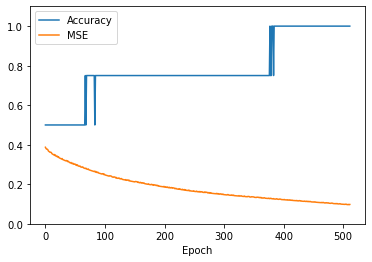

In [86]:
plt.plot(history1.history['accuracy'], label='Accuracy')
plt.plot(history1.history['mse'], label='MSE')
plt.ylim([0, 1.1])
plt.legend()
plt.xlabel('Epoch');

Let's also look at the decision surface of this network:

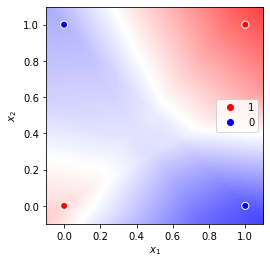

In [87]:
plot_XOR_network(network1)

We can also add more layers and have more nodes in each layer:

In [88]:
network2 = keras.Sequential()
network2.add(keras.layers.Dense(50, activation='relu'))
network2.add(keras.layers.Dense(25, activation='relu'))
network2.add(keras.layers.Dense(12, activation='relu'))
network2.add(keras.layers.Dense(1))

loss_fn = keras.losses.MeanSquaredError()
opt = keras.optimizers.SGD(learning_rate=0.005)
network2.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])

history2 = network2.fit(X_xor, y_xor, batch_size=2, epochs=512, verbose=0)

In [89]:
network2.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 50)                150       
_________________________________________________________________
dense_20 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_21 (Dense)             (None, 12)                312       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 13        
Total params: 1,750
Trainable params: 1,750
Non-trainable params: 0
_________________________________________________________________


This model has far more complexity than is necessary for this problem - a total of 1,750 parameters is orders of magnitude larger than necessary, but it still finds a good solution.

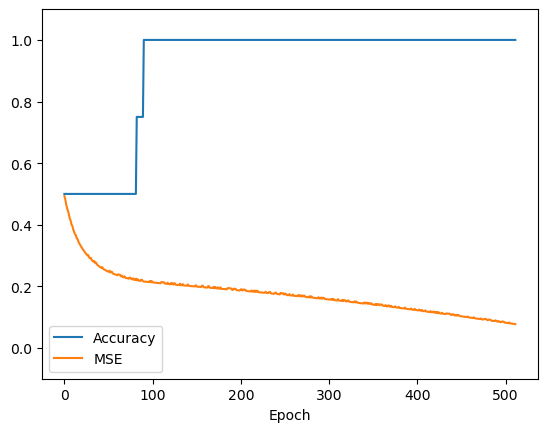

In [90]:
plt.plot(history2.history['accuracy'], label='Accuracy')
plt.plot(history2.history['mse'], label='MSE')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel('Epoch');

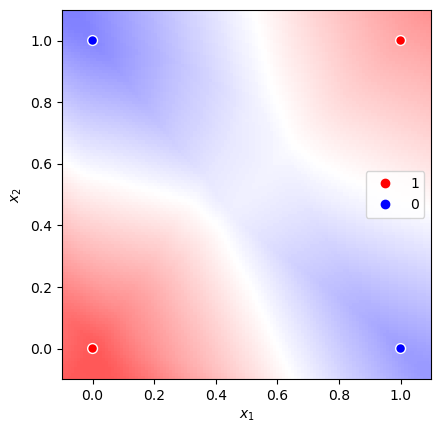

In [91]:
plot_XOR_network(network2)

## One hot encoding, Softmax and the Loss Function

### One hot encoding

Using The Euclidean distance of the outputs from the true values probably isn't the best loss function to be using: it is designed for regression problems. Instead, we can use the cross entropy loss (yes we are introducing a new term which will be defined shortly).  To do this, one thing we need to do is change our expected outputs from being 0 or 1 to be "one-hot-encoded:"

In [92]:
y_xor_one_hot = keras.utils.to_categorical(y_xor, 2)

for a,b in zip(y_xor, y_xor_one_hot) :
    print(f'y value {a} maps to the encoding {b}')
    


y value 1 maps to the encoding [0. 1.]
y value 0 maps to the encoding [1. 0.]
y value 0 maps to the encoding [1. 0.]
y value 1 maps to the encoding [0. 1.]


In one-hot-encoding, each output is now a vector with zero at each class label that is not correct for the associated input and one at the class label that is correct.  One thing to note with this modification is that our network will now have two outputs.

It's also useful to restrict the outputs of our network to look like probabilities.  One way to do this would be to normalize the outputs to be
\begin{align*}
z_1' &= \frac{z_1}{z_1 + z_2} \\
z_2' &= \frac{z_2}{z_1 + z_2}
\end{align*}
which gives us $z_1'$ and $z_2'$ values each between zero and one and summing to one.  One thing to keep in mind here is that although these now form a probability distribution, it isn't necessarily accurate to view $z_1'$ as the "probability that the input is of class one" because the approximation given by our network is just that - an approximation. While useful from a pracitcal standpoint it should not be confused with a rigorously established estimate of the true underlying probability. 


Another way to do this would be to take the hard max of the outputs,
\begin{align*}
z_1' &= \begin{cases} 1 & z_1 \geq z_2 \\ 0 & z_1 < z_2 \end{cases} \\
z_2' &= \begin{cases} 0 & z_1 \geq z_2 \\ 1 & z_1 < z_2 \end{cases},
\end{align*}
which has similar nice properties but is unfortunately not differentiable, so we can't actually use it for classification.

A compromise between these two is softmax.  For our two raw outputs, $z_1$ and $z_2$, the softmax activation function is calculated as
\begin{align*}
\text{softmax}(z_1) &= \frac{e^{z_1}}{e^{z_1} + e^{z_2}} \\
\text{softmax}(z_2) &= \frac{e^{z_2}}{e^{z_1} + e^{z_2}}
\end{align*}

This is very similar to normalization, but with the exponential function of the raw inputs instead.  This means that values will behave in a manner similar to the softwax while maintaining differentiability.


### Visualizing Softmax

Here is a simple bit of code to help you visualize what happens when a set of activations on the last layer of a classification network are run through the softmax function.

In [93]:
def apply_softmax(acts) :
    exp_acts = np.array([np.exp(x) for x in acts])
    exp_acts_sum = np.sum(exp_acts)
    acts_smax = np.array([np.exp(x)/exp_acts_sum for x in acts])
    return exp_acts, acts_smax

def visualize_softmax(mean, sigma, nsamples, rseed) :
    rng = default_rng(rseed)
    act = rng.normal(mean, sigma, nsamples)
    aex, asf = apply_softmax(act)
    plt.style.use('seaborn-deep')
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(13,5))
    ax1.bar(range(nsamples), act, color='darkred')
    ax1.set_xlabel('Output Node')
    ax1.set_ylabel('Activation')
    ax1.set_title('Input Activations')   
    ax2.bar(range(nsamples), aex, color='darkblue')
    ax2.set_xlabel('Output Node')
    ax2.set_ylabel('After Exponentiation')
    ax2.set_title('Exponentiated Input Activation')  
    ax3.bar(range(nsamples), asf, color='darkgreen')
    ax3.set_xlabel('Output Node')
    ax3.set_ylabel('Activation')
    ax3.set_title('Softmax applied to Activations')
    
    plt.show()

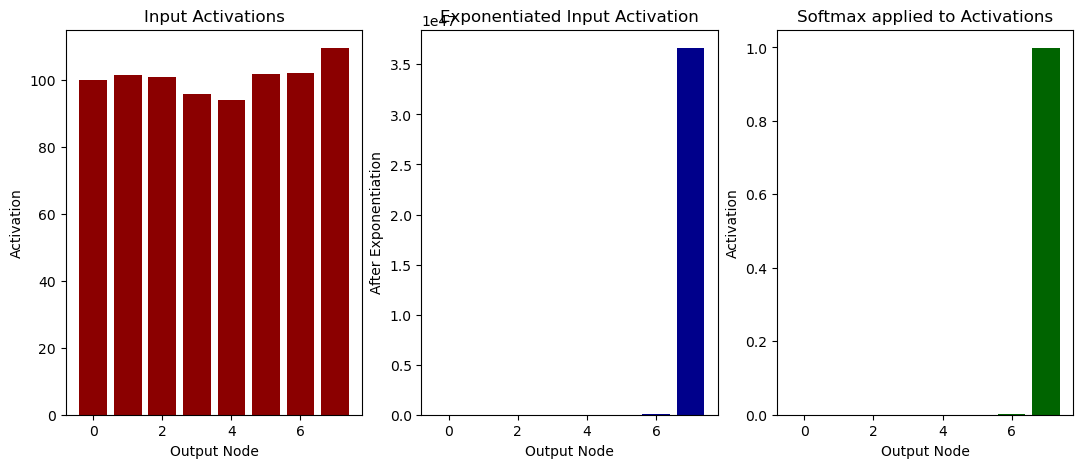

Random seed is: 39


In [94]:
rseed = np.random.randint(0,99)
visualize_softmax(100, 5, 8, rseed)
print(f'Random seed is: {rseed}')

### XOR and a One Hot Softmax Output

Our third network still solves XOR but with the one hot encoding and softmax just introduced. Also, the loss function is now Cross Entropy. 

In [95]:
network3 = keras.Sequential()
network3.add(keras.layers.Dense(10, activation='relu'))
network3.add(keras.layers.Dense(2, activation='softmax'))

loss_fn = keras.losses.BinaryCrossentropy()
opt = keras.optimizers.SGD(learning_rate=0.01)
network3.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])

In [96]:
history3 = network3.fit(X_xor, y_xor_one_hot, batch_size=2, epochs=600, verbose=0)

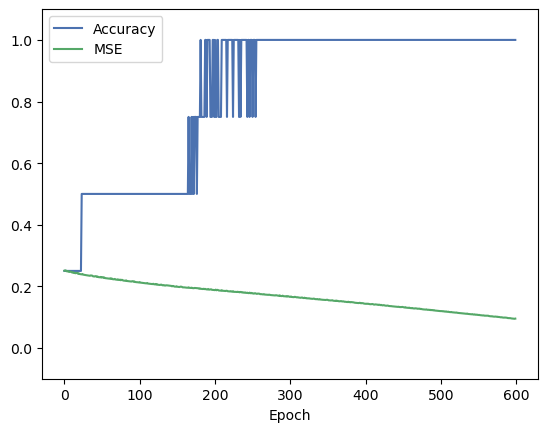

In [97]:
plt.plot(history3.history['accuracy'], label='Accuracy')
plt.plot(history3.history['mse'], label='MSE')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel('Epoch');

To visualize the decision surface, we will plot $z_1 - z_2$.  This is a trick we will use throughout the rest of the notebook.

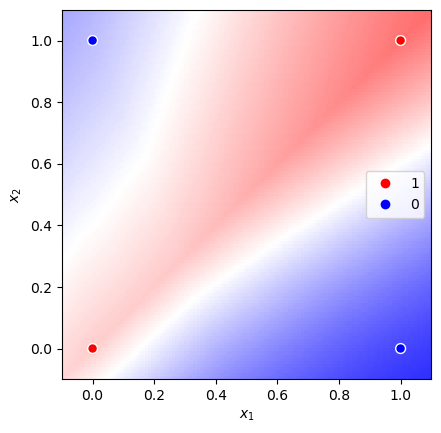

In [98]:
plot_XOR_network(network3, two_outputs=True)

## Nonconvex Optimization

For linear models, finding a solution that minimizes some quantity of interest was relatively easy because the error surface has a single global minimum.  Whenever the error function satisfies a certain condition known as "convexity", this is guaranteed to be the case.
Here's an example of a loss surface of a convex problem:

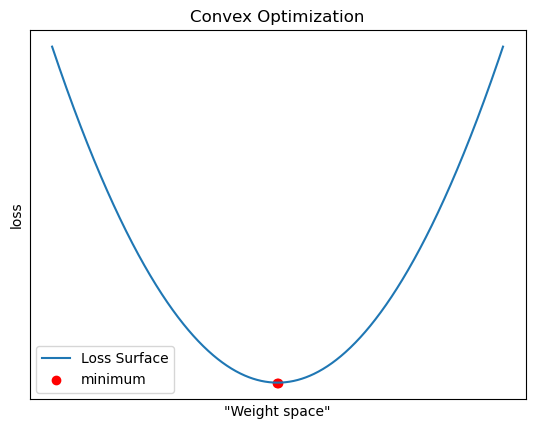

In [99]:
x = np.linspace(-10, 10, 1000)
y = np.power(x, 2)
points = np.r_[True, y[1:] <= y[:-1]] & np.r_[y[:-1] <= y[1:], True]
plt.plot(x, y, label='Loss Surface')
plt.xlabel('"Weight space"')
plt.ylabel('loss')
plt.title("Convex Optimization")
plt.xticks([])
plt.yticks([])
plt.scatter(x[points], y[points], c='r', label='minimum')
plt.legend();

As we change the weights of the model, we move around on the blue curve.  The goal is to find a configuration of weights that places us at the location of the red dot, which is the minimum of this function.

However, due to the nonlinearity of neural networks, there may be more than one minimum.  For example:

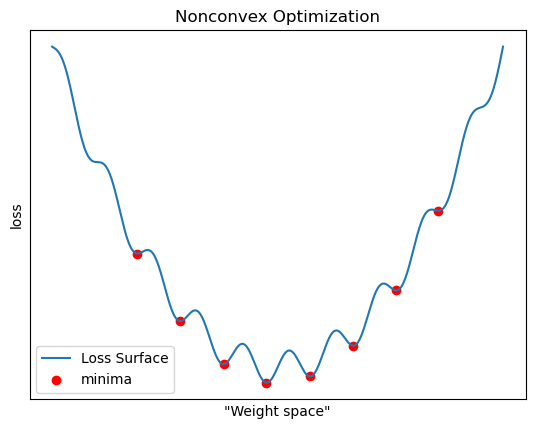

In [100]:
x = np.linspace(-10, 10, 1000)
y = np.power(x, 2) + 5*np.sin(np.pi*x)
points = np.r_[True, y[1:] < y[:-1]] & np.r_[y[:-1] < y[1:], True]
plt.plot(x, y, label="Loss Surface")
plt.xlabel('"Weight space"')
plt.ylabel('loss')
plt.xticks([])
plt.yticks([])
plt.title("Nonconvex Optimization")
plt.scatter(x[points], y[points], c='r', label='minima')
plt.legend();

In this case, there is a single global minimum that represents the optimal solution, but there are a number of other *local* minima.

Gradient descent and many of its variants are the most commonly used algorithms for optimizing the weights of neural networks.  Gradient descent can be thought of as behaving like a ball that is placed on the the loss surface - it rolls down hills.  That means that if an initial configuration of a neural network lies somewhere in a valley around one of the local minima, gradient descent will push it towards that local minimum rather than the global minimum.
However, that may or may not be a problem!  We are interested in solutions that have high prediction accuracy - not necessarily finding the global minimum.


## Gradient Descent Modifications and Regularization

The simple SGD algorithm has a modification that can help with shallow local minima and plateaus in the loss surface - momentum.  Intuitively, this is the same as the idea would be in physics, where the model builds momentum as it travels, and can continue to follow that momentum rather than just going in the direction of most change.  This helps avoid shallow local minima and can prevent the model from slowing down too much on plateaus.

In [101]:
opt = keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)

We can also add weight decay to our model, where weights are driven towards small values to reduce the likelihood of overfitting and smooth the loss surface:

In [103]:
# Pointless Comment

reg = keras.regularizers.l2(1e-4)
network4 = keras.Sequential()
network4.add(keras.layers.Dense(10, activation='relu', kernel_regularizer=reg, bias_regularizer=reg))
network4.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=reg, bias_regularizer=reg))

The rest of our setup is the same as it has been previously.

In [104]:
loss_fn = keras.losses.BinaryCrossentropy()

network4.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])

In [105]:
history4 = network4.fit(X_xor, y_xor_one_hot, batch_size=2, epochs=100, verbose=0)

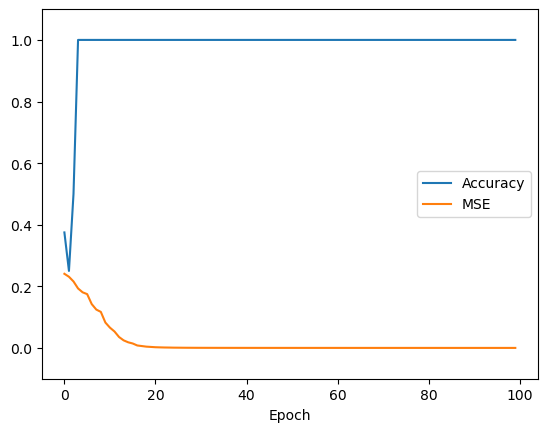

In [106]:
plt.plot(history4.history['accuracy'], label='Accuracy')
plt.plot(history4.history['mse'], label='MSE')
plt.ylim([-0.1, 1.1])
plt.legend()
plt.xlabel('Epoch');

This network trains *much* faster than the previous models.  While testing this notebook, the model frequently achieved zero loss by epoch 50.

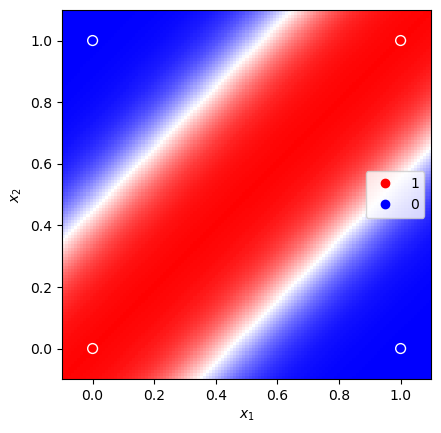

In [107]:
plot_XOR_network(network4, two_outputs=True)

There are also more complex optimizers, such as the [Adam optimizer](https://arxiv.org/pdf/1412.6980.pdf) designed by Diederik Kingma and Jimmy Ba.  It uses a variety of techniques like adaptive learning rates and momentums to provide competitive performance.  To use it in Keras, call it as

In [108]:
opt = keras.optimizers.Adam()

It has default parameters that empirically work well on a wide class of problems.

## Complex Problems

[Neural Networks, Manifolds, and Topology](https://colah.github.io/posts/2014-03-NN-Manifolds-Topology/) by Christopher Olah has animated versions for $\tanh$ networks of some of the investigations and examples shown here.

Now let's consider a slightly more difficult problem for neural networks:

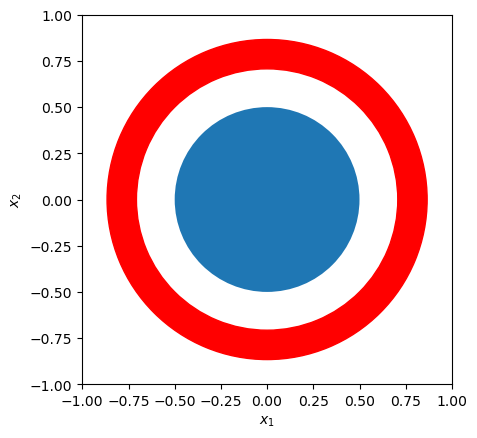

In [109]:
r1 = 0.5
r2 = np.sqrt(2*r1**2)
r3 = np.sqrt(r1**2 + r2**2)

fig = plt.figure()
ax = fig.add_subplot(111)

circle = plt.Circle((0, 0), r1)
annulus = matplotlib.patches.Wedge((0, 0), r3, 0, 360, width=r3-r2, color='r')
ax.add_artist(circle)
ax.add_artist(annulus)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', 'box');

By itself this is a relatively easy problem - if we convert to polar coordinates, we can just threshold based on the radius and have a very simple classifier that achieves 100% accuracy.  However, if we use the raw $x_1$ and $x_2$ inputs to a neural network, that information must be learned by the network.  The network must be able to construct a closed region in the plane, which requires more complexity than was necessary for XOR.

For training a network we need specific inputs, so we will get 500 points from the circle and 500 from the annulus with their associated class labels:

In [110]:
X_circle = []
y_circle = []
for i in range(500):
    # Circle
    vec = np.random.uniform(-1, 1, 2)
    while np.linalg.norm(vec) > r1:
        vec = np.random.uniform(-1, 1, 2)
    X_circle.append(vec)
    y_circle.append(0)
        
    # Annulus
    vec = np.random.uniform(-1, 1, 2)
    while np.linalg.norm(vec) < r2 or np.linalg.norm(vec) > r3:
        vec = np.random.uniform(-1, 1, 2)
    X_circle.append(vec)
    y_circle.append(1)
    
X_circle = np.array(X_circle)
X_circle = X_circle.astype('float32')
y_circle = np.array(y_circle)
y_circle_one_hot = keras.utils.to_categorical(y_circle, 2)

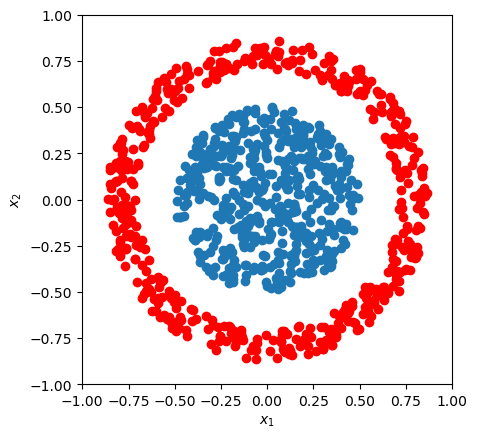

In [111]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X_circle[y_circle==0, 0], X_circle[y_circle==0, 1])
ax.scatter(X_circle[y_circle==1, 0], X_circle[y_circle==1, 1], c='r')
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_aspect('equal', 'box');

Let's train a simple network on this and keep trying until we make sure we get a better solution than random:

In [115]:
while True:
    network5 = keras.Sequential()
    network5.add(keras.layers.Dense(2, activation='relu'))
    network5.add(keras.layers.Dense(2, activation='softmax'))

    loss_fn = keras.losses.BinaryCrossentropy()
    opt = keras.optimizers.Adam()
    network5.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])
    
    history5 = network5.fit(X_circle, y_circle_one_hot, batch_size=100, epochs=500, verbose=0)
    print('Trained one network to {} accuracy'.format(history5.history['accuracy'][-1]))
    if history5.history['accuracy'][-1] > 0.78:
        break

Trained one network to 0.765999972820282 accuracy
Trained one network to 0.6600000262260437 accuracy
Trained one network to 0.7979999780654907 accuracy


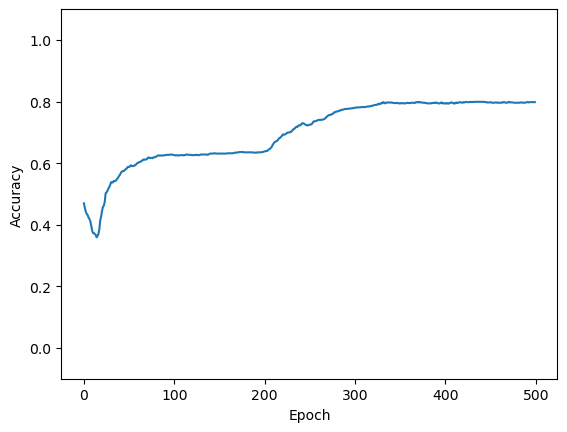

In [116]:
plt.plot(history5.history['accuracy'])
plt.ylim([-0.1, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

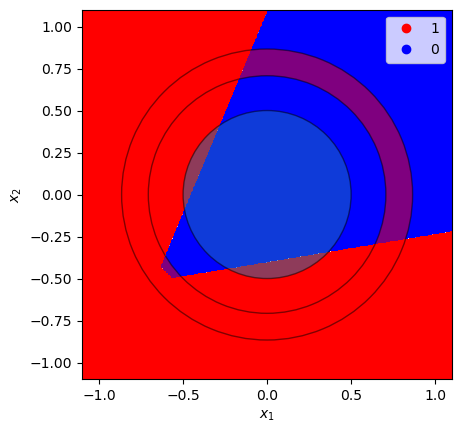

In [117]:
plot_circles_network(network5, two_outputs=True)

This network gets about 80% accuracy, which is somewhat close to the best that can be expected from this architecture.  Let's look at what it actually does to the data.  The first thing it does is apply the weights of the first layer to transform the data:

Every data point with a horizontal coordinate below zero has its horizontal coordinate taken to zero - effectively shoving all the negative data to zero on that axis.

We can do the same thing with the second node, which is the vertical axis:

This doesn't look particularly useful, but notice that all of the blue data points are in the lower left corner.  That means that when the decision boundary is drawn on, they can (mostly) be on one side, even if there is significant mixing with the red points.

That decision boundary comes from the hidden to output weights, as that is the linear classifier the network is using.  In the new space created by applying the first layer, the decision boundary is a straight line:

Now let's train a network that solves this, with three nodes in its hidden layer.  We may have to train it multiple times for it to find a solution with 100% accuracy.

In [118]:
while True:
    network6 = keras.Sequential()
    network6.add(keras.layers.Dense(3, activation='relu'))
    network6.add(keras.layers.Dense(2, activation='softmax'))

    loss_fn = keras.losses.BinaryCrossentropy()
    opt = keras.optimizers.Adam()
    network6.compile(loss=loss_fn, optimizer=opt, metrics=['accuracy', 'mse'])
    history6 = network6.fit(X_circle, y_circle_one_hot, batch_size=100, epochs=500, verbose=0)
    
    print('Trained one network to {} accuracy'.format(history6.history['accuracy'][-1]))
    if history6.history['accuracy'][-1] >= 0.996:
        break

Trained one network to 0.9929999709129333 accuracy
Trained one network to 0.9929999709129333 accuracy
Trained one network to 0.9929999709129333 accuracy
Trained one network to 0.9950000047683716 accuracy
Trained one network to 0.9990000128746033 accuracy


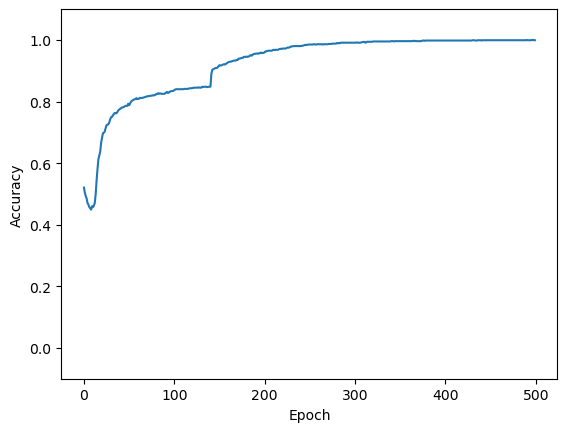

In [121]:
plt.plot(history6.history['accuracy'])
plt.ylim([-0.1, 1.1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy');

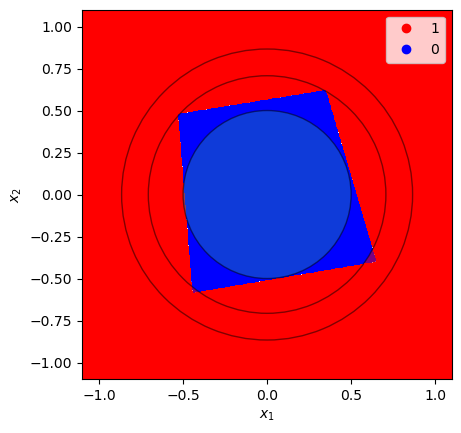

In [122]:
plot_circles_network(network6, two_outputs=True)

This should have perfect or near perfect accuracy on the data we are considering - if it is perfect, it likely has a hexagonal shape, and if it is imperfect it has like found a square shape with the corners overlapping the annulus.

## Comments

1. Some of the intuition from these small, two-input networks may not carry over in expected ways to higher dimensional problems.  Unfortunately, building intuition for those more complex problems is typically difficult due to the limited ability to analyze high dimensional networks.  We will discuss more complex problems in our next notebook.
2. Until relatively recently, one of the best methods for hyperparameter selection with neural networks was random search.  More sophisticated methods exist now, but without insight into the dataset it can be difficult to determine how to structure network architecture and training process
3. Keras used to be independent from the chosen backend, but its creator now works for Google (the makers of TensorFlow), and backends like PyTorch are no longer being updated, so the "recommended" backend is TensorFlow.  Keras is also being more closely tied into TensorFlow.